In [1]:
# Ensemble Variant 1: S: Densenet201, W: ResNet152d (Best Model)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from backbones import DenseNet201
from backbones import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran2 import CTranEncoder
torch.cuda.empty_cache()
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
embed_dim = 1024
num_workers = 8
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
data_dir = '../../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../../data/GT-main/./set1/train.csv
384
../../../../data/GT-main/./set1/val.csv
384
../../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = embed_dim)
model1 = CTranEncoder(num_classes=num_classes, in_channels = 3, embed_dim=embed_dim, num_layers=4, num_heads=num_workers, backbone=backbone1)
model1.to(device)
num_params1 = sum(p.numel() for p in model1.parameters())

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = embed_dim)
model2 = CTranEncoder(num_classes=num_classes, in_channels = 3, embed_dim=embed_dim, num_layers=4, num_heads=num_workers, backbone=backbone2)
model2.to(device)
num_params2 = sum(p.numel() for p in model2.parameters())
print(num_params1, num_params2, num_params1+num_params2)

# Wrap your model with DataParallel
# model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
# model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-6, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

torch.Size([1, 21, 1024])


/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weigh

torch.Size([1, 21, 1024])
162068341 121867157 283935498


In [5]:
# summary(model1, input_size=(3, 384, 384))

In [6]:
# summary(model2, input_size=(3, 384, 384))

In [7]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)
metric3 = Metric(num_classes=num_classes)

thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels)
            
        with torch.no_grad():
            metric2.update(outputs2, labels)
        
        with torch.no_grad():
            metric3.update(weighted_outputs, labels)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh1 = metric2.compute()
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh1)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh2 = metric1.compute()
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh2)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh3 = metric3.compute()
    print("Ensemble:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh3)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    metric3.reset()
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric3.update(weighted_outputs, labels)

        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh3 = metric3.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric3.reset()
        torch.cuda.empty_cache()   
    print(thresh3)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
    # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += weighted_outputs.tolist()
            test_labels += labels.tolist()
            metric3.update(weighted_outputs, labels)

        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh3 = metric3.compute(thresholds = thresh3)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model1, 'models/strongdn_rn-js.pth')
            torch.save(model2, 'models/strongdn_dn-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        
        # Reset Metric class for next epoch
        metric3.reset()
        torch.cuda.empty_cache()     
    
    print(thresh3)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    print()
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.6667, ML mAP: 0.1022, ML F1: 0.8400, ML AUC: 0.5869, ML Score: 0.3446, Bin AUC: 0.5500, Model Score: 0.4473, Bin F1: 1.0000
[0.65 0.61 0.67 0.54 0.66 0.56 0.67 0.64 0.65 0.66 0.61 0.6  0.64 0.64
 0.7  0.63 0.68 0.56 0.66 0.68 0.68]
Accuracy list: [0.8844422211105553, 0.9474737368684342, 0.9129564782391195, 0.8259129564782391, 0.8949474737368684, 0.7748874437218609, 0.927463731865933, 0.9299649824912456, 0.943471735867934, 0.9459729864932466, 0.9279639819909955, 0.9119559779889945, 0.9494747373686844, 0.9534767383691846, 0.9374687343671836, 0.9364682341170585, 0.9384692346173087, 0.8374187093546773, 0.9499749874937469, 0.8939469734867433, 0.943471735867934]
Specificity list: [0.9994347088750707, 0.9984185556141276, 0.9994523548740416, 0.9041782729805014, 0.9994413407821229, 0.8419572553430821, 0.9994609164420485, 0.99892530897367, 0.9994700582935877, 0.9994714587737844, 0.9989229940764675, 0.9678800856531049, 0.9984218832193582, 0.9994756161510225, 0

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [1/200], Loss: 0.6644, ML mAP: 0.2333, ML F1: 0.7062, ML AUC: 0.7994, ML Score: 0.5164, Bin AUC: 0.7000, Model Score: 0.6082, Bin F1: 1.0000
[0.52 0.52 0.52 0.52 0.54 0.56 0.52 0.56 0.51 0.52 0.54 0.5  0.51 0.52
 0.52 0.54 0.54 0.55 0.51 0.54 0.54]
Accuracy list: [0.8246013667425968, 0.8177676537585421, 0.8724373576309795, 0.8519362186788155, 0.9362186788154897, 0.908883826879271, 0.9316628701594533, 0.9567198177676538, 0.9635535307517085, 0.9817767653758542, 0.9772209567198178, 0.9271070615034168, 0.9772209567198178, 0.9658314350797267, 0.9726651480637813, 0.979498861047836, 0.9817767653758542, 0.979498861047836, 0.9248291571753986, 0.8883826879271071, 0.9908883826879271]
Specificity list: [0.8938547486033519, 0.8409785932721713, 0.8946078431372549, 0.9065656565656566, 0.9877750611246944, 0.9541062801932367, 0.9878934624697336, 0.997624703087886, 0.9929577464788732, 1.0, 0.9953596287703016, 0.9303944315545244, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [1/200], Loss: 18.3765, ML mAP: 0.2379, ML F1: 0.4632, ML AUC: 0.7892, ML Score: 0.5136, Bin AUC: 0.8000, Model Score: 0.6568, Bin F1: 1.0000
[0.52 0.52 0.52 0.52 0.54 0.56 0.52 0.56 0.51 0.52 0.54 0.5  0.51 0.52
 0.52 0.54 0.54 0.55 0.51 0.54 0.54]
Accuracy list: [0.8104265402843602, 0.7962085308056872, 0.8838862559241706, 0.8436018957345972, 0.9312796208530806, 0.9123222748815166, 0.9407582938388626, 0.957345971563981, 0.966824644549763, 0.9691943127962085, 0.985781990521327, 0.919431279620853, 0.9715639810426541, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9265402843601895, 0.9123222748815166, 0.985781990521327]
Specificity list: [0.8757225433526011, 0.7954545454545454, 0.9053708439897699, 0.9078947368421053, 0.9823232323232324, 0.9621212121212122, 0.9925, 1.0, 1.0, 0.9975609756097561, 1.0, 0.9249394673123487, 1.0, 1.0, 0.9928057553956835, 0.9975903614457832, 0.9880668257756563, 0.9880382775119617, 0.943902439024390

100%|██████████| 125/125 [00:53<00:00,  2.34it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.4631, ML mAP: 0.1393, ML F1: 0.7462, ML AUC: 0.6211, ML Score: 0.3802, Bin AUC: 0.2368, Model Score: 0.3085, Bin F1: 1.0000
[0.52 0.5  0.54 0.6  0.52 0.81 0.66 0.52 0.61 0.63 0.6  0.71 0.59 0.63
 0.64 0.62 0.7  0.57 0.64 0.69 0.57]
Accuracy list: [0.8279139569784892, 0.8999499749874937, 0.8724362181090545, 0.8914457228614308, 0.8679339669834918, 0.8699349674837419, 0.9184592296148074, 0.8884442221110556, 0.9404702351175588, 0.9349674837418709, 0.9479739869934968, 0.9234617308654327, 0.951975987993997, 0.9484742371185593, 0.9389694847423712, 0.943471735867934, 0.9394697348674337, 0.8919459729864933, 0.9514757378689345, 0.9179589794897449, 0.9289644822411206]
Specificity list: [0.9302325581395349, 0.9403379091869061, 0.9250814332247557, 0.9994391475042064, 0.9232035106966539, 0.9994252873563219, 0.9994556341861731, 0.9342318059299192, 0.9994683678894205, 0.9989310529128808, 0.9994725738396625, 0.9994585814834868, 0.9994747899159664, 0.9994728518713759

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [2/200], Loss: 0.4617, ML mAP: 0.1190, ML F1: 0.7258, ML AUC: 0.6480, ML Score: 0.3835, Bin AUC: 0.0500, Model Score: 0.2167, Bin F1: 1.0000
[0.37 0.3  0.55 0.4  0.43 0.52 0.44 0.48 0.46 0.48 0.45 0.49 0.48 0.48
 0.49 0.47 0.48 0.51 0.45 0.43 0.48]
Accuracy list: [0.7380410022779044, 0.5990888382687927, 0.9271070615034168, 0.8246013667425968, 0.8747152619589977, 0.9407744874715261, 0.9202733485193622, 0.9339407744874715, 0.9635535307517085, 0.9749430523917996, 0.979498861047836, 0.979498861047836, 0.9703872437357631, 0.9703872437357631, 0.9703872437357631, 0.9772209567198178, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8246013667425968, 0.9635535307517085]
Specificity list: [0.7374301675977654, 0.599388379204893, 0.9975490196078431, 0.8939393939393939, 0.9193154034229829, 0.9975845410628019, 0.9757869249394673, 0.9619952494061758, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9976580796252927, 0.99532

100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


Test - Epoch [2/200], Loss: 12.3416, ML mAP: 0.1365, ML F1: 0.4843, ML AUC: 0.6545, ML Score: 0.3955, Bin AUC: 0.2500, Model Score: 0.3227, Bin F1: 0.6667
[0.37 0.3  0.55 0.4  0.43 0.52 0.44 0.48 0.46 0.48 0.45 0.49 0.48 0.48
 0.49 0.47 0.48 0.51 0.45 0.43 0.48]
Accuracy list: [0.7298578199052133, 0.5710900473933649, 0.9265402843601895, 0.8127962085308057, 0.8601895734597157, 0.943127962085308, 0.919431279620853, 0.9241706161137441, 0.9644549763033176, 0.9644549763033176, 0.981042654028436, 0.981042654028436, 0.9691943127962085, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.8412322274881516, 0.9454976303317536]
Specificity list: [0.7485549132947977, 0.5454545454545454, 1.0, 0.8868421052631579, 0.9015151515151515, 1.0, 0.97, 0.9503722084367245, 0.9975490196078431, 0.9926829268292683, 0.9951923076923077, 1.0, 0.9975609756097561, 1.0, 0.9976019184652278, 0.9951807228915662, 0.9928400954653938, 1.0, 1.0, 0.9140625, 0.

100%|██████████| 125/125 [00:52<00:00,  2.38it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.4268, ML mAP: 0.1077, ML F1: 0.2888, ML AUC: 0.6253, ML Score: 0.3665, Bin AUC: 0.7368, Model Score: 0.5517, Bin F1: 0.3333
[0.27 0.37 0.4  0.5  0.66 0.32 0.41 0.5  0.44 0.42 0.45 0.24 0.5  0.37
 0.35 0.5  0.32 0.56 0.45 0.5  0.52]
Accuracy list: [0.7368684342171086, 0.8649324662331166, 0.8089044522261131, 0.8939469734867433, 0.9149574787393697, 0.6913456728364182, 0.8419209604802401, 0.9219609804902451, 0.8489244622311155, 0.8489244622311155, 0.8574287143571786, 0.7138569284642321, 0.9564782391195598, 0.8599299649824912, 0.8169084542271136, 0.9534767383691846, 0.822911455727864, 0.9364682341170585, 0.8529264632316158, 0.8834417208604303, 0.9514757378689345]
Specificity list: [0.7930045871559633, 0.8979591836734694, 0.8632664134563213, 0.9994407158836689, 0.9994535519125683, 0.7242751563388289, 0.8988642509464575, 0.9924160346695557, 0.8994114499732477, 0.8966809421841542, 0.9064824654622742, 0.7134408602150538, 1.0, 0.8958990536277602, 0.8548728813

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [3/200], Loss: 0.4139, ML mAP: 0.1591, ML F1: 0.8307, ML AUC: 0.7507, ML Score: 0.4549, Bin AUC: 0.3000, Model Score: 0.3775, Bin F1: 1.0000
[0.33 0.28 0.44 0.41 0.56 0.44 0.37 0.39 0.36 0.41 0.37 0.44 0.38 0.34
 0.38 0.4  0.43 0.43 0.35 0.41 0.39]
Accuracy list: [0.7881548974943052, 0.785876993166287, 0.9271070615034168, 0.8997722095671982, 0.929384965831435, 0.9020501138952164, 0.9384965831435079, 0.9316628701594533, 0.9681093394077449, 0.9749430523917996, 0.9840546697038725, 0.979498861047836, 0.9726651480637813, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.979498861047836, 0.9772209567198178, 0.8883826879271071, 0.9658314350797267]
Specificity list: [0.7877094972067039, 0.7859327217125383, 0.9975490196078431, 0.9974747474747475, 0.9975550122249389, 0.9444444444444444, 0.9975786924939467, 0.9572446555819477, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9976580796252927, 0.9976635514018691, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [3/200], Loss: 11.2674, ML mAP: 0.1648, ML F1: 0.6036, ML AUC: 0.7348, ML Score: 0.4498, Bin AUC: 0.1000, Model Score: 0.2749, Bin F1: 0.0000
[0.33 0.28 0.44 0.41 0.56 0.44 0.37 0.39 0.36 0.41 0.37 0.44 0.38 0.34
 0.38 0.4  0.43 0.43 0.35 0.41 0.39]
Accuracy list: [0.7630331753554502, 0.7274881516587678, 0.9312796208530806, 0.9028436018957346, 0.9383886255924171, 0.909952606635071, 0.943127962085308, 0.9360189573459715, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.9549763033175356, 0.966824644549763, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.9028436018957346, 0.9597156398104265]
Specificity list: [0.7658959537572254, 0.7045454545454546, 0.9974424552429667, 1.0, 1.0, 0.9595959595959596, 0.995, 0.9578163771712159, 0.9975490196078431, 0.9975609756097561, 1.0, 1.0, 0.9829268292682927, 0.9878934624697336, 0.9952038369304557, 0.9975903614457832, 0.9976133651551312, 0.992822966507177, 1.0

100%|██████████| 125/125 [01:27<00:00,  1.44it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.4063, ML mAP: 0.1207, ML F1: 0.2649, ML AUC: 0.6817, ML Score: 0.4012, Bin AUC: 0.3000, Model Score: 0.3506, Bin F1: 0.1429
[0.23 0.13 0.17 0.5  0.14 0.29 0.19 0.66 0.2  0.24 0.15 0.23 0.27 0.16
 0.21 0.14 0.19 0.23 0.14 0.05 0.23]
Accuracy list: [0.7633816908454227, 0.8239119559779889, 0.7738869434717359, 0.886943471735868, 0.7158579289644822, 0.7343671835917959, 0.8194097048524263, 0.9159579789894947, 0.8339169584792396, 0.8344172086043021, 0.8299149574787393, 0.7798899449724862, 0.8749374687343672, 0.8519259629814907, 0.8454227113556778, 0.8254127063531765, 0.7853926963481741, 0.8034017008504252, 0.7863931965982992, 0.10455227613806903, 0.8439219609804902]
Specificity list: [0.8207492795389049, 0.8467614533965245, 0.8112493239588967, 0.9994363021420518, 0.7305122494432071, 0.7836426914153132, 0.8739859383450513, 0.9994541484716157, 0.8803418803418803, 0.8795116772823779, 0.8672707889125799, 0.7909238249594813, 0.9138202837624803, 0.88719832109129

100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Val - Epoch [4/200], Loss: 0.3474, ML mAP: 0.2214, ML F1: 0.8186, ML AUC: 0.8030, ML Score: 0.5122, Bin AUC: 0.5500, Model Score: 0.5311, Bin F1: 1.0000
[0.35 0.29 0.44 0.48 0.63 0.47 0.36 0.41 0.33 0.38 0.35 0.47 0.33 0.35
 0.33 0.36 0.45 0.46 0.33 0.35 0.37]
Accuracy list: [0.8337129840546698, 0.8382687927107062, 0.9271070615034168, 0.8997722095671982, 0.929384965831435, 0.9157175398633257, 0.9384965831435079, 0.9453302961275627, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9749430523917996, 0.9544419134396356, 0.9703872437357631, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8519362186788155, 0.9840546697038725]
Specificity list: [0.8659217877094972, 0.8837920489296636, 0.9975490196078431, 0.9974747474747475, 0.9975550122249389, 0.9565217391304348, 0.9975786924939467, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9812646370023419, 0.99532

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [4/200], Loss: 10.7361, ML mAP: 0.2134, ML F1: 0.6230, ML AUC: 0.7749, ML Score: 0.4942, Bin AUC: 0.5000, Model Score: 0.4971, Bin F1: 0.0000
[0.35 0.29 0.44 0.48 0.63 0.47 0.36 0.41 0.33 0.38 0.35 0.47 0.33 0.35
 0.33 0.36 0.45 0.46 0.33 0.35 0.37]
Accuracy list: [0.8388625592417062, 0.8270142180094787, 0.9265402843601895, 0.9004739336492891, 0.9383886255924171, 0.919431279620853, 0.9383886255924171, 0.9312796208530806, 0.966824644549763, 0.9691943127962085, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.966824644549763, 0.9739336492890995, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.966824644549763, 0.8483412322274881, 0.9739336492890995]
Specificity list: [0.8872832369942196, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9671717171717171, 0.99, 0.9503722084367245, 1.0, 0.9975609756097561, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.9975903614457832, 0.9952267303102625, 0.9976076555023924, 0.

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.2943, ML mAP: 0.1343, ML F1: 0.2624, ML AUC: 0.7156, ML Score: 0.4249, Bin AUC: 0.5500, Model Score: 0.4875, Bin F1: 0.0000
[0.21 0.14 0.17 0.19 0.62 0.26 0.18 0.17 0.13 0.13 0.11 0.25 0.15 0.13
 0.13 0.15 0.23 0.23 0.15 0.2  0.17]
Accuracy list: [0.7388694347173587, 0.8304152076038019, 0.80040020010005, 0.7868934467233617, 0.919959979989995, 0.7543771885942971, 0.8519259629814907, 0.8159079539769885, 0.8169084542271136, 0.7363681840920461, 0.7813906953476738, 0.8074037018509255, 0.8574287143571786, 0.806903451725863, 0.7673836918459229, 0.7998999499749875, 0.8239119559779889, 0.817408704352176, 0.7723861930965483, 0.815407703851926, 0.8514257128564282]
Specificity list: [0.7748571428571429, 0.851063829787234, 0.836491608012994, 0.8352553542009885, 0.9994565217391305, 0.7763306908267271, 0.9016568679850347, 0.8331539289558665, 0.851891315929675, 0.7643243243243243, 0.8028692879914984, 0.821505376344086, 0.8879624804585722, 0.830168776371308, 0.78663

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [5/200], Loss: 0.1675, ML mAP: 0.2244, ML F1: 0.8468, ML AUC: 0.7597, ML Score: 0.4921, Bin AUC: 0.6500, Model Score: 0.5710, Bin F1: 1.0000
[0.31 0.26 0.41 0.36 0.54 0.5  0.32 0.33 0.31 0.32 0.31 0.39 0.29 0.29
 0.27 0.35 0.42 0.45 0.28 0.34 0.38]
Accuracy list: [0.8473804100227791, 0.8451025056947609, 0.9271070615034168, 0.9134396355353075, 0.929384965831435, 0.9407744874715261, 0.9362186788154897, 0.9407744874715261, 0.9681093394077449, 0.9772209567198178, 0.9772209567198178, 0.9544419134396356, 0.9772209567198178, 0.9703872437357631, 0.9134396355353075, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9931662870159453]
Specificity list: [0.8687150837988827, 0.8837920489296636, 0.9975490196078431, 0.9671717171717171, 0.9975550122249389, 0.9975845410628019, 0.9951573849878934, 0.9572446555819477, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9559164733178654, 0.9976744186046511, 0.9976580796252927, 0.927

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [5/200], Loss: 7.3883, ML mAP: 0.2154, ML F1: 0.3074, ML AUC: 0.7494, ML Score: 0.4824, Bin AUC: 0.6000, Model Score: 0.5412, Bin F1: 0.0000
[0.31 0.26 0.41 0.36 0.54 0.5  0.32 0.33 0.31 0.32 0.31 0.39 0.29 0.29
 0.27 0.35 0.42 0.45 0.28 0.34 0.38]
Accuracy list: [0.8270142180094787, 0.8199052132701422, 0.9289099526066351, 0.8767772511848341, 0.9383886255924171, 0.9407582938388626, 0.9383886255924171, 0.9289099526066351, 0.966824644549763, 0.9691943127962085, 0.9739336492890995, 0.9478672985781991, 0.9715639810426541, 0.9786729857819905, 0.8815165876777251, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9715639810426541, 0.909952606635071, 0.990521327014218]
Specificity list: [0.861271676300578, 0.8603896103896104, 1.0, 0.9447368421052632, 1.0, 1.0, 0.9875, 0.9454094292803971, 1.0, 0.9975609756097561, 0.9855769230769231, 0.9636803874092009, 1.0, 1.0, 0.8896882494004796, 0.9975903614457832, 1.0, 0.9976076555023924, 1.0, 1.0, 0.9924812030075187]

Epoch 6/200
--

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.2806, ML mAP: 0.1523, ML F1: 0.3409, ML AUC: 0.7417, ML Score: 0.4470, Bin AUC: 0.8000, Model Score: 0.6235, Bin F1: 0.2857
[0.25 0.2  0.17 0.17 0.17 0.5  0.15 0.74 0.17 0.14 0.12 0.59 0.11 0.15
 0.16 0.15 0.22 0.2  0.14 0.17 0.51]
Accuracy list: [0.7853926963481741, 0.8739369684842421, 0.806903451725863, 0.7433716858429215, 0.7863931965982992, 0.8874437218609305, 0.8159079539769885, 0.9239619809904952, 0.8379189594797398, 0.7668834417208604, 0.8054027013506754, 0.9299649824912456, 0.8209104552276139, 0.8179089544772387, 0.8114057028514257, 0.8139069534767384, 0.8189094547273637, 0.7898949474737369, 0.7973986993496749, 0.7708854427213607, 0.9569784892446224]
Specificity list: [0.8399539435808866, 0.897745149449397, 0.8385160938352427, 0.7702627166014533, 0.7962243198223209, 0.9988738738738738, 0.8714053174172545, 0.9989183342347214, 0.8809776833156217, 0.798918918918919, 0.8314785373608903, 0.9994623655913979, 0.8441422594142259, 0.8445154419595314,

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [6/200], Loss: 0.1237, ML mAP: 0.2353, ML F1: 0.8205, ML AUC: 0.7670, ML Score: 0.5012, Bin AUC: 0.7500, Model Score: 0.6256, Bin F1: 0.6667
[0.29 0.17 0.25 0.38 0.28 0.45 0.31 0.32 0.28 0.3  0.29 0.35 0.25 0.28
 0.27 0.33 0.36 0.4  0.23 0.32 0.31]
Accuracy list: [0.8519362186788155, 0.8132118451025057, 0.9248291571753986, 0.8997722095671982, 0.8792710706150342, 0.9407744874715261, 0.9384965831435079, 0.9567198177676538, 0.9658314350797267, 0.9772209567198178, 0.979498861047836, 0.9635535307517085, 0.9772209567198178, 0.9703872437357631, 0.9544419134396356, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9726651480637813, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.8743016759776536, 0.8012232415902141, 0.9681372549019608, 0.9974747474747475, 0.9095354523227384, 0.9975845410628019, 0.9975786924939467, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9651972157772621, 0.9976744186046511, 0.9976580796252927, 0.971

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [6/200], Loss: 6.1567, ML mAP: 0.2313, ML F1: 0.7072, ML AUC: 0.7617, ML Score: 0.4965, Bin AUC: 0.6500, Model Score: 0.5732, Bin F1: 1.0000
[0.29 0.17 0.25 0.38 0.28 0.45 0.31 0.32 0.28 0.3  0.29 0.35 0.25 0.28
 0.27 0.33 0.36 0.4  0.23 0.32 0.31]
Accuracy list: [0.8578199052132701, 0.7606635071090048, 0.9218009478672986, 0.8981042654028436, 0.9146919431279621, 0.9383886255924171, 0.933649289099526, 0.9478672985781991, 0.95260663507109, 0.9644549763033176, 0.9786729857819905, 0.9502369668246445, 0.966824644549763, 0.9786729857819905, 0.9289099526066351, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9644549763033176, 0.9075829383886256, 0.985781990521327]
Specificity list: [0.8959537572254336, 0.7435064935064936, 0.9616368286445013, 0.9973684210526316, 0.9343434343434344, 1.0, 0.985, 0.9652605459057072, 0.9852941176470589, 0.9926829268292683, 0.9927884615384616, 0.9636803874092009, 0.9951219512195122, 1.0, 0.9376498800959233, 0.9975903614457832, 0.997613365155

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.2553, ML mAP: 0.1669, ML F1: 0.3930, ML AUC: 0.7514, ML Score: 0.4591, Bin AUC: 0.8000, Model Score: 0.6296, Bin F1: 1.0000
[0.28 0.19 0.58 0.52 0.19 0.27 0.13 0.19 0.13 0.17 0.13 0.56 0.12 0.15
 0.18 0.13 0.2  0.5  0.15 0.16 0.5 ]
Accuracy list: [0.8044022011005503, 0.847423711855928, 0.9159579789894947, 0.8954477238619309, 0.799399699849925, 0.759879939969985, 0.7358679339669835, 0.8234117058529264, 0.8159079539769885, 0.806903451725863, 0.824912456228114, 0.919959979989995, 0.815407703851926, 0.822911455727864, 0.8299149574787393, 0.7823911955977989, 0.7908954477238619, 0.9339669834917459, 0.8189094547273637, 0.7463731865932967, 0.9654827413706853]
Specificity list: [0.8589595375722543, 0.8644245927482922, 0.9994541484716157, 0.9994416527079844, 0.8109756097560976, 0.8006912442396313, 0.7637837837837838, 0.8389553862894451, 0.8533475026567482, 0.843482905982906, 0.8628389154704944, 0.9994565217391305, 0.8427970557308097, 0.8434873949579832, 0.855

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [7/200], Loss: 0.1064, ML mAP: 0.2445, ML F1: 0.8530, ML AUC: 0.7913, ML Score: 0.5179, Bin AUC: 0.7500, Model Score: 0.6339, Bin F1: 0.6667
[0.29 0.2  0.25 0.4  0.31 0.45 0.28 0.26 0.27 0.28 0.25 0.43 0.22 0.25
 0.32 0.32 0.35 0.39 0.22 0.2  0.41]
Accuracy list: [0.8724373576309795, 0.8656036446469249, 0.929384965831435, 0.8997722095671982, 0.9134396355353075, 0.9384965831435079, 0.9384965831435079, 0.9453302961275627, 0.9681093394077449, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9772209567198178, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7790432801822323, 0.9931662870159453]
Specificity list: [0.9385474860335196, 0.908256880733945, 0.9779411764705882, 0.9974747474747475, 0.9462102689486552, 0.9951690821256038, 0.9975786924939467, 0.9548693586698337, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.99766

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [7/200], Loss: 5.7578, ML mAP: 0.2480, ML F1: 0.6039, ML AUC: 0.7802, ML Score: 0.5141, Bin AUC: 0.7000, Model Score: 0.6071, Bin F1: 1.0000
[0.29 0.2  0.25 0.4  0.31 0.45 0.28 0.26 0.27 0.28 0.25 0.43 0.22 0.25
 0.32 0.32 0.35 0.39 0.22 0.2  0.41]
Accuracy list: [0.8767772511848341, 0.8199052132701422, 0.9383886255924171, 0.8981042654028436, 0.919431279620853, 0.9383886255924171, 0.9265402843601895, 0.933649289099526, 0.9549763033175356, 0.966824644549763, 0.966824644549763, 0.981042654028436, 0.9644549763033176, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.8080568720379147, 0.9881516587677726]
Specificity list: [0.953757225433526, 0.8506493506493507, 0.9769820971867008, 0.9973684210526316, 0.9444444444444444, 1.0, 0.9775, 0.9379652605459057, 0.9877450980392157, 0.9926829268292683, 0.9783653846153846, 0.9975786924939467, 0.9926829268292683, 1.0, 0.9976019184652278, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.2595, ML mAP: 0.1812, ML F1: 0.3825, ML AUC: 0.7671, ML Score: 0.4742, Bin AUC: 1.0000, Model Score: 0.7371, Bin F1: 1.0000
[0.26 0.17 0.55 0.54 0.21 0.27 0.13 0.18 0.14 0.17 0.11 0.65 0.11 0.14
 0.15 0.15 0.21 0.23 0.11 0.17 0.5 ]
Accuracy list: [0.7773886943471736, 0.822911455727864, 0.9264632316158079, 0.8969484742371185, 0.7978989494747374, 0.7813906953476738, 0.7773886943471736, 0.8189094547273637, 0.8284142071035517, 0.8034017008504252, 0.806903451725863, 0.9229614807403702, 0.7983991995997999, 0.7998999499749875, 0.8284142071035517, 0.8299149574787393, 0.8124062031015508, 0.8264132066033016, 0.7818909454727364, 0.7563781890945472, 0.9644822411205602]
Specificity list: [0.8181289947704823, 0.8424947145877378, 0.9994603345925526, 0.9988857938718663, 0.8117776554760594, 0.8136363636363636, 0.8082485270487413, 0.8247816593886463, 0.8670241286863271, 0.8390374331550802, 0.8275132275132275, 0.9994582881906826, 0.8189973614775725, 0.8159831756046267

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [8/200], Loss: 0.1035, ML mAP: 0.2590, ML F1: 0.7937, ML AUC: 0.7944, ML Score: 0.5267, Bin AUC: 0.7500, Model Score: 0.6383, Bin F1: 0.6667
[0.29 0.2  0.23 0.42 0.3  0.46 0.28 0.37 0.25 0.27 0.25 0.39 0.22 0.21
 0.32 0.31 0.35 0.39 0.21 0.22 0.38]
Accuracy list: [0.8815489749430524, 0.8701594533029613, 0.9248291571753986, 0.8997722095671982, 0.9111617312072893, 0.9407744874715261, 0.9384965831435079, 0.9658314350797267, 0.9658314350797267, 0.9772209567198178, 0.9772209567198178, 0.9772209567198178, 0.9772209567198178, 0.9225512528473804, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.8223234624145785, 0.9931662870159453]
Specificity list: [0.9329608938547486, 0.9327217125382263, 0.9705882352941176, 0.9974747474747475, 0.9437652811735942, 0.9975845410628019, 0.9975786924939467, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9837587006960556, 0.9976744186046511, 0.9391100702576113, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [8/200], Loss: 5.6167, ML mAP: 0.2507, ML F1: 0.5685, ML AUC: 0.7816, ML Score: 0.5161, Bin AUC: 0.7000, Model Score: 0.6081, Bin F1: 0.0000
[0.29 0.2  0.23 0.42 0.3  0.46 0.28 0.37 0.25 0.27 0.25 0.39 0.22 0.21
 0.32 0.31 0.35 0.39 0.21 0.22 0.38]
Accuracy list: [0.8696682464454977, 0.8364928909952607, 0.933649289099526, 0.8981042654028436, 0.9241706161137441, 0.9383886255924171, 0.933649289099526, 0.9502369668246445, 0.9549763033175356, 0.966824644549763, 0.9715639810426541, 0.966824644549763, 0.966824644549763, 0.919431279620853, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.8246445497630331, 0.990521327014218]
Specificity list: [0.9277456647398844, 0.8896103896103896, 0.969309462915601, 0.9973684210526316, 0.946969696969697, 1.0, 0.985, 0.967741935483871, 0.9877450980392157, 0.9926829268292683, 0.9831730769230769, 0.9830508474576272, 0.9951219512195122, 0.937046004842615, 0.9976019184652278, 0.9975903614457832, 0.9

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.2718, ML mAP: 0.1861, ML F1: 0.4177, ML AUC: 0.7718, ML Score: 0.4789, Bin AUC: 0.8684, Model Score: 0.6737, Bin F1: 0.2500
[0.29 0.19 0.16 0.55 0.81 0.29 0.15 0.21 0.13 0.15 0.11 0.23 0.11 0.16
 0.5  0.15 0.19 0.5  0.14 0.18 0.5 ]
Accuracy list: [0.8164082041020511, 0.8524262131065533, 0.7913956978489245, 0.8839419709854928, 0.9119559779889945, 0.8134067033516759, 0.8204102051025512, 0.8354177088544272, 0.8139069534767384, 0.7813906953476738, 0.7953976988494247, 0.8144072036018009, 0.8054027013506754, 0.8524262131065533, 0.9444722361180591, 0.8039019509754878, 0.7998999499749875, 0.9339669834917459, 0.8259129564782391, 0.7763881940970485, 0.9664832416208105]
Specificity list: [0.8552706552706553, 0.8702127659574468, 0.8150798018712163, 0.9994343891402715, 0.9994517543859649, 0.8603730921424534, 0.8611852642819007, 0.8439716312056738, 0.8498402555910544, 0.8144772117962467, 0.8143617021276596, 0.8161960575386255, 0.8252631578947368, 0.88033737480231

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [9/200], Loss: 0.1070, ML mAP: 0.2611, ML F1: 0.7646, ML AUC: 0.8014, ML Score: 0.5313, Bin AUC: 0.7000, Model Score: 0.6156, Bin F1: 1.0000
[0.29 0.2  0.22 0.42 0.33 0.39 0.28 0.3  0.25 0.29 0.27 0.38 0.22 0.25
 0.32 0.34 0.35 0.42 0.21 0.21 0.31]
Accuracy list: [0.8792710706150342, 0.8610478359908884, 0.9043280182232346, 0.8997722095671982, 0.9248291571753986, 0.9157175398633257, 0.9362186788154897, 0.9498861047835991, 0.9658314350797267, 0.9772209567198178, 0.979498861047836, 0.9749430523917996, 0.9772209567198178, 0.9726651480637813, 0.9726651480637813, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9749430523917996, 0.7949886104783599, 0.9977220956719818]
Specificity list: [0.9273743016759777, 0.908256880733945, 0.9387254901960784, 0.9974747474747475, 0.9657701711491442, 0.9468599033816425, 0.9951573849878934, 0.9596199524940617, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9791183294663574, 0.9976744186046511, 0.9976580796252927, 0.9976

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [9/200], Loss: 5.7044, ML mAP: 0.2529, ML F1: 0.6573, ML AUC: 0.7828, ML Score: 0.5179, Bin AUC: 0.6000, Model Score: 0.5589, Bin F1: 0.0000
[0.29 0.2  0.22 0.42 0.33 0.39 0.28 0.3  0.25 0.29 0.27 0.38 0.22 0.25
 0.32 0.34 0.35 0.42 0.21 0.21 0.31]
Accuracy list: [0.8767772511848341, 0.8317535545023697, 0.9075829383886256, 0.8981042654028436, 0.9360189573459715, 0.9265402843601895, 0.9383886255924171, 0.933649289099526, 0.95260663507109, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.966824644549763, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9644549763033176, 0.7843601895734598, 0.9881516587677726]
Specificity list: [0.9335260115606936, 0.8798701298701299, 0.9335038363171355, 0.9973684210526316, 0.9696969696969697, 0.9696969696969697, 0.99, 0.9454094292803971, 0.9852941176470589, 0.9975609756097561, 0.9879807692307693, 0.9854721549636803, 0.9951219512195122, 1.0, 0.9928057553956835, 0.9975903614457832,

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.3053, ML mAP: 0.1976, ML F1: 0.3321, ML AUC: 0.7768, ML Score: 0.4872, Bin AUC: 0.9500, Model Score: 0.7186, Bin F1: 0.4000
[0.25 0.2  0.17 0.17 0.22 0.3  0.18 0.23 0.11 0.13 0.12 0.29 0.11 0.14
 0.57 0.16 0.23 0.26 0.12 0.16 0.51]
Accuracy list: [0.7863931965982992, 0.855927963981991, 0.7798899449724862, 0.7318659329664833, 0.8179089544772387, 0.7968984492246123, 0.8404202101050525, 0.8369184592296148, 0.7563781890945472, 0.7653826913456728, 0.7983991995997999, 0.8289144572286143, 0.7903951975987994, 0.8199099549774888, 0.9329664832416208, 0.8054027013506754, 0.8304152076038019, 0.8224112056028015, 0.7913956978489245, 0.76088044022011, 0.9709854927463731]
Specificity list: [0.8214285714285714, 0.8699059561128527, 0.8029395753946652, 0.7557551937113981, 0.8345485137408861, 0.8358800226372383, 0.889967637540453, 0.8477211796246649, 0.7805659369994661, 0.7824, 0.8173636844891476, 0.8391608391608392, 0.8046997389033943, 0.8395127118644068, 0.999464094

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [10/200], Loss: 0.1046, ML mAP: 0.2674, ML F1: 0.7615, ML AUC: 0.7996, ML Score: 0.5335, Bin AUC: 0.8000, Model Score: 0.6667, Bin F1: 0.6667
[0.29 0.2  0.23 0.42 0.32 0.38 0.28 0.37 0.25 0.27 0.26 0.39 0.22 0.26
 0.33 0.32 0.34 0.42 0.22 0.2  0.33]
Accuracy list: [0.8792710706150342, 0.8633257403189066, 0.9157175398633257, 0.8997722095671982, 0.9111617312072893, 0.9271070615034168, 0.9384965831435079, 0.9635535307517085, 0.9658314350797267, 0.9772209567198178, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9749430523917996, 0.9726651480637813, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7585421412300684, 0.9954441913439636]
Specificity list: [0.9301675977653632, 0.8990825688073395, 0.9558823529411765, 0.9974747474747475, 0.9462102689486552, 0.961352657004831, 0.9975786924939467, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9976635514018691, 

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [10/200], Loss: 5.6077, ML mAP: 0.2619, ML F1: 0.6238, ML AUC: 0.7865, ML Score: 0.5242, Bin AUC: 0.7000, Model Score: 0.6121, Bin F1: 1.0000
[0.29 0.2  0.23 0.42 0.32 0.38 0.28 0.37 0.25 0.27 0.26 0.39 0.22 0.26
 0.33 0.32 0.34 0.42 0.22 0.2  0.33]
Accuracy list: [0.8696682464454977, 0.8199052132701422, 0.919431279620853, 0.8981042654028436, 0.9312796208530806, 0.9265402843601895, 0.933649289099526, 0.95260663507109, 0.9478672985781991, 0.966824644549763, 0.976303317535545, 0.9786729857819905, 0.9644549763033176, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.7796208530805687, 0.990521327014218]
Specificity list: [0.9277456647398844, 0.8506493506493507, 0.948849104859335, 0.9973684210526316, 0.9545454545454546, 0.9747474747474747, 0.985, 0.9702233250620348, 0.9803921568627451, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 1.0, 0.9952038369304557, 0.9951807228915662,

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.2885, ML mAP: 0.2196, ML F1: 0.3335, ML AUC: 0.7764, ML Score: 0.4980, Bin AUC: 0.9000, Model Score: 0.6990, Bin F1: 1.0000
[0.29 0.22 0.2  0.58 0.27 0.31 0.15 0.21 0.29 0.17 0.12 0.2  0.13 0.15
 0.19 0.15 0.23 0.25 0.11 0.19 0.51]
Accuracy list: [0.7853926963481741, 0.8584292146073037, 0.7958979489744873, 0.8849424712356178, 0.8264132066033016, 0.8029014507253627, 0.7978989494747374, 0.822911455727864, 0.8469234617308654, 0.8089044522261131, 0.8194097048524263, 0.8204102051025512, 0.8219109554777388, 0.8294147073536768, 0.8469234617308654, 0.8244122061030515, 0.8259129564782391, 0.8414207103551776, 0.7698849424712356, 0.784392196098049, 0.9824912456228114]
Specificity list: [0.8306264501160093, 0.874869109947644, 0.8248898678414097, 0.9994350282485875, 0.8561946902654868, 0.8506010303377218, 0.8372844827586207, 0.8336968375136314, 0.8900106269925611, 0.8452890792291221, 0.8406332453825858, 0.8217555196553581, 0.8449735449735449, 0.8502899314707433

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [11/200], Loss: 0.0885, ML mAP: 0.2883, ML F1: 0.7733, ML AUC: 0.8188, ML Score: 0.5536, Bin AUC: 0.9000, Model Score: 0.7268, Bin F1: 1.0000
[0.27 0.21 0.24 0.31 0.29 0.37 0.28 0.42 0.24 0.26 0.25 0.41 0.2  0.25
 0.47 0.36 0.32 0.38 0.26 0.19 0.3 ]
Accuracy list: [0.9020501138952164, 0.8792710706150342, 0.908883826879271, 0.9134396355353075, 0.9179954441913439, 0.9316628701594533, 0.9362186788154897, 0.9612756264236902, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9726651480637813, 0.9726651480637813, 0.979498861047836, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.7699316628701595, 0.9977220956719818]
Specificity list: [0.9301675977653632, 0.9724770642201835, 0.9485294117647058, 0.9747474747474747, 0.9462102689486552, 0.966183574879227, 0.9951573849878934, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.997663

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [11/200], Loss: 5.2419, ML mAP: 0.3050, ML F1: 0.5030, ML AUC: 0.8131, ML Score: 0.5590, Bin AUC: 0.8500, Model Score: 0.7045, Bin F1: 1.0000
[0.27 0.21 0.24 0.31 0.29 0.37 0.28 0.42 0.24 0.26 0.25 0.41 0.2  0.25
 0.47 0.36 0.32 0.38 0.26 0.19 0.3 ]
Accuracy list: [0.8696682464454977, 0.8649289099526066, 0.9170616113744076, 0.9052132701421801, 0.909952606635071, 0.9360189573459715, 0.9312796208530806, 0.95260663507109, 0.9549763033175356, 0.9715639810426541, 0.9786729857819905, 0.981042654028436, 0.957345971563981, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.7393364928909952, 0.9928909952606635]
Specificity list: [0.9132947976878613, 0.9318181818181818, 0.9437340153452686, 0.9815789473684211, 0.9368686868686869, 0.9848484848484849, 0.9825, 0.9727047146401985, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 1.0, 0.9853658536585366, 0.9951573849878934, 1.0, 0.9975903614457832, 0.997613365155

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.2590, ML mAP: 0.2395, ML F1: 0.4809, ML AUC: 0.7963, ML Score: 0.5179, Bin AUC: 0.8500, Model Score: 0.6840, Bin F1: 1.0000
[0.26 0.5  0.24 0.72 0.92 0.33 0.16 0.87 0.13 0.12 0.16 0.5  0.11 0.13
 0.15 0.17 0.62 0.19 0.15 0.59 0.5 ]
Accuracy list: [0.7903951975987994, 0.9559779889944973, 0.8339169584792396, 0.8809404702351176, 0.8954477238619309, 0.8119059529764883, 0.8094047023511756, 0.9219609804902451, 0.784392196098049, 0.7458729364682342, 0.8489244622311155, 0.9409704852426213, 0.8009004502251126, 0.8279139569784892, 0.8104052026013007, 0.8244122061030515, 0.9444722361180591, 0.817408704352176, 0.8259129564782391, 0.8959479739869936, 0.9854927463731866]
Specificity list: [0.8168688619295205, 0.9989440337909187, 0.8670299727520436, 0.9994324631101021, 0.9994416527079844, 0.8513053348467651, 0.8512931034482759, 0.9994577006507592, 0.8145977623867874, 0.7581769436997319, 0.8717811158798283, 0.9908405172413793, 0.8144820295983086, 0.839267015706806

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [12/200], Loss: 0.0805, ML mAP: 0.3256, ML F1: 0.7368, ML AUC: 0.8437, ML Score: 0.5846, Bin AUC: 0.9000, Model Score: 0.7423, Bin F1: 0.6667
[0.3  0.19 0.28 0.34 0.38 0.4  0.27 0.36 0.21 0.28 0.21 0.33 0.18 0.21
 0.57 0.37 0.34 0.42 0.27 0.17 0.37]
Accuracy list: [0.9157175398633257, 0.8861047835990888, 0.9202733485193622, 0.9202733485193622, 0.9111617312072893, 0.9248291571753986, 0.9384965831435079, 0.9612756264236902, 0.9681093394077449, 0.9772209567198178, 0.9703872437357631, 0.9840546697038725, 0.9749430523917996, 0.9430523917995444, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7562642369020501, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9534313725490197, 0.9696969696969697, 0.9437652811735942, 0.9516908212560387, 0.9975786924939467, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9814385150812065, 0.9860788863109049, 0.9953488372093023, 0.9625292740046838, 0.9

100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Test - Epoch [12/200], Loss: 5.0803, ML mAP: 0.3333, ML F1: 0.4390, ML AUC: 0.8370, ML Score: 0.5851, Bin AUC: 0.8000, Model Score: 0.6926, Bin F1: 1.0000
[0.3  0.19 0.28 0.34 0.38 0.4  0.27 0.36 0.21 0.28 0.21 0.33 0.18 0.21
 0.57 0.37 0.34 0.42 0.27 0.17 0.37]
Accuracy list: [0.8933649289099526, 0.8483412322274881, 0.9241706161137441, 0.8744075829383886, 0.9289099526066351, 0.9454976303317536, 0.933649289099526, 0.9478672985781991, 0.943127962085308, 0.9715639810426541, 0.9715639810426541, 0.976303317535545, 0.9644549763033176, 0.957345971563981, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.7345971563981043, 0.990521327014218]
Specificity list: [0.9450867052023122, 0.9058441558441559, 0.948849104859335, 0.9394736842105263, 0.9444444444444444, 0.9848484848484849, 0.985, 0.9553349875930521, 0.9754901960784313, 1.0, 0.9759615384615384, 0.9903147699757869, 0.9902439024390244, 0.9757869249394673, 0.9952038369304557, 1.0, 0.99522673031

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.2155, ML mAP: 0.2838, ML F1: 0.4209, ML AUC: 0.8205, ML Score: 0.5521, Bin AUC: 0.9474, Model Score: 0.7498, Bin F1: 0.5000
[0.5  0.5  0.22 0.25 0.89 0.5  0.15 0.19 0.15 0.15 0.55 0.5  0.15 0.14
 0.5  0.21 0.21 0.25 0.12 0.22 0.5 ]
Accuracy list: [0.903951975987994, 0.9609804902451226, 0.8194097048524263, 0.7798899449724862, 0.8999499749874937, 0.9099549774887443, 0.7773886943471736, 0.840920460230115, 0.8209104552276139, 0.7803901950975488, 0.9399699849924963, 0.9419709854927464, 0.8429214607303652, 0.806903451725863, 0.9494747373686844, 0.8349174587293647, 0.8204102051025512, 0.848424212106053, 0.8034017008504252, 0.8189094547273637, 0.984992496248124]
Specificity list: [0.9919540229885058, 0.9989445910290238, 0.8386746333514394, 0.8216704288939052, 0.9994444444444445, 0.9835320840431573, 0.8088235294117647, 0.838937093275488, 0.8488063660477454, 0.8067632850241546, 0.999468085106383, 0.9880823401950163, 0.8638030382399162, 0.8099523557437798, 0.

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [13/200], Loss: 0.0724, ML mAP: 0.3779, ML F1: 0.6948, ML AUC: 0.8703, ML Score: 0.6241, Bin AUC: 1.0000, Model Score: 0.8121, Bin F1: 0.6667
[0.28 0.17 0.28 0.32 0.34 0.42 0.34 0.41 0.23 0.25 0.24 0.47 0.18 0.27
 0.58 0.43 0.44 0.45 0.26 0.16 0.39]
Accuracy list: [0.9271070615034168, 0.8610478359908884, 0.9362186788154897, 0.9225512528473804, 0.9134396355353075, 0.9498861047835991, 0.9384965831435079, 0.9681093394077449, 0.9681093394077449, 0.9749430523917996, 0.9681093394077449, 0.9908883826879271, 0.9726651480637813, 0.9749430523917996, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.7585421412300684, 0.9977220956719818]
Specificity list: [0.946927374301676, 0.8990825688073395, 0.9681372549019608, 0.9823232323232324, 0.941320293398533, 0.9806763285024155, 0.9975786924939467, 0.9786223277909739, 0.9976525821596244, 0.9906976744186047, 0.9791183294663574, 0.9976798143851509, 0.9837209302325581, 0.9929742388758782, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [13/200], Loss: 4.8681, ML mAP: 0.3674, ML F1: 0.5533, ML AUC: 0.8513, ML Score: 0.6093, Bin AUC: 0.8500, Model Score: 0.7297, Bin F1: 1.0000
[0.28 0.17 0.28 0.32 0.34 0.42 0.34 0.41 0.23 0.25 0.24 0.47 0.18 0.27
 0.58 0.43 0.44 0.45 0.26 0.16 0.39]
Accuracy list: [0.9028436018957346, 0.8412322274881516, 0.933649289099526, 0.8909952606635071, 0.9241706161137441, 0.9454976303317536, 0.9383886255924171, 0.9620853080568721, 0.9597156398104265, 0.966824644549763, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.7322274881516587, 0.995260663507109]
Specificity list: [0.9393063583815029, 0.8863636363636364, 0.959079283887468, 0.9657894736842105, 0.9343434343434344, 0.98989898989899, 0.99, 0.9727047146401985, 0.9926470588235294, 0.9951219512195122, 0.9759615384615384, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 1.

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.2542, ML mAP: 0.3207, ML F1: 0.4889, ML AUC: 0.8372, ML Score: 0.5790, Bin AUC: 0.7368, Model Score: 0.6579, Bin F1: 0.5000
[0.5  0.5  0.51 0.21 0.2  0.51 0.16 0.5  0.13 0.18 0.15 0.53 0.5  0.2
 0.5  0.56 0.63 0.5  0.2  0.19 0.51]
Accuracy list: [0.9014507253626813, 0.967983991995998, 0.9319659829914958, 0.7753876938469234, 0.8114057028514257, 0.9094547273636818, 0.776888444222111, 0.9399699849924963, 0.8029014507253627, 0.8039019509754878, 0.8569284642321161, 0.9574787393696849, 0.9469734867433717, 0.8599299649824912, 0.9514757378689345, 0.9524762381190596, 0.9379689844922461, 0.9499749874937469, 0.8594297148574287, 0.7908954477238619, 0.9874937468734367]
Specificity list: [0.9853801169590644, 0.997904662126768, 0.994556341861731, 0.8062886019090398, 0.8143578238923164, 0.9857142857142858, 0.7991313789359392, 0.9880952380952381, 0.8305894848645778, 0.8356756756756757, 0.8604651162790697, 0.9935587761674718, 0.9994720168954594, 0.8723628691983122, 

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [14/200], Loss: 0.0582, ML mAP: 0.3972, ML F1: 0.6736, ML AUC: 0.8762, ML Score: 0.6367, Bin AUC: 1.0000, Model Score: 0.8183, Bin F1: 0.6667
[0.32 0.15 0.34 0.4  0.39 0.38 0.29 0.43 0.26 0.28 0.27 0.35 0.2  0.31
 0.56 0.24 0.49 0.52 0.27 0.19 0.46]
Accuracy list: [0.9202733485193622, 0.856492027334852, 0.9407744874715261, 0.9111617312072893, 0.9316628701594533, 0.9453302961275627, 0.9362186788154897, 0.9681093394077449, 0.9681093394077449, 0.9772209567198178, 0.9726651480637813, 0.9931662870159453, 0.9817767653758542, 0.958997722095672, 0.9726651480637813, 0.9567198177676538, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8132118451025057, 1.0]
Specificity list: [0.9497206703910615, 0.8837920489296636, 0.9754901960784313, 0.9595959595959596, 0.9633251833740831, 0.966183574879227, 0.9854721549636803, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9837587006960556, 0.9930394431554525, 0.9930232558139535, 0.9742388758782201, 0.9976635514018691, 0

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [14/200], Loss: 4.6933, ML mAP: 0.3886, ML F1: 0.4517, ML AUC: 0.8616, ML Score: 0.6251, Bin AUC: 0.8500, Model Score: 0.7375, Bin F1: 0.6667
[0.32 0.15 0.34 0.4  0.39 0.38 0.29 0.43 0.26 0.28 0.27 0.35 0.2  0.31
 0.56 0.24 0.49 0.52 0.27 0.19 0.46]
Accuracy list: [0.8886255924170616, 0.8436018957345972, 0.943127962085308, 0.8791469194312796, 0.933649289099526, 0.9407582938388626, 0.9407582938388626, 0.9644549763033176, 0.9644549763033176, 0.9715639810426541, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.9644549763033176, 0.990521327014218, 0.95260663507109, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8127962085308057, 0.9976303317535545]
Specificity list: [0.930635838150289, 0.8798701298701299, 0.969309462915601, 0.9421052631578948, 0.9494949494949495, 0.9772727272727273, 0.99, 0.9776674937965261, 0.9975490196078431, 1.0, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9830508474576272, 1.0, 0.9614457831325302, 0.9976133651551312, 0.99521531

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.2170, ML mAP: 0.3498, ML F1: 0.4760, ML AUC: 0.8453, ML Score: 0.5975, Bin AUC: 1.0000, Model Score: 0.7988, Bin F1: 0.6667
[0.5  0.5  0.23 0.26 0.5  0.51 0.18 0.54 0.5  0.15 0.23 0.5  0.18 0.5
 0.5  0.22 0.31 0.7  0.16 0.18 0.5 ]
Accuracy list: [0.9059529764882441, 0.961480740370185, 0.8394197098549274, 0.7963981990995498, 0.9149574787393697, 0.9139569784892446, 0.8064032016008004, 0.9559779889944973, 0.9449724862431216, 0.7433716858429215, 0.8499249624812406, 0.959479739869935, 0.8614307153576788, 0.9579789894947474, 0.9524762381190596, 0.8654327163581791, 0.8504252126063031, 0.943471735867934, 0.8209104552276139, 0.7573786893446723, 0.9889944972486243]
Specificity list: [0.9815028901734104, 0.9978791092258749, 0.8607800650054171, 0.8292273236282195, 0.9820928931169558, 0.9875706214689266, 0.8297529538131042, 0.9946351931330472, 0.9994708994708995, 0.7610096670247046, 0.8566058002148228, 0.992497320471597, 0.8774329300368228, 0.9989473684210526, 

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [15/200], Loss: 0.0601, ML mAP: 0.4325, ML F1: 0.6143, ML AUC: 0.8925, ML Score: 0.6625, Bin AUC: 1.0000, Model Score: 0.8312, Bin F1: 0.6667
[0.28 0.17 0.34 0.62 0.45 0.39 0.28 0.39 0.18 0.28 0.32 0.56 0.2  0.3
 0.44 0.29 0.45 0.53 0.26 0.2  0.49]
Accuracy list: [0.9248291571753986, 0.8678815489749431, 0.9521640091116174, 0.8997722095671982, 0.9316628701594533, 0.9544419134396356, 0.9248291571753986, 0.9658314350797267, 0.9703872437357631, 0.9749430523917996, 0.9840546697038725, 0.9954441913439636, 0.9840546697038725, 0.9726651480637813, 0.9749430523917996, 0.9567198177676538, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.826879271070615, 1.0]
Specificity list: [0.952513966480447, 0.8929663608562691, 0.9901960784313726, 0.9974747474747475, 0.960880195599022, 0.9758454106280193, 0.9685230024213075, 0.9762470308788599, 0.9929577464788732, 0.9953488372093023, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9906542056074766, 0.962962962962962

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [15/200], Loss: 4.5626, ML mAP: 0.4155, ML F1: 0.4597, ML AUC: 0.8800, ML Score: 0.6478, Bin AUC: 0.8500, Model Score: 0.7489, Bin F1: 0.0000
[0.28 0.17 0.34 0.62 0.45 0.39 0.28 0.39 0.18 0.28 0.32 0.56 0.2  0.3
 0.44 0.29 0.45 0.53 0.26 0.2  0.49]
Accuracy list: [0.9004739336492891, 0.8459715639810427, 0.943127962085308, 0.9052132701421801, 0.933649289099526, 0.943127962085308, 0.919431279620853, 0.957345971563981, 0.9502369668246445, 0.957345971563981, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.9454976303317536, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.8246445497630331, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.8733766233766234, 0.9820971867007673, 1.0, 0.946969696969697, 0.9848484848484849, 0.965, 0.9652605459057072, 0.9803921568627451, 0.9853658536585366, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9808153477218226, 0.9542168674698795, 0.99761336515513

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.2320, ML mAP: 0.3940, ML F1: 0.5067, ML AUC: 0.8608, ML Score: 0.6274, Bin AUC: 0.8704, Model Score: 0.7489, Bin F1: 0.6667
[0.51 0.5  0.21 0.25 0.24 0.5  0.18 0.5  0.5  0.17 0.5  0.5  0.5  0.5
 0.5  0.21 0.24 0.5  0.55 0.19 0.5 ]
Accuracy list: [0.9184592296148074, 0.9684842421210605, 0.8179089544772387, 0.7958979489744873, 0.8434217108554277, 0.9149574787393697, 0.8094047023511756, 0.9589794897448725, 0.9399699849924963, 0.7928964482241121, 0.9574787393696849, 0.9534767383691846, 0.9544772386193097, 0.959479739869935, 0.9554777388694348, 0.8524262131065533, 0.8479239619809905, 0.9464732366183092, 0.951975987993997, 0.7823911955977989, 0.9919959979989995]
Specificity list: [0.9824858757062147, 0.9984177215189873, 0.8328752061572292, 0.8312780269058296, 0.8479597540525433, 0.9803808424697057, 0.8378378378378378, 0.9891716296697347, 0.999468085106383, 0.8172100481026189, 0.9973530968766543, 0.986863711001642, 0.9989462592202318, 0.9979002624671915, 

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [16/200], Loss: 0.0572, ML mAP: 0.4450, ML F1: 0.6888, ML AUC: 0.9058, ML Score: 0.6754, Bin AUC: 0.9500, Model Score: 0.8127, Bin F1: 1.0000
[0.24 0.18 0.36 0.3  0.5  0.42 0.42 0.81 0.27 0.3  0.32 0.42 0.24 0.35
 0.55 0.34 0.44 0.57 0.35 0.21 0.41]
Accuracy list: [0.9179954441913439, 0.8724373576309795, 0.9476082004555809, 0.9225512528473804, 0.929384965831435, 0.9567198177676538, 0.9384965831435079, 0.9567198177676538, 0.9749430523917996, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9817767653758542, 0.9544419134396356, 0.9772209567198178, 0.9681093394077449, 0.9817767653758542, 0.9817767653758542, 0.9772209567198178, 0.8405466970387244, 1.0]
Specificity list: [0.9329608938547486, 0.9113149847094801, 0.9754901960784313, 0.9671717171717171, 0.960880195599022, 0.9758454106280193, 0.9975786924939467, 0.997624703087886, 1.0, 0.9976744186046511, 0.988399071925754, 0.9953596287703016, 0.9906976744186047, 0.9695550351288056, 0.9953271028037384, 0.9768518518518519

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [16/200], Loss: 4.5335, ML mAP: 0.4216, ML F1: 0.5357, ML AUC: 0.8855, ML Score: 0.6536, Bin AUC: 0.8000, Model Score: 0.7268, Bin F1: 0.0000
[0.24 0.18 0.36 0.3  0.5  0.42 0.42 0.81 0.27 0.3  0.32 0.42 0.24 0.35
 0.55 0.34 0.44 0.57 0.35 0.21 0.41]
Accuracy list: [0.8886255924170616, 0.8672985781990521, 0.9407582938388626, 0.8744075829383886, 0.943127962085308, 0.9478672985781991, 0.9454976303317536, 0.9597156398104265, 0.957345971563981, 0.9715639810426541, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.9786729857819905, 0.9478672985781991, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.8293838862559242, 0.9976303317535545]
Specificity list: [0.9161849710982659, 0.9155844155844156, 0.9667519181585678, 0.9315789473684211, 0.9595959595959596, 0.9873737373737373, 0.9975, 1.0, 0.9901960784313726, 1.0, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9878934624697336, 0.988009592326139, 0.9590361445783132, 0.9976133651551312, 0.99

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.2268, ML mAP: 0.4272, ML F1: 0.5883, ML AUC: 0.8709, ML Score: 0.6490, Bin AUC: 0.7500, Model Score: 0.6995, Bin F1: 1.0000
[0.5  0.5  0.5  0.77 0.5  0.5  0.16 0.5  0.14 0.17 0.5  0.5  0.77 0.53
 0.5  0.5  0.5  0.86 0.19 0.72 0.57]
Accuracy list: [0.9189594797398699, 0.9704852426213106, 0.9264632316158079, 0.8939469734867433, 0.9249624812406203, 0.9214607303651826, 0.7978989494747374, 0.9579789894947474, 0.8299149574787393, 0.8044022011005503, 0.9629814907453726, 0.9659829914957478, 0.9419709854927464, 0.9654827413706853, 0.9534767383691846, 0.9604802401200601, 0.9449724862431216, 0.9379689844922461, 0.8384192096048024, 0.9099549774887443, 0.9874937468734367]
Specificity list: [0.9855824682814303, 0.9989567031820553, 0.9900935608145295, 0.9994407158836689, 0.9834162520729685, 0.9813664596273292, 0.8104189044038668, 0.993059263214095, 0.847457627118644, 0.8249322493224932, 0.9989327641408752, 0.9886670264436049, 0.9994692144373672, 0.998947368421052

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [17/200], Loss: 0.0504, ML mAP: 0.4614, ML F1: 0.6703, ML AUC: 0.9099, ML Score: 0.6857, Bin AUC: 0.9500, Model Score: 0.8178, Bin F1: 1.0000
[0.27 0.18 0.36 0.32 0.53 0.45 0.29 0.82 0.24 0.32 0.39 0.45 0.28 0.35
 0.51 0.47 0.57 0.59 0.39 0.25 0.45]
Accuracy list: [0.9339407744874715, 0.8861047835990888, 0.9430523917995444, 0.9157175398633257, 0.9384965831435079, 0.9635535307517085, 0.9316628701594533, 0.9567198177676538, 0.9749430523917996, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9817767653758542, 0.9703872437357631, 0.9772209567198178, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.9174311926605505, 0.9705882352941176, 0.9545454545454546, 0.9731051344743277, 0.9830917874396136, 0.9757869249394673, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9906976744186047, 0.9859484777517564, 0.9953271028037384, 0.9953703703703

100%|██████████| 27/27 [00:06<00:00,  4.15it/s]


Test - Epoch [17/200], Loss: 4.3788, ML mAP: 0.4525, ML F1: 0.4417, ML AUC: 0.8929, ML Score: 0.6727, Bin AUC: 0.8500, Model Score: 0.7614, Bin F1: 0.0000
[0.27 0.18 0.36 0.32 0.53 0.45 0.29 0.82 0.24 0.32 0.39 0.45 0.28 0.35
 0.51 0.47 0.57 0.59 0.39 0.25 0.45]
Accuracy list: [0.9052132701421801, 0.8601895734597157, 0.9383886255924171, 0.8672985781990521, 0.9478672985781991, 0.95260663507109, 0.9289099526066351, 0.9597156398104265, 0.9597156398104265, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8886255924170616, 1.0]
Specificity list: [0.9450867052023122, 0.8896103896103896, 0.959079283887468, 0.9184210526315789, 0.9797979797979798, 0.9949494949494949, 0.9675, 1.0, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9903614457831326, 0.9976133651551312, 0.992822966507177, 0

100%|██████████| 125/125 [01:38<00:00,  1.26it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.2026, ML mAP: 0.4629, ML F1: 0.5848, ML AUC: 0.8774, ML Score: 0.6701, Bin AUC: 0.7368, Model Score: 0.7035, Bin F1: 0.0000
[0.51 0.61 0.5  0.51 0.94 0.5  0.16 0.51 0.56 0.5  0.5  0.53 0.5  0.51
 0.53 0.5  0.5  0.51 0.23 0.18 0.5 ]
Accuracy list: [0.9219609804902451, 0.9609804902451226, 0.9289644822411206, 0.9029514757378689, 0.8984492246123061, 0.9239619809904952, 0.7883941970985493, 0.961480740370185, 0.9379689844922461, 0.9404702351175588, 0.9654827413706853, 0.9719859929964982, 0.9559779889944973, 0.9649824912456229, 0.9709854927463731, 0.9629814907453726, 0.9559779889944973, 0.9574787393696849, 0.8529264632316158, 0.7943971985992997, 0.992496248124062]
Specificity list: [0.9868345735546652, 0.9984093319194062, 0.9889441680486457, 0.9915588069780529, 0.9994435169727324, 0.9813348416289592, 0.800107469102633, 0.994127068873465, 0.9994669509594882, 0.9994683678894205, 0.9973161567364466, 0.9930444087747459, 0.9978869519281564, 0.9973460721868365,

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [18/200], Loss: 0.0459, ML mAP: 0.4774, ML F1: 0.6663, ML AUC: 0.9117, ML Score: 0.6946, Bin AUC: 0.9500, Model Score: 0.8223, Bin F1: 1.0000
[0.3  0.17 0.33 0.41 0.79 0.41 0.26 0.87 0.22 0.26 0.41 0.47 0.28 0.44
 0.5  0.42 0.58 0.6  0.25 0.22 0.36]
Accuracy list: [0.929384965831435, 0.8838268792710706, 0.9430523917995444, 0.9271070615034168, 0.929384965831435, 0.9544419134396356, 0.9248291571753986, 0.9567198177676538, 0.9726651480637813, 0.9749430523917996, 0.9863325740318907, 0.9977220956719818, 0.9863325740318907, 0.979498861047836, 0.9772209567198178, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9658314350797267, 0.8724373576309795, 1.0]
Specificity list: [0.952513966480447, 0.9327217125382263, 0.9754901960784313, 0.9772727272727273, 0.9975550122249389, 0.9734299516908212, 0.9685230024213075, 0.997624703087886, 0.9953051643192489, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9953271028037384, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [18/200], Loss: 4.2158, ML mAP: 0.4675, ML F1: 0.5240, ML AUC: 0.8984, ML Score: 0.6830, Bin AUC: 0.8000, Model Score: 0.7415, Bin F1: 0.0000
[0.3  0.17 0.33 0.41 0.79 0.41 0.26 0.87 0.22 0.26 0.41 0.47 0.28 0.44
 0.5  0.42 0.58 0.6  0.25 0.22 0.36]
Accuracy list: [0.9004739336492891, 0.8720379146919431, 0.9454976303317536, 0.8838862559241706, 0.9407582938388626, 0.9502369668246445, 0.909952606635071, 0.957345971563981, 0.95260663507109, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9739336492890995, 0.9786729857819905, 0.9739336492890995, 0.995260663507109, 0.985781990521327, 0.9739336492890995, 0.8625592417061612, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9155844155844156, 0.9641943734015346, 0.95, 1.0, 0.9848484848484849, 0.945, 1.0, 0.9803921568627451, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9951573849878934, 0.988009592326139, 0.983132530120482, 1.0, 0.9952153110047847, 0.992682926829268

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.2113, ML mAP: 0.4681, ML F1: 0.5655, ML AUC: 0.8824, ML Score: 0.6752, Bin AUC: 1.0000, Model Score: 0.8376, Bin F1: 1.0000
[0.5  0.5  0.5  0.28 0.5  0.5  0.15 0.5  0.62 0.5  0.5  0.53 0.53 0.5
 0.52 0.5  0.5  0.5  0.5  0.24 0.5 ]
Accuracy list: [0.9249624812406203, 0.9674837418709354, 0.9414707353676839, 0.8179089544772387, 0.9224612306153076, 0.9219609804902451, 0.7903951975987994, 0.9599799899949975, 0.9349674837418709, 0.9404702351175588, 0.9639819909954978, 0.961480740370185, 0.9554777388694348, 0.9634817408704353, 0.9704852426213106, 0.9559779889944973, 0.9469734867433717, 0.959479739869935, 0.9544772386193097, 0.8139069534767384, 0.9939969984992496]
Specificity list: [0.988013698630137, 0.9973642593568793, 0.9913466738777718, 0.8460680423870608, 0.980435997764114, 0.9862464183381089, 0.7965646806226516, 0.9886609071274298, 0.9994652406417113, 0.9994683678894205, 0.9946581196581197, 0.9967373572593801, 0.9989445910290238, 0.9957537154989384, 

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [19/200], Loss: 0.0433, ML mAP: 0.4854, ML F1: 0.7070, ML AUC: 0.9162, ML Score: 0.7008, Bin AUC: 1.0000, Model Score: 0.8504, Bin F1: 1.0000
[0.38 0.19 0.44 0.34 0.79 0.42 0.27 0.89 0.24 0.31 0.47 0.46 0.28 0.46
 0.46 0.4  0.5  0.54 0.45 0.21 0.35]
Accuracy list: [0.9362186788154897, 0.8838268792710706, 0.9521640091116174, 0.9111617312072893, 0.9271070615034168, 0.9635535307517085, 0.8883826879271071, 0.9567198177676538, 0.9772209567198178, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9817767653758542, 0.979498861047836, 0.9726651480637813, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8656036446469249, 1.0]
Specificity list: [0.9692737430167597, 0.9113149847094801, 0.9901960784313726, 0.946969696969697, 0.9951100244498777, 0.9830917874396136, 0.9200968523002422, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9906976744186047, 0.9953161592505855, 0.9883177570093458, 0.9953703703703703, 0.9976905311778291, 0.9976905311778291, 0

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [19/200], Loss: 4.1284, ML mAP: 0.4697, ML F1: 0.4694, ML AUC: 0.9062, ML Score: 0.6880, Bin AUC: 0.9500, Model Score: 0.8190, Bin F1: 0.0000
[0.38 0.19 0.44 0.34 0.79 0.42 0.27 0.89 0.24 0.31 0.47 0.46 0.28 0.46
 0.46 0.4  0.5  0.54 0.45 0.21 0.35]
Accuracy list: [0.9075829383886256, 0.8649289099526066, 0.9502369668246445, 0.8601895734597157, 0.9407582938388626, 0.95260663507109, 0.8933649289099526, 0.957345971563981, 0.9597156398104265, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9597156398104265, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9739336492890995, 0.8672985781990521, 1.0]
Specificity list: [0.9595375722543352, 0.8928571428571429, 0.979539641943734, 0.9, 1.0, 0.9924242424242424, 0.9225, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9688249400479616, 0.9855421686746988, 0.9976133651551312, 0.9952153110047847, 1.0, 0.921875, 1.0]

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.2077, ML mAP: 0.5048, ML F1: 0.5682, ML AUC: 0.8910, ML Score: 0.6979, Bin AUC: 1.0000, Model Score: 0.8490, Bin F1: 0.6667
[0.5  0.52 0.5  0.22 0.5  0.52 0.2  0.5  0.58 0.16 0.5  0.51 0.52 0.5
 0.5  0.5  0.5  0.5  0.51 0.24 0.5 ]
Accuracy list: [0.9234617308654327, 0.9719859929964982, 0.9449724862431216, 0.7958979489744873, 0.9374687343671836, 0.9244622311155578, 0.8264132066033016, 0.9574787393696849, 0.9409704852426213, 0.776888444222111, 0.9659829914957478, 0.9709854927463731, 0.961480740370185, 0.9744872436218109, 0.9694847423711856, 0.9609804902451226, 0.9574787393696849, 0.9599799899949975, 0.9544772386193097, 0.8024012006003002, 0.992496248124062]
Specificity list: [0.9849971148297749, 0.9989539748953975, 0.9913185024416712, 0.8110859728506787, 0.9840308370044053, 0.9817767653758542, 0.8451160280626012, 0.9912901469787697, 0.9994686503719448, 0.7894736842105263, 0.9967982924226254, 0.9935135135135135, 0.9979013641133263, 0.9968437664387164,

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [20/200], Loss: 0.0451, ML mAP: 0.5036, ML F1: 0.6927, ML AUC: 0.9189, ML Score: 0.7113, Bin AUC: 1.0000, Model Score: 0.8556, Bin F1: 0.6667
[0.22 0.14 0.42 0.37 0.54 0.4  0.28 0.88 0.21 0.31 0.32 0.55 0.37 0.54
 0.63 0.32 0.49 0.63 0.47 0.22 0.36]
Accuracy list: [0.9248291571753986, 0.8883826879271071, 0.9567198177676538, 0.9157175398633257, 0.9430523917995444, 0.9612756264236902, 0.908883826879271, 0.9567198177676538, 0.9703872437357631, 0.9772209567198178, 0.979498861047836, 1.0, 0.9840546697038725, 0.9772209567198178, 0.9817767653758542, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 1.0]
Specificity list: [0.9357541899441341, 0.9113149847094801, 0.9950980392156863, 0.9545454545454546, 0.980440097799511, 0.9758454106280193, 0.9418886198547215, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 0.9837587006960556, 1.0, 0.9953488372093023, 0.9929742388758782, 1.0, 0.9884259259259259, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [20/200], Loss: 4.1153, ML mAP: 0.4858, ML F1: 0.4936, ML AUC: 0.9060, ML Score: 0.6959, Bin AUC: 0.8500, Model Score: 0.7730, Bin F1: 0.0000
[0.22 0.14 0.42 0.37 0.54 0.4  0.28 0.88 0.21 0.31 0.32 0.55 0.37 0.54
 0.63 0.32 0.49 0.63 0.47 0.22 0.36]
Accuracy list: [0.9028436018957346, 0.8625592417061612, 0.95260663507109, 0.8625592417061612, 0.95260663507109, 0.95260663507109, 0.9028436018957346, 0.957345971563981, 0.9597156398104265, 0.966824644549763, 0.9786729857819905, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.8767772511848341, 1.0]
Specificity list: [0.930635838150289, 0.8928571428571429, 0.9846547314578005, 0.9131578947368421, 0.9873737373737373, 0.9823232323232324, 0.9325, 1.0, 0.9852941176470589, 0.9951219512195122, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 0.980722891566265, 0.9952267303102625, 0.992822966

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.2019, ML mAP: 0.5022, ML F1: 0.5790, ML AUC: 0.8920, ML Score: 0.6971, Bin AUC: 0.8889, Model Score: 0.7930, Bin F1: 0.5714
[0.52 0.5  0.5  0.28 0.93 0.5  0.19 0.5  0.18 0.2  0.5  0.5  0.5  0.52
 0.5  0.51 0.5  0.5  0.5  0.84 0.5 ]
Accuracy list: [0.927463731865933, 0.9624812406203102, 0.9329664832416208, 0.8129064532266133, 0.8989494747373686, 0.9349674837418709, 0.8124062031015508, 0.9589794897448725, 0.847423711855928, 0.8214107053526764, 0.9704852426213106, 0.9709854927463731, 0.961480740370185, 0.9724862431215607, 0.9699849924962481, 0.9649824912456229, 0.9494747373686844, 0.9574787393696849, 0.9589794897448725, 0.8914457228614308, 0.9944972486243121]
Specificity list: [0.9868421052631579, 0.9984202211690363, 0.9906747120131651, 0.8434684684684685, 0.9994438264738599, 0.9847285067873304, 0.8286637931034483, 0.9924365207995678, 0.8610963278339542, 0.8493003229278795, 0.9973586899101955, 0.9924771628156905, 0.9984177215189873, 0.9973628691983122

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [21/200], Loss: 0.0378, ML mAP: 0.5061, ML F1: 0.6972, ML AUC: 0.9239, ML Score: 0.7150, Bin AUC: 1.0000, Model Score: 0.8575, Bin F1: 1.0000
[0.26 0.14 0.4  0.35 0.46 0.27 0.26 0.92 0.23 0.3  0.38 0.34 0.33 0.59
 0.66 0.35 0.42 0.6  0.42 0.23 0.43]
Accuracy list: [0.9362186788154897, 0.876993166287016, 0.9567198177676538, 0.9179954441913439, 0.9384965831435079, 0.9635535307517085, 0.9157175398633257, 0.9567198177676538, 0.9703872437357631, 0.9772209567198178, 0.9817767653758542, 1.0, 0.9840546697038725, 0.9817767653758542, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.8633257403189066, 1.0]
Specificity list: [0.952513966480447, 0.9143730886850153, 0.9926470588235294, 0.9545454545454546, 0.9706601466992665, 0.9782608695652174, 0.9467312348668281, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 0.988399071925754, 1.0, 0.9953488372093023, 0.9976580796252927, 0.9976635514018691, 0.9930555555555556, 0.99769053117

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [21/200], Loss: 4.0115, ML mAP: 0.4693, ML F1: 0.4938, ML AUC: 0.9087, ML Score: 0.6890, Bin AUC: 0.9000, Model Score: 0.7945, Bin F1: 0.0000
[0.26 0.14 0.4  0.35 0.46 0.27 0.26 0.92 0.23 0.3  0.38 0.34 0.33 0.59
 0.66 0.35 0.42 0.6  0.42 0.23 0.43]
Accuracy list: [0.909952606635071, 0.8696682464454977, 0.957345971563981, 0.8601895734597157, 0.943127962085308, 0.95260663507109, 0.8933649289099526, 0.957345971563981, 0.957345971563981, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.976303317535545, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8696682464454977, 1.0]
Specificity list: [0.9421965317919075, 0.9123376623376623, 0.9820971867007673, 0.9052631578947369, 0.9646464646464646, 0.9848484848484849, 0.9225, 1.0, 0.9828431372549019, 1.0, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.983132530120482, 0.9952267303102625, 0.992822966507177, 0.997

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.1838, ML mAP: 0.5198, ML F1: 0.5730, ML AUC: 0.8965, ML Score: 0.7082, Bin AUC: 0.9500, Model Score: 0.8291, Bin F1: 0.6667
[0.5  0.5  0.5  0.22 0.5  0.51 0.19 0.5  0.65 0.16 0.51 0.51 0.5  0.5
 0.56 0.52 0.5  0.5  0.5  0.2  0.5 ]
Accuracy list: [0.9119559779889945, 0.9644822411205602, 0.943471735867934, 0.807903951975988, 0.9314657328664332, 0.9264632316158079, 0.8239119559779889, 0.9629814907453726, 0.9364682341170585, 0.8044022011005503, 0.967983991995998, 0.9739869934967483, 0.9654827413706853, 0.9694847423711856, 0.9729864932466233, 0.9649824912456229, 0.950975487743872, 0.9549774887443722, 0.9569784892446224, 0.7868934467233617, 0.9954977488744372]
Specificity list: [0.9835777126099706, 0.9978880675818373, 0.9919311457772996, 0.8210526315789474, 0.9889624724061811, 0.983926521239954, 0.8392282958199357, 0.9919093851132686, 0.999466097170315, 0.8138297872340425, 0.9947257383966245, 0.9929539295392954, 0.9968569931901519, 0.9962864721485412, 0.

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [22/200], Loss: 0.0433, ML mAP: 0.5136, ML F1: 0.7037, ML AUC: 0.9253, ML Score: 0.7195, Bin AUC: 1.0000, Model Score: 0.8597, Bin F1: 1.0000
[0.27 0.14 0.45 0.4  0.53 0.52 0.29 0.91 0.21 0.3  0.26 0.41 0.34 0.64
 0.42 0.35 0.55 0.57 0.54 0.17 0.36]
Accuracy list: [0.9362186788154897, 0.8838268792710706, 0.9567198177676538, 0.9225512528473804, 0.9384965831435079, 0.9681093394077449, 0.9020501138952164, 0.9567198177676538, 0.9703872437357631, 0.9772209567198178, 0.979498861047836, 0.9977220956719818, 0.9840546697038725, 0.9817767653758542, 0.9681093394077449, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8451025056947609, 1.0]
Specificity list: [0.952513966480447, 0.8990825688073395, 0.9926470588235294, 0.9646464646464646, 0.9731051344743277, 0.9903381642512077, 0.9297820823244553, 0.997624703087886, 0.9859154929577465, 0.9976744186046511, 0.9837587006960556, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 0.9813084112149533, 0

100%|██████████| 27/27 [00:05<00:00,  4.70it/s]


Test - Epoch [22/200], Loss: 4.0540, ML mAP: 0.4931, ML F1: 0.4834, ML AUC: 0.9132, ML Score: 0.7032, Bin AUC: 0.9500, Model Score: 0.8266, Bin F1: 1.0000
[0.27 0.14 0.45 0.4  0.53 0.52 0.29 0.91 0.21 0.3  0.26 0.41 0.34 0.64
 0.42 0.35 0.55 0.57 0.54 0.17 0.36]
Accuracy list: [0.9170616113744076, 0.8601895734597157, 0.9549763033175356, 0.8791469194312796, 0.943127962085308, 0.9478672985781991, 0.8815165876777251, 0.957345971563981, 0.95260663507109, 0.966824644549763, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.957345971563981, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8507109004739336, 1.0]
Specificity list: [0.9508670520231214, 0.8863636363636364, 0.9846547314578005, 0.9342105263157895, 0.9671717171717171, 0.9949494949494949, 0.9125, 1.0, 0.9754901960784313, 0.9951219512195122, 0.9783653846153846, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9664268585131894, 0.9759036144578314, 0.9976133651551312, 0.9952

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.2110, ML mAP: 0.5229, ML F1: 0.5923, ML AUC: 0.9024, ML Score: 0.7127, Bin AUC: 0.9750, Model Score: 0.8438, Bin F1: 1.0000
[0.5  0.5  0.95 0.5  0.5  0.5  0.2  0.51 0.16 0.17 0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.87 0.5  0.25 0.59]
Accuracy list: [0.9109554777388694, 0.9644822411205602, 0.9134567283641821, 0.9159579789894947, 0.9249624812406203, 0.9159579789894947, 0.8274137068534267, 0.9619809904952477, 0.8269134567283641, 0.7978989494747374, 0.9659829914957478, 0.9704852426213106, 0.966983491745873, 0.9729864932466233, 0.9719859929964982, 0.9609804902451226, 0.967983991995998, 0.9409704852426213, 0.9564782391195598, 0.8329164582291145, 0.9919959979989995]
Specificity list: [0.9779710144927536, 0.9978835978835979, 0.9994526546250684, 0.9899609592861126, 0.9810690423162584, 0.981651376146789, 0.8381471389645777, 0.9962141698215251, 0.837123215230037, 0.8133047210300429, 0.9952279957582184, 0.9908896034297964, 0.9978925184404637, 0.9957694341618192, 

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [23/200], Loss: 0.0370, ML mAP: 0.5197, ML F1: 0.7056, ML AUC: 0.9278, ML Score: 0.7237, Bin AUC: 1.0000, Model Score: 0.8619, Bin F1: 1.0000
[0.29 0.15 0.41 0.35 0.8  0.41 0.31 0.94 0.2  0.31 0.54 0.38 0.41 0.31
 0.44 0.39 0.47 0.6  0.36 0.18 0.45]
Accuracy list: [0.9384965831435079, 0.8883826879271071, 0.9567198177676538, 0.9248291571753986, 0.929384965831435, 0.9703872437357631, 0.9271070615034168, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9681093394077449, 0.9681093394077449, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.835990888382688, 1.0]
Specificity list: [0.9581005586592178, 0.9051987767584098, 0.9926470588235294, 0.9646464646464646, 0.9975550122249389, 0.9879227053140096, 0.9709443099273608, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9765807962529274, 0.9813084112149533, 0.9930555555555556

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [23/200], Loss: 3.8795, ML mAP: 0.4868, ML F1: 0.4900, ML AUC: 0.9126, ML Score: 0.6997, Bin AUC: 0.8500, Model Score: 0.7749, Bin F1: 0.0000
[0.29 0.15 0.41 0.35 0.8  0.41 0.31 0.94 0.2  0.31 0.54 0.38 0.41 0.31
 0.44 0.39 0.47 0.6  0.36 0.18 0.45]
Accuracy list: [0.9170616113744076, 0.8554502369668247, 0.95260663507109, 0.8791469194312796, 0.943127962085308, 0.95260663507109, 0.9312796208530806, 0.957345971563981, 0.957345971563981, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.95260663507109, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.8578199052132701, 1.0]
Specificity list: [0.9566473988439307, 0.8798701298701299, 0.979539641943734, 0.9315789473684211, 1.0, 0.9949494949494949, 0.97, 1.0, 0.9803921568627451, 0.9951219512195122, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9830508474576272, 0.9616306954436451, 0.9783132530120482, 0.9952267303102625, 0.992822966507177, 0.9951219512

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.2180, ML mAP: 0.5275, ML F1: 0.5538, ML AUC: 0.9016, ML Score: 0.7145, Bin AUC: 0.5000, Model Score: 0.6073, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.5  0.5  0.2  0.52 0.15 0.21 0.5  0.5  0.5  0.52
 0.54 0.5  0.5  0.5  0.5  0.17 0.5 ]
Accuracy list: [0.9304652326163082, 0.9709854927463731, 0.9324662331165583, 0.9119559779889945, 0.9329664832416208, 0.9354677338669335, 0.8264132066033016, 0.951975987993997, 0.8354177088544272, 0.8199099549774888, 0.9684842421210605, 0.9779889944972486, 0.9654827413706853, 0.9724862431215607, 0.9704852426213106, 0.9684842421210605, 0.9649824912456229, 0.9524762381190596, 0.9619809904952477, 0.7713856928464232, 0.991495747873937]
Specificity list: [0.986796785304248, 0.9994728518713759, 0.9896061269146609, 0.9898705683736635, 0.9833887043189369, 0.9873490511788384, 0.8420767982693348, 0.9890948745910578, 0.8437164339419978, 0.8454935622317596, 0.9952102182011708, 0.9989200863930886, 0.9968503937007874, 0.9952631578947368

100%|██████████| 28/28 [00:10<00:00,  2.73it/s]


Val - Epoch [24/200], Loss: 0.0385, ML mAP: 0.5234, ML F1: 0.7098, ML AUC: 0.9296, ML Score: 0.7265, Bin AUC: 1.0000, Model Score: 0.8632, Bin F1: 1.0000
[0.31 0.15 0.36 0.4  0.48 0.41 0.3  0.89 0.26 0.29 0.58 0.36 0.38 0.64
 0.43 0.4  0.45 0.65 0.52 0.17 0.47]
Accuracy list: [0.9407744874715261, 0.8906605922551253, 0.9498861047835991, 0.9179954441913439, 0.9407744874715261, 0.9681093394077449, 0.9202733485193622, 0.9544419134396356, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.9681093394077449, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8405466970387244, 1.0]
Specificity list: [0.9608938547486033, 0.9051987767584098, 0.9828431372549019, 0.9545454545454546, 0.9731051344743277, 0.9855072463768116, 0.9515738498789347, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9813084112149533, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [24/200], Loss: 3.9056, ML mAP: 0.4830, ML F1: 0.4898, ML AUC: 0.9142, ML Score: 0.6986, Bin AUC: 0.9000, Model Score: 0.7993, Bin F1: 0.0000
[0.31 0.15 0.36 0.4  0.48 0.41 0.3  0.89 0.26 0.29 0.58 0.36 0.38 0.64
 0.43 0.4  0.45 0.65 0.52 0.17 0.47]
Accuracy list: [0.919431279620853, 0.8554502369668247, 0.9502369668246445, 0.8649289099526066, 0.9407582938388626, 0.9549763033175356, 0.9004739336492891, 0.9597156398104265, 0.9644549763033176, 0.9644549763033176, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9549763033175356, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.8483412322274881, 1.0]
Specificity list: [0.9595375722543352, 0.8831168831168831, 0.969309462915601, 0.9131578947368421, 0.9621212121212122, 0.9949494949494949, 0.9325, 1.0, 0.9901960784313726, 0.9926829268292683, 0.9975961538461539, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9640287769784173, 0.9903614457831326, 0.9928400954653938, 0.9

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.2046, ML mAP: 0.5366, ML F1: 0.6127, ML AUC: 0.9044, ML Score: 0.7205, Bin AUC: 0.8500, Model Score: 0.7853, Bin F1: 0.6667
[0.5  0.52 0.51 0.28 0.97 0.51 0.24 0.5  0.18 0.14 0.52 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.51 0.76 0.5 ]
Accuracy list: [0.9304652326163082, 0.9619809904952477, 0.928464232116058, 0.8299149574787393, 0.9019509754877438, 0.9259629814907454, 0.824912456228114, 0.966983491745873, 0.8424212106053026, 0.7693846923461731, 0.9704852426213106, 0.9714857428714357, 0.9659829914957478, 0.9784892446223111, 0.9709854927463731, 0.9629814907453726, 0.961480740370185, 0.9549774887443722, 0.9629814907453726, 0.9009504752376188, 0.9954977488744372]
Specificity list: [0.9851088201603666, 0.9957604663487016, 0.9895432030820033, 0.8450782997762863, 0.9994456762749445, 0.975848188614146, 0.8463626492942454, 0.9903121636167922, 0.8550185873605948, 0.7769396551724138, 0.9973502914679385, 0.9945533769063181, 0.9968503937007874, 0.9973670352817272, 0

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [25/200], Loss: 0.0414, ML mAP: 0.5276, ML F1: 0.6809, ML AUC: 0.9303, ML Score: 0.7289, Bin AUC: 1.0000, Model Score: 0.8645, Bin F1: 1.0000
[0.25 0.15 0.42 0.43 0.51 0.44 0.34 0.96 0.25 0.32 0.51 0.4  0.38 0.61
 0.6  0.37 0.5  0.61 0.34 0.2  0.41]
Accuracy list: [0.9339407744874715, 0.8861047835990888, 0.958997722095672, 0.9271070615034168, 0.9384965831435079, 0.9658314350797267, 0.9066059225512528, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8747152619589977, 1.0]
Specificity list: [0.9497206703910615, 0.9113149847094801, 0.9950980392156863, 0.9772727272727273, 0.9731051344743277, 0.9830917874396136, 0.9346246973365617, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9907407407407407, 0.99769053117

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [25/200], Loss: 3.9598, ML mAP: 0.4809, ML F1: 0.5023, ML AUC: 0.9137, ML Score: 0.6973, Bin AUC: 0.9500, Model Score: 0.8236, Bin F1: 0.0000
[0.25 0.15 0.42 0.43 0.51 0.44 0.34 0.96 0.25 0.32 0.51 0.4  0.38 0.61
 0.6  0.37 0.5  0.61 0.34 0.2  0.41]
Accuracy list: [0.9218009478672986, 0.8720379146919431, 0.9502369668246445, 0.8933649289099526, 0.9454976303317536, 0.95260663507109, 0.8933649289099526, 0.957345971563981, 0.9644549763033176, 0.966824644549763, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9566473988439307, 0.9058441558441559, 0.9769820971867008, 0.9631578947368421, 0.9671717171717171, 0.98989898989899, 0.9225, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9734939759036144, 0.9904534606205251, 0.99282296

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.2167, ML mAP: 0.5480, ML F1: 0.5983, ML AUC: 0.9060, ML Score: 0.7270, Bin AUC: 0.8421, Model Score: 0.7846, Bin F1: 0.0000
[0.5  0.5  0.5  0.24 0.51 0.5  0.51 0.56 0.75 0.16 0.5  0.5  0.53 0.54
 0.5  0.5  0.5  0.5  0.5  0.23 0.5 ]
Accuracy list: [0.9299649824912456, 0.968984492246123, 0.9409704852426213, 0.815407703851926, 0.9389694847423712, 0.9429714857428715, 0.9429714857428715, 0.9699849924962481, 0.9364682341170585, 0.8054027013506754, 0.966983491745873, 0.9684842421210605, 0.9644822411205602, 0.9739869934967483, 0.9709854927463731, 0.9739869934967483, 0.9569784892446224, 0.9589794897448725, 0.9539769884942472, 0.7973986993496749, 0.9939969984992496]
Specificity list: [0.9901677270098322, 0.9963273871983211, 0.9917853231106243, 0.8309938236945537, 0.9861954721148537, 0.9851513420902341, 0.9962526766595289, 0.9957196361690743, 0.999466097170315, 0.8147357180993059, 0.9946977730646872, 0.9934426229508196, 0.9973753280839895, 0.9962864721485412,

100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [26/200], Loss: 0.0386, ML mAP: 0.5226, ML F1: 0.6820, ML AUC: 0.9289, ML Score: 0.7258, Bin AUC: 1.0000, Model Score: 0.8629, Bin F1: 1.0000
[0.24 0.13 0.46 0.39 0.48 0.43 0.28 0.92 0.23 0.3  0.29 0.42 0.35 0.6
 0.59 0.45 0.54 0.56 0.37 0.2  0.37]
Accuracy list: [0.9362186788154897, 0.8838268792710706, 0.958997722095672, 0.9179954441913439, 0.9362186788154897, 0.9658314350797267, 0.8906605922551253, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8747152619589977, 1.0]
Specificity list: [0.9497206703910615, 0.8929663608562691, 0.9950980392156863, 0.9595959595959596, 0.9682151589242054, 0.9830917874396136, 0.9176755447941889, 0.997624703087886, 1.0, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703

100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Test - Epoch [26/200], Loss: 3.8916, ML mAP: 0.4894, ML F1: 0.5176, ML AUC: 0.9151, ML Score: 0.7023, Bin AUC: 0.9500, Model Score: 0.8261, Bin F1: 1.0000
[0.24 0.13 0.46 0.39 0.48 0.43 0.28 0.92 0.23 0.3  0.29 0.42 0.35 0.6
 0.59 0.45 0.54 0.56 0.37 0.2  0.37]
Accuracy list: [0.9075829383886256, 0.8625592417061612, 0.95260663507109, 0.8744075829383886, 0.9478672985781991, 0.9597156398104265, 0.8838862559241706, 0.957345971563981, 0.9644549763033176, 0.9620853080568721, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9364161849710982, 0.8831168831168831, 0.979539641943734, 0.9236842105263158, 0.9646464646464646, 0.9949494949494949, 0.9125, 1.0, 0.9901960784313726, 0.9902439024390244, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9927710843373494, 0.9952267303102625, 0.992822

100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.2121, ML mAP: 0.5611, ML F1: 0.5678, ML AUC: 0.9103, ML Score: 0.7357, Bin AUC: 0.7632, Model Score: 0.7494, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.5  0.58 0.5  0.5  0.17 0.19 0.5  0.5  0.5  0.5
 0.55 0.5  0.51 0.5  0.5  0.22 0.5 ]
Accuracy list: [0.9299649824912456, 0.9654827413706853, 0.9389694847423712, 0.9144572286143071, 0.9314657328664332, 0.9379689844922461, 0.9424712356178089, 0.9654827413706853, 0.8414207103551776, 0.8269134567283641, 0.9699849924962481, 0.9784892446223111, 0.9574787393696849, 0.9799899949974987, 0.9709854927463731, 0.968984492246123, 0.9549774887443722, 0.966983491745873, 0.9599799899949975, 0.8179089544772387, 0.9919959979989995]
Specificity list: [0.9860950173812283, 0.9958115183246073, 0.9923871669385536, 0.9904279279279279, 0.9840571742715778, 0.9931467732724157, 0.9989218328840971, 0.9946207638515331, 0.8526428190069407, 0.8447537473233405, 0.9962746141564662, 0.9951560818083961, 0.9978621058257616, 0.9979024646040902

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [27/200], Loss: 0.0379, ML mAP: 0.5259, ML F1: 0.6865, ML AUC: 0.9296, ML Score: 0.7278, Bin AUC: 1.0000, Model Score: 0.8639, Bin F1: 0.6667
[0.22 0.16 0.42 0.34 0.59 0.42 0.27 0.92 0.24 0.29 0.34 0.39 0.4  0.62
 0.56 0.46 0.56 0.62 0.35 0.17 0.44]
Accuracy list: [0.9316628701594533, 0.8906605922551253, 0.9635535307517085, 0.9111617312072893, 0.9453302961275627, 0.9658314350797267, 0.8861047835990888, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8473804100227791, 1.0]
Specificity list: [0.9441340782122905, 0.9143730886850153, 0.9975490196078431, 0.9444444444444444, 0.9853300733496333, 0.9830917874396136, 0.910411622276029, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.995370370370370

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [27/200], Loss: 3.8512, ML mAP: 0.4889, ML F1: 0.5091, ML AUC: 0.9150, ML Score: 0.7020, Bin AUC: 0.9500, Model Score: 0.8260, Bin F1: 0.0000
[0.22 0.16 0.42 0.34 0.59 0.42 0.27 0.92 0.24 0.29 0.34 0.39 0.4  0.62
 0.56 0.46 0.56 0.62 0.35 0.17 0.44]
Accuracy list: [0.8981042654028436, 0.8720379146919431, 0.9502369668246445, 0.8672985781990521, 0.9549763033175356, 0.9549763033175356, 0.8815165876777251, 0.957345971563981, 0.957345971563981, 0.9644549763033176, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.985781990521327, 0.976303317535545, 0.8601895734597157, 1.0]
Specificity list: [0.9248554913294798, 0.9090909090909091, 0.9744245524296675, 0.9078947368421053, 0.98989898989899, 0.9949494949494949, 0.91, 1.0, 0.9852941176470589, 0.9926829268292683, 0.9831730769230769, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9879518072289156, 0.9976133651551312, 0.99521531

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.2268, ML mAP: 0.5476, ML F1: 0.5918, ML AUC: 0.9056, ML Score: 0.7266, Bin AUC: 0.9500, Model Score: 0.8383, Bin F1: 0.0000
[0.52 0.5  0.51 0.92 0.5  0.51 0.17 0.5  0.17 0.16 0.51 0.5  0.51 0.5
 0.5  0.5  0.5  0.55 0.5  0.21 0.5 ]
Accuracy list: [0.9394697348674337, 0.9654827413706853, 0.9384692346173087, 0.896448224112056, 0.9324662331165583, 0.9309654827413707, 0.7953976988494247, 0.9654827413706853, 0.824912456228114, 0.8214107053526764, 0.9769884942471235, 0.9709854927463731, 0.9599799899949975, 0.9719859929964982, 0.967983991995998, 0.968984492246123, 0.959479739869935, 0.9549774887443722, 0.9624812406203102, 0.7988994497248624, 0.992496248124062]
Specificity list: [0.9858517260894171, 0.9984193888303478, 0.9923622476813966, 0.9988851727982163, 0.9850581073602657, 0.9840273816314888, 0.8089584457636265, 0.9919743178170144, 0.8304278922345484, 0.8268513585508791, 0.9968, 0.9945622620989668, 0.9983991462113126, 0.9957514604354754, 0.994666666666

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [28/200], Loss: 0.0384, ML mAP: 0.5306, ML F1: 0.6851, ML AUC: 0.9292, ML Score: 0.7299, Bin AUC: 1.0000, Model Score: 0.8649, Bin F1: 1.0000
[0.27 0.16 0.45 0.34 0.56 0.5  0.24 0.92 0.24 0.31 0.34 0.42 0.38 0.6
 0.58 0.48 0.55 0.61 0.33 0.21 0.45]
Accuracy list: [0.9362186788154897, 0.8952164009111617, 0.958997722095672, 0.9043280182232346, 0.9453302961275627, 0.9681093394077449, 0.8587699316628702, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9840546697038725, 0.9817767653758542, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.8792710706150342, 1.0]
Specificity list: [0.952513966480447, 0.9235474006116208, 0.9950980392156863, 0.9368686868686869, 0.9828850855745721, 0.9879227053140096, 0.8668280871670703, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [28/200], Loss: 3.8893, ML mAP: 0.4853, ML F1: 0.5090, ML AUC: 0.9156, ML Score: 0.7004, Bin AUC: 0.9500, Model Score: 0.8252, Bin F1: 0.0000
[0.27 0.16 0.45 0.34 0.56 0.5  0.24 0.92 0.24 0.31 0.34 0.42 0.38 0.6
 0.58 0.48 0.55 0.61 0.33 0.21 0.45]
Accuracy list: [0.919431279620853, 0.8744075829383886, 0.95260663507109, 0.8601895734597157, 0.95260663507109, 0.9502369668246445, 0.8341232227488151, 0.957345971563981, 0.9597156398104265, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.8767772511848341, 1.0]
Specificity list: [0.9508670520231214, 0.9123376623376623, 0.979539641943734, 0.8973684210526316, 0.9873737373737373, 0.9949494949494949, 0.8475, 1.0, 0.9852941176470589, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9927710843373494, 0.9952267303102625, 0.9952153110

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.2046, ML mAP: 0.5750, ML F1: 0.6186, ML AUC: 0.9121, ML Score: 0.7435, Bin AUC: 0.9750, Model Score: 0.8593, Bin F1: 0.0000
[0.5  0.55 0.5  0.23 0.94 0.5  0.22 0.5  0.15 0.22 0.55 0.5  0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.25 0.55]
Accuracy list: [0.9414707353676839, 0.9694847423711856, 0.943471735867934, 0.8034017008504252, 0.897448724362181, 0.9344672336168084, 0.8219109554777388, 0.9584792396198099, 0.8369184592296148, 0.8404202101050525, 0.9749874937468734, 0.9759879939969985, 0.9699849924962481, 0.9774887443721861, 0.9744872436218109, 0.968984492246123, 0.9724862431215607, 0.9704852426213106, 0.9629814907453726, 0.822911455727864, 0.9909954977488744]
Specificity list: [0.9890929965556832, 0.9978958442924777, 0.9896231567449482, 0.8129577464788732, 0.9994428969359331, 0.9857224443175329, 0.8341359015516319, 0.9918962722852512, 0.8454935622317596, 0.8707592891760905, 0.9942105263157894, 0.991878722252301, 0.9989445910290238, 0.9942348008385744, 

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [29/200], Loss: 0.0386, ML mAP: 0.5307, ML F1: 0.6889, ML AUC: 0.9306, ML Score: 0.7307, Bin AUC: 1.0000, Model Score: 0.8653, Bin F1: 1.0000
[0.27 0.15 0.5  0.4  0.59 0.41 0.29 0.91 0.24 0.32 0.32 0.39 0.36 0.64
 0.57 0.47 0.55 0.62 0.39 0.19 0.39]
Accuracy list: [0.9339407744874715, 0.8952164009111617, 0.9612756264236902, 0.9225512528473804, 0.9476082004555809, 0.9658314350797267, 0.8906605922551253, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9977220956719818, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8451025056947609, 1.0]
Specificity list: [0.9497206703910615, 0.9174311926605505, 0.9975490196078431, 0.9696969696969697, 0.9853300733496333, 0.9830917874396136, 0.9176755447941889, 0.997624703087886, 1.0, 0.9976744186046511, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.997685185185185

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [29/200], Loss: 3.9006, ML mAP: 0.4894, ML F1: 0.5047, ML AUC: 0.9145, ML Score: 0.7020, Bin AUC: 0.9000, Model Score: 0.8010, Bin F1: 0.0000
[0.27 0.15 0.5  0.4  0.59 0.41 0.29 0.91 0.24 0.32 0.32 0.39 0.36 0.64
 0.57 0.47 0.55 0.62 0.39 0.19 0.39]
Accuracy list: [0.909952606635071, 0.8815165876777251, 0.9549763033175356, 0.8909952606635071, 0.9549763033175356, 0.9597156398104265, 0.8838862559241706, 0.957345971563981, 0.9620853080568721, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.8507109004739336, 1.0]
Specificity list: [0.9450867052023122, 0.9155844155844156, 0.9820971867007673, 0.9473684210526315, 0.98989898989899, 0.9949494949494949, 0.915, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9927710843373494, 0.9952267303102625, 0.992822

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.1742, ML mAP: 0.5790, ML F1: 0.5851, ML AUC: 0.9147, ML Score: 0.7469, Bin AUC: 0.8500, Model Score: 0.7984, Bin F1: 0.0000
[0.5  0.58 0.5  0.5  0.51 0.51 0.5  0.5  0.15 0.22 0.56 0.52 0.5  0.54
 0.5  0.51 0.5  0.5  0.5  0.28 0.51]
Accuracy list: [0.9379689844922461, 0.9704852426213106, 0.9439719859929965, 0.9089544772386193, 0.9389694847423712, 0.9329664832416208, 0.9414707353676839, 0.9599799899949975, 0.8289144572286143, 0.8309154577288644, 0.9754877438719359, 0.9744872436218109, 0.9659829914957478, 0.976488244122061, 0.9734867433716858, 0.9694847423711856, 0.9619809904952477, 0.9654827413706853, 0.951975987993997, 0.8424212106053026, 0.9919959979989995]
Specificity list: [0.9850402761795167, 0.997904662126768, 0.9885931558935361, 0.9954622802041974, 0.9856194690265486, 0.9856897538637664, 1.0, 0.9886609071274298, 0.8314785373608903, 0.8523886205045625, 0.9984110169491526, 0.9951377633711507, 0.9968371112282551, 0.9968404423380727, 0.99732190680

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [30/200], Loss: 0.0381, ML mAP: 0.5300, ML F1: 0.7066, ML AUC: 0.9316, ML Score: 0.7308, Bin AUC: 1.0000, Model Score: 0.8654, Bin F1: 1.0000
[0.26 0.13 0.42 0.43 0.62 0.42 0.28 0.94 0.24 0.32 0.37 0.45 0.39 0.6
 0.62 0.44 0.52 0.62 0.56 0.17 0.38]
Accuracy list: [0.9339407744874715, 0.8883826879271071, 0.9567198177676538, 0.9248291571753986, 0.9476082004555809, 0.9658314350797267, 0.9043280182232346, 0.9567198177676538, 0.979498861047836, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8314350797266514, 1.0]
Specificity list: [0.9497206703910615, 0.908256880733945, 0.9926470588235294, 0.9747474747474747, 0.9853300733496333, 0.9830917874396136, 0.9346246973365617, 0.997624703087886, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852,

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [30/200], Loss: 3.8906, ML mAP: 0.4848, ML F1: 0.4983, ML AUC: 0.9145, ML Score: 0.6997, Bin AUC: 0.8500, Model Score: 0.7748, Bin F1: 0.0000
[0.26 0.13 0.42 0.43 0.62 0.42 0.28 0.94 0.24 0.32 0.37 0.45 0.39 0.6
 0.62 0.44 0.52 0.62 0.56 0.17 0.38]
Accuracy list: [0.9218009478672986, 0.8672985781990521, 0.9478672985781991, 0.9075829383886256, 0.957345971563981, 0.9597156398104265, 0.8957345971563981, 0.957345971563981, 0.9620853080568721, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8436018957345972, 1.0]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.9718670076726342, 0.968421052631579, 0.9924242424242424, 0.9949494949494949, 0.9275, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9831730769230769, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9951807228915662, 0.9952267303102625, 0.9928

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.1898, ML mAP: 0.5528, ML F1: 0.5650, ML AUC: 0.9069, ML Score: 0.7298, Bin AUC: 0.7500, Model Score: 0.7399, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.51 0.19 0.51 0.17 0.16 0.51 0.53 0.51 0.5
 0.5  0.5  0.5  0.5  0.51 0.28 0.5 ]
Accuracy list: [0.9174587293646823, 0.968984492246123, 0.9399699849924963, 0.9234617308654327, 0.9334667333666833, 0.9329664832416208, 0.8159079539769885, 0.9719859929964982, 0.8284142071035517, 0.807903951975988, 0.9694847423711856, 0.9699849924962481, 0.9699849924962481, 0.9724862431215607, 0.9674837418709354, 0.9639819909954978, 0.9659829914957478, 0.9584792396198099, 0.9514757378689345, 0.8304152076038019, 0.9909954977488744]
Specificity list: [0.9768250289687138, 0.9984284965950759, 0.9891363389462249, 0.9917081260364843, 0.9872505543237251, 0.983256351039261, 0.8255687973997833, 0.9946666666666667, 0.8384697130712009, 0.8245614035087719, 0.996309963099631, 0.9940217391304348, 0.9968437664387164, 0.9973460721868365, 

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [31/200], Loss: 0.0345, ML mAP: 0.5367, ML F1: 0.6943, ML AUC: 0.9314, ML Score: 0.7341, Bin AUC: 0.9500, Model Score: 0.8420, Bin F1: 1.0000
[0.38 0.12 0.42 0.44 0.55 0.38 0.32 0.87 0.23 0.3  0.32 0.34 0.32 0.31
 0.31 0.45 0.55 0.62 0.36 0.24 0.39]
Accuracy list: [0.9384965831435079, 0.8861047835990888, 0.9544419134396356, 0.9248291571753986, 0.9407744874715261, 0.9681093394077449, 0.9179954441913439, 0.9567198177676538, 0.9703872437357631, 0.9749430523917996, 0.9817767653758542, 0.9977220956719818, 0.9840546697038725, 0.9681093394077449, 0.958997722095672, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8997722095671982, 1.0]
Specificity list: [0.9636871508379888, 0.8960244648318043, 0.9852941176470589, 0.9747474747474747, 0.9779951100244498, 0.9830917874396136, 0.9515738498789347, 0.997624703087886, 0.9882629107981221, 0.9953488372093023, 0.9860788863109049, 0.9976798143851509, 0.9953488372093023, 0.9742388758782201, 0.9626168224299065, 

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [31/200], Loss: 3.8547, ML mAP: 0.5025, ML F1: 0.5265, ML AUC: 0.9172, ML Score: 0.7098, Bin AUC: 0.9500, Model Score: 0.8299, Bin F1: 1.0000
[0.38 0.12 0.42 0.44 0.55 0.38 0.32 0.87 0.23 0.3  0.32 0.34 0.32 0.31
 0.31 0.45 0.55 0.62 0.36 0.24 0.39]
Accuracy list: [0.9265402843601895, 0.8601895734597157, 0.9502369668246445, 0.8981042654028436, 0.9502369668246445, 0.957345971563981, 0.9075829383886256, 0.957345971563981, 0.9597156398104265, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.9265402843601895, 0.9739336492890995, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.9710982658959537, 0.8766233766233766, 0.9718670076726342, 0.9605263157894737, 0.9747474747474747, 0.98989898989899, 0.9425, 1.0, 0.9803921568627451, 0.9951219512195122, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9830508474576272, 0.9328537170263789, 0.983132530120482, 0.9976133651551312, 0.9928

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.2179, ML mAP: 0.5773, ML F1: 0.6461, ML AUC: 0.9128, ML Score: 0.7451, Bin AUC: 1.0000, Model Score: 0.8725, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.51 0.5  0.23 0.5  0.73 0.21 0.5  0.62 0.51 0.5
 0.52 0.52 0.56 0.5  0.51 0.83 0.5 ]
Accuracy list: [0.9254627313656828, 0.961480740370185, 0.9329664832416208, 0.9189594797398699, 0.9314657328664332, 0.9319659829914958, 0.8289144572286143, 0.9599799899949975, 0.9379689844922461, 0.8494247123561781, 0.9739869934967483, 0.9819909954977488, 0.9724862431215607, 0.9779889944972486, 0.9674837418709354, 0.976488244122061, 0.9704852426213106, 0.9609804902451226, 0.9574787393696849, 0.9054527263631816, 0.9939969984992496]
Specificity list: [0.9866975130133024, 0.9978902953586498, 0.9862486248624862, 0.9899497487437185, 0.9861265260821309, 0.9807801017524025, 0.8521358159912377, 0.9902544667027612, 0.9994669509594882, 0.8737346830047948, 0.9942166140904312, 0.9983957219251337, 0.9994778067885117, 0.9968237162519852

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [32/200], Loss: 0.0279, ML mAP: 0.5480, ML F1: 0.7105, ML AUC: 0.9346, ML Score: 0.7413, Bin AUC: 0.9500, Model Score: 0.8456, Bin F1: 0.6667
[0.38 0.12 0.4  0.34 0.55 0.3  0.32 0.93 0.26 0.3  0.32 0.29 0.29 0.19
 0.28 0.44 0.53 0.73 0.43 0.17 0.39]
Accuracy list: [0.929384965831435, 0.8792710706150342, 0.9498861047835991, 0.89749430523918, 0.9453302961275627, 0.9681093394077449, 0.89749430523918, 0.9567198177676538, 0.979498861047836, 0.9726651480637813, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.9567198177676538, 0.9681093394077449, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8678815489749431, 1.0]
Specificity list: [0.952513966480447, 0.8837920489296636, 0.9828431372549019, 0.9191919191919192, 0.9828850855745721, 0.9806763285024155, 0.9200968523002422, 0.997624703087886, 0.9976525821596244, 0.9930232558139535, 0.988399071925754, 1.0, 0.9976744186046511, 0.9578454332552693, 0.9766355140186916, 0.9976851851851852, 0.

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [32/200], Loss: 3.7479, ML mAP: 0.4987, ML F1: 0.5283, ML AUC: 0.9195, ML Score: 0.7091, Bin AUC: 0.9500, Model Score: 0.8296, Bin F1: 0.6667
[0.38 0.12 0.4  0.34 0.55 0.3  0.32 0.93 0.26 0.3  0.32 0.29 0.29 0.19
 0.28 0.44 0.53 0.73 0.43 0.17 0.39]
Accuracy list: [0.9123222748815166, 0.8554502369668247, 0.9502369668246445, 0.8601895734597157, 0.9502369668246445, 0.9620853080568721, 0.8815165876777251, 0.957345971563981, 0.966824644549763, 0.966824644549763, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9549763033175356, 0.9478672985781991, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8649289099526066, 1.0]
Specificity list: [0.9566473988439307, 0.8766233766233766, 0.9718670076726342, 0.8947368421052632, 0.9797979797979798, 0.9924242424242424, 0.91, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9783653846153846, 0.9927360774818402, 1.0, 0.9564164648910412, 0.9544364508393285, 0.9903614457831326, 0.9952267303102625, 0.9904306

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.2011, ML mAP: 0.6073, ML F1: 0.6111, ML AUC: 0.9226, ML Score: 0.7650, Bin AUC: 0.8684, Model Score: 0.8167, Bin F1: 0.6667
[0.5  0.6  0.5  0.5  0.5  0.51 0.5  0.5  0.24 0.19 0.5  0.5  0.5  0.5
 0.5  0.55 0.5  0.5  0.5  0.5  0.57]
Accuracy list: [0.9479739869934968, 0.9709854927463731, 0.950975487743872, 0.9119559779889945, 0.9389694847423712, 0.9344672336168084, 0.9464732366183092, 0.9639819909954978, 0.8579289644822411, 0.8264132066033016, 0.9729864932466233, 0.9724862431215607, 0.9609804902451226, 0.9824912456228114, 0.9714857428714357, 0.9709854927463731, 0.9654827413706853, 0.966983491745873, 0.950975487743872, 0.9159579789894947, 0.992496248124062]
Specificity list: [0.9898016997167138, 0.9994739610731194, 0.9918166939443536, 0.9870422535211267, 0.9845559845559846, 0.986728216964801, 0.996232508073197, 0.9902491874322861, 0.8685470995210218, 0.8455723542116631, 0.9973418394471026, 0.9940379403794037, 0.9978925184404637, 0.995253164556962, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [33/200], Loss: 0.0279, ML mAP: 0.5566, ML F1: 0.7132, ML AUC: 0.9319, ML Score: 0.7443, Bin AUC: 0.9500, Model Score: 0.8471, Bin F1: 0.6667
[0.3  0.12 0.45 0.32 0.55 0.49 0.28 0.91 0.22 0.34 0.43 0.5  0.41 0.27
 0.3  0.45 0.55 0.68 0.36 0.24 0.45]
Accuracy list: [0.9339407744874715, 0.89749430523918, 0.9567198177676538, 0.9248291571753986, 0.9498861047835991, 0.9681093394077449, 0.9134396355353075, 0.9567198177676538, 0.9749430523917996, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9658314350797267, 0.9635535307517085, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.8929384965831435, 1.0]
Specificity list: [0.946927374301676, 0.9204892966360856, 0.9975490196078431, 0.9696969696969697, 0.9902200488997555, 0.9855072463768116, 0.937046004842615, 0.997624703087886, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9718969555035128, 0.9672897196261683, 0.9930555555555556, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [33/200], Loss: 3.6592, ML mAP: 0.5060, ML F1: 0.5081, ML AUC: 0.9204, ML Score: 0.7132, Bin AUC: 0.8000, Model Score: 0.7566, Bin F1: 1.0000
[0.3  0.12 0.45 0.32 0.55 0.49 0.28 0.91 0.22 0.34 0.43 0.5  0.41 0.27
 0.3  0.45 0.55 0.68 0.36 0.24 0.45]
Accuracy list: [0.9241706161137441, 0.8767772511848341, 0.9597156398104265, 0.9004739336492891, 0.957345971563981, 0.9502369668246445, 0.8909952606635071, 0.957345971563981, 0.95260663507109, 0.966824644549763, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.966824644549763, 0.933649289099526, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.953757225433526, 0.9090909090909091, 0.9872122762148338, 0.9605263157894737, 0.98989898989899, 0.98989898989899, 0.92, 1.0, 0.9754901960784313, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9733656174334141, 0.9400479616306955, 0.9903614457831326, 0.9928400954653938, 0.99282296650717

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.1746, ML mAP: 0.6218, ML F1: 0.6202, ML AUC: 0.9234, ML Score: 0.7726, Bin AUC: 0.6500, Model Score: 0.7113, Bin F1: 1.0000
[0.51 0.56 0.5  0.51 0.5  0.5  0.52 0.52 0.15 0.51 0.5  0.5  0.5  0.54
 0.51 0.5  0.52 0.5  0.51 0.19 0.53]
Accuracy list: [0.9354677338669335, 0.967983991995998, 0.9474737368684342, 0.9289644822411206, 0.9384692346173087, 0.9394697348674337, 0.9384692346173087, 0.9654827413706853, 0.8359179589794897, 0.943471735867934, 0.9794897448724362, 0.9784892446223111, 0.966983491745873, 0.9814907453726863, 0.9804902451225613, 0.9674837418709354, 0.9704852426213106, 0.9659829914957478, 0.9704852426213106, 0.7988994497248624, 0.9904952476238119]
Specificity list: [0.9868194842406877, 0.9989495798319328, 0.9912663755458515, 0.9944506104328524, 0.9872787610619469, 0.9799885648942253, 0.9956850053937433, 0.9902544667027612, 0.8375066595631326, 0.9973262032085561, 0.999468085106383, 0.9935029778018408, 0.9989501312335958, 0.9973780807551127,

100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [34/200], Loss: 0.0290, ML mAP: 0.5704, ML F1: 0.6884, ML AUC: 0.9378, ML Score: 0.7541, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 0.6667
[0.33 0.17 0.5  0.37 0.55 0.46 0.25 0.91 0.2  0.33 0.57 0.48 0.4  0.25
 0.2  0.47 0.29 0.76 0.38 0.21 0.35]
Accuracy list: [0.9362186788154897, 0.9020501138952164, 0.958997722095672, 0.9202733485193622, 0.9476082004555809, 0.9658314350797267, 0.8883826879271071, 0.9567198177676538, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9863325740318907, 0.9658314350797267, 0.9658314350797267, 0.9863325740318907, 0.9567198177676538, 0.9840546697038725, 0.9817767653758542, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.9357798165137615, 0.9975490196078431, 0.9621212121212122, 0.9853300733496333, 0.9806763285024155, 0.910411622276029, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9695550351288056, 0.969626168224299, 0.9907407407407407, 0.95842956120

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test - Epoch [34/200], Loss: 3.5438, ML mAP: 0.5221, ML F1: 0.5196, ML AUC: 0.9276, ML Score: 0.7248, Bin AUC: 0.9500, Model Score: 0.8374, Bin F1: 1.0000
[0.33 0.17 0.5  0.37 0.55 0.46 0.25 0.91 0.2  0.33 0.57 0.48 0.4  0.25
 0.2  0.47 0.29 0.76 0.38 0.21 0.35]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.9597156398104265, 0.9052132701421801, 0.9502369668246445, 0.9549763033175356, 0.8767772511848341, 0.9597156398104265, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9549763033175356, 0.9312796208530806, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9691943127962085, 0.8815165876777251, 1.0]
Specificity list: [0.9595375722543352, 0.9188311688311688, 0.989769820971867, 0.9605263157894737, 0.98989898989899, 0.9873737373737373, 0.905, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9612590799031477, 0.9376498800959233, 0.9783132530120482, 0.9689737470167065, 0.9928

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.1619, ML mAP: 0.6384, ML F1: 0.6321, ML AUC: 0.9269, ML Score: 0.7827, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000
[0.5  0.68 0.5  0.5  0.5  0.55 0.5  0.56 0.5  0.19 0.5  0.5  0.5  0.52
 0.5  0.53 0.5  0.5  0.5  0.5  0.52]
Accuracy list: [0.943471735867934, 0.9649824912456229, 0.9424712356178089, 0.9254627313656828, 0.935967983991996, 0.9394697348674337, 0.935967983991996, 0.968984492246123, 0.9564782391195598, 0.8349174587293647, 0.9804902451225613, 0.9809904952476238, 0.9629814907453726, 0.9799899949974987, 0.9794897448724362, 0.966983491745873, 0.9729864932466233, 0.9654827413706853, 0.9654827413706853, 0.9149574787393697, 0.9939969984992496]
Specificity list: [0.9869466515323496, 0.9989468141126909, 0.9900552486187846, 0.991577765300393, 0.9806736609607951, 0.9880613985218875, 0.9956379498364231, 0.9929691725256896, 0.9962765957446809, 0.8480128893662728, 0.9973418394471026, 0.9962385814078453, 0.9957469431153642, 0.9968520461699895, 0

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [35/200], Loss: 0.0283, ML mAP: 0.5684, ML F1: 0.6882, ML AUC: 0.9403, ML Score: 0.7543, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 1.0000
[0.4  0.14 0.45 0.45 0.75 0.39 0.31 0.44 0.2  0.31 0.29 0.33 0.43 0.27
 0.7  0.58 0.22 0.61 0.35 0.25 0.41]
Accuracy list: [0.9407744874715261, 0.8883826879271071, 0.9544419134396356, 0.9339407744874715, 0.929384965831435, 0.9703872437357631, 0.9362186788154897, 0.9749430523917996, 0.9749430523917996, 0.9749430523917996, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.9612756264236902, 0.9840546697038725, 0.9908883826879271, 0.958997722095672, 0.9817767653758542, 0.9840546697038725, 0.8952164009111617, 1.0]
Specificity list: [0.9720670391061452, 0.9235474006116208, 0.9852941176470589, 0.9823232323232324, 0.9975550122249389, 0.9855072463768116, 0.9733656174334141, 0.9857482185273159, 0.9882629107981221, 0.9953488372093023, 0.988399071925754, 1.0, 0.9976744186046511, 0.9648711943793911, 1.0, 0.9976851851851852, 0.960739030

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [35/200], Loss: 3.5155, ML mAP: 0.5313, ML F1: 0.5382, ML AUC: 0.9267, ML Score: 0.7290, Bin AUC: 0.9500, Model Score: 0.8395, Bin F1: 1.0000
[0.4  0.14 0.45 0.45 0.75 0.39 0.31 0.44 0.2  0.31 0.29 0.33 0.43 0.27
 0.7  0.58 0.22 0.61 0.35 0.25 0.41]
Accuracy list: [0.919431279620853, 0.8838862559241706, 0.95260663507109, 0.9146919431279621, 0.9407582938388626, 0.95260663507109, 0.9170616113744076, 0.9834123222748815, 0.9597156398104265, 0.9691943127962085, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.9644549763033176, 0.990521327014218, 0.9834123222748815, 0.9644549763033176, 0.981042654028436, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.9744245524296675, 0.9736842105263158, 1.0, 0.9873737373737373, 0.9525, 0.9925558312655087, 0.9779411764705882, 0.9975609756097561, 0.9783653846153846, 0.9951573849878934, 1.0, 0.9709443099273608, 1.0, 0.9927710843373494, 0.9665871121718377, 0.9904306220095693, 0

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.1585, ML mAP: 0.6578, ML F1: 0.6552, ML AUC: 0.9340, ML Score: 0.7959, Bin AUC: 0.9000, Model Score: 0.8479, Bin F1: 0.0000
[0.5  0.51 0.5  0.53 0.5  0.5  0.5  0.53 0.5  0.23 0.52 0.5  0.54 0.5
 0.5  0.5  0.53 0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9424712356178089, 0.9709854927463731, 0.9389694847423712, 0.9344672336168084, 0.9399699849924963, 0.9484742371185593, 0.9514757378689345, 0.9684842421210605, 0.959479739869935, 0.8394197098549274, 0.9734867433716858, 0.9789894947473737, 0.9684842421210605, 0.9819909954977488, 0.9809904952476238, 0.9769884942471235, 0.9709854927463731, 0.9719859929964982, 0.966983491745873, 0.912456228114057, 0.9909954977488744]
Specificity list: [0.9856733524355301, 0.9989501312335958, 0.9879187259747392, 0.9900442477876106, 0.9873138444567016, 0.9903299203640501, 0.9967880085653105, 0.994127068873465, 0.9978689397975493, 0.8503767491926802, 0.9973247726056714, 0.9951690821256038, 0.9989473684210526, 0.9979013641133263, 

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [36/200], Loss: 0.0304, ML mAP: 0.5824, ML F1: 0.7278, ML AUC: 0.9441, ML Score: 0.7632, Bin AUC: 0.9500, Model Score: 0.8566, Bin F1: 0.6667
[0.42 0.15 0.43 0.53 0.45 0.39 0.21 0.88 0.23 0.32 0.38 0.29 0.48 0.36
 0.22 0.47 0.69 0.66 0.43 0.23 0.38]
Accuracy list: [0.9362186788154897, 0.8997722095671982, 0.9544419134396356, 0.9271070615034168, 0.9407744874715261, 0.9772209567198178, 0.8929384965831435, 0.9544419134396356, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.9703872437357631, 0.9521640091116174, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8815489749430524, 1.0]
Specificity list: [0.9748603351955307, 0.9113149847094801, 0.9852941176470589, 0.9696969696969697, 0.9755501222493888, 0.9879227053140096, 0.910411622276029, 0.995249406175772, 1.0, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9976744186046511, 0.9742388758782201, 0.9532710280373832, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [36/200], Loss: 3.5158, ML mAP: 0.5499, ML F1: 0.5558, ML AUC: 0.9299, ML Score: 0.7399, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 0.6667
[0.42 0.15 0.43 0.53 0.45 0.39 0.21 0.88 0.23 0.32 0.38 0.29 0.48 0.36
 0.22 0.47 0.69 0.66 0.43 0.23 0.38]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.9454976303317536, 0.909952606635071, 0.9549763033175356, 0.957345971563981, 0.8838862559241706, 0.957345971563981, 0.9739336492890995, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.9241706161137441, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8791469194312796, 1.0]
Specificity list: [0.9739884393063584, 0.9025974025974026, 0.9667519181585678, 0.9736842105263158, 0.9722222222222222, 0.9873737373737373, 0.905, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9782082324455206, 0.9280575539568345, 0.9927710843373494, 0.9976133651551312, 0.992

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.1897, ML mAP: 0.6684, ML F1: 0.6634, ML AUC: 0.9354, ML Score: 0.8019, Bin AUC: 0.9500, Model Score: 0.8759, Bin F1: 0.0000
[0.52 0.51 0.55 0.5  0.51 0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.51 0.5  0.52 0.5 ]
Accuracy list: [0.943471735867934, 0.9684842421210605, 0.9504752376188094, 0.9264632316158079, 0.9444722361180591, 0.9469734867433717, 0.9479739869934968, 0.9719859929964982, 0.9559779889944973, 0.9514757378689345, 0.9769884942471235, 0.9704852426213106, 0.9744872436218109, 0.9829914957478739, 0.9704852426213106, 0.9799899949974987, 0.9739869934967483, 0.967983991995998, 0.9709854927463731, 0.9244622311155578, 0.9929964982491246]
Specificity list: [0.9860708067324434, 0.9978869519281564, 0.9929116684841875, 0.9899888765294772, 0.9872364039955605, 0.9858517260894171, 0.9973002159827213, 0.9929805615550756, 0.9962606837606838, 0.9983957219251337, 0.9951742627345844, 0.9930107526881721, 0.9984284965950759, 0.996837111228255

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [37/200], Loss: 0.0188, ML mAP: 0.5899, ML F1: 0.7552, ML AUC: 0.9426, ML Score: 0.7662, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 0.6667
[0.25 0.11 0.37 0.42 0.32 0.34 0.32 0.92 0.22 0.36 0.36 0.25 0.54 0.95
 0.26 0.59 0.66 0.73 0.37 0.17 0.42]
Accuracy list: [0.9339407744874715, 0.8861047835990888, 0.9544419134396356, 0.9202733485193622, 0.9430523917995444, 0.9726651480637813, 0.9339407744874715, 0.9544419134396356, 0.9908883826879271, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9658314350797267, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8451025056947609, 1.0]
Specificity list: [0.946927374301676, 0.9021406727828746, 0.9877450980392157, 0.9646464646464646, 0.9706601466992665, 0.9879227053140096, 0.9661016949152542, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 1.0, 1.0, 0.9976580796252927, 0.969626168224299, 0.9976851851851852, 0.997690531

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [37/200], Loss: 3.3974, ML mAP: 0.5522, ML F1: 0.5815, ML AUC: 0.9294, ML Score: 0.7408, Bin AUC: 0.9500, Model Score: 0.8454, Bin F1: 0.6667
[0.25 0.11 0.37 0.42 0.32 0.34 0.32 0.92 0.22 0.36 0.36 0.25 0.54 0.95
 0.26 0.59 0.66 0.73 0.37 0.17 0.42]
Accuracy list: [0.9241706161137441, 0.8744075829383886, 0.9502369668246445, 0.9146919431279621, 0.95260663507109, 0.957345971563981, 0.9170616113744076, 0.9597156398104265, 0.966824644549763, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.976303317535545, 0.9383886255924171, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.8601895734597157, 1.0]
Specificity list: [0.9566473988439307, 0.9025974025974026, 0.9718670076726342, 0.968421052631579, 0.9646464646464646, 0.9924242424242424, 0.9525, 1.0, 0.9852941176470589, 0.9975609756097561, 0.9831730769230769, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9448441247002398, 0.9951807228915662, 0.9976133651551312, 0.99282

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.1751, ML mAP: 0.6866, ML F1: 0.6788, ML AUC: 0.9382, ML Score: 0.8124, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.53 0.51 0.5  0.51 0.5  0.5  0.5  0.52 0.51 0.53
 0.5  0.5  0.53 0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9404702351175588, 0.9674837418709354, 0.9524762381190596, 0.9229614807403702, 0.9414707353676839, 0.943471735867934, 0.9459729864932466, 0.9719859929964982, 0.9644822411205602, 0.9464732366183092, 0.9759879939969985, 0.976488244122061, 0.9724862431215607, 0.9879939969984992, 0.9769884942471235, 0.976488244122061, 0.9799899949974987, 0.9759879939969985, 0.9784892446223111, 0.919959979989995, 0.9909954977488744]
Specificity list: [0.9895953757225433, 0.9968503937007874, 0.9870759289176091, 0.9882022471910112, 0.9883008356545961, 0.9851002865329513, 0.9951298701298701, 0.994060475161987, 0.9973474801061007, 0.9989270386266095, 0.9962746141564662, 0.9945740640260445, 0.9978914074855034, 0.9994728518713759, 

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [38/200], Loss: 0.0235, ML mAP: 0.6008, ML F1: 0.7305, ML AUC: 0.9457, ML Score: 0.7732, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 0.6667
[0.25 0.17 0.31 0.34 0.34 0.44 0.35 0.94 0.21 0.41 0.61 0.3  0.54 0.95
 0.27 0.72 0.62 0.61 0.33 0.16 0.4 ]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9498861047835991, 0.8997722095671982, 0.9384965831435079, 0.9726651480637813, 0.9362186788154897, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9703872437357631, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.8496583143507973, 1.0]
Specificity list: [0.9581005586592178, 0.926605504587156, 0.9754901960784313, 0.9166666666666666, 0.9559902200488998, 0.9879227053140096, 0.9685230024213075, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9766355140186916, 1.0, 0.9976905311778291, 0.9930715935334873, 0.986046511627907

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [38/200], Loss: 3.3847, ML mAP: 0.5620, ML F1: 0.5486, ML AUC: 0.9312, ML Score: 0.7466, Bin AUC: 0.9500, Model Score: 0.8483, Bin F1: 0.6667
[0.25 0.17 0.31 0.34 0.34 0.44 0.35 0.94 0.21 0.41 0.61 0.3  0.54 0.95
 0.27 0.72 0.62 0.61 0.33 0.16 0.4 ]
Accuracy list: [0.9312796208530806, 0.8815165876777251, 0.9454976303317536, 0.8696682464454977, 0.9289099526066351, 0.95260663507109, 0.9170616113744076, 0.957345971563981, 0.9597156398104265, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.976303317535545, 0.9454976303317536, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.966824644549763, 0.8554502369668247, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9616368286445013, 0.8973684210526316, 0.9368686868686869, 0.98989898989899, 0.95, 1.0, 0.9779411764705882, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9520383693045563, 0.9975903614457832, 0.9952267303102625, 0.988038277

100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.1706, ML mAP: 0.6909, ML F1: 0.6841, ML AUC: 0.9399, ML Score: 0.8154, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000
[0.59 0.52 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.54
 0.5  0.56 0.53 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9414707353676839, 0.9699849924962481, 0.9474737368684342, 0.9254627313656828, 0.9449724862431216, 0.9459729864932466, 0.951975987993997, 0.967983991995998, 0.9604802401200601, 0.9494747373686844, 0.9759879939969985, 0.9819909954977488, 0.9749874937468734, 0.9829914957478739, 0.9814907453726863, 0.9724862431215607, 0.9734867433716858, 0.9754877438719359, 0.9749874937468734, 0.92096048024012, 0.9964982491245623]
Specificity list: [0.9901960784313726, 0.9994734070563455, 0.9891067538126361, 0.9870786516853932, 0.9827490261547023, 0.9902298850574712, 0.9967776584317938, 0.9929539295392954, 0.9989310529128808, 0.9962506695232994, 0.9962586851950829, 0.9973031283710896, 0.9989479221462388, 0.9989440337909187,

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [39/200], Loss: 0.0234, ML mAP: 0.5823, ML F1: 0.7277, ML AUC: 0.9437, ML Score: 0.7630, Bin AUC: 0.9500, Model Score: 0.8565, Bin F1: 0.6667
[0.25 0.18 0.44 0.46 0.41 0.48 0.32 0.96 0.22 0.45 0.53 0.36 0.45 0.36
 0.28 0.41 0.68 0.68 0.39 0.22 0.45]
Accuracy list: [0.9339407744874715, 0.9043280182232346, 0.9544419134396356, 0.9271070615034168, 0.9384965831435079, 0.9772209567198178, 0.9179954441913439, 0.9567198177676538, 0.9772209567198178, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9863325740318907, 0.9772209567198178, 0.9681093394077449, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8792710706150342, 1.0]
Specificity list: [0.9497206703910615, 0.926605504587156, 0.9828431372549019, 0.9646464646464646, 0.9633251833740831, 0.9903381642512077, 0.9443099273607748, 0.997624703087886, 0.9859154929577465, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9719626168224299, 0.9884259259259

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [39/200], Loss: 3.4082, ML mAP: 0.5589, ML F1: 0.5075, ML AUC: 0.9273, ML Score: 0.7431, Bin AUC: 0.9000, Model Score: 0.8215, Bin F1: 1.0000
[0.25 0.18 0.44 0.46 0.41 0.48 0.32 0.96 0.22 0.45 0.53 0.36 0.45 0.36
 0.28 0.41 0.68 0.68 0.39 0.22 0.45]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.9454976303317536, 0.9075829383886256, 0.9454976303317536, 0.9549763033175356, 0.9028436018957346, 0.957345971563981, 0.9620853080568721, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.9360189573459715, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.8838862559241706, 1.0]
Specificity list: [0.9566473988439307, 0.9155844155844156, 0.9667519181585678, 0.9631578947368421, 0.9595959595959596, 0.98989898989899, 0.93, 1.0, 0.9779411764705882, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9424460431654677, 0.9759036144578314, 0.9976133651551312, 0.99521

100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.1523, ML mAP: 0.7114, ML F1: 0.7074, ML AUC: 0.9441, ML Score: 0.8278, Bin AUC: 0.9000, Model Score: 0.8639, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.58 0.55 0.5  0.51 0.5  0.5  0.52 0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9484742371185593, 0.9744872436218109, 0.9554777388694348, 0.9349674837418709, 0.9499749874937469, 0.9414707353676839, 0.9514757378689345, 0.9684842421210605, 0.9619809904952477, 0.9529764882441221, 0.9789894947473737, 0.9794897448724362, 0.9774887443721861, 0.9834917458729364, 0.9779889944972486, 0.9829914957478739, 0.9774887443721861, 0.976488244122061, 0.9819909954977488, 0.9254627313656828, 0.9929964982491246]
Specificity list: [0.9888823873610298, 0.997911227154047, 0.9902386117136659, 0.9855475264035576, 0.9802414928649835, 0.9897084048027445, 0.9967724583109199, 0.9924242424242424, 0.9962546816479401, 0.9957196361690743, 0.997344662772172, 0.996244635193133, 0.9978991596638656, 0.9978802331743508, 

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [40/200], Loss: 0.0218, ML mAP: 0.5976, ML F1: 0.7290, ML AUC: 0.9442, ML Score: 0.7709, Bin AUC: 0.9500, Model Score: 0.8604, Bin F1: 0.6667
[0.32 0.13 0.4  0.47 0.8  0.35 0.33 0.95 0.22 0.4  0.6  0.3  0.51 0.25
 0.27 0.65 0.3  0.58 0.39 0.17 0.41]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9453302961275627, 0.9271070615034168, 0.929384965831435, 0.9726651480637813, 0.9248291571753986, 0.9544419134396356, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9863325740318907, 0.9681093394077449, 0.9703872437357631, 0.9908883826879271, 0.9658314350797267, 0.9840546697038725, 0.9863325740318907, 0.8724373576309795, 1.0]
Specificity list: [0.9664804469273743, 0.9327217125382263, 0.9754901960784313, 0.9595959595959596, 0.9975550122249389, 0.9830917874396136, 0.9539951573849879, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9695550351288056, 0.9719626168224299, 1.0, 0.96997690

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [40/200], Loss: 3.3530, ML mAP: 0.5614, ML F1: 0.4991, ML AUC: 0.9312, ML Score: 0.7463, Bin AUC: 0.9000, Model Score: 0.8231, Bin F1: 1.0000
[0.32 0.13 0.4  0.47 0.8  0.35 0.33 0.95 0.22 0.4  0.6  0.3  0.51 0.25
 0.27 0.65 0.3  0.58 0.39 0.17 0.41]
Accuracy list: [0.9312796208530806, 0.8838862559241706, 0.9502369668246445, 0.9028436018957346, 0.943127962085308, 0.957345971563981, 0.9146919431279621, 0.9597156398104265, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9691943127962085, 0.9407582938388626, 0.9881516587677726, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.8649289099526066, 1.0]
Specificity list: [0.9682080924855492, 0.9253246753246753, 0.969309462915601, 0.9526315789473684, 1.0, 0.9848484848484849, 0.9425, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9733656174334141, 0.9448441247002398, 0.9975903614457832, 0.9785202863961814, 0.9904306220095693, 0

100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.1650, ML mAP: 0.7248, ML F1: 0.7200, ML AUC: 0.9480, ML Score: 0.8364, Bin AUC: 0.9737, Model Score: 0.9050, Bin F1: 0.6667
[0.56 0.5  0.5  0.5  0.5  0.51 0.51 0.51 0.5  0.5  0.5  0.5  0.56 0.51
 0.54 0.51 0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9524762381190596, 0.9724862431215607, 0.9544772386193097, 0.9324662331165583, 0.9479739869934968, 0.9429714857428715, 0.9469734867433717, 0.9719859929964982, 0.9644822411205602, 0.9564782391195598, 0.9784892446223111, 0.983991995997999, 0.9829914957478739, 0.983991995997999, 0.9829914957478739, 0.9814907453726863, 0.9814907453726863, 0.9814907453726863, 0.9774887443721861, 0.9239619809904952, 0.9944972486243121]
Specificity list: [0.9953863898500577, 0.998952331063384, 0.9907255864702673, 0.9837898267188373, 0.9889319313779745, 0.9863169897377423, 0.9951272333513806, 0.9935275080906149, 0.9962962962962963, 0.9946780202235231, 0.9978563772775991, 0.9978425026968716, 0.9994736842105263, 0.9973404255319149

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [41/200], Loss: 0.0197, ML mAP: 0.5905, ML F1: 0.7431, ML AUC: 0.9446, ML Score: 0.7675, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 0.6667
[0.29 0.13 0.35 0.52 0.49 0.27 0.38 0.98 0.18 0.37 0.6  0.23 0.55 0.37
 0.56 0.66 0.66 0.66 0.34 0.15 0.39]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9521640091116174, 0.9362186788154897, 0.9453302961275627, 0.9726651480637813, 0.9362186788154897, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9749430523917996, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8610478359908884, 1.0]
Specificity list: [0.9608938547486033, 0.944954128440367, 0.9803921568627451, 0.9848484848484849, 0.9755501222493888, 0.9806763285024155, 0.9661016949152542, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9789227166276346, 1.0, 1.0, 0.9976905311778291, 0.9976905311778291, 0.9930232558139

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [41/200], Loss: 3.2862, ML mAP: 0.5633, ML F1: 0.5609, ML AUC: 0.9327, ML Score: 0.7480, Bin AUC: 0.9500, Model Score: 0.8490, Bin F1: 0.6667
[0.29 0.13 0.35 0.52 0.49 0.27 0.38 0.98 0.18 0.37 0.6  0.23 0.55 0.37
 0.56 0.66 0.66 0.66 0.34 0.15 0.39]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9478672985781991, 0.9241706161137441, 0.95260663507109, 0.957345971563981, 0.919431279620853, 0.957345971563981, 0.976303317535545, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8649289099526066, 1.0]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9667519181585678, 0.9815789473684211, 0.9696969696969697, 0.9848484848484849, 0.95, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9806295399515739, 0.9976019184652278, 0.9951807228915662, 0.9952267303102625, 0.9904306220

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.1849, ML mAP: 0.7300, ML F1: 0.7277, ML AUC: 0.9515, ML Score: 0.8407, Bin AUC: 0.8947, Model Score: 0.8677, Bin F1: 0.6667
[0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.56 0.5  0.5  0.53
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9454727363681841, 0.9639819909954978, 0.9649824912456229, 0.9394697348674337, 0.9479739869934968, 0.9549774887443722, 0.9549774887443722, 0.9774887443721861, 0.967983991995998, 0.9529764882441221, 0.9784892446223111, 0.9834917458729364, 0.9744872436218109, 0.9829914957478739, 0.9814907453726863, 0.9819909954977488, 0.9819909954977488, 0.9819909954977488, 0.9724862431215607, 0.9264632316158079, 0.9934967483741871]
Specificity list: [0.9896492236917769, 0.9947201689545935, 0.9962182603997839, 0.9877026271660145, 0.9867403314917127, 0.9892290249433107, 0.9962182603997839, 0.9951612903225806, 0.9989304812834224, 0.9956966110812264, 0.9973290598290598, 0.9978343259339469, 0.9973711882229233, 1.0, 0.997333333

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [42/200], Loss: 0.0232, ML mAP: 0.6177, ML F1: 0.7285, ML AUC: 0.9514, ML Score: 0.7845, Bin AUC: 0.9500, Model Score: 0.8673, Bin F1: 0.6667
[0.3  0.12 0.42 0.54 0.45 0.31 0.3  0.98 0.27 0.43 0.64 0.23 0.51 0.34
 0.17 0.61 0.7  0.76 0.51 0.21 0.4 ]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9544419134396356, 0.9362186788154897, 0.9430523917995444, 0.9749430523917996, 0.9066059225512528, 0.9567198177676538, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9772209567198178, 0.9703872437357631, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8815489749430524, 1.0]
Specificity list: [0.9636871508379888, 0.9174311926605505, 0.9779411764705882, 0.9772727272727273, 0.9682151589242054, 0.9830917874396136, 0.9225181598062954, 0.997624703087886, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9812646370023419, 0.9719626168224299, 0.9907407407407407, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [42/200], Loss: 3.3901, ML mAP: 0.5782, ML F1: 0.5427, ML AUC: 0.9338, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 0.6667
[0.3  0.12 0.42 0.54 0.45 0.31 0.3  0.98 0.27 0.43 0.64 0.23 0.51 0.34
 0.17 0.61 0.7  0.76 0.51 0.21 0.4 ]
Accuracy list: [0.9265402843601895, 0.8886255924170616, 0.9454976303317536, 0.9123222748815166, 0.9454976303317536, 0.9620853080568721, 0.9052132701421801, 0.957345971563981, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.976303317535545, 0.943127962085308, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.8838862559241706, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9616368286445013, 0.9710526315789474, 0.9570707070707071, 0.98989898989899, 0.9225, 1.0, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9878934624697336, 1.0, 0.9806295399515739, 0.947242206235012, 0.983132530120482, 0.9952267303102625, 0.99282296

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.1558, ML mAP: 0.7424, ML F1: 0.7325, ML AUC: 0.9526, ML Score: 0.8475, Bin AUC: 0.6000, Model Score: 0.7237, Bin F1: 0.0000
[0.53 0.5  0.5  0.5  0.5  0.59 0.53 0.52 0.53 0.51 0.5  0.5  0.5  0.5
 0.54 0.52 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9479739869934968, 0.9629814907453726, 0.9564782391195598, 0.9309654827413707, 0.9559779889944973, 0.9539769884942472, 0.9459729864932466, 0.9809904952476238, 0.966983491745873, 0.9624812406203102, 0.9794897448724362, 0.984992496248124, 0.976488244122061, 0.9854927463731866, 0.9864932466233116, 0.983991995997999, 0.9799899949974987, 0.9799899949974987, 0.9779889944972486, 0.9299649824912456, 0.9964982491245623]
Specificity list: [0.9919678714859438, 0.9973418394471026, 0.9907356948228883, 0.9833055091819699, 0.9867476532302595, 0.9890678941311852, 0.9951219512195122, 0.9973204715969989, 0.9984118581259925, 0.9973375931842385, 0.9973333333333333, 0.997815401419989, 0.9979024646040902, 0.9984218832193582, 0

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [43/200], Loss: 0.0190, ML mAP: 0.6273, ML F1: 0.7589, ML AUC: 0.9520, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 0.6667
[0.26 0.14 0.36 0.27 0.55 0.3  0.39 0.96 0.19 0.4  0.7  0.28 0.49 0.37
 0.19 0.51 0.7  0.8  0.39 0.23 0.46]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9476082004555809, 0.9066059225512528, 0.9521640091116174, 0.9772209567198178, 0.9362186788154897, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9703872437357631, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.9043280182232346, 1.0]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9779411764705882, 0.9267676767676768, 0.9828850855745721, 0.9855072463768116, 0.9685230024213075, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9742990654205608, 0.9930555555555556, 0.9976905311778291, 0.9976905311778291, 0.993023255813

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [43/200], Loss: 3.2122, ML mAP: 0.5777, ML F1: 0.5449, ML AUC: 0.9381, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.6667
[0.26 0.14 0.36 0.27 0.55 0.3  0.39 0.96 0.19 0.4  0.7  0.28 0.49 0.37
 0.19 0.51 0.7  0.8  0.39 0.23 0.46]
Accuracy list: [0.9241706161137441, 0.8886255924170616, 0.9549763033175356, 0.909952606635071, 0.9549763033175356, 0.957345971563981, 0.9218009478672986, 0.9597156398104265, 0.9691943127962085, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.976303317535545, 0.943127962085308, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.8981042654028436, 1.0]
Specificity list: [0.9566473988439307, 0.9253246753246753, 0.9667519181585678, 0.9342105263157895, 0.9797979797979798, 0.98989898989899, 0.9525, 1.0, 0.9852941176470589, 0.9975609756097561, 0.9951923076923077, 0.9903147699757869, 1.0, 0.9806295399515739, 0.947242206235012, 0.9927710843373494, 0.9976133651551312, 0.9952153

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.1607, ML mAP: 0.7395, ML F1: 0.7304, ML AUC: 0.9536, ML Score: 0.8466, Bin AUC: 0.6500, Model Score: 0.7483, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9424712356178089, 0.9719859929964982, 0.9539769884942472, 0.9429714857428715, 0.9639819909954978, 0.9539769884942472, 0.9524762381190596, 0.9709854927463731, 0.9629814907453726, 0.9649824912456229, 0.9824912456228114, 0.9794897448724362, 0.976488244122061, 0.9864932466233116, 0.9819909954977488, 0.983991995997999, 0.976488244122061, 0.9769884942471235, 0.9794897448724362, 0.9229614807403702, 0.992496248124062]
Specificity list: [0.9872389791183295, 0.9968684759916493, 0.9901693063899508, 0.988404196576477, 0.9923034634414514, 0.9890992541594952, 0.9967373572593801, 0.9940249864204237, 0.9963119072708114, 0.9978757302177377, 0.9962566844919786, 0.9961769524849808, 0.9973642593568793, 0.9963312368972747, 0

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [44/200], Loss: 0.0200, ML mAP: 0.6355, ML F1: 0.7360, ML AUC: 0.9536, ML Score: 0.7945, Bin AUC: 0.9500, Model Score: 0.8723, Bin F1: 0.6667
[0.31 0.17 0.45 0.46 0.55 0.25 0.36 0.98 0.2  0.47 0.62 0.25 0.62 0.28
 0.26 0.5  0.31 0.73 0.56 0.2  0.42]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9521640091116174, 0.9271070615034168, 0.9521640091116174, 0.9772209567198178, 0.9248291571753986, 0.9544419134396356, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9726651480637813, 0.9863325740318907, 0.9703872437357631, 0.9840546697038725, 0.9863325740318907, 0.8815489749430524, 1.0]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9779411764705882, 0.9621212121212122, 0.980440097799511, 0.9855072463768116, 0.9491525423728814, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9742990654205608, 0.9907407407407407, 0.9745958429561201, 0.9976905311778291, 

100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


Test - Epoch [44/200], Loss: 3.2524, ML mAP: 0.5833, ML F1: 0.5449, ML AUC: 0.9372, ML Score: 0.7602, Bin AUC: 0.9500, Model Score: 0.8551, Bin F1: 1.0000
[0.31 0.17 0.45 0.46 0.55 0.25 0.36 0.98 0.2  0.47 0.62 0.25 0.62 0.28
 0.26 0.5  0.31 0.73 0.56 0.2  0.42]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9407582938388626, 0.9123222748815166, 0.9597156398104265, 0.9620853080568721, 0.9170616113744076, 0.957345971563981, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.9502369668246445, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9595375722543352, 0.9415584415584416, 0.959079283887468, 0.9473684210526315, 0.9797979797979798, 0.98989898989899, 0.94, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9878934624697336, 1.0, 0.9830508474576272, 0.9520383693045563, 0.9903614457831326, 0.9856801909307876, 0.992822

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.1731, ML mAP: 0.7565, ML F1: 0.7472, ML AUC: 0.9546, ML Score: 0.8556, Bin AUC: 0.7895, Model Score: 0.8225, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.53 0.52 0.5  0.55
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9449724862431216, 0.9699849924962481, 0.9469734867433717, 0.9364682341170585, 0.950975487743872, 0.9574787393696849, 0.9554777388694348, 0.9789894947473737, 0.9659829914957478, 0.9674837418709354, 0.9824912456228114, 0.9899949974987494, 0.9854927463731866, 0.9844922461230615, 0.9789894947473737, 0.9824912456228114, 0.983991995997999, 0.9824912456228114, 0.9709854927463731, 0.9214607303651826, 0.992496248124062]
Specificity list: [0.984192037470726, 0.9958071278825996, 0.9866295264623955, 0.9857873791927232, 0.9888641425389755, 0.9898762654668166, 0.9962018448182312, 0.9962182603997839, 0.9957604663487016, 0.996803409696324, 0.9968270756213644, 0.9989310529128808, 0.9994747899159664, 0.9984101748807631, 

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [45/200], Loss: 0.0208, ML mAP: 0.6195, ML F1: 0.7518, ML AUC: 0.9515, ML Score: 0.7855, Bin AUC: 0.9500, Model Score: 0.8677, Bin F1: 0.6667
[0.38 0.12 0.35 0.31 0.43 0.37 0.46 0.98 0.14 0.46 0.53 0.25 0.63 0.38
 0.32 0.53 0.73 0.74 0.41 0.26 0.35]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9498861047835991, 0.9111617312072893, 0.9430523917995444, 0.9772209567198178, 0.9362186788154897, 0.9567198177676538, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9726651480637813, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9235474006116208, 0.9705882352941176, 0.9318181818181818, 0.9682151589242054, 0.9879227053140096, 0.9685230024213075, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9742990654205608, 0.9907407407407407, 0.9976905311778291, 0.9976905311778291,

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [45/200], Loss: 3.2019, ML mAP: 0.5867, ML F1: 0.5607, ML AUC: 0.9379, ML Score: 0.7623, Bin AUC: 0.9500, Model Score: 0.8562, Bin F1: 0.6667
[0.38 0.12 0.35 0.31 0.43 0.37 0.46 0.98 0.14 0.46 0.53 0.25 0.63 0.38
 0.32 0.53 0.73 0.74 0.41 0.26 0.35]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9407582938388626, 0.919431279620853, 0.943127962085308, 0.9597156398104265, 0.9289099526066351, 0.957345971563981, 0.966824644549763, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.95260663507109, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.9004739336492891, 1.0]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.959079283887468, 0.9473684210526315, 0.9545454545454546, 0.98989898989899, 0.9575, 1.0, 0.9803921568627451, 0.9951219512195122, 0.9951923076923077, 0.9903147699757869, 1.0, 0.9830508474576272, 0.9568345323741008, 0.9903614457831326, 0.9976133651551312, 0.99282296

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.1498, ML mAP: 0.7744, ML F1: 0.7587, ML AUC: 0.9606, ML Score: 0.8675, Bin AUC: 1.0000, Model Score: 0.9338, Bin F1: 1.0000
[0.53 0.52 0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.59 0.51 0.5 ]
Accuracy list: [0.9544772386193097, 0.9659829914957478, 0.9644822411205602, 0.9514757378689345, 0.9604802401200601, 0.9629814907453726, 0.9619809904952477, 0.9819909954977488, 0.968984492246123, 0.9574787393696849, 0.9834917458729364, 0.9859929964982491, 0.9769884942471235, 0.9864932466233116, 0.9819909954977488, 0.9814907453726863, 0.9859929964982491, 0.9804902451225613, 0.9769884942471235, 0.9309654827413707, 0.9919959979989995]
Specificity list: [0.9906922629435718, 0.9979013641133263, 0.9929919137466308, 0.9890170236133993, 0.991218441273326, 0.9926595143986449, 0.9924609585352719, 0.9983853606027987, 0.9973404255319149, 0.9946120689655172, 0.9973347547974414, 0.9973147153598282, 0.9957894736842106, 0.9989440337909187

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [46/200], Loss: 0.0188, ML mAP: 0.6246, ML F1: 0.7560, ML AUC: 0.9502, ML Score: 0.7874, Bin AUC: 0.9500, Model Score: 0.8687, Bin F1: 0.6667
[0.24 0.19 0.34 0.49 0.53 0.32 0.43 0.98 0.23 0.45 0.38 0.21 0.62 0.37
 0.3  0.69 0.7  0.77 0.35 0.23 0.39]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9498861047835991, 0.9384965831435079, 0.9521640091116174, 0.9749430523917996, 0.9430523917995444, 0.9544419134396356, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9749430523917996, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8929384965831435, 1.0]
Specificity list: [0.9497206703910615, 0.9541284403669725, 0.9779411764705882, 0.9797979797979798, 0.9828850855745721, 0.9855072463768116, 0.9782082324455206, 0.995249406175772, 0.9906103286384976, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9789227166276346, 0.985981308411215, 0.9907407407407407, 0.9976905311778291, 0.9976

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [46/200], Loss: 3.2403, ML mAP: 0.5756, ML F1: 0.5293, ML AUC: 0.9345, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 1.0000
[0.24 0.19 0.34 0.49 0.53 0.32 0.43 0.98 0.23 0.45 0.38 0.21 0.62 0.37
 0.3  0.69 0.7  0.77 0.35 0.23 0.39]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9478672985781991, 0.9241706161137441, 0.957345971563981, 0.9597156398104265, 0.933649289099526, 0.9549763033175356, 0.9644549763033176, 0.9715639810426541, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.9620853080568721, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.8838862559241706, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9667519181585678, 0.9789473684210527, 0.9772727272727273, 0.98989898989899, 0.9675, 1.0, 0.9803921568627451, 0.9975609756097561, 0.9831730769230769, 0.9903147699757869, 1.0, 0.9806295399515739, 0.9688249400479616, 0.9903614457831326, 0.9976133651551312, 0.99

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.1451, ML mAP: 0.7942, ML F1: 0.7826, ML AUC: 0.9626, ML Score: 0.8784, Bin AUC: 0.9000, Model Score: 0.8892, Bin F1: 0.0000
[0.61 0.52 0.5  0.53 0.51 0.53 0.51 0.5  0.5  0.5  0.5  0.59 0.5  0.5
 0.52 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9584792396198099, 0.9664832416208105, 0.9524762381190596, 0.9414707353676839, 0.959479739869935, 0.9549774887443722, 0.9619809904952477, 0.9809904952476238, 0.9649824912456229, 0.9709854927463731, 0.9904952476238119, 0.9864932466233116, 0.983991995997999, 0.9859929964982491, 0.9844922461230615, 0.9874937468734367, 0.984992496248124, 0.9864932466233116, 0.9799899949974987, 0.935967983991996, 0.9944972486243121]
Specificity list: [0.9954207212364052, 0.9957894736842106, 0.9900826446280991, 0.9854096520763187, 0.9910764082543224, 0.9903023388476897, 0.9962365591397849, 0.9978540772532188, 0.9946351931330472, 0.9978529253891573, 0.9989495798319328, 1.0, 0.9989484752891693, 0.9989339019189766, 0.9962686567164

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [47/200], Loss: 0.0188, ML mAP: 0.6351, ML F1: 0.7139, ML AUC: 0.9523, ML Score: 0.7937, Bin AUC: 0.9500, Model Score: 0.8719, Bin F1: 0.6667
[0.32 0.13 0.28 0.41 0.43 0.31 0.27 0.96 0.18 0.38 0.57 0.27 0.56 0.98
 0.23 0.71 0.69 0.3  0.68 0.26 0.43]
Accuracy list: [0.9384965831435079, 0.9066059225512528, 0.9453302961275627, 0.9179954441913439, 0.9498861047835991, 0.9703872437357631, 0.9202733485193622, 0.9544419134396356, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9726651480637813, 0.9908883826879271, 0.9840546697038725, 0.9681093394077449, 0.9886104783599089, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9632352941176471, 0.9444444444444444, 0.9755501222493888, 0.9782608695652174, 0.9394673123486683, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9742990654205608, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:06<00:00,  3.94it/s]


Test - Epoch [47/200], Loss: 3.1775, ML mAP: 0.5806, ML F1: 0.5268, ML AUC: 0.9359, ML Score: 0.7583, Bin AUC: 0.9500, Model Score: 0.8541, Bin F1: 1.0000
[0.32 0.13 0.28 0.41 0.43 0.31 0.27 0.96 0.18 0.38 0.57 0.27 0.56 0.98
 0.23 0.71 0.69 0.3  0.68 0.26 0.43]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9170616113744076, 0.909952606635071, 0.9502369668246445, 0.9597156398104265, 0.9075829383886256, 0.957345971563981, 0.9644549763033176, 0.966824644549763, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.9454976303317536, 0.9928909952606635, 0.9928909952606635, 0.9502369668246445, 0.976303317535545, 0.8981042654028436, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.928388746803069, 0.9473684210526315, 0.9646464646464646, 0.9873737373737373, 0.935, 1.0, 0.9803921568627451, 0.9926829268292683, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9496402877697842, 0.9975903614457832, 0.9976133651551312, 0.9569377

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.1337, ML mAP: 0.7981, ML F1: 0.7851, ML AUC: 0.9633, ML Score: 0.8807, Bin AUC: 1.0000, Model Score: 0.9404, Bin F1: 1.0000
[0.5  0.53 0.5  0.5  0.51 0.56 0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.55 0.56 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.961480740370185, 0.9674837418709354, 0.9654827413706853, 0.9449724862431216, 0.9589794897448725, 0.9579789894947474, 0.9559779889944973, 0.9824912456228114, 0.9754877438719359, 0.9684842421210605, 0.9809904952476238, 0.9884942471235618, 0.9844922461230615, 0.9894947473736868, 0.9854927463731866, 0.984992496248124, 0.983991995997999, 0.9859929964982491, 0.9834917458729364, 0.9329664832416208, 0.9949974987493747]
Specificity list: [0.990945104697227, 0.9973711882229233, 0.9928649835345774, 0.9898819561551433, 0.988182329769274, 0.9931972789115646, 0.9951638903815153, 0.9967862881628281, 0.9962765957446809, 0.9951923076923077, 0.9951974386339381, 0.9973132724341752, 0.998949027850762, 0.9984126984126984, 0.

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [48/200], Loss: 0.0176, ML mAP: 0.6301, ML F1: 0.7217, ML AUC: 0.9516, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.6667
[0.23 0.13 0.42 0.39 0.95 0.34 0.3  0.98 0.17 0.3  0.59 0.4  0.52 0.23
 0.24 0.56 0.32 0.73 0.63 0.19 0.38]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9544419134396356, 0.9134396355353075, 0.929384965831435, 0.9749430523917996, 0.9225512528473804, 0.9567198177676538, 0.9954441913439636, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9726651480637813, 0.9863325740318907, 0.9726651480637813, 0.9840546697038725, 0.9886104783599089, 0.8883826879271071, 1.0]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9852941176470589, 0.9343434343434344, 0.9975550122249389, 0.9830917874396136, 0.9394673123486683, 0.997624703087886, 1.0, 0.9883720930232558, 1.0, 1.0, 1.0, 0.9742388758782201, 0.9742990654205608, 0.9907407407407407, 0.976905311778291, 0.9976905311778291, 1.0, 0.928388746

100%|██████████| 27/27 [00:06<00:00,  4.35it/s]


Test - Epoch [48/200], Loss: 3.1930, ML mAP: 0.5893, ML F1: 0.5219, ML AUC: 0.9383, ML Score: 0.7638, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 0.6667
[0.23 0.13 0.42 0.39 0.95 0.34 0.3  0.98 0.17 0.3  0.59 0.4  0.52 0.23
 0.24 0.56 0.32 0.73 0.63 0.19 0.38]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.95260663507109, 0.9218009478672986, 0.9407582938388626, 0.957345971563981, 0.9170616113744076, 0.957345971563981, 0.9715639810426541, 0.9691943127962085, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.976303317535545, 0.9478672985781991, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9739336492890995, 0.8981042654028436, 1.0]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.9718670076726342, 0.9421052631578948, 1.0, 0.9848484848484849, 0.9375, 1.0, 0.9901960784313726, 0.9902439024390244, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9806295399515739, 0.9544364508393285, 0.9855421686746988, 0.9880668257756563, 0.992822966507177, 1.

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.1640, ML mAP: 0.7928, ML F1: 0.7844, ML AUC: 0.9644, ML Score: 0.8786, Bin AUC: 1.0000, Model Score: 0.9393, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.52 0.52 0.5  0.54 0.56 0.5
 0.5  0.58 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9544772386193097, 0.9704852426213106, 0.9659829914957478, 0.9444722361180591, 0.966983491745873, 0.9564782391195598, 0.9584792396198099, 0.9729864932466233, 0.9749874937468734, 0.9739869934967483, 0.9819909954977488, 0.983991995997999, 0.9814907453726863, 0.9894947473736868, 0.9859929964982491, 0.9864932466233116, 0.9819909954977488, 0.9819909954977488, 0.9819909954977488, 0.9309654827413707, 0.9934967483741871]
Specificity list: [0.9902073732718893, 0.996832101372756, 0.9923871669385536, 0.9842784952274003, 0.9950331125827815, 0.9913194444444444, 0.9930032292787944, 0.99617903930131, 0.997874601487779, 0.9989333333333333, 0.999466097170315, 0.9972987574284171, 0.9968387776606955, 0.9994714587737844, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [49/200], Loss: 0.0184, ML mAP: 0.6472, ML F1: 0.7241, ML AUC: 0.9540, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.6667
[0.27 0.16 0.37 0.53 0.44 0.36 0.22 0.99 0.2  0.47 0.7  0.25 0.55 0.98
 0.25 0.62 0.66 0.51 0.6  0.27 0.38]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9567198177676538, 0.9384965831435079, 0.9521640091116174, 0.9772209567198178, 0.9066059225512528, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9749430523917996, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9327217125382263, 0.9877450980392157, 0.9797979797979798, 0.9779951100244498, 0.9855072463768116, 0.910411622276029, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9766355140186916, 0.9976851851851852, 0.9976905311778291, 0.993

100%|██████████| 27/27 [00:06<00:00,  4.07it/s]


Test - Epoch [49/200], Loss: 3.0660, ML mAP: 0.5948, ML F1: 0.5376, ML AUC: 0.9378, ML Score: 0.7663, Bin AUC: 0.9500, Model Score: 0.8581, Bin F1: 0.6667
[0.27 0.16 0.37 0.53 0.44 0.36 0.22 0.99 0.2  0.47 0.7  0.25 0.55 0.98
 0.25 0.62 0.66 0.51 0.6  0.27 0.38]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.9549763033175356, 0.9265402843601895, 0.9597156398104265, 0.9597156398104265, 0.9004739336492891, 0.9549763033175356, 0.976303317535545, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.957345971563981, 0.9928909952606635, 0.990521327014218, 0.976303317535545, 0.9739336492890995, 0.8957345971563981, 1.0]
Specificity list: [0.9682080924855492, 0.9188311688311688, 0.9744245524296675, 0.9789473684210527, 0.9797979797979798, 0.9873737373737373, 0.92, 1.0, 0.9926470588235294, 0.9975609756097561, 0.9975961538461539, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9640287769784173, 0.9951807228915662, 0.9952267303102625, 0.98325

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.1642, ML mAP: 0.7972, ML F1: 0.7796, ML AUC: 0.9641, ML Score: 0.8807, Bin AUC: 1.0000, Model Score: 0.9403, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5  0.5
 0.55 0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9479739869934968, 0.966983491745873, 0.966983491745873, 0.9389694847423712, 0.9579789894947474, 0.9599799899949975, 0.959479739869935, 0.9734867433716858, 0.9749874937468734, 0.9704852426213106, 0.9879939969984992, 0.9829914957478739, 0.9829914957478739, 0.9854927463731866, 0.9834917458729364, 0.9864932466233116, 0.983991995997999, 0.9874937468734367, 0.9824912456228114, 0.9319659829914958, 0.9949974987493747]
Specificity list: [0.9888758782201406, 0.998421052631579, 0.9908108108108108, 0.9887514060742407, 0.9912376779846659, 0.9879240943070731, 0.9956850053937433, 0.9935240151106314, 0.9984059511158342, 0.9962203023758099, 0.9989451476793249, 0.9956188389923329, 0.998421052631579, 0.9973628691983122, 0.

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [50/200], Loss: 0.0151, ML mAP: 0.6412, ML F1: 0.7223, ML AUC: 0.9518, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 0.6667
[0.34 0.19 0.31 0.4  0.92 0.33 0.32 0.96 0.2  0.53 0.7  0.19 0.61 0.36
 0.26 0.67 0.24 0.52 0.66 0.28 0.4 ]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9498861047835991, 0.929384965831435, 0.929384965831435, 0.979498861047836, 0.9248291571753986, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9886104783599089, 0.9612756264236902, 0.9749430523917996, 0.9886104783599089, 0.8997722095671982, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9730392156862745, 0.9621212121212122, 0.9975550122249389, 0.9903381642512077, 0.9491525423728814, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9812646370023419, 0.985981308411215, 0.9953703703703703, 0.96304849884

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [50/200], Loss: 3.0544, ML mAP: 0.5872, ML F1: 0.4731, ML AUC: 0.9388, ML Score: 0.7630, Bin AUC: 0.9500, Model Score: 0.8565, Bin F1: 1.0000
[0.34 0.19 0.31 0.4  0.92 0.33 0.32 0.96 0.2  0.53 0.7  0.19 0.61 0.36
 0.26 0.67 0.24 0.52 0.66 0.28 0.4 ]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9478672985781991, 0.9218009478672986, 0.9407582938388626, 0.957345971563981, 0.919431279620853, 0.957345971563981, 0.9739336492890995, 0.9715639810426541, 0.995260663507109, 0.981042654028436, 0.9786729857819905, 0.976303317535545, 0.9644549763033176, 0.990521327014218, 0.9739336492890995, 0.966824644549763, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9641943734015346, 0.9605263157894737, 1.0, 0.98989898989899, 0.9475, 1.0, 0.9877450980392157, 0.9975609756097561, 0.9975961538461539, 0.9878934624697336, 1.0, 0.9806295399515739, 0.9712230215827338, 0.9927710843373494, 0.9785202863961814, 0.9736842105263158, 1.0, 0

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.1231, ML mAP: 0.8084, ML F1: 0.7959, ML AUC: 0.9667, ML Score: 0.8876, Bin AUC: 0.9474, Model Score: 0.9175, Bin F1: 0.6667
[0.56 0.5  0.5  0.5  0.52 0.54 0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.55 0.5  0.5  0.5 ]
Accuracy list: [0.9584792396198099, 0.9639819909954978, 0.9619809904952477, 0.9554777388694348, 0.9574787393696849, 0.9644822411205602, 0.9544772386193097, 0.9784892446223111, 0.9774887443721861, 0.9644822411205602, 0.9899949974987494, 0.9809904952476238, 0.9869934967483742, 0.9899949974987494, 0.983991995997999, 0.9899949974987494, 0.9819909954977488, 0.9854927463731866, 0.9824912456228114, 0.9354677338669335, 0.9939969984992496]
Specificity list: [0.9901960784313726, 0.9941675503711559, 0.9907608695652174, 0.9910913140311804, 0.9889196675900277, 0.9937286202964652, 0.9962182603997839, 0.9967862881628281, 0.99786438868126, 0.994579945799458, 0.9994717379820391, 0.9962059620596206, 0.9994769874476988, 0.9984276729559748, 

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [51/200], Loss: 0.0162, ML mAP: 0.6483, ML F1: 0.7332, ML AUC: 0.9522, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.6667
[0.34 0.26 0.29 0.44 0.93 0.37 0.33 0.98 0.26 0.51 0.67 0.26 0.55 0.39
 0.29 0.69 0.38 0.32 0.64 0.22 0.39]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9407744874715261, 0.9271070615034168, 0.929384965831435, 0.979498861047836, 0.929384965831435, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.9681093394077449, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9692737430167597, 0.9694189602446484, 0.9558823529411765, 0.9444444444444444, 0.9975550122249389, 0.9903381642512077, 0.9491525423728814, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.985981308411215, 0.9976851851851852, 0.9815242494226328, 0.9722863741339491, 1.0, 0.94117647058

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [51/200], Loss: 3.1081, ML mAP: 0.5880, ML F1: 0.4672, ML AUC: 0.9390, ML Score: 0.7635, Bin AUC: 0.9500, Model Score: 0.8568, Bin F1: 1.0000
[0.34 0.26 0.29 0.44 0.93 0.37 0.33 0.98 0.26 0.51 0.67 0.26 0.55 0.39
 0.29 0.69 0.38 0.32 0.64 0.22 0.39]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9241706161137441, 0.9218009478672986, 0.9407582938388626, 0.9620853080568721, 0.9146919431279621, 0.957345971563981, 0.9739336492890995, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.9620853080568721, 0.9881516587677726, 0.981042654028436, 0.9549763033175356, 0.976303317535545, 0.8744075829383886, 1.0]
Specificity list: [0.9682080924855492, 0.948051948051948, 0.9335038363171355, 0.9447368421052632, 1.0, 0.98989898989899, 0.9375, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9688249400479616, 0.9951807228915662, 0.9856801909307876, 0.9617224880382775, 1

100%|██████████| 125/125 [01:42<00:00,  1.22it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.1311, ML mAP: 0.8213, ML F1: 0.8106, ML AUC: 0.9706, ML Score: 0.8959, Bin AUC: 1.0000, Model Score: 0.9480, Bin F1: 1.0000
[0.51 0.5  0.56 0.54 0.51 0.5  0.51 0.56 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.58 0.5  0.5  0.5  0.5  0.62]
Accuracy list: [0.9564782391195598, 0.9729864932466233, 0.968984492246123, 0.9579789894947474, 0.966983491745873, 0.9589794897448725, 0.9639819909954978, 0.9824912456228114, 0.976488244122061, 0.9694847423711856, 0.9864932466233116, 0.9799899949974987, 0.9859929964982491, 0.9894947473736868, 0.9874937468734367, 0.9899949974987494, 0.9859929964982491, 0.9834917458729364, 0.9774887443721861, 0.9464732366183092, 0.9959979989994997]
Specificity list: [0.9937142857142857, 0.9973767051416579, 0.9940508382909681, 0.9923034634414514, 0.993972602739726, 0.9868270332187858, 0.995114006514658, 0.9962486602357985, 0.9973347547974414, 0.9945975148568341, 0.9984059511158342, 0.9962080173347779, 0.9989445910290238, 0.9973502914679385, 0

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [52/200], Loss: 0.0154, ML mAP: 0.6634, ML F1: 0.7282, ML AUC: 0.9549, ML Score: 0.8091, Bin AUC: 0.9500, Model Score: 0.8796, Bin F1: 0.6667
[0.36 0.18 0.36 0.45 0.43 0.34 0.34 0.98 0.25 0.58 0.73 0.33 0.62 0.32
 0.38 0.59 0.44 0.64 0.66 0.19 0.39]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9498861047835991, 0.9271070615034168, 0.9521640091116174, 0.9772209567198178, 0.9362186788154897, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.8861047835990888, 1.0]
Specificity list: [0.9692737430167597, 0.9510703363914373, 0.9730392156862745, 0.9393939393939394, 0.9755501222493888, 0.9855072463768116, 0.9588377723970944, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9929906542056075, 0.9976851851851852, 0.9907621247113164, 0.9953810623556582, 

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [52/200], Loss: 3.0960, ML mAP: 0.5896, ML F1: 0.5510, ML AUC: 0.9380, ML Score: 0.7638, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 0.6667
[0.36 0.18 0.36 0.45 0.43 0.34 0.34 0.98 0.25 0.58 0.73 0.33 0.62 0.32
 0.38 0.59 0.44 0.64 0.66 0.19 0.39]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9383886255924171, 0.9218009478672986, 0.9502369668246445, 0.9620853080568721, 0.919431279620853, 0.957345971563981, 0.9739336492890995, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.8696682464454977, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9539641943734015, 0.9421052631578948, 0.9646464646464646, 0.98989898989899, 0.9475, 1.0, 0.9901960784313726, 0.9975609756097561, 0.9951923076923077, 0.9903147699757869, 1.0, 0.9830508474576272, 0.9856115107913669, 0.9951807228915662, 0.9904534606205251, 0.98803

100%|██████████| 125/125 [01:40<00:00,  1.25it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.1527, ML mAP: 0.8031, ML F1: 0.7935, ML AUC: 0.9662, ML Score: 0.8846, Bin AUC: 1.0000, Model Score: 0.9423, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.57 0.5  0.5  0.5
 0.5  0.52 0.5  0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9624812406203102, 0.9644822411205602, 0.9574787393696849, 0.951975987993997, 0.9584792396198099, 0.9619809904952477, 0.968984492246123, 0.9769884942471235, 0.9759879939969985, 0.9724862431215607, 0.9834917458729364, 0.9859929964982491, 0.9749874937468734, 0.992496248124062, 0.984992496248124, 0.984992496248124, 0.983991995997999, 0.9854927463731866, 0.9784892446223111, 0.9454727363681841, 0.992496248124062]
Specificity list: [0.9931895573212258, 0.9973530968766543, 0.9917943107221007, 0.9871580122836404, 0.9905450500556173, 0.9908727895037079, 0.9946865037194474, 0.9967213114754099, 0.9973290598290598, 0.9935344827586207, 0.997867803837953, 0.9967845659163987, 0.997369805365597, 0.9989462592202318, 0.996

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [53/200], Loss: 0.0171, ML mAP: 0.6552, ML F1: 0.7327, ML AUC: 0.9550, ML Score: 0.8051, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 0.6667
[0.33 0.26 0.41 0.43 0.42 0.35 0.24 0.98 0.17 0.45 0.61 0.27 0.6  0.98
 0.32 0.79 0.46 0.49 0.68 0.37 0.4 ]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9544419134396356, 0.929384965831435, 0.9407744874715261, 0.9772209567198178, 0.9248291571753986, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9931662870159453, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9608938547486033, 0.963302752293578, 0.9828431372549019, 0.9595959595959596, 0.9633251833740831, 0.9879227053140096, 0.937046004842615, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9883177570093458, 1.0, 0.9838337182448037, 0.9861431

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [53/200], Loss: 3.0477, ML mAP: 0.5910, ML F1: 0.5153, ML AUC: 0.9412, ML Score: 0.7661, Bin AUC: 0.9500, Model Score: 0.8580, Bin F1: 1.0000
[0.33 0.26 0.41 0.43 0.42 0.35 0.24 0.98 0.17 0.45 0.61 0.27 0.6  0.98
 0.32 0.79 0.46 0.49 0.68 0.37 0.4 ]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.943127962085308, 0.9383886255924171, 0.943127962085308, 0.9620853080568721, 0.9028436018957346, 0.957345971563981, 0.957345971563981, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.976303317535545, 0.9881516587677726, 0.985781990521327, 0.9691943127962085, 0.9739336492890995, 0.9052132701421801, 1.0]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9641943734015346, 0.968421052631579, 0.9545454545454546, 0.98989898989899, 0.9275, 1.0, 0.9705882352941176, 0.9926829268292683, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9832134292565947, 0.9951807228915662, 0.9904534606205251, 0.976076555

100%|██████████| 125/125 [01:38<00:00,  1.27it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.1545, ML mAP: 0.8179, ML F1: 0.8025, ML AUC: 0.9695, ML Score: 0.8937, Bin AUC: 0.8704, Model Score: 0.8820, Bin F1: 0.5000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51 0.5  0.5  0.6  0.5  0.5  0.5
 0.58 0.52 0.5  0.53 0.53 0.52 0.5 ]
Accuracy list: [0.9554777388694348, 0.9664832416208105, 0.9629814907453726, 0.9449724862431216, 0.9639819909954978, 0.9539769884942472, 0.9589794897448725, 0.983991995997999, 0.9674837418709354, 0.976488244122061, 0.9859929964982491, 0.9784892446223111, 0.9909954977488744, 0.9884942471235618, 0.9879939969984992, 0.9859929964982491, 0.9844922461230615, 0.9859929964982491, 0.9894947473736868, 0.9404702351175588, 0.992496248124062]
Specificity list: [0.989136649514008, 0.9941860465116279, 0.9934138309549945, 0.9854991634132738, 0.9911209766925638, 0.985414235705951, 0.9935309973045822, 0.9973074851911685, 0.9967689822294022, 0.9967948717948718, 1.0, 0.9966978536048432, 0.9989479221462388, 0.9984342379958246, 0.99788359788359

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [54/200], Loss: 0.0150, ML mAP: 0.6482, ML F1: 0.7307, ML AUC: 0.9533, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.6667
[0.3  0.24 0.41 0.41 0.93 0.38 0.24 0.97 0.24 0.48 0.59 0.26 0.62 0.25
 0.39 0.69 0.37 0.52 0.64 0.24 0.4 ]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9521640091116174, 0.9248291571753986, 0.929384965831435, 0.9726651480637813, 0.9202733485193622, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 0.9908883826879271, 0.9749430523917996, 0.9863325740318907, 0.9886104783599089, 0.8929384965831435, 1.0]
Specificity list: [0.9581005586592178, 0.9602446483180428, 0.9828431372549019, 0.9444444444444444, 0.9975550122249389, 0.9927536231884058, 0.9297820823244553, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9789227166276346, 0.9929906542056075, 0.9976851851851852, 0.9792147806004619, 0.9953810623556582, 

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [54/200], Loss: 3.0406, ML mAP: 0.5954, ML F1: 0.5080, ML AUC: 0.9393, ML Score: 0.7674, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 0.6667
[0.3  0.24 0.41 0.41 0.93 0.38 0.24 0.97 0.24 0.48 0.59 0.26 0.62 0.25
 0.39 0.69 0.37 0.52 0.64 0.24 0.4 ]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.95260663507109, 0.9170616113744076, 0.9407582938388626, 0.9549763033175356, 0.9075829383886256, 0.957345971563981, 0.9597156398104265, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9739336492890995, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.8838862559241706, 1.0]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9744245524296675, 0.9447368421052632, 1.0, 0.9873737373737373, 0.9275, 1.0, 0.9754901960784313, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9782082324455206, 0.9832134292565947, 0.9951807228915662, 0.9904534606205251, 0.9856459330143541, 1.0

100%|██████████| 125/125 [01:38<00:00,  1.26it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.1432, ML mAP: 0.8332, ML F1: 0.8228, ML AUC: 0.9718, ML Score: 0.9025, Bin AUC: 0.9500, Model Score: 0.9263, Bin F1: 0.6667
[0.61 0.5  0.53 0.5  0.56 0.5  0.5  0.5  0.51 0.5  0.5  0.54 0.51 0.54
 0.5  0.61 0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9604802401200601, 0.9749874937468734, 0.967983991995998, 0.9494747373686844, 0.9694847423711856, 0.9709854927463731, 0.9589794897448725, 0.9799899949974987, 0.9719859929964982, 0.9749874937468734, 0.9894947473736868, 0.9869934967483742, 0.9894947473736868, 0.9904952476238119, 0.9834917458729364, 0.9884942471235618, 0.9899949974987494, 0.9864932466233116, 0.9809904952476238, 0.9464732366183092, 0.9944972486243121]
Specificity list: [0.9948892674616695, 0.9968404423380727, 0.9913279132791328, 0.9894503053858967, 0.9955530850472485, 0.9908727895037079, 0.9945414847161572, 0.9972943722943723, 0.9967776584317938, 0.9967793880837359, 0.9984143763213531, 0.9978331527627302, 0.9984293193717277, 0.99894625922023

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [55/200], Loss: 0.0153, ML mAP: 0.6417, ML F1: 0.7109, ML AUC: 0.9532, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 0.6667
[0.25 0.13 0.29 0.42 0.46 0.38 0.34 0.98 0.17 0.5  0.49 0.3  0.56 0.25
 0.3  0.79 0.41 0.27 0.67 0.32 0.39]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9407744874715261, 0.9362186788154897, 0.9521640091116174, 0.9681093394077449, 0.9179954441913439, 0.9567198177676538, 0.9931662870159453, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.979498861047836, 0.9908883826879271, 0.9726651480637813, 0.9726651480637813, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9608938547486033, 0.9388379204892966, 0.9607843137254902, 0.9595959595959596, 0.9755501222493888, 0.9830917874396136, 0.9322033898305084, 0.997624703087886, 0.9953051643192489, 0.9953488372093023, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9813084112149533, 0.9976851851851852, 0.976905311778291, 0.976905311778291, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [55/200], Loss: 3.1306, ML mAP: 0.5922, ML F1: 0.4915, ML AUC: 0.9397, ML Score: 0.7659, Bin AUC: 0.9500, Model Score: 0.8580, Bin F1: 0.6667
[0.25 0.13 0.29 0.42 0.46 0.38 0.34 0.98 0.17 0.5  0.49 0.3  0.56 0.25
 0.3  0.79 0.41 0.27 0.67 0.32 0.39]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9241706161137441, 0.9312796208530806, 0.9502369668246445, 0.9597156398104265, 0.9170616113744076, 0.957345971563981, 0.9620853080568721, 0.966824644549763, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9715639810426541, 0.9620853080568721, 0.990521327014218, 0.981042654028436, 0.9502369668246445, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9360613810741688, 0.9631578947368421, 0.9696969696969697, 0.9873737373737373, 0.9325, 1.0, 0.9754901960784313, 0.9926829268292683, 0.9927884615384616, 0.9878934624697336, 1.0, 0.9782082324455206, 0.9664268585131894, 0.9975903614457832, 0.9856801909307876, 0.956

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.1344, ML mAP: 0.8340, ML F1: 0.8196, ML AUC: 0.9708, ML Score: 0.9024, Bin AUC: 0.8500, Model Score: 0.8762, Bin F1: 0.0000
[0.51 0.52 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.54 0.5  0.58 0.5  0.5
 0.55 0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9644822411205602, 0.9709854927463731, 0.966983491745873, 0.9529764882441221, 0.9609804902451226, 0.9639819909954978, 0.9574787393696849, 0.984992496248124, 0.9799899949974987, 0.9734867433716858, 0.984992496248124, 0.9894947473736868, 0.9929964982491246, 0.9874937468734367, 0.983991995997999, 0.9854927463731866, 0.9894947473736868, 0.9899949974987494, 0.9869934967483742, 0.9329664832416208, 0.9944972486243121]
Specificity list: [0.9942163100057837, 0.9962962962962963, 0.9929539295392954, 0.9899609592861126, 0.9910714285714286, 0.9892776523702032, 0.9940217391304348, 0.9957012358946803, 0.9957537154989384, 0.9973002159827213, 0.9989356040447046, 0.9989316239316239, 0.9989462592202318, 0.9978925184404637, 

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [56/200], Loss: 0.0142, ML mAP: 0.6488, ML F1: 0.7478, ML AUC: 0.9524, ML Score: 0.8006, Bin AUC: 0.9500, Model Score: 0.8753, Bin F1: 0.6667
[0.31 0.14 0.3  0.42 0.95 0.35 0.27 0.98 0.31 0.52 0.59 0.32 0.65 0.98
 0.48 0.73 0.36 0.54 0.45 0.19 0.42]
Accuracy list: [0.9407744874715261, 0.9043280182232346, 0.9521640091116174, 0.9339407744874715, 0.929384965831435, 0.9703872437357631, 0.9134396355353075, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9908883826879271, 0.9703872437357631, 0.9863325740318907, 0.9840546697038725, 0.876993166287016, 1.0]
Specificity list: [0.9636871508379888, 0.9143730886850153, 0.9730392156862745, 0.9595959595959596, 0.9975550122249389, 0.9830917874396136, 0.9200968523002422, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 0.9976851851851852, 0.9745958429561201, 0.9953810623556582, 0.99069767441860

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [56/200], Loss: 3.0695, ML mAP: 0.5890, ML F1: 0.5561, ML AUC: 0.9399, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 0.6667
[0.31 0.14 0.3  0.42 0.95 0.35 0.27 0.98 0.31 0.52 0.59 0.32 0.65 0.98
 0.48 0.73 0.36 0.54 0.45 0.19 0.42]
Accuracy list: [0.9241706161137441, 0.8933649289099526, 0.9241706161137441, 0.9312796208530806, 0.9407582938388626, 0.9597156398104265, 0.9028436018957346, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9739336492890995, 0.8720379146919431, 1.0]
Specificity list: [0.9566473988439307, 0.9188311688311688, 0.9386189258312021, 0.9657894736842105, 1.0, 0.9873737373737373, 0.915, 1.0, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9809069212410502, 0.9808612440191388, 

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.1754, ML mAP: 0.8298, ML F1: 0.8181, ML AUC: 0.9705, ML Score: 0.9002, Bin AUC: 0.7778, Model Score: 0.8390, Bin F1: 0.0000
[0.52 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.54 0.5  0.52 0.52 0.52 0.5  0.5 ]
Accuracy list: [0.9619809904952477, 0.9759879939969985, 0.9654827413706853, 0.950975487743872, 0.9589794897448725, 0.9634817408704353, 0.959479739869935, 0.9814907453726863, 0.9709854927463731, 0.9749874937468734, 0.9929964982491246, 0.984992496248124, 0.9899949974987494, 0.9889944972486243, 0.9899949974987494, 0.9899949974987494, 0.9869934967483742, 0.9869934967483742, 0.9879939969984992, 0.9394697348674337, 0.9939969984992496]
Specificity list: [0.9930475086906141, 0.9984293193717277, 0.9950900163666121, 0.9910313901345291, 0.9905660377358491, 0.9913494809688581, 0.9940508382909681, 0.9962080173347779, 0.9957378795950985, 0.9951508620689655, 0.9984168865435357, 0.9978225367446925, 0.9994734070563455, 0.998953427524856,

100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [57/200], Loss: 0.0150, ML mAP: 0.6501, ML F1: 0.7156, ML AUC: 0.9530, ML Score: 0.8016, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 0.6667
[0.26 0.16 0.24 0.42 0.43 0.33 0.36 0.98 0.21 0.5  0.58 0.39 0.65 0.38
 0.52 0.67 0.37 0.45 0.66 0.16 0.37]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9453302961275627, 0.9248291571753986, 0.9544419134396356, 0.9726651480637813, 0.9430523917995444, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9726651480637813, 0.979498861047836, 0.9886104783599089, 0.8724373576309795, 1.0]
Specificity list: [0.9608938547486033, 0.944954128440367, 0.9607843137254902, 0.9494949494949495, 0.980440097799511, 0.9806763285024155, 0.9685230024213075, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 1.0, 0.9976851851851852, 0.976905311778291, 0.9861431870669746, 1.0, 0.89769820971

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [57/200], Loss: 3.0016, ML mAP: 0.5931, ML F1: 0.4973, ML AUC: 0.9407, ML Score: 0.7669, Bin AUC: 0.9500, Model Score: 0.8584, Bin F1: 0.6667
[0.26 0.16 0.24 0.42 0.43 0.33 0.36 0.98 0.21 0.5  0.58 0.39 0.65 0.38
 0.52 0.67 0.37 0.45 0.66 0.16 0.37]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.919431279620853, 0.9265402843601895, 0.9549763033175356, 0.9620853080568721, 0.9265402843601895, 0.957345971563981, 0.9715639810426541, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.9644549763033176, 0.9739336492890995, 0.8578199052132701, 1.0]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.9309462915601023, 0.9526315789473684, 0.9722222222222222, 0.9873737373737373, 0.9575, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9854721549636803, 0.988009592326139, 0.9951807228915662, 0.9832935560859188, 0.971

100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.1415, ML mAP: 0.8309, ML F1: 0.8138, ML AUC: 0.9715, ML Score: 0.9012, Bin AUC: 1.0000, Model Score: 0.9506, Bin F1: 1.0000
[0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5
 0.62 0.52 0.5  0.56 0.5  0.5  0.5 ]
Accuracy list: [0.9574787393696849, 0.968984492246123, 0.9589794897448725, 0.9459729864932466, 0.9639819909954978, 0.9579789894947474, 0.9599799899949975, 0.9864932466233116, 0.9749874937468734, 0.9774887443721861, 0.9889944972486243, 0.9884942471235618, 0.9869934967483742, 0.9884942471235618, 0.984992496248124, 0.9904952476238119, 0.9884942471235618, 0.9889944972486243, 0.9874937468734367, 0.9419709854927464, 0.9929964982491246]
Specificity list: [0.9936672423719056, 0.9963196635120926, 0.9885057471264368, 0.9871580122836404, 0.9895661724327293, 0.9896907216494846, 0.994028230184582, 0.997828447339848, 0.9962825278810409, 0.9941395844432606, 0.9989299090422686, 0.9983836206896551, 0.9979068550497122, 0.9984185556141276, 

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [58/200], Loss: 0.0137, ML mAP: 0.6542, ML F1: 0.7209, ML AUC: 0.9520, ML Score: 0.8031, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 0.6667
[0.28 0.13 0.37 0.46 0.43 0.31 0.37 0.98 0.2  0.51 0.6  0.4  0.64 0.33
 0.5  0.66 0.37 0.49 0.69 0.26 0.43]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9498861047835991, 0.9384965831435079, 0.9567198177676538, 0.9726651480637813, 0.9339407744874715, 0.9567198177676538, 0.9954441913439636, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9908883826879271, 0.9726651480637813, 0.9817767653758542, 0.9886104783599089, 0.8997722095671982, 1.0]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9730392156862745, 0.9621212121212122, 0.980440097799511, 0.9806763285024155, 0.9515738498789347, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9976851851851852, 0.976905311778291, 0.9884526558891455, 1

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [58/200], Loss: 3.0516, ML mAP: 0.5935, ML F1: 0.5002, ML AUC: 0.9403, ML Score: 0.7669, Bin AUC: 0.9500, Model Score: 0.8585, Bin F1: 0.6667
[0.28 0.13 0.37 0.46 0.43 0.31 0.37 0.98 0.2  0.51 0.6  0.4  0.64 0.33
 0.5  0.66 0.37 0.49 0.69 0.26 0.43]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9383886255924171, 0.9289099526066351, 0.95260663507109, 0.957345971563981, 0.9170616113744076, 0.957345971563981, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9514066496163683, 0.9578947368421052, 0.9696969696969697, 0.9823232323232324, 0.94, 1.0, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9854721549636803, 0.988009592326139, 0.9951807228915662, 0.9856801909307876, 0.9784688995

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.1289, ML mAP: 0.8322, ML F1: 0.8215, ML AUC: 0.9721, ML Score: 0.9022, Bin AUC: 1.0000, Model Score: 0.9511, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.6
 0.5  0.56 0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9654827413706853, 0.9704852426213106, 0.9674837418709354, 0.9494747373686844, 0.966983491745873, 0.9664832416208105, 0.9634817408704353, 0.9819909954977488, 0.9774887443721861, 0.9799899949974987, 0.9899949974987494, 0.9874937468734367, 0.9819909954977488, 0.9884942471235618, 0.984992496248124, 0.9889944972486243, 0.984992496248124, 0.984992496248124, 0.9864932466233116, 0.9529764882441221, 0.9919959979989995]
Specificity list: [0.9948216340621404, 0.9968337730870712, 0.9929462832338578, 0.990945104697227, 0.9916805324459235, 0.9942759015455066, 0.9930294906166219, 0.9961622807017544, 0.9984084880636604, 0.9956942949407965, 0.9984084880636604, 0.9994591671173607, 0.9984135378106822, 0.9989440337909187, 0

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [59/200], Loss: 0.0148, ML mAP: 0.6522, ML F1: 0.7331, ML AUC: 0.9529, ML Score: 0.8025, Bin AUC: 0.9500, Model Score: 0.8763, Bin F1: 0.6667
[0.37 0.18 0.31 0.43 0.5  0.29 0.39 0.98 0.16 0.48 0.64 0.38 0.65 0.98
 0.32 0.63 0.37 0.49 0.68 0.3  0.36]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9521640091116174, 0.9339407744874715, 0.9544419134396356, 0.9749430523917996, 0.9407744874715261, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.9681093394077449, 0.979498861047836, 0.9886104783599089, 0.9066059225512528, 1.0]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9754901960784313, 0.9570707070707071, 0.980440097799511, 0.9830917874396136, 0.9661016949152542, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.985981308411215, 0.9976851851851852, 0.9722863741339491, 0.9861431870669746, 1.

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [59/200], Loss: 3.0229, ML mAP: 0.5946, ML F1: 0.5243, ML AUC: 0.9408, ML Score: 0.7677, Bin AUC: 0.9500, Model Score: 0.8589, Bin F1: 1.0000
[0.37 0.18 0.31 0.43 0.5  0.29 0.39 0.98 0.16 0.48 0.64 0.38 0.65 0.98
 0.32 0.63 0.37 0.49 0.68 0.3  0.36]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9383886255924171, 0.933649289099526, 0.9597156398104265, 0.9597156398104265, 0.9289099526066351, 0.957345971563981, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.9597156398104265, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.9318181818181818, 0.9514066496163683, 0.9631578947368421, 0.9772727272727273, 0.9848484848484849, 0.96, 1.0, 0.9828431372549019, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9640287769784173, 0.9951807228915662, 0.9832935560859188, 0.9712918

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.1432, ML mAP: 0.8413, ML F1: 0.8309, ML AUC: 0.9727, ML Score: 0.9070, Bin AUC: 1.0000, Model Score: 0.9535, Bin F1: 1.0000
[0.51 0.53 0.56 0.5  0.51 0.5  0.51 0.53 0.5  0.5  0.51 0.51 0.5  0.54
 0.51 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9599799899949975, 0.9719859929964982, 0.9674837418709354, 0.9539769884942472, 0.9714857428714357, 0.9554777388694348, 0.9699849924962481, 0.9834917458729364, 0.9759879939969985, 0.984992496248124, 0.9854927463731866, 0.9874937468734367, 0.9889944972486243, 0.992496248124062, 0.9859929964982491, 0.9884942471235618, 0.9834917458729364, 0.9874937468734367, 0.9864932466233116, 0.9439719859929965, 0.9974987493746873]
Specificity list: [0.9914138523182598, 0.9957894736842106, 0.9930182599355531, 0.9846678023850085, 0.9917264202978489, 0.9908571428571429, 0.9978552278820375, 0.9978308026030369, 0.9983982915109451, 0.9962825278810409, 0.9989270386266095, 0.9967948717948718, 0.9989451476793249, 0.998412698412698

100%|██████████| 28/28 [00:10<00:00,  2.74it/s]


Val - Epoch [60/200], Loss: 0.0145, ML mAP: 0.6503, ML F1: 0.7326, ML AUC: 0.9535, ML Score: 0.8019, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 0.6667
[0.32 0.17 0.36 0.42 0.94 0.32 0.35 0.98 0.18 0.46 0.66 0.3  0.61 0.25
 0.49 0.73 0.39 0.53 0.66 0.15 0.39]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9567198177676538, 0.9248291571753986, 0.929384965831435, 0.9749430523917996, 0.9316628701594533, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9726651480637813, 0.9863325740318907, 0.9908883826879271, 0.9749430523917996, 0.979498861047836, 0.9886104783599089, 0.8701594533029613, 1.0]
Specificity list: [0.9664804469273743, 0.9327217125382263, 0.9803921568627451, 0.946969696969697, 0.9975550122249389, 0.9830917874396136, 0.9515738498789347, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9742388758782201, 0.9976635514018691, 0.9976851851851852, 0.9792147806004619, 0.9861431870669746, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [60/200], Loss: 3.0734, ML mAP: 0.5937, ML F1: 0.4843, ML AUC: 0.9401, ML Score: 0.7669, Bin AUC: 0.9500, Model Score: 0.8584, Bin F1: 0.6667
[0.32 0.17 0.36 0.42 0.94 0.32 0.35 0.98 0.18 0.46 0.66 0.3  0.61 0.25
 0.49 0.73 0.39 0.53 0.66 0.15 0.39]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.943127962085308, 0.9218009478672986, 0.943127962085308, 0.9597156398104265, 0.9312796208530806, 0.957345971563981, 0.9597156398104265, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.966824644549763, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.9739336492890995, 0.8483412322274881, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.959079283887468, 0.9473684210526315, 1.0, 0.9848484848484849, 0.9575, 1.0, 0.9705882352941176, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9709443099273608, 0.9904076738609112, 0.9975903614457832, 0.9856801909307876, 0.9712918660287081, 1.0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.1426, ML mAP: 0.8439, ML F1: 0.8282, ML AUC: 0.9733, ML Score: 0.9086, Bin AUC: 0.8947, Model Score: 0.9017, Bin F1: 0.6667
[0.5  0.5  0.55 0.5  0.57 0.56 0.5  0.54 0.54 0.51 0.5  0.5  0.5  0.5
 0.66 0.5  0.58 0.5  0.55 0.51 0.5 ]
Accuracy list: [0.9624812406203102, 0.9709854927463731, 0.9699849924962481, 0.9584792396198099, 0.9694847423711856, 0.961480740370185, 0.9664832416208105, 0.9869934967483742, 0.9784892446223111, 0.9814907453726863, 0.991495747873937, 0.984992496248124, 0.9879939969984992, 0.9889944972486243, 0.9899949974987494, 0.9874937468734367, 0.9884942471235618, 0.9884942471235618, 0.9844922461230615, 0.9454727363681841, 0.9939969984992496]
Specificity list: [0.9936452917388793, 0.9973780807551127, 0.9973016729627631, 0.9892106757524134, 0.995, 0.992545871559633, 0.9946351931330472, 0.9994582881906826, 0.9973375931842385, 0.9989287627209427, 0.9994692144373672, 0.9973031283710896, 0.9984309623430963, 0.9978712080894092, 0.99841269841

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [61/200], Loss: 0.0151, ML mAP: 0.6465, ML F1: 0.7317, ML AUC: 0.9539, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.6667
[0.31 0.19 0.4  0.44 0.53 0.31 0.29 0.98 0.23 0.55 0.53 0.32 0.53 0.98
 0.26 0.83 0.36 0.45 0.69 0.33 0.4 ]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9544419134396356, 0.9316628701594533, 0.9567198177676538, 0.9703872437357631, 0.9339407744874715, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9817767653758542, 0.9931662870159453, 0.9772209567198178, 0.979498861047836, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9779411764705882, 0.9545454545454546, 0.9828850855745721, 0.9782608695652174, 0.9539951573849879, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.985981308411215, 1.0, 0.9838337182448037, 0.9861431870669746, 1.0, 0.976982097

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [61/200], Loss: 3.0424, ML mAP: 0.5995, ML F1: 0.5453, ML AUC: 0.9403, ML Score: 0.7699, Bin AUC: 0.9500, Model Score: 0.8600, Bin F1: 0.6667
[0.31 0.19 0.4  0.44 0.53 0.31 0.29 0.98 0.23 0.55 0.53 0.32 0.53 0.98
 0.26 0.83 0.36 0.45 0.69 0.33 0.4 ]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.943127962085308, 0.9241706161137441, 0.957345971563981, 0.9597156398104265, 0.919431279620853, 0.957345971563981, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9644549763033176, 0.990521327014218, 0.9881516587677726, 0.9644549763033176, 0.976303317535545, 0.9075829383886256, 1.0]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.9616368286445013, 0.95, 0.9772727272727273, 0.9848484848484849, 0.9425, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9688249400479616, 0.9975903614457832, 0.9904534606205251, 0.9712918660287081, 1

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.1144, ML mAP: 0.8328, ML F1: 0.8219, ML AUC: 0.9728, ML Score: 0.9028, Bin AUC: 0.9815, Model Score: 0.9421, Bin F1: 0.8000
[0.5  0.52 0.53 0.5  0.5  0.51 0.51 0.5  0.58 0.5  0.51 0.56 0.5  0.57
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.961480740370185, 0.9754877438719359, 0.9714857428714357, 0.9574787393696849, 0.9604802401200601, 0.9664832416208105, 0.9589794897448725, 0.9844922461230615, 0.9784892446223111, 0.9809904952476238, 0.9874937468734367, 0.9824912456228114, 0.9859929964982491, 0.9869934967483742, 0.9879939969984992, 0.9889944972486243, 0.984992496248124, 0.9889944972486243, 0.9844922461230615, 0.9494747373686844, 0.9949974987493747]
Specificity list: [0.9953863898500577, 0.9979057591623036, 0.9956686518678939, 0.9894561598224195, 0.9889685603971319, 0.9892106757524134, 0.9961915125136017, 0.996195652173913, 0.9989327641408752, 0.997344662772172, 0.9989304812834224, 0.998371335504886, 0.9984202211690363, 0.9984135378106822, 

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [62/200], Loss: 0.0158, ML mAP: 0.6495, ML F1: 0.7126, ML AUC: 0.9530, ML Score: 0.8012, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.6667
[0.28 0.11 0.34 0.46 0.58 0.32 0.4  0.98 0.16 0.5  0.56 0.29 0.67 0.19
 0.31 0.73 0.41 0.43 0.67 0.32 0.34]
Accuracy list: [0.9407744874715261, 0.9043280182232346, 0.9521640091116174, 0.9362186788154897, 0.9612756264236902, 0.9749430523917996, 0.9407744874715261, 0.9544419134396356, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9681093394077449, 0.9817767653758542, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9636871508379888, 0.908256880733945, 0.9779411764705882, 0.9646464646464646, 0.9877750611246944, 0.9830917874396136, 0.9661016949152542, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9695550351288056, 0.985981308411215, 0.9976851851851852, 0.9861431870669746, 0.9861431870669746, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [62/200], Loss: 3.0251, ML mAP: 0.5993, ML F1: 0.5045, ML AUC: 0.9403, ML Score: 0.7698, Bin AUC: 0.9500, Model Score: 0.8599, Bin F1: 0.6667
[0.28 0.11 0.34 0.46 0.58 0.32 0.4  0.98 0.16 0.5  0.56 0.29 0.67 0.19
 0.31 0.73 0.41 0.43 0.67 0.32 0.34]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9407582938388626, 0.9360189573459715, 0.9597156398104265, 0.9597156398104265, 0.9241706161137441, 0.957345971563981, 0.9597156398104265, 0.9691943127962085, 0.9928909952606635, 0.9881516587677726, 0.981042654028436, 0.9691943127962085, 0.9644549763033176, 0.990521327014218, 0.985781990521327, 0.966824644549763, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9025974025974026, 0.959079283887468, 0.9657894736842105, 0.9823232323232324, 0.9848484848484849, 0.955, 1.0, 0.9730392156862745, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9733656174334141, 0.9712230215827338, 0.9951807228915662, 0.9904534606205251, 0.973684

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.1375, ML mAP: 0.8361, ML F1: 0.8213, ML AUC: 0.9738, ML Score: 0.9050, Bin AUC: 1.0000, Model Score: 0.9525, Bin F1: 1.0000
[0.53 0.53 0.52 0.5  0.52 0.55 0.54 0.62 0.51 0.51 0.5  0.5  0.5  0.5
 0.54 0.5  0.53 0.65 0.5  0.5  0.5 ]
Accuracy list: [0.9629814907453726, 0.9694847423711856, 0.9664832416208105, 0.9524762381190596, 0.959479739869935, 0.9609804902451226, 0.9634817408704353, 0.9804902451225613, 0.9739869934967483, 0.9799899949974987, 0.9884942471235618, 0.9859929964982491, 0.9874937468734367, 0.9909954977488744, 0.9879939969984992, 0.9879939969984992, 0.9884942471235618, 0.984992496248124, 0.9869934967483742, 0.9469734867433717, 0.9949974987493747]
Specificity list: [0.9937464468447982, 0.9968253968253968, 0.9939890710382514, 0.9871794871794872, 0.9910614525139665, 0.995373048004627, 0.9946265448683503, 0.9983633387888707, 0.9994629430719656, 0.9983879634605051, 0.997874601487779, 0.9983722192078134, 0.9984342379958246, 0.9994731296101159, 

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [63/200], Loss: 0.0141, ML mAP: 0.6498, ML F1: 0.7354, ML AUC: 0.9539, ML Score: 0.8019, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 0.6667
[0.34 0.13 0.27 0.46 0.5  0.34 0.43 0.99 0.26 0.5  0.56 0.35 0.61 0.98
 0.28 0.7  0.32 0.39 0.7  0.3  0.37]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9498861047835991, 0.9339407744874715, 0.9544419134396356, 0.9726651480637813, 0.9430523917995444, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.9749430523917996, 0.979498861047836, 0.9886104783599089, 0.9066059225512528, 1.0]
Specificity list: [0.9692737430167597, 0.9174311926605505, 0.9681372549019608, 0.9595959595959596, 0.980440097799511, 0.9806763285024155, 0.9685230024213075, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.985981308411215, 0.9976851851851852, 0.9792147806004619, 0.9861431870669746, 1.0, 0.9693094629

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [63/200], Loss: 3.0282, ML mAP: 0.5966, ML F1: 0.5409, ML AUC: 0.9395, ML Score: 0.7681, Bin AUC: 0.9500, Model Score: 0.8590, Bin F1: 0.6667
[0.34 0.13 0.27 0.46 0.5  0.34 0.43 0.99 0.26 0.5  0.56 0.35 0.61 0.98
 0.28 0.7  0.32 0.39 0.7  0.3  0.37]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.9312796208530806, 0.9312796208530806, 0.9597156398104265, 0.9597156398104265, 0.9360189573459715, 0.957345971563981, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9597156398104265, 0.990521327014218, 0.9834123222748815, 0.9644549763033176, 0.976303317535545, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.9155844155844156, 0.9411764705882353, 0.9631578947368421, 0.9772727272727273, 0.9848484848484849, 0.9675, 1.0, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9640287769784173, 0.9951807228915662, 0.9856801909307876, 0.9712

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.1547, ML mAP: 0.8399, ML F1: 0.8292, ML AUC: 0.9737, ML Score: 0.9068, Bin AUC: 1.0000, Model Score: 0.9534, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.5  0.54 0.54 0.5  0.55 0.5  0.5  0.5  0.5  0.53
 0.52 0.52 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9634817408704353, 0.9699849924962481, 0.959479739869935, 0.9584792396198099, 0.967983991995998, 0.9699849924962481, 0.9739869934967483, 0.9874937468734367, 0.9794897448724362, 0.9789894947473737, 0.9879939969984992, 0.9869934967483742, 0.9834917458729364, 0.9889944972486243, 0.9829914957478739, 0.9919959979989995, 0.984992496248124, 0.984992496248124, 0.9874937468734367, 0.9514757378689345, 0.9959979989994997]
Specificity list: [0.9931818181818182, 0.9973572938689218, 0.9950193691200886, 0.9911602209944751, 0.992294991744634, 0.9932394366197184, 0.9994672349493873, 0.9956873315363881, 0.9978779840848806, 0.9989327641408752, 0.9984025559105432, 0.9983731019522777, 1.0, 0.9989506820566632, 0.9962864721485

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [64/200], Loss: 0.0139, ML mAP: 0.6531, ML F1: 0.7387, ML AUC: 0.9553, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 0.6667
[0.36 0.15 0.31 0.38 0.48 0.28 0.3  0.97 0.27 0.52 0.53 0.24 0.58 0.98
 0.34 0.61 0.39 0.42 0.66 0.32 0.41]
Accuracy list: [0.9476082004555809, 0.908883826879271, 0.9498861047835991, 0.929384965831435, 0.9521640091116174, 0.9726651480637813, 0.9407744874715261, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9134396355353075, 1.0]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9681372549019608, 0.946969696969697, 0.9755501222493888, 0.9830917874396136, 0.9588377723970944, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9883177570093458, 0.9976851851851852, 0.9861431870669746, 0.9861431870669746, 1.0, 0.976982097186

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [64/200], Loss: 2.9799, ML mAP: 0.5963, ML F1: 0.5447, ML AUC: 0.9409, ML Score: 0.7686, Bin AUC: 0.9500, Model Score: 0.8593, Bin F1: 0.6667
[0.36 0.15 0.31 0.38 0.48 0.28 0.3  0.97 0.27 0.52 0.53 0.24 0.58 0.98
 0.34 0.61 0.39 0.42 0.66 0.32 0.41]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9360189573459715, 0.9170616113744076, 0.9549763033175356, 0.9597156398104265, 0.9218009478672986, 0.9597156398104265, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.9739336492890995, 0.9052132701421801, 1.0]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9462915601023018, 0.9421052631578948, 0.9722222222222222, 0.9848484848484849, 0.9425, 1.0, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9975903614457832, 0.9904534606205251, 0.

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.1195, ML mAP: 0.8301, ML F1: 0.8125, ML AUC: 0.9722, ML Score: 0.9012, Bin AUC: 1.0000, Model Score: 0.9506, Bin F1: 1.0000
[0.5  0.5  0.5  0.52 0.51 0.5  0.5  0.63 0.57 0.51 0.5  0.5  0.5  0.59
 0.51 0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9639819909954978, 0.9659829914957478, 0.961480740370185, 0.9569784892446224, 0.9629814907453726, 0.9659829914957478, 0.9549774887443722, 0.9859929964982491, 0.9769884942471235, 0.976488244122061, 0.9894947473736868, 0.992496248124062, 0.9884942471235618, 0.9869934967483742, 0.9804902451225613, 0.9854927463731866, 0.9869934967483742, 0.9854927463731866, 0.984992496248124, 0.9499749874937469, 0.9959979989994997]
Specificity list: [0.9908935685828116, 0.9952631578947368, 0.9907407407407407, 0.9889012208657048, 0.9905345211581291, 0.9915014164305949, 0.9956450734893849, 0.997327632282202, 0.998393144081414, 0.997843665768194, 0.9984008528784648, 0.9989241527703067, 0.9994742376445847, 0.9994722955145119, 0.

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [65/200], Loss: 0.0128, ML mAP: 0.6536, ML F1: 0.7374, ML AUC: 0.9551, ML Score: 0.8043, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 0.6667
[0.26 0.12 0.36 0.45 0.39 0.32 0.27 0.97 0.24 0.49 0.56 0.27 0.65 0.98
 0.32 0.61 0.34 0.43 0.67 0.25 0.38]
Accuracy list: [0.9407744874715261, 0.9043280182232346, 0.9521640091116174, 0.9362186788154897, 0.9521640091116174, 0.9772209567198178, 0.9271070615034168, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.9726651480637813, 0.979498861047836, 0.9886104783599089, 0.9020501138952164, 1.0]
Specificity list: [0.9581005586592178, 0.908256880733945, 0.9779411764705882, 0.9570707070707071, 0.9755501222493888, 0.9855072463768116, 0.937046004842615, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.985981308411215, 0.9976851851851852, 0.976905311778291, 0.9861431870669746, 1.0, 0.959079283887

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [65/200], Loss: 2.9727, ML mAP: 0.5961, ML F1: 0.5350, ML AUC: 0.9414, ML Score: 0.7688, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 0.6667
[0.26 0.12 0.36 0.45 0.39 0.32 0.27 0.97 0.24 0.49 0.56 0.27 0.65 0.98
 0.32 0.61 0.34 0.43 0.67 0.25 0.38]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.9407582938388626, 0.933649289099526, 0.9478672985781991, 0.9597156398104265, 0.9075829383886256, 0.9597156398104265, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.981042654028436, 0.966824644549763, 0.9739336492890995, 0.8981042654028436, 1.0]
Specificity list: [0.9624277456647399, 0.8993506493506493, 0.959079283887468, 0.9605263157894737, 0.9646464646464646, 0.9848484848484849, 0.925, 1.0, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9927710843373494, 0.9856801909307876, 0.9736842

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.1318, ML mAP: 0.8499, ML F1: 0.8347, ML AUC: 0.9751, ML Score: 0.9125, Bin AUC: 1.0000, Model Score: 0.9563, Bin F1: 1.0000
[0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.53 0.5  0.5
 0.5  0.52 0.6  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9609804902451226, 0.9729864932466233, 0.9609804902451226, 0.9549774887443722, 0.9719859929964982, 0.966983491745873, 0.968984492246123, 0.983991995997999, 0.9804902451225613, 0.9789894947473737, 0.9869934967483742, 0.9859929964982491, 0.9904952476238119, 0.9889944972486243, 0.983991995997999, 0.9939969984992496, 0.9889944972486243, 0.9889944972486243, 0.991495747873937, 0.9379689844922461, 0.9944972486243121]
Specificity list: [0.9930273097036607, 0.9978891820580474, 0.9890770070999454, 0.9916666666666667, 0.9945145364783324, 0.9932279909706546, 0.9951742627345844, 0.9957150508837708, 0.9978757302177377, 0.9973132724341752, 0.997874601487779, 0.9983836206896551, 0.9979013641133263, 0.9984143763213531, 0.

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [66/200], Loss: 0.0140, ML mAP: 0.6522, ML F1: 0.7188, ML AUC: 0.9548, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.6667
[0.31 0.13 0.32 0.44 0.56 0.3  0.37 0.98 0.29 0.53 0.59 0.35 0.65 0.37
 0.26 0.53 0.3  0.43 0.66 0.29 0.38]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9544419134396356, 0.9316628701594533, 0.9567198177676538, 0.9749430523917996, 0.9498861047835991, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9749430523917996, 0.9817767653758542, 0.9908883826879271, 0.9749430523917996, 0.979498861047836, 0.9886104783599089, 0.9066059225512528, 1.0]
Specificity list: [0.9692737430167597, 0.9174311926605505, 0.9779411764705882, 0.9545454545454546, 0.9828850855745721, 0.9830917874396136, 0.9782082324455206, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9789227166276346, 0.9836448598130841, 0.9976851851851852, 0.9792147806004619, 0.9861431870669746, 1.0, 0.96930946

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [66/200], Loss: 2.9994, ML mAP: 0.6018, ML F1: 0.5106, ML AUC: 0.9407, ML Score: 0.7712, Bin AUC: 0.9500, Model Score: 0.8606, Bin F1: 0.6667
[0.31 0.13 0.32 0.44 0.56 0.3  0.37 0.98 0.29 0.53 0.59 0.35 0.65 0.37
 0.26 0.53 0.3  0.43 0.66 0.29 0.38]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.9407582938388626, 0.9312796208530806, 0.9620853080568721, 0.9597156398104265, 0.9289099526066351, 0.9597156398104265, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.966824644549763, 0.9928909952606635, 0.981042654028436, 0.966824644549763, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9565217391304348, 0.9578947368421052, 0.9823232323232324, 0.9848484848484849, 0.96, 1.0, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9712230215827338, 0.9975903614457832, 0.9856801909307876, 0.973684

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.1177, ML mAP: 0.8387, ML F1: 0.8265, ML AUC: 0.9725, ML Score: 0.9056, Bin AUC: 1.0000, Model Score: 0.9528, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.63 0.5  0.5  0.5
 0.56 0.5  0.5  0.53 0.5  0.5  0.5 ]
Accuracy list: [0.961480740370185, 0.9744872436218109, 0.9649824912456229, 0.9504752376188094, 0.9714857428714357, 0.9704852426213106, 0.9639819909954978, 0.984992496248124, 0.9774887443721861, 0.9739869934967483, 0.9899949974987494, 0.9869934967483742, 0.9904952476238119, 0.9864932466233116, 0.9879939969984992, 0.9884942471235618, 0.9859929964982491, 0.9854927463731866, 0.9874937468734367, 0.9419709854927464, 0.9949974987493747]
Specificity list: [0.993127147766323, 0.9963331587218439, 0.9907759088442757, 0.9909348441926346, 0.9939226519337017, 0.9954154727793696, 0.9951664876476907, 0.9978319783197832, 0.9957310565635006, 0.9951638903815153, 0.9994663820704376, 0.9983739837398374, 0.9984276729559748, 0.9973794549266247,

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [67/200], Loss: 0.0144, ML mAP: 0.6456, ML F1: 0.7329, ML AUC: 0.9516, ML Score: 0.7986, Bin AUC: 1.0000, Model Score: 0.8993, Bin F1: 0.6667
[0.29 0.14 0.29 0.4  0.45 0.28 0.38 0.97 0.15 0.54 0.61 0.28 0.68 0.98
 0.28 0.69 0.37 0.41 0.69 0.4  0.34]
Accuracy list: [0.9407744874715261, 0.9066059225512528, 0.9498861047835991, 0.929384965831435, 0.9521640091116174, 0.9726651480637813, 0.9430523917995444, 0.9544419134396356, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9886104783599089, 0.9202733485193622, 1.0]
Specificity list: [0.9636871508379888, 0.9113149847094801, 0.9705882352941176, 0.952020202020202, 0.9755501222493888, 0.9830917874396136, 0.9636803874092009, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.985981308411215, 0.9976851851851852, 0.9861431870669746, 0.9861431870669746, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [67/200], Loss: 3.0004, ML mAP: 0.5950, ML F1: 0.5278, ML AUC: 0.9396, ML Score: 0.7673, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 0.6667
[0.29 0.14 0.29 0.4  0.45 0.28 0.38 0.97 0.15 0.54 0.61 0.28 0.68 0.98
 0.28 0.69 0.37 0.41 0.69 0.4  0.34]
Accuracy list: [0.9360189573459715, 0.8886255924170616, 0.9407582938388626, 0.9265402843601895, 0.9549763033175356, 0.957345971563981, 0.9265402843601895, 0.9597156398104265, 0.9549763033175356, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.9739336492890995, 0.9052132701421801, 1.0]
Specificity list: [0.9653179190751445, 0.9090909090909091, 0.9514066496163683, 0.9552631578947368, 0.9722222222222222, 0.9848484848484849, 0.9575, 1.0, 0.9681372549019608, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9975903614457832, 0.9904534606205251, 0.973

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.1400, ML mAP: 0.8397, ML F1: 0.8276, ML AUC: 0.9740, ML Score: 0.9068, Bin AUC: 0.9868, Model Score: 0.9468, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.53 0.55 0.51 0.52 0.5  0.5  0.52 0.5  0.52
 0.5  0.53 0.54 0.56 0.5  0.5  0.5 ]
Accuracy list: [0.9624812406203102, 0.9709854927463731, 0.9684842421210605, 0.9564782391195598, 0.9659829914957478, 0.9664832416208105, 0.9634817408704353, 0.984992496248124, 0.9819909954977488, 0.9799899949974987, 0.9884942471235618, 0.9879939969984992, 0.9869934967483742, 0.9869934967483742, 0.9879939969984992, 0.9894947473736868, 0.9869934967483742, 0.9874937468734367, 0.9859929964982491, 0.9374687343671836, 0.9939969984992496]
Specificity list: [0.9925330269959793, 0.9978847170809095, 0.9923287671232877, 0.9848654708520179, 0.9933811362382791, 0.9908935685828116, 0.9962121212121212, 0.9967828418230563, 0.9978734715576821, 0.9973347547974414, 1.0, 0.9978459881529348, 0.9989429175475687, 0.9978891820580474, 0.996288441

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [68/200], Loss: 0.0144, ML mAP: 0.6544, ML F1: 0.7215, ML AUC: 0.9553, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.6667
[0.3  0.15 0.37 0.45 0.44 0.33 0.32 0.97 0.21 0.53 0.5  0.38 0.67 0.25
 0.28 0.57 0.43 0.45 0.66 0.35 0.37]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9521640091116174, 0.9407744874715261, 0.9521640091116174, 0.9726651480637813, 0.9316628701594533, 0.9544419134396356, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9726651480637813, 0.9840546697038725, 0.9908883826879271, 0.979498861047836, 0.9817767653758542, 0.9886104783599089, 0.9179954441913439, 1.0]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9754901960784313, 0.9696969696969697, 0.9755501222493888, 0.9830917874396136, 0.9443099273607748, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9765807962529274, 0.985981308411215, 0.9976851851851852, 0.9861431870669746, 0.9884526558891455, 1.

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [68/200], Loss: 2.9827, ML mAP: 0.6034, ML F1: 0.5092, ML AUC: 0.9411, ML Score: 0.7722, Bin AUC: 0.9500, Model Score: 0.8611, Bin F1: 0.6667
[0.3  0.15 0.37 0.45 0.44 0.33 0.32 0.97 0.21 0.53 0.5  0.38 0.67 0.25
 0.28 0.57 0.43 0.45 0.66 0.35 0.37]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9383886255924171, 0.9407582938388626, 0.9478672985781991, 0.9597156398104265, 0.9146919431279621, 0.9597156398104265, 0.9715639810426541, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9691943127962085, 0.9644549763033176, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9075829383886256, 1.0]
Specificity list: [0.9595375722543352, 0.922077922077922, 0.9539641943734015, 0.9710526315789474, 0.9646464646464646, 0.9848484848484849, 0.9325, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9757869249394673, 0.9688249400479616, 0.9951807228915662, 0.9928400954653938, 0.978

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.1241, ML mAP: 0.8427, ML F1: 0.8290, ML AUC: 0.9742, ML Score: 0.9084, Bin AUC: 0.9000, Model Score: 0.9042, Bin F1: 0.0000
[0.5  0.5  0.53 0.5  0.51 0.5  0.5  0.62 0.55 0.5  0.5  0.5  0.5  0.5
 0.5  0.55 0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9644822411205602, 0.9714857428714357, 0.9664832416208105, 0.950975487743872, 0.9649824912456229, 0.968984492246123, 0.959479739869935, 0.9844922461230615, 0.9859929964982491, 0.9809904952476238, 0.9874937468734367, 0.9884942471235618, 0.9879939969984992, 0.9834917458729364, 0.9889944972486243, 0.9879939969984992, 0.9899949974987494, 0.984992496248124, 0.9869934967483742, 0.9449724862431216, 0.9959979989994997]
Specificity list: [0.993663594470046, 0.9978969505783386, 0.9923747276688453, 0.9904386951631046, 0.9906490649064906, 0.9965772960638904, 0.996199782844734, 0.997289972899729, 0.9989468141126909, 0.9973175965665236, 0.9994652406417113, 0.9983757444504602, 0.9978925184404637, 0.9963080168776371, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [69/200], Loss: 0.0149, ML mAP: 0.6529, ML F1: 0.7196, ML AUC: 0.9549, ML Score: 0.8039, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.6667
[0.27 0.15 0.37 0.44 0.47 0.27 0.37 0.97 0.18 0.5  0.62 0.28 0.62 0.25
 0.3  0.57 0.22 0.45 0.67 0.31 0.36]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9521640091116174, 0.9362186788154897, 0.9567198177676538, 0.9726651480637813, 0.9430523917995444, 0.9544419134396356, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 0.9908883826879271, 0.9635535307517085, 0.979498861047836, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9754901960784313, 0.9621212121212122, 0.980440097799511, 0.9830917874396136, 0.9661016949152542, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9789227166276346, 0.9883177570093458, 0.9976851851851852, 0.9653579676674365, 0.9861431870669746, 1

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [69/200], Loss: 3.0295, ML mAP: 0.6017, ML F1: 0.5020, ML AUC: 0.9400, ML Score: 0.7709, Bin AUC: 0.9500, Model Score: 0.8604, Bin F1: 0.6667
[0.27 0.15 0.37 0.44 0.47 0.27 0.37 0.97 0.18 0.5  0.62 0.28 0.62 0.25
 0.3  0.57 0.22 0.45 0.67 0.31 0.36]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9407582938388626, 0.9312796208530806, 0.957345971563981, 0.9597156398104265, 0.9218009478672986, 0.9597156398104265, 0.9549763033175356, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.9739336492890995, 0.9644549763033176, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9624277456647399, 0.9188311688311688, 0.9565217391304348, 0.9605263157894737, 0.9747474747474747, 0.9848484848484849, 0.9525, 1.0, 0.9656862745098039, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9782082324455206, 0.9808153477218226, 0.9927710843373494, 0.9761336515513126, 0.9

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.1103, ML mAP: 0.8479, ML F1: 0.8399, ML AUC: 0.9745, ML Score: 0.9112, Bin AUC: 1.0000, Model Score: 0.9556, Bin F1: 1.0000
[0.51 0.5  0.5  0.51 0.56 0.5  0.5  0.5  0.53 0.52 0.5  0.5  0.5  0.5
 0.63 0.52 0.5  0.5  0.53 0.53 0.5 ]
Accuracy list: [0.9579789894947474, 0.9709854927463731, 0.9654827413706853, 0.9609804902451226, 0.9749874937468734, 0.9654827413706853, 0.968984492246123, 0.9844922461230615, 0.9804902451225613, 0.9824912456228114, 0.9864932466233116, 0.9919959979989995, 0.9874937468734367, 0.9899949974987494, 0.9869934967483742, 0.992496248124062, 0.9879939969984992, 0.9874937468734367, 0.9854927463731866, 0.9504752376188094, 0.9949974987493747]
Specificity list: [0.9907353792704111, 0.9968135953266065, 0.9940314704286489, 0.9955506117908788, 0.9945175438596491, 0.990945104697227, 0.9957196361690743, 0.997836668469443, 0.9978824775013234, 0.99572877736252, 0.99893219434063, 0.9973132724341752, 0.9978858350951374, 0.9989468141126909, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [70/200], Loss: 0.0142, ML mAP: 0.6520, ML F1: 0.7174, ML AUC: 0.9540, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 0.6667
[0.3  0.21 0.34 0.4  0.45 0.31 0.37 0.99 0.21 0.52 0.59 0.35 0.63 0.4
 0.25 0.71 0.38 0.43 0.68 0.18 0.38]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9521640091116174, 0.9339407744874715, 0.9544419134396356, 0.9749430523917996, 0.9384965831435079, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9726651480637813, 0.9840546697038725, 0.9908883826879271, 0.9749430523917996, 0.979498861047836, 0.9886104783599089, 0.8701594533029613, 1.0]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9779411764705882, 0.9621212121212122, 0.9779951100244498, 0.9830917874396136, 0.9588377723970944, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9765807962529274, 0.985981308411215, 0.9976851851851852, 0.9792147806004619, 0.9861431870669746, 1.

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [70/200], Loss: 3.0361, ML mAP: 0.5925, ML F1: 0.5162, ML AUC: 0.9398, ML Score: 0.7661, Bin AUC: 0.9500, Model Score: 0.8581, Bin F1: 0.6667
[0.3  0.21 0.34 0.4  0.45 0.31 0.37 0.99 0.21 0.52 0.59 0.35 0.63 0.4
 0.25 0.71 0.38 0.43 0.68 0.18 0.38]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9407582938388626, 0.9289099526066351, 0.957345971563981, 0.9597156398104265, 0.9218009478672986, 0.957345971563981, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.9644549763033176, 0.990521327014218, 0.981042654028436, 0.9620853080568721, 0.9739336492890995, 0.8507109004739336, 1.0]
Specificity list: [0.9624277456647399, 0.9383116883116883, 0.959079283887468, 0.9605263157894737, 0.9747474747474747, 0.9848484848484849, 0.9475, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9664268585131894, 0.9951807228915662, 0.9856801909307876, 0.968899

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.1084, ML mAP: 0.8187, ML F1: 0.8040, ML AUC: 0.9706, ML Score: 0.8947, Bin AUC: 1.0000, Model Score: 0.9473, Bin F1: 1.0000
[0.5  0.52 0.54 0.5  0.5  0.52 0.5  0.59 0.5  0.5  0.5  0.5  0.56 0.5
 0.5  0.56 0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.959479739869935, 0.966983491745873, 0.9599799899949975, 0.9524762381190596, 0.968984492246123, 0.966983491745873, 0.9664832416208105, 0.9859929964982491, 0.9759879939969985, 0.9769884942471235, 0.9804902451225613, 0.984992496248124, 0.983991995997999, 0.9869934967483742, 0.9864932466233116, 0.9864932466233116, 0.9879939969984992, 0.9834917458729364, 0.9844922461230615, 0.943471735867934, 0.9919959979989995]
Specificity list: [0.9909245604083948, 0.9984177215189873, 0.9912376779846659, 0.9870786516853932, 0.9922566371681416, 0.9937214611872146, 0.9968068121341139, 0.99892530897367, 0.9962746141564662, 0.9973147153598282, 0.9962466487935657, 0.9972766884531591, 0.9989501312335958, 0.998421052631579, 0.9978

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [71/200], Loss: 0.0149, ML mAP: 0.6484, ML F1: 0.7625, ML AUC: 0.9503, ML Score: 0.7994, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 0.6667
[0.22 0.26 0.36 0.44 0.97 0.27 0.4  0.5  0.22 0.51 0.63 0.26 0.59 0.98
 0.26 0.65 0.75 0.55 0.51 0.31 0.38]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9476082004555809, 0.9384965831435079, 0.929384965831435, 0.9703872437357631, 0.9476082004555809, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9840546697038725, 0.9066059225512528, 1.0]
Specificity list: [0.9636871508379888, 0.9357798165137615, 0.9730392156862745, 0.9696969696969697, 0.9975550122249389, 0.9830917874396136, 0.9709443099273608, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.985981308411215, 0.9976851851851852, 0.9976905311778291, 0.995

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [71/200], Loss: 3.0479, ML mAP: 0.6073, ML F1: 0.5461, ML AUC: 0.9414, ML Score: 0.7743, Bin AUC: 0.9500, Model Score: 0.8622, Bin F1: 0.6667
[0.22 0.26 0.36 0.44 0.97 0.27 0.4  0.5  0.22 0.51 0.63 0.26 0.59 0.98
 0.26 0.65 0.75 0.55 0.51 0.31 0.38]
Accuracy list: [0.9383886255924171, 0.8909952606635071, 0.9502369668246445, 0.933649289099526, 0.9383886255924171, 0.9549763033175356, 0.9312796208530806, 0.9786729857819905, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.8957345971563981, 1.0]
Specificity list: [0.9739884393063584, 0.9188311688311688, 0.9641943734015346, 0.968421052631579, 1.0, 0.9848484848484849, 0.955, 0.9875930521091811, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9975903614457832, 0.9976133651551312, 0.98325

100%|██████████| 125/125 [01:25<00:00,  1.45it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.1245, ML mAP: 0.8327, ML F1: 0.8237, ML AUC: 0.9724, ML Score: 0.9025, Bin AUC: 1.0000, Model Score: 0.9513, Bin F1: 1.0000
[0.53 0.51 0.5  0.59 0.5  0.59 0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.53
 0.5  0.5  0.5  0.62 0.55 0.5  0.5 ]
Accuracy list: [0.9599799899949975, 0.9729864932466233, 0.9659829914957478, 0.950975487743872, 0.9684842421210605, 0.9619809904952477, 0.9664832416208105, 0.9819909954977488, 0.9694847423711856, 0.9809904952476238, 0.9854927463731866, 0.9859929964982491, 0.983991995997999, 0.9879939969984992, 0.9909954977488744, 0.9894947473736868, 0.9884942471235618, 0.9844922461230615, 0.9889944972486243, 0.9469734867433717, 0.9959979989994997]
Specificity list: [0.991448118586089, 0.9957627118644068, 0.9934747145187602, 0.9933444259567388, 0.9884931506849315, 0.9930994824611846, 0.9967776584317938, 0.9962080173347779, 0.9951456310679612, 0.996268656716418, 0.9989310529128808, 0.9967302452316076, 0.9989417989417989, 0.9989479221462388,

100%|██████████| 28/28 [00:10<00:00,  2.76it/s]


Val - Epoch [72/200], Loss: 0.0156, ML mAP: 0.6546, ML F1: 0.7366, ML AUC: 0.9541, ML Score: 0.8043, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 0.6667
[0.35 0.14 0.43 0.57 0.55 0.36 0.35 0.98 0.22 0.54 0.67 0.3  0.7  0.98
 0.51 0.75 0.29 0.5  0.74 0.38 0.36]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9521640091116174, 0.9362186788154897, 0.9521640091116174, 0.9749430523917996, 0.9407744874715261, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9931662870159453, 0.9635535307517085, 0.9817767653758542, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9748603351955307, 0.9113149847094801, 0.9705882352941176, 0.9797979797979798, 0.9853300733496333, 0.9927536231884058, 0.9588377723970944, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9906542056074766, 1.0, 0.9653579676674365, 0.9884526558891455, 1.0, 0.9718670076726342, 1.0]

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [72/200], Loss: 3.0801, ML mAP: 0.5912, ML F1: 0.5379, ML AUC: 0.9392, ML Score: 0.7652, Bin AUC: 0.9500, Model Score: 0.8576, Bin F1: 0.6667
[0.35 0.14 0.43 0.57 0.55 0.36 0.35 0.98 0.22 0.54 0.67 0.3  0.7  0.98
 0.51 0.75 0.29 0.5  0.74 0.38 0.36]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.933649289099526, 0.933649289099526, 0.9549763033175356, 0.957345971563981, 0.9241706161137441, 0.9597156398104265, 0.9715639810426541, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.981042654028436, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.9075829383886256, 1.0]
Specificity list: [0.9682080924855492, 0.9090909090909091, 0.948849104859335, 0.9868421052631579, 0.9747474747474747, 0.9873737373737373, 0.9475, 1.0, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9809069212410502, 0.980861

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.1433, ML mAP: 0.8374, ML F1: 0.8263, ML AUC: 0.9732, ML Score: 0.9053, Bin AUC: 1.0000, Model Score: 0.9527, Bin F1: 1.0000
[0.51 0.5  0.5  0.5  0.53 0.5  0.52 0.66 0.5  0.5  0.5  0.57 0.5  0.56
 0.58 0.59 0.56 0.59 0.5  0.5  0.5 ]
Accuracy list: [0.9564782391195598, 0.9724862431215607, 0.968984492246123, 0.951975987993997, 0.9674837418709354, 0.9619809904952477, 0.967983991995998, 0.9784892446223111, 0.9769884942471235, 0.984992496248124, 0.9854927463731866, 0.9864932466233116, 0.9894947473736868, 0.9884942471235618, 0.9829914957478739, 0.991495747873937, 0.991495747873937, 0.9879939969984992, 0.9899949974987494, 0.9384692346173087, 0.9929964982491246]
Specificity list: [0.9907567879838244, 0.9957916885849553, 0.9917446340121079, 0.9888017917133258, 0.9917172832689122, 0.9919770773638968, 0.9952, 0.9962586851950829, 0.9962526766595289, 0.9978902953586498, 0.9989212513484358, 0.9967620075553157, 0.9984375, 0.9978958442924777, 0.998936735778841, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [73/200], Loss: 0.0126, ML mAP: 0.6648, ML F1: 0.7062, ML AUC: 0.9547, ML Score: 0.8097, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 0.6667
[0.27 0.18 0.41 0.42 0.32 0.54 0.28 0.63 0.27 0.37 0.66 0.33 0.28 0.19
 0.43 0.55 0.24 0.33 0.7  0.29 0.39]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.9567198177676538, 0.9362186788154897, 0.9476082004555809, 0.9749430523917996, 0.9453302961275627, 0.9726651480637813, 0.9931662870159453, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9840546697038725, 0.9681093394077449, 0.9886104783599089, 0.9931662870159453, 0.9726651480637813, 0.979498861047836, 0.9863325740318907, 0.9043280182232346, 1.0]
Specificity list: [0.9636871508379888, 0.9510703363914373, 0.9828431372549019, 0.9646464646464646, 0.9706601466992665, 0.9951690821256038, 0.9661016949152542, 0.9857482185273159, 1.0, 0.9953488372093023, 1.0, 1.0, 0.9906976744186047, 0.9695550351288056, 0.9953271028037384, 0.9976851851851852, 0.976905311778291, 0.9861431870669746, 

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [73/200], Loss: 2.9215, ML mAP: 0.6095, ML F1: 0.5483, ML AUC: 0.9383, ML Score: 0.7739, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 0.6667
[0.27 0.18 0.41 0.42 0.32 0.54 0.28 0.63 0.27 0.37 0.66 0.33 0.28 0.19
 0.43 0.55 0.24 0.33 0.7  0.29 0.39]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.943127962085308, 0.933649289099526, 0.95260663507109, 0.95260663507109, 0.9312796208530806, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.966824644549763, 0.976303317535545, 0.990521327014218, 0.9786729857819905, 0.966824644549763, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9616368286445013, 0.9736842105263158, 0.9646464646464646, 0.98989898989899, 0.9575, 0.9900744416873449, 0.9877450980392157, 0.9926829268292683, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9709443099273608, 0.9832134292565947, 0.9951807228915662, 0.9832935560859188

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.1194, ML mAP: 0.8470, ML F1: 0.8331, ML AUC: 0.9756, ML Score: 0.9113, Bin AUC: 1.0000, Model Score: 0.9557, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.57 0.5  0.52 0.52 0.5
 0.5  0.5  0.5  0.55 0.54 0.5  0.5 ]
Accuracy list: [0.9454727363681841, 0.9724862431215607, 0.967983991995998, 0.9494747373686844, 0.968984492246123, 0.9724862431215607, 0.9684842421210605, 0.9854927463731866, 0.9829914957478739, 0.9834917458729364, 0.9879939969984992, 0.9864932466233116, 0.984992496248124, 0.9894947473736868, 0.9809904952476238, 0.9919959979989995, 0.9904952476238119, 0.9859929964982491, 0.9869934967483742, 0.9499749874937469, 0.9974987493746873]
Specificity list: [0.9887039239001189, 0.9957983193277311, 0.9923539049699618, 0.9871076233183856, 0.9923161361141603, 0.9927777777777778, 0.9973247726056714, 0.9973016729627631, 0.9957627118644068, 0.9978914074855034, 0.9978609625668449, 0.9978598180845372, 0.9984034060670569, 0.9989406779661016,

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [74/200], Loss: 0.0126, ML mAP: 0.6639, ML F1: 0.7240, ML AUC: 0.9539, ML Score: 0.8089, Bin AUC: 0.9500, Model Score: 0.8795, Bin F1: 0.6667
[0.39 0.12 0.29 0.49 0.4  0.29 0.27 0.63 0.23 0.39 0.76 0.32 0.33 0.97
 0.32 0.43 0.23 0.4  0.67 0.35 0.34]
Accuracy list: [0.9476082004555809, 0.9134396355353075, 0.9498861047835991, 0.9339407744874715, 0.9498861047835991, 0.9772209567198178, 0.9362186788154897, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9863325740318907, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9635535307517085, 0.9749430523917996, 0.9863325740318907, 0.9225512528473804, 1.0]
Specificity list: [0.9720670391061452, 0.9418960244648318, 0.9705882352941176, 0.9621212121212122, 0.9755501222493888, 0.9879227053140096, 0.9443099273607748, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9653579676674365, 0.9815242494226328

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [74/200], Loss: 2.9777, ML mAP: 0.6098, ML F1: 0.5740, ML AUC: 0.9401, ML Score: 0.7749, Bin AUC: 0.9500, Model Score: 0.8625, Bin F1: 0.6667
[0.39 0.12 0.29 0.49 0.4  0.29 0.27 0.63 0.23 0.39 0.76 0.32 0.33 0.97
 0.32 0.43 0.23 0.4  0.67 0.35 0.34]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.933649289099526, 0.9289099526066351, 0.9597156398104265, 0.957345971563981, 0.919431279620853, 0.9739336492890995, 0.9739336492890995, 0.9691943127962085, 0.995260663507109, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.976303317535545, 0.9928909952606635, 0.9786729857819905, 0.957345971563981, 0.9739336492890995, 0.9123222748815166, 1.0]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.948849104859335, 0.968421052631579, 0.9747474747474747, 0.9823232323232324, 0.9325, 0.9900744416873449, 0.9877450980392157, 0.9951219512195122, 0.9951923076923077, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.98090692124105

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.1274, ML mAP: 0.8508, ML F1: 0.8368, ML AUC: 0.9766, ML Score: 0.9137, Bin AUC: 1.0000, Model Score: 0.9569, Bin F1: 1.0000
[0.5  0.5  0.51 0.5  0.51 0.5  0.51 0.5  0.5  0.5  0.54 0.5  0.5  0.53
 0.5  0.56 0.58 0.52 0.51 0.5  0.5 ]
Accuracy list: [0.9639819909954978, 0.9729864932466233, 0.9699849924962481, 0.9524762381190596, 0.9734867433716858, 0.9634817408704353, 0.9604802401200601, 0.9844922461230615, 0.9804902451225613, 0.9804902451225613, 0.9894947473736868, 0.9864932466233116, 0.9874937468734367, 0.9884942471235618, 0.9874937468734367, 0.9874937468734367, 0.9929964982491246, 0.9894947473736868, 0.9904952476238119, 0.9449724862431216, 0.9939969984992496]
Specificity list: [0.9873490511788384, 0.9989473684210526, 0.9913978494623656, 0.9855072463768116, 0.994502473886751, 0.9902857142857143, 0.9918918918918919, 0.9956686518678939, 0.9962666666666666, 0.9978575254418853, 0.9994722955145119, 0.9983914209115281, 0.9984143763213531, 0.99840848806366

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [75/200], Loss: 0.0140, ML mAP: 0.6611, ML F1: 0.7538, ML AUC: 0.9511, ML Score: 0.8061, Bin AUC: 1.0000, Model Score: 0.9030, Bin F1: 0.6667
[0.34 0.25 0.35 0.48 0.35 0.28 0.36 0.98 0.31 0.56 0.25 0.26 0.38 0.99
 0.39 0.72 0.53 0.38 0.65 0.22 0.37]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9498861047835991, 0.9339407744874715, 0.9430523917995444, 0.979498861047836, 0.9362186788154897, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9863325740318907, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.9692737430167597, 0.9357798165137615, 0.9681372549019608, 0.9545454545454546, 0.9657701711491442, 0.9879227053140096, 0.9467312348668281, 0.997624703087886, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9953488372093023, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.9861

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [75/200], Loss: 3.0131, ML mAP: 0.6077, ML F1: 0.5521, ML AUC: 0.9344, ML Score: 0.7711, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 1.0000
[0.34 0.25 0.35 0.48 0.35 0.28 0.36 0.98 0.31 0.56 0.25 0.26 0.38 0.99
 0.39 0.72 0.53 0.38 0.65 0.22 0.37]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.933649289099526, 0.933649289099526, 0.957345971563981, 0.9597156398104265, 0.9146919431279621, 0.957345971563981, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.9739336492890995, 0.9739336492890995, 0.8601895734597157, 1.0]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9437340153452686, 0.9605263157894737, 0.9646464646464646, 0.9848484848484849, 0.9275, 1.0, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9952267303102625, 0.98086124

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.1223, ML mAP: 0.8543, ML F1: 0.8363, ML AUC: 0.9758, ML Score: 0.9150, Bin AUC: 1.0000, Model Score: 0.9575, Bin F1: 1.0000
[0.54 0.57 0.5  0.5  0.52 0.5  0.53 0.5  0.5  0.5  0.5  0.51 0.51 0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9639819909954978, 0.966983491745873, 0.9674837418709354, 0.9584792396198099, 0.9684842421210605, 0.9584792396198099, 0.9634817408704353, 0.9799899949974987, 0.9819909954977488, 0.9784892446223111, 0.9934967483741871, 0.9899949974987494, 0.9894947473736868, 0.9864932466233116, 0.9904952476238119, 0.991495747873937, 0.9884942471235618, 0.9929964982491246, 0.9909954977488744, 0.935967983991996, 0.9974987493746873]
Specificity list: [0.9925841414717627, 0.995253164556962, 0.9918122270742358, 0.9897901304594441, 0.9933073061907418, 0.990139211136891, 0.9952, 0.9950765864332604, 0.9973642593568793, 0.9967689822294022, 0.9989406779661016, 0.9989136338946225, 0.9984143763213531, 0.9978869519281564, 0.99787347155

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [76/200], Loss: 0.0087, ML mAP: 0.6507, ML F1: 0.7385, ML AUC: 0.9537, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.6667
[0.28 0.1  0.39 0.46 0.42 0.23 0.32 0.98 0.2  0.46 0.46 0.23 0.38 0.99
 0.48 0.59 0.46 0.3  0.67 0.32 0.38]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9567198177676538, 0.9362186788154897, 0.9476082004555809, 0.9772209567198178, 0.9476082004555809, 0.9567198177676538, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9863325740318907, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9863325740318907, 0.9134396355353075, 1.0]
Specificity list: [0.9664804469273743, 0.908256880733945, 0.9877450980392157, 0.9671717171717171, 0.9706601466992665, 0.9855072463768116, 0.9685230024213075, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9907621247113164, 0.983

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [76/200], Loss: 3.0101, ML mAP: 0.6042, ML F1: 0.5465, ML AUC: 0.9416, ML Score: 0.7729, Bin AUC: 0.9500, Model Score: 0.8614, Bin F1: 0.6667
[0.28 0.1  0.39 0.46 0.42 0.23 0.32 0.98 0.2  0.46 0.46 0.23 0.38 0.99
 0.48 0.59 0.46 0.3  0.67 0.32 0.38]
Accuracy list: [0.9312796208530806, 0.8791469194312796, 0.9620853080568721, 0.9218009478672986, 0.9478672985781991, 0.9597156398104265, 0.933649289099526, 0.957345971563981, 0.9644549763033176, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9644549763033176, 0.976303317535545, 0.9052132701421801, 1.0]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.9769820971867008, 0.9552631578947368, 0.9595959595959596, 0.9848484848484849, 0.9625, 1.0, 0.9779411764705882, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9928400954653938, 0.9712

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.1166, ML mAP: 0.8528, ML F1: 0.8361, ML AUC: 0.9769, ML Score: 0.9149, Bin AUC: 1.0000, Model Score: 0.9574, Bin F1: 1.0000
[0.5  0.5  0.5  0.51 0.5  0.53 0.5  0.5  0.5  0.55 0.53 0.54 0.5  0.64
 0.5  0.52 0.5  0.61 0.5  0.53 0.56]
Accuracy list: [0.9564782391195598, 0.9684842421210605, 0.9734867433716858, 0.9579789894947474, 0.9719859929964982, 0.9629814907453726, 0.959479739869935, 0.9834917458729364, 0.9859929964982491, 0.9844922461230615, 0.9844922461230615, 0.9869934967483742, 0.9874937468734367, 0.9884942471235618, 0.9859929964982491, 0.9859929964982491, 0.9884942471235618, 0.9889944972486243, 0.9934967483741871, 0.9549774887443722, 0.9944972486243121]
Specificity list: [0.9884659746251442, 0.9973711882229233, 0.9940119760479041, 0.9888330541596874, 0.9927455357142857, 0.9919770773638968, 0.9923913043478261, 0.996742671009772, 0.9989445910290238, 0.9983991462113126, 0.9983888292158969, 0.9989171629669734, 0.9989384288747346, 0.998942917547568

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [77/200], Loss: 0.0103, ML mAP: 0.6713, ML F1: 0.7334, ML AUC: 0.9565, ML Score: 0.8139, Bin AUC: 0.9500, Model Score: 0.8819, Bin F1: 0.6667
[0.43 0.17 0.5  0.42 0.56 0.25 0.35 0.98 0.32 0.46 0.59 0.2  0.69 0.28
 0.36 0.51 0.19 0.37 0.73 0.29 0.36]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9544419134396356, 0.9384965831435079, 0.9521640091116174, 0.979498861047836, 0.9384965831435079, 0.9567198177676538, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9720670391061452, 0.9174311926605505, 0.9803921568627451, 0.9595959595959596, 0.9828850855745721, 0.9903381642512077, 0.9515738498789347, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9765807962529274, 0.9976635514018691, 0.9976851851851852, 0.9838337182448037, 0.9838337182448037, 1.0, 0.9693094629

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [77/200], Loss: 2.9659, ML mAP: 0.6108, ML F1: 0.5225, ML AUC: 0.9377, ML Score: 0.7742, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 0.6667
[0.43 0.17 0.5  0.42 0.56 0.25 0.35 0.98 0.32 0.46 0.59 0.2  0.69 0.28
 0.36 0.51 0.19 0.37 0.73 0.29 0.36]
Accuracy list: [0.9218009478672986, 0.8791469194312796, 0.95260663507109, 0.9289099526066351, 0.957345971563981, 0.9549763033175356, 0.9123222748815166, 0.9597156398104265, 0.9715639810426541, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9644549763033176, 0.976303317535545, 0.9028436018957346, 1.0]
Specificity list: [0.9739884393063584, 0.8928571428571429, 0.979539641943734, 0.9605263157894737, 0.9696969696969697, 0.9797979797979798, 0.9325, 1.0, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9757869249394673, 0.9856115107913669, 0.9975903614457832, 0.9856801909307876, 0.971291

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.1059, ML mAP: 0.8624, ML F1: 0.8508, ML AUC: 0.9780, ML Score: 0.9202, Bin AUC: 0.9474, Model Score: 0.9338, Bin F1: 0.6667
[0.5  0.5  0.51 0.51 0.51 0.52 0.5  0.5  0.5  0.5  0.5  0.53 0.51 0.5
 0.52 0.55 0.5  0.53 0.56 0.51 0.5 ]
Accuracy list: [0.9629814907453726, 0.9684842421210605, 0.9684842421210605, 0.9539769884942472, 0.9649824912456229, 0.967983991995998, 0.9664832416208105, 0.9819909954977488, 0.9869934967483742, 0.9834917458729364, 0.9889944972486243, 0.9859929964982491, 0.992496248124062, 0.9859929964982491, 0.9884942471235618, 0.992496248124062, 0.9899949974987494, 0.9919959979989995, 0.9919959979989995, 0.9589794897448725, 0.9944972486243121]
Specificity list: [0.9953863898500577, 0.9962765957446809, 0.9918655097613883, 0.9876543209876543, 0.9916247906197655, 0.9920544835414302, 0.9930294906166219, 0.999457111834962, 0.9984076433121019, 0.9978331527627302, 0.999462654486835, 0.9978459881529348, 0.9994731296101159, 0.9989440337909187, 0

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [78/200], Loss: 0.0101, ML mAP: 0.6687, ML F1: 0.7155, ML AUC: 0.9557, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 0.6667
[0.32 0.23 0.34 0.23 0.5  0.24 0.25 0.3  0.2  0.63 0.58 0.24 0.15 0.24
 0.35 0.54 0.17 0.31 0.67 0.27 0.37]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9567198177676538, 0.929384965831435, 0.9453302961275627, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9817767653758542, 0.9681093394077449, 0.9931662870159453, 0.9908883826879271, 0.9726651480637813, 0.9726651480637813, 0.9886104783599089, 0.9020501138952164, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9803921568627451, 0.9393939393939394, 0.9706601466992665, 0.9830917874396136, 0.9636803874092009, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.986046511627907, 0.9695550351288056, 0.9976635514018691, 0.9976851851851852, 0.9745958429561201, 0.979

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [78/200], Loss: 2.9197, ML mAP: 0.6133, ML F1: 0.5611, ML AUC: 0.9404, ML Score: 0.7769, Bin AUC: 0.9500, Model Score: 0.8634, Bin F1: 1.0000
[0.32 0.23 0.34 0.23 0.5  0.24 0.25 0.3  0.2  0.63 0.58 0.24 0.15 0.24
 0.35 0.54 0.17 0.31 0.67 0.27 0.37]
Accuracy list: [0.919431279620853, 0.8909952606635071, 0.957345971563981, 0.9218009478672986, 0.9597156398104265, 0.9549763033175356, 0.9265402843601895, 0.976303317535545, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9644549763033176, 0.9834123222748815, 0.990521327014218, 0.976303317535545, 0.9620853080568721, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.979539641943734, 0.9421052631578948, 0.9722222222222222, 0.9797979797979798, 0.9475, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 0.9926829268292683, 0.9685230024213075, 0.988009592326139, 0.9951807228915662,

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.1325, ML mAP: 0.8605, ML F1: 0.8502, ML AUC: 0.9785, ML Score: 0.9195, Bin AUC: 1.0000, Model Score: 0.9597, Bin F1: 1.0000
[0.5  0.56 0.55 0.5  0.52 0.5  0.51 0.5  0.52 0.53 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9644822411205602, 0.9804902451225613, 0.9664832416208105, 0.9639819909954978, 0.9719859929964982, 0.967983991995998, 0.9729864932466233, 0.9829914957478739, 0.9819909954977488, 0.984992496248124, 0.9879939969984992, 0.9899949974987494, 0.9859929964982491, 0.9929964982491246, 0.9834917458729364, 0.9894947473736868, 0.9869934967483742, 0.9864932466233116, 0.9884942471235618, 0.9469734867433717, 0.9934967483741871]
Specificity list: [0.9919632606199771, 0.9979166666666667, 0.9940021810250818, 0.9900221729490022, 0.9928017718715393, 0.9902801600914809, 0.9983914209115281, 0.9972826086956522, 0.9983974358974359, 0.9956873315363881, 0.9983922829581994, 0.9983853606027987, 0.9984118581259925, 0.9989378651088688

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [79/200], Loss: 0.0105, ML mAP: 0.6697, ML F1: 0.7036, ML AUC: 0.9537, ML Score: 0.8117, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.6667
[0.31 0.12 0.23 0.31 0.16 0.26 0.3  0.29 0.29 0.21 0.51 0.31 0.49 0.98
 0.29 0.47 0.29 0.25 0.62 0.32 0.38]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9453302961275627, 0.929384965831435, 0.9202733485193622, 0.979498861047836, 0.9453302961275627, 0.9726651480637813, 0.9931662870159453, 0.958997722095672, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9703872437357631, 0.9863325740318907, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9021406727828746, 0.9632352941176471, 0.952020202020202, 0.9266503667481663, 0.9879227053140096, 0.9661016949152542, 0.9833729216152018, 1.0, 0.9674418604651163, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9906542056074766, 0.9976851851851852, 0.9838337182448037, 0.976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [79/200], Loss: 2.8962, ML mAP: 0.6107, ML F1: 0.5734, ML AUC: 0.9387, ML Score: 0.7747, Bin AUC: 0.9500, Model Score: 0.8623, Bin F1: 0.6667
[0.31 0.12 0.23 0.31 0.16 0.26 0.3  0.29 0.29 0.21 0.51 0.31 0.49 0.98
 0.29 0.47 0.29 0.25 0.62 0.32 0.38]
Accuracy list: [0.933649289099526, 0.8909952606635071, 0.9407582938388626, 0.9218009478672986, 0.9004739336492891, 0.9549763033175356, 0.9218009478672986, 0.981042654028436, 0.976303317535545, 0.9502369668246445, 0.9928909952606635, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9786729857819905, 0.9620853080568721, 0.976303317535545, 0.9028436018957346, 1.0]
Specificity list: [0.9653179190751445, 0.9058441558441559, 0.9539641943734015, 0.9473684210526315, 0.9015151515151515, 0.9823232323232324, 0.9425, 0.9851116625310173, 0.9926470588235294, 0.9707317073170731, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9951807228915662, 0.98329355

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.1160, ML mAP: 0.8576, ML F1: 0.8422, ML AUC: 0.9780, ML Score: 0.9178, Bin AUC: 1.0000, Model Score: 0.9589, Bin F1: 0.5000
[0.5  0.5  0.5  0.51 0.51 0.5  0.5  0.57 0.53 0.5  0.5  0.64 0.5  0.51
 0.5  0.56 0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.966983491745873, 0.967983991995998, 0.9704852426213106, 0.9609804902451226, 0.9684842421210605, 0.966983491745873, 0.966983491745873, 0.9854927463731866, 0.9814907453726863, 0.9814907453726863, 0.9869934967483742, 0.983991995997999, 0.9909954977488744, 0.9864932466233116, 0.9869934967483742, 0.9899949974987494, 0.9889944972486243, 0.9909954977488744, 0.9899949974987494, 0.9469734867433717, 0.9959979989994997]
Specificity list: [0.991448118586089, 0.994198312236287, 0.9945740640260445, 0.9926470588235294, 0.9939058171745152, 0.9908309455587393, 0.9951638903815153, 0.9973031283710896, 0.9984017048481619, 0.9967532467532467, 0.9983888292158969, 0.9978448275862069, 0.9989550679205852, 0.9984110169491526, 0.

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [80/200], Loss: 0.0125, ML mAP: 0.6679, ML F1: 0.7439, ML AUC: 0.9541, ML Score: 0.8110, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 0.6667
[0.37 0.21 0.29 0.99 0.27 0.3  0.28 0.98 0.31 0.52 0.62 0.18 0.58 0.22
 0.47 0.53 0.28 0.35 0.68 0.34 0.34]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9521640091116174, 0.8997722095671982, 0.9407744874715261, 0.979498861047836, 0.9362186788154897, 0.9567198177676538, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9720670391061452, 0.9571865443425076, 0.9754901960784313, 0.9974747474747475, 0.9584352078239609, 0.9879227053140096, 0.9467312348668281, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9742388758782201, 0.9976635514018691, 0.9976851851851852, 0.9861431870669746, 0.9930715935334873, 

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [80/200], Loss: 2.9255, ML mAP: 0.6195, ML F1: 0.4918, ML AUC: 0.9406, ML Score: 0.7800, Bin AUC: 0.9500, Model Score: 0.8650, Bin F1: 1.0000
[0.37 0.21 0.29 0.99 0.27 0.3  0.28 0.98 0.31 0.52 0.62 0.18 0.58 0.22
 0.47 0.53 0.28 0.35 0.68 0.34 0.34]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9478672985781991, 0.9004739336492891, 0.9289099526066351, 0.9549763033175356, 0.9052132701421801, 0.9597156398104265, 0.981042654028436, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.9715639810426541, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9739336492890995, 0.9004739336492891, 1.0]
Specificity list: [0.9682080924855492, 0.9545454545454546, 0.9641943734015346, 1.0, 0.9393939393939394, 0.9848484848484849, 0.9175, 1.0, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9782082324455206, 0.988009592326139, 0.9951807228915662, 0.9856801909307876, 0.9808612440191388,

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.1318, ML mAP: 0.8755, ML F1: 0.8601, ML AUC: 0.9813, ML Score: 0.9284, Bin AUC: 1.0000, Model Score: 0.9642, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.6  0.5  0.55 0.52 0.51 0.5  0.5
 0.5  0.5  0.51 0.54 0.58 0.5  0.5 ]
Accuracy list: [0.9619809904952477, 0.9734867433716858, 0.9734867433716858, 0.9674837418709354, 0.968984492246123, 0.9714857428714357, 0.967983991995998, 0.9844922461230615, 0.983991995997999, 0.9844922461230615, 0.9889944972486243, 0.992496248124062, 0.9884942471235618, 0.992496248124062, 0.984992496248124, 0.991495747873937, 0.992496248124062, 0.9909954977488744, 0.9894947473736868, 0.9564782391195598, 0.9969984992496248]
Specificity list: [0.9941588785046729, 0.9963215974776668, 0.9945945945945946, 0.9922351636161952, 0.9926925238898258, 0.9937641723356009, 0.9946236559139785, 0.9994646680942184, 0.9968152866242038, 0.9978517722878625, 0.9989378651088688, 0.9983982915109451, 0.9989361702127659, 0.9994750656167979, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [81/200], Loss: 0.0093, ML mAP: 0.6626, ML F1: 0.7300, ML AUC: 0.9518, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 0.6667
[0.36 0.11 0.42 0.42 0.43 0.32 0.51 0.41 0.18 0.58 0.65 0.26 0.56 0.99
 0.39 0.78 0.24 0.34 0.64 0.27 0.37]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9544419134396356, 0.9316628701594533, 0.9453302961275627, 0.979498861047836, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9886104783599089, 0.9931662870159453, 0.979498861047836, 0.979498861047836, 0.9863325740318907, 0.8792710706150342, 1.0]
Specificity list: [0.9664804469273743, 0.9021406727828746, 0.9803921568627451, 0.952020202020202, 0.9706601466992665, 0.9903381642512077, 0.9830508474576272, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075, 1.0, 0.9815242494226328, 0.9861431870669746, 0.

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [81/200], Loss: 2.9745, ML mAP: 0.6185, ML F1: 0.5794, ML AUC: 0.9417, ML Score: 0.7801, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 0.6667
[0.36 0.11 0.42 0.42 0.43 0.32 0.51 0.41 0.18 0.58 0.65 0.26 0.56 0.99
 0.39 0.78 0.24 0.34 0.64 0.27 0.37]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9620853080568721, 0.933649289099526, 0.9407582938388626, 0.9620853080568721, 0.933649289099526, 0.976303317535545, 0.966824644549763, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.9739336492890995, 0.8672985781990521, 1.0]
Specificity list: [0.9682080924855492, 0.9058441558441559, 0.979539641943734, 0.9631578947368421, 0.9494949494949495, 0.9873737373737373, 0.965, 0.9851116625310173, 0.9779411764705882, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.983293556

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.1299, ML mAP: 0.8788, ML F1: 0.8661, ML AUC: 0.9805, ML Score: 0.9297, Bin AUC: 1.0000, Model Score: 0.9648, Bin F1: 1.0000
[0.59 0.5  0.51 0.5  0.5  0.5  0.5  0.51 0.58 0.59 0.51 0.57 0.5  0.59
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9619809904952477, 0.9674837418709354, 0.9734867433716858, 0.9599799899949975, 0.9769884942471235, 0.9739869934967483, 0.9754877438719359, 0.9844922461230615, 0.9799899949974987, 0.9869934967483742, 0.9929964982491246, 0.9904952476238119, 0.9929964982491246, 0.9954977488744372, 0.9879939969984992, 0.9939969984992496, 0.9904952476238119, 0.991495747873937, 0.9894947473736868, 0.9559779889944973, 0.9919959979989995]
Specificity list: [0.9954049396898335, 0.9941860465116279, 0.993956043956044, 0.9921480650588895, 0.9961089494163424, 0.9908727895037079, 0.9962406015037594, 0.9967355821545157, 0.9994649545211343, 0.9994649545211343, 0.99893219434063, 0.9989195029713668, 0.9984358706986444, 1.0, 0.998935037273

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [82/200], Loss: 0.0084, ML mAP: 0.6687, ML F1: 0.7320, ML AUC: 0.9545, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 0.6667
[0.39 0.27 0.35 0.16 0.37 0.26 0.5  0.99 0.26 0.56 0.34 0.39 0.55 0.23
 0.29 0.54 0.34 0.43 0.62 0.31 0.33]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.958997722095672, 0.9202733485193622, 0.9430523917995444, 0.9817767653758542, 0.9498861047835991, 0.9567198177676538, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.89749430523918, 1.0]
Specificity list: [0.9776536312849162, 0.9296636085626911, 0.9828431372549019, 0.9267676767676768, 0.9657701711491442, 0.9879227053140096, 0.9757869249394673, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9742388758782201, 0.9953271028037384, 0.9976851851851852, 0.99076212471

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [82/200], Loss: 2.9326, ML mAP: 0.6054, ML F1: 0.5223, ML AUC: 0.9416, ML Score: 0.7735, Bin AUC: 0.9500, Model Score: 0.8617, Bin F1: 1.0000
[0.39 0.27 0.35 0.16 0.37 0.26 0.5  0.99 0.26 0.56 0.34 0.39 0.55 0.23
 0.29 0.54 0.34 0.43 0.62 0.31 0.33]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.943127962085308, 0.8981042654028436, 0.9383886255924171, 0.9597156398104265, 0.9312796208530806, 0.957345971563981, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.976303317535545, 0.8909952606635071, 1.0]
Specificity list: [0.976878612716763, 0.9253246753246753, 0.9616368286445013, 0.9131578947368421, 0.952020202020202, 0.9848484848484849, 0.9625, 1.0, 0.9852941176470589, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9806295399515739, 0.9904076738609112, 0.9951807228915662, 0.9832935560859188, 0.9760

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.1220, ML mAP: 0.8749, ML F1: 0.8548, ML AUC: 0.9807, ML Score: 0.9278, Bin AUC: 1.0000, Model Score: 0.9639, Bin F1: 1.0000
[0.52 0.53 0.57 0.5  0.5  0.5  0.51 0.5  0.57 0.5  0.64 0.61 0.5  0.56
 0.5  0.5  0.53 0.55 0.5  0.5  0.5 ]
Accuracy list: [0.9629814907453726, 0.9684842421210605, 0.9684842421210605, 0.9644822411205602, 0.9744872436218109, 0.9659829914957478, 0.9619809904952477, 0.9874937468734367, 0.9859929964982491, 0.983991995997999, 0.9904952476238119, 0.9879939969984992, 0.9919959979989995, 0.9899949974987494, 0.984992496248124, 0.9929964982491246, 0.9884942471235618, 0.991495747873937, 0.9909954977488744, 0.9629814907453726, 0.9954977488744372]
Specificity list: [0.9925629290617849, 0.9952755905511811, 0.9940087145969498, 0.9893795416433762, 0.9923119165293794, 0.9942296595499135, 0.9924324324324324, 0.997805814591333, 0.9989361702127659, 0.9983948635634029, 0.9994666666666666, 0.9983853606027987, 0.9989528795811519, 0.9989333333333333,

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [83/200], Loss: 0.0058, ML mAP: 0.6739, ML F1: 0.7411, ML AUC: 0.9527, ML Score: 0.8133, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 0.6667
[0.31 0.17 0.32 0.29 0.34 0.23 0.29 0.44 0.24 0.58 0.54 0.29 0.64 0.99
 0.42 0.77 0.29 0.4  0.65 0.37 0.38]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9521640091116174, 0.9362186788154897, 0.9453302961275627, 0.9772209567198178, 0.9339407744874715, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9863325740318907, 0.9202733485193622, 1.0]
Specificity list: [0.9636871508379888, 0.908256880733945, 0.9779411764705882, 0.9621212121212122, 0.9731051344743277, 0.9855072463768116, 0.9467312348668281, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9861431870669746, 0.9930715935334873,

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [83/200], Loss: 2.8504, ML mAP: 0.6109, ML F1: 0.5725, ML AUC: 0.9427, ML Score: 0.7768, Bin AUC: 0.9500, Model Score: 0.8634, Bin F1: 0.6667
[0.31 0.17 0.32 0.29 0.34 0.23 0.29 0.44 0.24 0.58 0.54 0.29 0.64 0.99
 0.42 0.77 0.29 0.4  0.65 0.37 0.38]
Accuracy list: [0.9312796208530806, 0.8791469194312796, 0.9502369668246445, 0.9312796208530806, 0.95260663507109, 0.957345971563981, 0.919431279620853, 0.981042654028436, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.976303317535545, 0.9928909952606635, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9624277456647399, 0.8928571428571429, 0.9667519181585678, 0.9605263157894737, 0.9671717171717171, 0.9823232323232324, 0.9275, 0.9900744416873449, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.983293556085

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.1260, ML mAP: 0.8829, ML F1: 0.8649, ML AUC: 0.9819, ML Score: 0.9324, Bin AUC: 1.0000, Model Score: 0.9662, Bin F1: 1.0000
[0.5  0.55 0.5  0.52 0.5  0.54 0.5  0.68 0.53 0.57 0.62 0.51 0.5  0.5
 0.54 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9664832416208105, 0.9714857428714357, 0.9799899949974987, 0.9639819909954978, 0.968984492246123, 0.9704852426213106, 0.9674837418709354, 0.9824912456228114, 0.9819909954977488, 0.9884942471235618, 0.9919959979989995, 0.9864932466233116, 0.9919959979989995, 0.992496248124062, 0.9869934967483742, 0.9899949974987494, 0.9884942471235618, 0.9929964982491246, 0.9899949974987494, 0.9579789894947474, 0.9969984992496248]
Specificity list: [0.9936745255894192, 0.9963215974776668, 0.9950738916256158, 0.9915540540540541, 0.9910714285714286, 0.9914724275156339, 0.992942453854506, 0.99945295404814, 0.9978621058257616, 0.9984, 0.9994652406417113, 0.9967514889009204, 0.998953427524856, 0.9978802331743508, 0.996254681647

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [84/200], Loss: 0.0071, ML mAP: 0.6780, ML F1: 0.7323, ML AUC: 0.9507, ML Score: 0.8143, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 0.6667
[0.49 0.13 0.47 0.44 0.42 0.34 0.55 0.32 0.32 0.53 0.72 0.27 0.66 0.22
 0.58 0.83 0.35 0.35 0.58 0.55 0.36]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.958997722095672, 0.9476082004555809, 0.9476082004555809, 0.979498861047836, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.9886104783599089, 0.9179954441913439, 1.0]
Specificity list: [0.9860335195530726, 0.9204892966360856, 0.9877450980392157, 0.9722222222222222, 0.9731051344743277, 0.9903381642512077, 0.9757869249394673, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9765807962529274, 1.0, 1.0, 0.9907621247113164, 0.9861431870669746, 1.0, 0.989769820971867, 1.0]


100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [84/200], Loss: 2.9850, ML mAP: 0.6213, ML F1: 0.5486, ML AUC: 0.9389, ML Score: 0.7801, Bin AUC: 0.9500, Model Score: 0.8650, Bin F1: 0.6667
[0.49 0.13 0.47 0.44 0.42 0.34 0.55 0.32 0.32 0.53 0.72 0.27 0.66 0.22
 0.58 0.83 0.35 0.35 0.58 0.55 0.36]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.957345971563981, 0.9289099526066351, 0.9549763033175356, 0.9597156398104265, 0.9407582938388626, 0.9786729857819905, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.966824644549763, 0.9739336492890995, 0.9146919431279621, 1.0]
Specificity list: [0.9797687861271677, 0.9155844155844156, 0.979539641943734, 0.9657894736842105, 0.9671717171717171, 0.9823232323232324, 0.9625, 0.9801488833746899, 0.9803921568627451, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9854721549636803, 0.9904076738609112, 0.9975903614457832, 0.99045346062

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.0828, ML mAP: 0.8824, ML F1: 0.8751, ML AUC: 0.9821, ML Score: 0.9323, Bin AUC: 1.0000, Model Score: 0.9661, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.57 0.5  0.52 0.5  0.56 0.5  0.55 0.5  0.5  0.65
 0.56 0.5  0.54 0.56 0.54 0.51 0.5 ]
Accuracy list: [0.9729864932466233, 0.9769884942471235, 0.9719859929964982, 0.9604802401200601, 0.9814907453726863, 0.9729864932466233, 0.9749874937468734, 0.9929964982491246, 0.9889944972486243, 0.9819909954977488, 0.9884942471235618, 0.9899949974987494, 0.9939969984992496, 0.9894947473736868, 0.9899949974987494, 0.9919959979989995, 0.9884942471235618, 0.9889944972486243, 0.9929964982491246, 0.9639819909954978, 0.9939969984992496]
Specificity list: [0.9936599423631124, 0.9963196635120926, 0.9923539049699618, 0.9909706546275395, 0.9966923925027563, 0.9931545921277809, 0.9951923076923077, 0.99892530897367, 0.9994689325544344, 0.9983914209115281, 0.9984017048481619, 0.9989165763813651, 0.9989501312335958, 1.0, 0.9989356040

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [85/200], Loss: 0.0086, ML mAP: 0.6806, ML F1: 0.7611, ML AUC: 0.9508, ML Score: 0.8157, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 0.6667
[0.23 0.27 0.46 0.38 0.96 0.29 0.42 0.41 0.3  0.45 0.64 0.29 0.72 0.99
 0.31 0.83 0.23 0.26 0.75 0.27 0.36]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9567198177676538, 0.9271070615034168, 0.929384965831435, 0.9772209567198178, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9749430523917996, 0.9886104783599089, 0.9020501138952164, 1.0]
Specificity list: [0.9664804469273743, 0.9571865443425076, 0.9852941176470589, 0.9444444444444444, 0.9975550122249389, 0.9879227053140096, 0.9757869249394673, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 1.0, 0.9838337182448037, 0.9815242494226328, 1.0, 0.9462915601023018, 1.0]

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [85/200], Loss: 2.9126, ML mAP: 0.6092, ML F1: 0.5631, ML AUC: 0.9412, ML Score: 0.7752, Bin AUC: 0.9500, Model Score: 0.8626, Bin F1: 1.0000
[0.23 0.27 0.46 0.38 0.96 0.29 0.42 0.41 0.3  0.45 0.64 0.29 0.72 0.99
 0.31 0.83 0.23 0.26 0.75 0.27 0.36]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9549763033175356, 0.9218009478672986, 0.943127962085308, 0.9597156398104265, 0.9407582938388626, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.976303317535545, 0.8981042654028436, 1.0]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9769820971867008, 0.9526315789473684, 1.0, 0.9848484848484849, 0.96, 0.9826302729528535, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9832935560859188, 0.97129

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.1195, ML mAP: 0.8817, ML F1: 0.8693, ML AUC: 0.9828, ML Score: 0.9323, Bin AUC: 0.9500, Model Score: 0.9411, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.5  0.56 0.51 0.54 0.5  0.5  0.59 0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.53 0.55 0.5 ]
Accuracy list: [0.9639819909954978, 0.9744872436218109, 0.9789894947473737, 0.9554777388694348, 0.976488244122061, 0.968984492246123, 0.9714857428714357, 0.9859929964982491, 0.9884942471235618, 0.9834917458729364, 0.9934967483741871, 0.9919959979989995, 0.991495747873937, 0.9894947473736868, 0.9869934967483742, 0.9934967483741871, 0.9899949974987494, 0.9864932466233116, 0.9939969984992496, 0.9644822411205602, 0.992496248124062]
Specificity list: [0.9918981481481481, 0.9984218832193582, 0.9956966110812264, 0.9887829500841279, 0.9955604883462819, 0.9953863898500577, 0.9941081949651848, 0.9989264626945786, 0.9994649545211343, 0.9978213507625272, 1.0, 1.0, 0.9989501312335958, 0.9984301412872841, 0.9989212513484358, 0.99947506

100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [86/200], Loss: 0.0095, ML mAP: 0.6763, ML F1: 0.7102, ML AUC: 0.9518, ML Score: 0.8141, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 0.6667
[0.22 0.21 0.48 0.27 0.31 0.18 0.35 0.28 0.19 0.27 0.59 0.23 0.59 0.99
 0.39 0.76 0.37 0.36 0.65 0.32 0.37]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9544419134396356, 0.9225512528473804, 0.9521640091116174, 0.9726651480637813, 0.958997722095672, 0.9749430523917996, 0.9886104783599089, 0.9681093394077449, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.8838268792710706, 1.0]
Specificity list: [0.9497206703910615, 0.9388379204892966, 0.9828431372549019, 0.9292929292929293, 0.9731051344743277, 0.9782608695652174, 0.9782082324455206, 0.9809976247030879, 0.9953051643192489, 0.9790697674418605, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9953810623556582, 0.9861431870669746, 0.99767441860465

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [86/200], Loss: 2.9007, ML mAP: 0.6089, ML F1: 0.5710, ML AUC: 0.9409, ML Score: 0.7749, Bin AUC: 0.9500, Model Score: 0.8624, Bin F1: 0.6667
[0.22 0.21 0.48 0.27 0.31 0.18 0.35 0.28 0.19 0.27 0.59 0.23 0.59 0.99
 0.39 0.76 0.37 0.36 0.65 0.32 0.37]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9597156398104265, 0.909952606635071, 0.9407582938388626, 0.95260663507109, 0.933649289099526, 0.976303317535545, 0.9715639810426541, 0.9549763033175356, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.9739336492890995, 0.8862559241706162, 1.0]
Specificity list: [0.9566473988439307, 0.9285714285714286, 0.9744245524296675, 0.9236842105263158, 0.9494949494949495, 0.9772727272727273, 0.9575, 0.9826302729528535, 0.9828431372549019, 0.9780487804878049, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.988066825775

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.1473, ML mAP: 0.8826, ML F1: 0.8696, ML AUC: 0.9825, ML Score: 0.9326, Bin AUC: 1.0000, Model Score: 0.9663, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.54 0.5  0.53 0.5  0.5
 0.56 0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9674837418709354, 0.976488244122061, 0.9739869934967483, 0.9639819909954978, 0.9694847423711856, 0.9774887443721861, 0.9704852426213106, 0.9859929964982491, 0.9859929964982491, 0.983991995997999, 0.991495747873937, 0.991495747873937, 0.991495747873937, 0.9939969984992496, 0.9909954977488744, 0.9904952476238119, 0.9894947473736868, 0.9899949974987494, 0.9889944972486243, 0.9494747373686844, 0.9964982491245623]
Specificity list: [0.9953703703703703, 0.9973725696269049, 0.9928806133625411, 0.9894444444444445, 0.9928097345132744, 0.9977116704805492, 0.9935518538420204, 0.9978296256104178, 0.996268656716418, 0.997843665768194, 0.9989339019189766, 0.999457111834962, 0.9994756161510225, 0.9984168865435357, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [87/200], Loss: 0.0090, ML mAP: 0.6748, ML F1: 0.7239, ML AUC: 0.9513, ML Score: 0.8131, Bin AUC: 1.0000, Model Score: 0.9065, Bin F1: 0.6667
[0.31 0.31 0.31 0.43 0.35 0.25 0.35 0.22 0.19 0.48 0.4  0.27 0.54 0.52
 0.26 0.46 0.27 0.23 0.62 0.3  0.38]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9521640091116174, 0.9384965831435079, 0.9384965831435079, 0.9772209567198178, 0.9430523917995444, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.8883826879271071, 1.0]
Specificity list: [0.9636871508379888, 0.9602446483180428, 0.9705882352941176, 0.9646464646464646, 0.9633251833740831, 0.9903381642512077, 0.9588377723970944, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 0.9976851851851852, 0.99076212

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [87/200], Loss: 2.9242, ML mAP: 0.6134, ML F1: 0.5520, ML AUC: 0.9413, ML Score: 0.7774, Bin AUC: 0.9500, Model Score: 0.8637, Bin F1: 1.0000
[0.31 0.31 0.31 0.43 0.35 0.25 0.35 0.22 0.19 0.48 0.4  0.27 0.54 0.52
 0.26 0.46 0.27 0.23 0.62 0.3  0.38]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9360189573459715, 0.9289099526066351, 0.9360189573459715, 0.957345971563981, 0.9146919431279621, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9597156398104265, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9437340153452686, 0.9657894736842105, 0.946969696969697, 0.9848484848484849, 0.9325, 0.9751861042183623, 0.9828431372549019, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9784172661870504, 0.9951807228915662, 0.9880668

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.0991, ML mAP: 0.8858, ML F1: 0.8710, ML AUC: 0.9825, ML Score: 0.9341, Bin AUC: 1.0000, Model Score: 0.9671, Bin F1: 1.0000
[0.54 0.5  0.5  0.52 0.5  0.52 0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.62 0.57 0.55 0.5 ]
Accuracy list: [0.961480740370185, 0.9759879939969985, 0.9724862431215607, 0.959479739869935, 0.9774887443721861, 0.9714857428714357, 0.9699849924962481, 0.9844922461230615, 0.9864932466233116, 0.992496248124062, 0.9909954977488744, 0.9889944972486243, 0.9894947473736868, 0.991495747873937, 0.9884942471235618, 0.9934967483741871, 0.9899949974987494, 0.9899949974987494, 0.9904952476238119, 0.9589794897448725, 0.9964982491245623]
Specificity list: [0.9925586720091586, 0.9973684210526316, 0.9934676102340773, 0.9915302089215132, 0.9917035398230089, 0.9930394431554525, 0.9967585089141004, 0.9967373572593801, 0.9994640943193998, 0.9978791092258749, 0.9984101748807631, 0.9983704508419338, 0.998421052631579, 0.9973642593568793, 0

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [88/200], Loss: 0.0075, ML mAP: 0.6802, ML F1: 0.7265, ML AUC: 0.9527, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 0.6667
[0.34 0.18 0.47 0.28 0.27 0.33 0.31 0.25 0.26 0.49 0.36 0.22 0.66 0.16
 0.21 0.77 0.47 0.37 0.65 0.36 0.34]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9567198177676538, 0.9430523917995444, 0.9430523917995444, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.908883826879271, 1.0]
Specificity list: [0.9581005586592178, 0.9296636085626911, 0.9877450980392157, 0.9621212121212122, 0.9657701711491442, 0.9879227053140096, 0.9757869249394673, 0.9809976247030879, 1.0, 0.9953488372093023, 0.9953596287703016, 1.0, 1.0, 0.9742388758782201, 0.9906542056074766, 1.0, 0.9976905311778291, 0.9953810623556582, 0.997674418604

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [88/200], Loss: 2.8271, ML mAP: 0.6160, ML F1: 0.6023, ML AUC: 0.9427, ML Score: 0.7794, Bin AUC: 0.9500, Model Score: 0.8647, Bin F1: 0.6667
[0.34 0.18 0.47 0.28 0.27 0.33 0.31 0.25 0.26 0.49 0.36 0.22 0.66 0.16
 0.21 0.77 0.47 0.37 0.65 0.36 0.34]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9620853080568721, 0.9360189573459715, 0.933649289099526, 0.957345971563981, 0.9360189573459715, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9691943127962085, 0.9739336492890995, 0.9928909952606635, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.8957345971563981, 1.0]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.9872122762148338, 0.9605263157894737, 0.9444444444444444, 0.9848484848484849, 0.9625, 0.9826302729528535, 0.9877450980392157, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9757869249394673, 0.9784172661870504, 0.9975903614457832, 0.99761336

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.0922, ML mAP: 0.8905, ML F1: 0.8782, ML AUC: 0.9835, ML Score: 0.9370, Bin AUC: 1.0000, Model Score: 0.9685, Bin F1: 1.0000
[0.56 0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.57
 0.5  0.5  0.5  0.57 0.5  0.57 0.5 ]
Accuracy list: [0.9659829914957478, 0.9769884942471235, 0.9759879939969985, 0.9659829914957478, 0.9759879939969985, 0.976488244122061, 0.9704852426213106, 0.9834917458729364, 0.9879939969984992, 0.9904952476238119, 0.9879939969984992, 0.9909954977488744, 0.9939969984992496, 0.9949974987493747, 0.9909954977488744, 0.9934967483741871, 0.984992496248124, 0.991495747873937, 0.9919959979989995, 0.9584792396198099, 0.9939969984992496]
Specificity list: [0.992040932347925, 0.9973753280839895, 0.9950873362445415, 0.9932241671372106, 0.9938956714761377, 0.9937142857142857, 0.9929691725256896, 0.9983766233766234, 1.0, 0.9994597514856834, 0.9983991462113126, 0.9989189189189189, 0.999474513925381, 0.9989556135770234, 1.0, 0.99947451

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [89/200], Loss: 0.0087, ML mAP: 0.6772, ML F1: 0.7408, ML AUC: 0.9503, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.6667
[0.34 0.24 0.41 0.45 0.17 0.4  0.4  0.49 0.16 0.56 0.59 0.28 0.52 0.98
 0.29 0.76 0.2  0.27 0.67 0.4  0.38]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.9567198177676538, 0.9430523917995444, 0.9430523917995444, 0.9749430523917996, 0.958997722095672, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9817767653758542, 0.9886104783599089, 0.908883826879271, 1.0]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9852941176470589, 0.9646464646464646, 0.9584352078239609, 0.9879227053140096, 0.9806295399515739, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075, 1.0, 0.9838337182448037, 0.9884526558891455, 1.

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [89/200], Loss: 2.8313, ML mAP: 0.6124, ML F1: 0.5830, ML AUC: 0.9395, ML Score: 0.7760, Bin AUC: 0.9500, Model Score: 0.8630, Bin F1: 1.0000
[0.34 0.24 0.41 0.45 0.17 0.4  0.4  0.49 0.16 0.56 0.59 0.28 0.52 0.98
 0.29 0.76 0.2  0.27 0.67 0.4  0.38]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9620853080568721, 0.933649289099526, 0.9265402843601895, 0.957345971563981, 0.9383886255924171, 0.9834123222748815, 0.9644549763033176, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.976303317535545, 0.9004739336492891, 1.0]
Specificity list: [0.9653179190751445, 0.9285714285714286, 0.979539641943734, 0.9631578947368421, 0.9343434343434344, 0.9873737373737373, 0.965, 0.9900744416873449, 0.9779411764705882, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.9832935560

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.1240, ML mAP: 0.8878, ML F1: 0.8718, ML AUC: 0.9836, ML Score: 0.9357, Bin AUC: 1.0000, Model Score: 0.9679, Bin F1: 1.0000
[0.52 0.53 0.5  0.52 0.57 0.55 0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5
 0.51 0.5  0.54 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.9699849924962481, 0.9719859929964982, 0.9729864932466233, 0.9729864932466233, 0.9799899949974987, 0.9794897448724362, 0.9719859929964982, 0.9919959979989995, 0.9929964982491246, 0.9889944972486243, 0.9894947473736868, 0.9889944972486243, 0.9874937468734367, 0.9919959979989995, 0.9899949974987494, 0.9869934967483742, 0.9894947473736868, 0.9884942471235618, 0.992496248124062, 0.9559779889944973, 0.991495747873937]
Specificity list: [0.9937034917000572, 0.9963254593175853, 0.993998908892526, 0.9933701657458563, 0.9972587719298246, 0.9949152542372881, 0.9946062567421791, 0.9983870967741936, 0.9994714587737844, 0.9989136338946225, 0.9984093319194062, 0.9989258861439313, 0.9989373007438895, 0.9978991596638656,

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [90/200], Loss: 0.0076, ML mAP: 0.6922, ML F1: 0.6935, ML AUC: 0.9537, ML Score: 0.8230, Bin AUC: 1.0000, Model Score: 0.9115, Bin F1: 1.0000
[0.34 0.13 0.26 0.41 0.32 0.43 0.53 0.42 0.25 0.34 0.63 0.29 0.69 0.16
 0.33 0.76 0.45 0.29 0.63 0.31 0.37]
Accuracy list: [0.9407744874715261, 0.9020501138952164, 0.9498861047835991, 0.9430523917995444, 0.9430523917995444, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.89749430523918, 1.0]
Specificity list: [0.9748603351955307, 0.8899082568807339, 0.9730392156862745, 0.9722222222222222, 0.9633251833740831, 0.9927536231884058, 0.9782082324455206, 0.9857482185273159, 0.9976525821596244, 0.986046511627907, 1.0, 1.0, 1.0, 0.9742388758782201, 0.9953271028037384, 1.0, 0.9930715935334873, 0.9907621247113164, 1.0, 0.946291560

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [90/200], Loss: 2.8997, ML mAP: 0.6149, ML F1: 0.5876, ML AUC: 0.9410, ML Score: 0.7780, Bin AUC: 0.9500, Model Score: 0.8640, Bin F1: 0.6667
[0.34 0.13 0.26 0.41 0.32 0.43 0.53 0.42 0.25 0.34 0.63 0.29 0.69 0.16
 0.33 0.76 0.45 0.29 0.63 0.31 0.37]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9478672985781991, 0.933649289099526, 0.933649289099526, 0.9549763033175356, 0.933649289099526, 0.9739336492890995, 0.9715639810426541, 0.957345971563981, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.9739336492890995, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.966824644549763, 0.9739336492890995, 0.8981042654028436, 1.0]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.9565217391304348, 0.9710526315789474, 0.9419191919191919, 0.9873737373737373, 0.9575, 0.9826302729528535, 0.9852941176470589, 0.9804878048780488, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9806295399515739, 0.9856115107913669, 0.9975903614457832, 0.992840095

100%|██████████| 125/125 [01:19<00:00,  1.56it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.1169, ML mAP: 0.8945, ML F1: 0.8817, ML AUC: 0.9841, ML Score: 0.9393, Bin AUC: 1.0000, Model Score: 0.9697, Bin F1: 1.0000
[0.59 0.53 0.51 0.51 0.51 0.52 0.51 0.5  0.5  0.53 0.5  0.5  0.5  0.5
 0.5  0.5  0.64 0.51 0.51 0.53 0.5 ]
Accuracy list: [0.9644822411205602, 0.9754877438719359, 0.9709854927463731, 0.9619809904952477, 0.9714857428714357, 0.9674837418709354, 0.967983991995998, 0.983991995997999, 0.9909954977488744, 0.9884942471235618, 0.9934967483741871, 0.9909954977488744, 0.9904952476238119, 0.9919959979989995, 0.991495747873937, 0.9934967483741871, 0.991495747873937, 0.9929964982491246, 0.9944972486243121, 0.9649824912456229, 0.9964982491245623]
Specificity list: [0.9953970080552359, 0.994198312236287, 0.9922992299229924, 0.992108229988726, 0.99609375, 0.9948216340621404, 0.9913373037357878, 0.9956236323851203, 0.9989356040447046, 0.9973132724341752, 0.9994720168954594, 0.9989218328840971, 0.9994725738396625, 0.9989468141126909, 0.99947340

100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [91/200], Loss: 0.0083, ML mAP: 0.6858, ML F1: 0.7112, ML AUC: 0.9494, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 0.6667
[0.35 0.25 0.36 0.46 0.37 0.42 0.69 0.32 0.3  0.22 0.27 0.26 0.72 0.99
 0.31 0.83 0.38 0.3  0.59 0.38 0.39]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9521640091116174, 0.9430523917995444, 0.9476082004555809, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9931662870159453, 0.9612756264236902, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.9134396355353075, 1.0]
Specificity list: [0.9664804469273743, 0.9541284403669725, 0.9779411764705882, 0.9646464646464646, 0.9731051344743277, 0.9879227053140096, 0.9806295399515739, 0.9857482185273159, 1.0, 0.9697674418604652, 0.9953596287703016, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9953810623556582, 1.0, 0.9693094

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [91/200], Loss: 2.9621, ML mAP: 0.6173, ML F1: 0.6347, ML AUC: 0.9382, ML Score: 0.7777, Bin AUC: 0.9500, Model Score: 0.8639, Bin F1: 1.0000
[0.35 0.25 0.36 0.46 0.37 0.42 0.69 0.32 0.3  0.22 0.27 0.26 0.72 0.99
 0.31 0.83 0.38 0.3  0.59 0.38 0.39]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9454976303317536, 0.943127962085308, 0.9454976303317536, 0.957345971563981, 0.9454976303317536, 0.981042654028436, 0.976303317535545, 0.957345971563981, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.9739336492890995, 0.8957345971563981, 1.0]
Specificity list: [0.9739884393063584, 0.9448051948051948, 0.9641943734015346, 0.9763157894736842, 0.9595959595959596, 0.9848484848484849, 0.9725, 0.9875930521091811, 0.9901960784313726, 0.975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.9928400954653

100%|██████████| 125/125 [01:24<00:00,  1.49it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.1012, ML mAP: 0.8972, ML F1: 0.8845, ML AUC: 0.9858, ML Score: 0.9415, Bin AUC: 1.0000, Model Score: 0.9707, Bin F1: 1.0000
[0.5  0.5  0.55 0.5  0.59 0.5  0.54 0.5  0.5  0.5  0.5  0.51 0.5  0.56
 0.5  0.55 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9634817408704353, 0.9759879939969985, 0.9739869934967483, 0.9714857428714357, 0.9724862431215607, 0.9784892446223111, 0.9774887443721861, 0.9904952476238119, 0.9834917458729364, 0.9899949974987494, 0.9934967483741871, 0.9879939969984992, 0.9904952476238119, 0.9904952476238119, 0.9899949974987494, 0.9934967483741871, 0.9974987493746873, 0.9934967483741871, 0.9869934967483742, 0.9619809904952477, 0.9954977488744372]
Specificity list: [0.9913990825688074, 0.9973614775725593, 0.9955995599559956, 0.9915302089215132, 0.9961046188091264, 0.9960496613995485, 0.9962080173347779, 0.9994638069705094, 0.9972811310494835, 0.9994612068965517, 0.9994720168954594, 0.998393144081414, 0.998422712933754, 0.999470619375330

100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [92/200], Loss: 0.0068, ML mAP: 0.6845, ML F1: 0.7442, ML AUC: 0.9534, ML Score: 0.8190, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 1.0000
[0.43 0.1  0.32 0.44 0.27 0.3  0.43 0.27 0.24 0.48 0.65 0.3  0.68 0.99
 0.61 0.53 0.39 0.32 0.72 0.27 0.36]
Accuracy list: [0.9407744874715261, 0.8997722095671982, 0.9544419134396356, 0.9453302961275627, 0.9384965831435079, 0.9749430523917996, 0.9384965831435079, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.9020501138952164, 1.0]
Specificity list: [0.9776536312849162, 0.9051987767584098, 0.9828431372549019, 0.9696969696969697, 0.960880195599022, 0.9879227053140096, 0.9491525423728814, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9930715935334873, 0.9930715935334873, 1.0, 0.9411764705882353, 1.0]

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [92/200], Loss: 2.9294, ML mAP: 0.6212, ML F1: 0.6194, ML AUC: 0.9432, ML Score: 0.7822, Bin AUC: 0.9500, Model Score: 0.8661, Bin F1: 0.6667
[0.43 0.1  0.32 0.44 0.27 0.3  0.43 0.27 0.24 0.48 0.65 0.3  0.68 0.99
 0.61 0.53 0.39 0.32 0.72 0.27 0.36]
Accuracy list: [0.9241706161137441, 0.9075829383886256, 0.9549763033175356, 0.943127962085308, 0.9312796208530806, 0.9597156398104265, 0.9123222748815166, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.9715639810426541, 0.8933649289099526, 1.0]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.9744245524296675, 0.9763157894736842, 0.9419191919191919, 0.9848484848484849, 0.9275, 0.9776674937965261, 0.9877450980392157, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9951807228915662, 0.99284009

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.1206, ML mAP: 0.8890, ML F1: 0.8811, ML AUC: 0.9848, ML Score: 0.9369, Bin AUC: 0.9474, Model Score: 0.9421, Bin F1: 0.6667
[0.5  0.51 0.53 0.55 0.54 0.53 0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.53 0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.976488244122061, 0.9769884942471235, 0.9749874937468734, 0.9609804902451226, 0.9774887443721861, 0.9674837418709354, 0.9719859929964982, 0.9909954977488744, 0.9859929964982491, 0.9889944972486243, 0.9894947473736868, 0.9869934967483742, 0.9954977488744372, 0.9929964982491246, 0.9879939969984992, 0.9919959979989995, 0.9929964982491246, 0.992496248124062, 0.9919959979989995, 0.9599799899949975, 0.9944972486243121]
Specificity list: [0.9971379507727532, 0.9952406134320465, 0.9951060358890701, 0.9892167990919409, 0.9966960352422908, 0.9948805460750854, 0.9929386203150462, 0.9994594594594595, 0.9984025559105432, 0.9978712080894092, 0.9994703389830508, 1.0, 1.0, 0.9994714587737844, 0.9989224137931034, 0.997902

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [93/200], Loss: 0.0067, ML mAP: 0.6873, ML F1: 0.7183, ML AUC: 0.9529, ML Score: 0.8201, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 1.0000
[0.46 0.17 0.48 0.43 0.3  0.38 0.31 0.2  0.24 0.31 0.53 0.46 0.28 0.98
 0.4  0.73 0.12 0.24 0.72 0.33 0.37]
Accuracy list: [0.9384965831435079, 0.9066059225512528, 0.9567198177676538, 0.9453302961275627, 0.9407744874715261, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 1.0, 0.9863325740318907, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9804469273743017, 0.9204892966360856, 0.9877450980392157, 0.9696969696969697, 0.960880195599022, 0.9855072463768116, 0.9685230024213075, 0.9786223277909739, 0.9976525821596244, 0.9883720930232558, 0.9976798143851509, 1.0, 0.9906976744186047, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9815242494226328, 0.993

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [93/200], Loss: 2.8414, ML mAP: 0.6136, ML F1: 0.6218, ML AUC: 0.9435, ML Score: 0.7785, Bin AUC: 0.9500, Model Score: 0.8643, Bin F1: 1.0000
[0.46 0.17 0.48 0.43 0.3  0.38 0.31 0.2  0.24 0.31 0.53 0.46 0.28 0.98
 0.4  0.73 0.12 0.24 0.72 0.33 0.37]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9478672985781991, 0.933649289099526, 0.9383886255924171, 0.95260663507109, 0.9218009478672986, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9797687861271677, 0.9253246753246753, 0.979539641943734, 0.9736842105263158, 0.946969696969697, 0.9848484848484849, 0.94, 0.9751861042183623, 0.9852941176470589, 0.9902439024390244, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.983293556085918

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.1135, ML mAP: 0.9034, ML F1: 0.8909, ML AUC: 0.9869, ML Score: 0.9452, Bin AUC: 0.9444, Model Score: 0.9448, Bin F1: 0.8000
[0.51 0.6  0.52 0.53 0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9714857428714357, 0.9794897448724362, 0.976488244122061, 0.9724862431215607, 0.9854927463731866, 0.9734867433716858, 0.9819909954977488, 0.984992496248124, 0.9899949974987494, 0.9919959979989995, 0.9954977488744372, 0.9884942471235618, 0.991495747873937, 0.9899949974987494, 0.9899949974987494, 0.9964982491245623, 0.9919959979989995, 0.991495747873937, 0.9904952476238119, 0.9649824912456229, 0.992496248124062]
Specificity list: [0.9948659440958357, 0.9994780793319415, 0.9956043956043956, 0.9916154276131918, 0.9961024498886414, 0.9954519613416714, 0.9967776584317938, 0.9983660130718954, 0.9994692144373672, 0.9989412387506618, 1.0, 0.9994562262098967, 0.9989395546129375, 0.9994689325544344, 0.99894011658717

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [94/200], Loss: 0.0063, ML mAP: 0.6795, ML F1: 0.7453, ML AUC: 0.9542, ML Score: 0.8169, Bin AUC: 1.0000, Model Score: 0.9084, Bin F1: 1.0000
[0.53 0.18 0.37 0.36 0.31 0.44 0.41 0.26 0.18 0.49 0.56 0.23 0.57 0.99
 0.37 0.75 0.45 0.26 0.66 0.27 0.37]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9521640091116174, 0.9476082004555809, 0.9453302961275627, 0.9749430523917996, 0.9567198177676538, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9043280182232346, 1.0]
Specificity list: [0.9888268156424581, 0.9480122324159022, 0.9828431372549019, 0.9722222222222222, 0.9682151589242054, 0.9927536231884058, 0.9757869249394673, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9976905311778291, 0.9930715935334873

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [94/200], Loss: 2.8463, ML mAP: 0.6252, ML F1: 0.6258, ML AUC: 0.9414, ML Score: 0.7833, Bin AUC: 0.9500, Model Score: 0.8666, Bin F1: 1.0000
[0.53 0.18 0.37 0.36 0.31 0.44 0.41 0.26 0.18 0.49 0.56 0.23 0.57 0.99
 0.37 0.75 0.45 0.26 0.66 0.27 0.37]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.957345971563981, 0.9360189573459715, 0.9478672985781991, 0.9597156398104265, 0.9383886255924171, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9826589595375722, 0.9415584415584416, 0.979539641943734, 0.9657894736842105, 0.9545454545454546, 0.9924242424242424, 0.96, 0.9801488833746899, 0.9852941176470589, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.995226730310

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.1224, ML mAP: 0.8987, ML F1: 0.8860, ML AUC: 0.9857, ML Score: 0.9422, Bin AUC: 1.0000, Model Score: 0.9711, Bin F1: 1.0000
[0.55 0.51 0.5  0.51 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.54 0.5  0.56
 0.5  0.58 0.56 0.58 0.68 0.52 0.5 ]
Accuracy list: [0.9649824912456229, 0.9769884942471235, 0.9804902451225613, 0.966983491745873, 0.9774887443721861, 0.9734867433716858, 0.9789894947473737, 0.9889944972486243, 0.9889944972486243, 0.991495747873937, 0.9894947473736868, 0.9929964982491246, 0.9939969984992496, 0.992496248124062, 0.9909954977488744, 0.9904952476238119, 0.991495747873937, 0.991495747873937, 0.991495747873937, 0.961480740370185, 0.9954977488744372]
Specificity list: [0.9954128440366973, 0.9989501312335958, 0.9940443963183541, 0.9915540540540541, 0.9966814159292036, 0.9959607616849394, 0.9962486602357985, 0.9983888292158969, 0.9984034060670569, 0.9994672349493873, 0.9994692144373672, 0.9994553376906318, 0.9989506820566632, 0.9984084880636604, 0.

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [95/200], Loss: 0.0061, ML mAP: 0.6697, ML F1: 0.7369, ML AUC: 0.9497, ML Score: 0.8097, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 0.6667
[0.45 0.15 0.34 0.47 0.43 0.36 0.35 0.22 0.17 0.43 0.48 0.33 0.58 0.99
 0.29 0.8  0.49 0.34 0.59 0.28 0.38]
Accuracy list: [0.9407744874715261, 0.9020501138952164, 0.9453302961275627, 0.9384965831435079, 0.9498861047835991, 0.9726651480637813, 0.9430523917995444, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.9113149847094801, 0.9656862745098039, 0.9570707070707071, 0.9731051344743277, 0.9879227053140096, 0.9539951573849879, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9953271028037384, 1.0, 0.993071

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [95/200], Loss: 2.8923, ML mAP: 0.6208, ML F1: 0.5898, ML AUC: 0.9415, ML Score: 0.7811, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 0.6667
[0.45 0.15 0.34 0.47 0.43 0.36 0.35 0.22 0.17 0.43 0.48 0.33 0.58 0.99
 0.29 0.8  0.49 0.34 0.59 0.28 0.38]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9478672985781991, 0.9360189573459715, 0.9620853080568721, 0.9549763033175356, 0.9075829383886256, 0.9739336492890995, 0.966824644549763, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9739336492890995, 0.8957345971563981, 1.0]
Specificity list: [0.9739884393063584, 0.9155844155844156, 0.9616368286445013, 0.968421052631579, 0.9722222222222222, 0.9848484848484849, 0.9175, 0.9801488833746899, 0.9803921568627451, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.992840

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.1190, ML mAP: 0.8969, ML F1: 0.8842, ML AUC: 0.9857, ML Score: 0.9413, Bin AUC: 1.0000, Model Score: 0.9706, Bin F1: 1.0000
[0.52 0.5  0.5  0.63 0.59 0.54 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5
 0.56 0.5  0.5  0.5  0.57 0.5  0.53]
Accuracy list: [0.966983491745873, 0.9749874937468734, 0.9759879939969985, 0.9714857428714357, 0.976488244122061, 0.9759879939969985, 0.9759879939969985, 0.991495747873937, 0.9874937468734367, 0.9889944972486243, 0.9884942471235618, 0.9899949974987494, 0.9944972486243121, 0.9944972486243121, 0.992496248124062, 0.9909954977488744, 0.9874937468734367, 0.9894947473736868, 0.9899949974987494, 0.9659829914957478, 0.9964982491245623]
Specificity list: [0.9913644214162349, 0.9952631578947368, 0.995114006514658, 0.9944289693593314, 0.9983397897066962, 0.9977337110481587, 0.994066882416397, 0.9978494623655914, 0.9989299090422686, 0.9989247311827957, 0.9994663820704376, 0.9983818770226537, 1.0, 1.0, 0.9994635193133047, 0.9984193888

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [96/200], Loss: 0.0064, ML mAP: 0.6858, ML F1: 0.7276, ML AUC: 0.9539, ML Score: 0.8199, Bin AUC: 1.0000, Model Score: 0.9099, Bin F1: 0.6667
[0.4  0.1  0.42 0.28 0.19 0.21 0.43 0.27 0.31 0.45 0.66 0.27 0.78 0.47
 0.3  0.75 0.35 0.39 0.61 0.27 0.37]
Accuracy list: [0.9453302961275627, 0.9020501138952164, 0.9612756264236902, 0.9339407744874715, 0.9362186788154897, 0.9726651480637813, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.8678815489749431, 1.0]
Specificity list: [0.9636871508379888, 0.8990825688073395, 0.9852941176470589, 0.952020202020202, 0.9511002444987775, 0.9806763285024155, 0.9733656174334141, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9907621247113164, 1

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [96/200], Loss: 2.9120, ML mAP: 0.6164, ML F1: 0.5996, ML AUC: 0.9373, ML Score: 0.7768, Bin AUC: 0.9500, Model Score: 0.8634, Bin F1: 0.6667
[0.4  0.1  0.42 0.28 0.19 0.21 0.43 0.27 0.31 0.45 0.66 0.27 0.78 0.47
 0.3  0.75 0.35 0.39 0.61 0.27 0.37]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.957345971563981, 0.9265402843601895, 0.9241706161137441, 0.9549763033175356, 0.9289099526066351, 0.9739336492890995, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.9739336492890995, 0.8649289099526066, 1.0]
Specificity list: [0.9624277456647399, 0.9025974025974026, 0.979539641943734, 0.95, 0.9292929292929293, 0.9772727272727273, 0.9525, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9975903614457832, 0.9928400954653938, 0.983

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.1130, ML mAP: 0.9063, ML F1: 0.8915, ML AUC: 0.9878, ML Score: 0.9471, Bin AUC: 1.0000, Model Score: 0.9735, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.56 0.5  0.53 0.55 0.5  0.56 0.5
 0.55 0.5  0.5  0.58 0.53 0.5  0.5 ]
Accuracy list: [0.9664832416208105, 0.976488244122061, 0.9819909954977488, 0.9744872436218109, 0.9779889944972486, 0.9769884942471235, 0.9774887443721861, 0.9844922461230615, 0.9879939969984992, 0.9894947473736868, 0.9939969984992496, 0.9939969984992496, 0.992496248124062, 0.9904952476238119, 0.9879939969984992, 0.992496248124062, 0.9919959979989995, 0.9939969984992496, 0.9919959979989995, 0.9664832416208105, 0.9964982491245623]
Specificity list: [0.9965055329062318, 0.9973849372384938, 0.996195652173913, 0.9949804796430564, 0.9966996699669967, 0.9976851851851852, 0.9972987574284171, 0.9989059080962801, 0.998389694041868, 0.9994617868675996, 0.9994747899159664, 0.9994579945799458, 0.9994714587737844, 0.998936735778841, 0.

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [97/200], Loss: 0.0065, ML mAP: 0.6808, ML F1: 0.7407, ML AUC: 0.9526, ML Score: 0.8167, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 0.6667
[0.38 0.17 0.38 0.34 0.19 0.23 0.49 0.38 0.3  0.59 0.51 0.26 0.59 0.99
 0.33 0.56 0.41 0.38 0.49 0.28 0.39]
Accuracy list: [0.9476082004555809, 0.9020501138952164, 0.9521640091116174, 0.9339407744874715, 0.9453302961275627, 0.9703872437357631, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9720670391061452, 0.9174311926605505, 0.9754901960784313, 0.9570707070707071, 0.960880195599022, 0.9782608695652174, 0.9661016949152542, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [97/200], Loss: 2.8962, ML mAP: 0.6166, ML F1: 0.6295, ML AUC: 0.9417, ML Score: 0.7791, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 0.6667
[0.38 0.17 0.38 0.34 0.19 0.23 0.49 0.38 0.3  0.59 0.51 0.26 0.59 0.99
 0.33 0.56 0.41 0.38 0.49 0.28 0.39]
Accuracy list: [0.9241706161137441, 0.8957345971563981, 0.9502369668246445, 0.933649289099526, 0.9407582938388626, 0.9597156398104265, 0.9123222748815166, 0.9786729857819905, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.969309462915601, 0.9631578947368421, 0.946969696969697, 0.9848484848484849, 0.9325, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.9928400954

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.1071, ML mAP: 0.8971, ML F1: 0.8835, ML AUC: 0.9858, ML Score: 0.9414, Bin AUC: 0.9815, Model Score: 0.9615, Bin F1: 0.8000
[0.57 0.59 0.5  0.52 0.5  0.5  0.5  0.56 0.5  0.6  0.53 0.5  0.5  0.5
 0.5  0.56 0.58 0.71 0.5  0.51 0.5 ]
Accuracy list: [0.9664832416208105, 0.976488244122061, 0.9744872436218109, 0.9644822411205602, 0.9699849924962481, 0.9779889944972486, 0.9794897448724362, 0.9874937468734367, 0.9909954977488744, 0.9869934967483742, 0.9889944972486243, 0.9894947473736868, 0.9904952476238119, 0.9939969984992496, 0.9894947473736868, 0.9939969984992496, 0.9899949974987494, 0.9909954977488744, 0.9909954977488744, 0.9709854927463731, 0.9949974987493747]
Specificity list: [0.9959560947429231, 0.998949027850762, 0.9939360529217199, 0.9914821124361158, 0.9928256070640177, 0.994848311390956, 0.9945858148348673, 0.9989212513484358, 0.9989429175475687, 0.999466097170315, 0.9989401165871754, 0.997275204359673, 0.9994753410283316, 0.9994778067885117, 0

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [98/200], Loss: 0.0065, ML mAP: 0.6854, ML F1: 0.7532, ML AUC: 0.9504, ML Score: 0.8179, Bin AUC: 1.0000, Model Score: 0.9090, Bin F1: 0.6667
[0.3  0.21 0.44 0.53 0.27 0.22 0.37 0.25 0.35 0.43 0.43 0.24 0.62 0.99
 0.34 0.73 0.49 0.29 0.65 0.2  0.38]
Accuracy list: [0.9384965831435079, 0.9043280182232346, 0.9521640091116174, 0.9476082004555809, 0.9498861047835991, 0.9681093394077449, 0.9476082004555809, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.8792710706150342, 1.0]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9803921568627451, 0.9747474747474747, 0.9731051344743277, 0.9734299516908212, 0.9661016949152542, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9976905311778291, 0.9953810623556582, 1.0, 0.915601

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [98/200], Loss: 2.8288, ML mAP: 0.6257, ML F1: 0.6242, ML AUC: 0.9404, ML Score: 0.7830, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 0.6667
[0.3  0.21 0.44 0.53 0.27 0.22 0.37 0.25 0.35 0.43 0.43 0.24 0.62 0.99
 0.34 0.73 0.49 0.29 0.65 0.2  0.38]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9478672985781991, 0.9360189573459715, 0.95260663507109, 0.9549763033175356, 0.9170616113744076, 0.9786729857819905, 0.976303317535545, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.969309462915601, 0.9789473684210527, 0.9621212121212122, 0.9797979797979798, 0.9375, 0.9801488833746899, 0.9901960784313726, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0914, ML mAP: 0.9032, ML F1: 0.8905, ML AUC: 0.9867, ML Score: 0.9450, Bin AUC: 1.0000, Model Score: 0.9725, Bin F1: 1.0000
[0.5  0.58 0.53 0.5  0.56 0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.56
 0.58 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9704852426213106, 0.9754877438719359, 0.9824912456228114, 0.9749874937468734, 0.9754877438719359, 0.9754877438719359, 0.9739869934967483, 0.9874937468734367, 0.9884942471235618, 0.9894947473736868, 0.9939969984992496, 0.991495747873937, 0.9939969984992496, 0.9929964982491246, 0.9904952476238119, 0.9894947473736868, 0.992496248124062, 0.9899949974987494, 0.992496248124062, 0.9639819909954978, 0.9959979989994997]
Specificity list: [0.9954102122776821, 0.9984185556141276, 0.9956756756756757, 0.9945295404814004, 0.9939293598233996, 0.9943883277216611, 0.9928884026258206, 0.9989276139410188, 0.9983879634605051, 0.9978540772532188, 1.0, 0.9989247311827957, 1.0, 0.9989350372736954, 0.9994663820704376, 0.999472

100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [99/200], Loss: 0.0069, ML mAP: 0.6940, ML F1: 0.7352, ML AUC: 0.9501, ML Score: 0.8220, Bin AUC: 1.0000, Model Score: 0.9110, Bin F1: 0.6667
[0.56 0.26 0.36 0.49 0.28 0.26 0.44 0.4  0.3  0.44 0.44 0.33 0.74 0.26
 0.27 0.7  0.54 0.29 0.51 0.26 0.37]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9521640091116174, 0.9498861047835991, 0.9521640091116174, 0.9749430523917996, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.8815489749430524, 1.0]
Specificity list: [0.9888268156424581, 0.9541284403669725, 0.9779411764705882, 0.9747474747474747, 0.9657701711491442, 0.9879227053140096, 0.9709443099273608, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9765807962529274, 0.9953271028037384, 1.0, 0.9976905311778291, 0.9953810623556582, 0.99767441860

100%|██████████| 27/27 [00:09<00:00,  2.83it/s]


Test - Epoch [99/200], Loss: 2.8623, ML mAP: 0.6231, ML F1: 0.6149, ML AUC: 0.9413, ML Score: 0.7822, Bin AUC: 0.9500, Model Score: 0.8661, Bin F1: 0.6667
[0.56 0.26 0.36 0.49 0.28 0.26 0.44 0.4  0.3  0.44 0.44 0.33 0.74 0.26
 0.27 0.7  0.54 0.29 0.51 0.26 0.37]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.95260663507109, 0.9407582938388626, 0.9383886255924171, 0.9597156398104265, 0.9289099526066351, 0.981042654028436, 0.9739336492890995, 0.966824644549763, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.976303317535545, 0.9739336492890995, 0.8791469194312796, 1.0]
Specificity list: [0.9797687861271677, 0.9577922077922078, 0.9744245524296675, 0.9842105263157894, 0.9494949494949495, 0.9848484848484849, 0.9475, 0.9851116625310173, 0.9852941176470589, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9878934624697336, 0.9856115107913669, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.0993, ML mAP: 0.8975, ML F1: 0.8865, ML AUC: 0.9862, ML Score: 0.9419, Bin AUC: 1.0000, Model Score: 0.9709, Bin F1: 1.0000
[0.63 0.5  0.51 0.52 0.51 0.56 0.5  0.5  0.63 0.5  0.54 0.51 0.5  0.62
 0.54 0.5  0.5  0.5  0.68 0.51 0.5 ]
Accuracy list: [0.9724862431215607, 0.9709854927463731, 0.9819909954977488, 0.9649824912456229, 0.9769884942471235, 0.9744872436218109, 0.9724862431215607, 0.9869934967483742, 0.9899949974987494, 0.9859929964982491, 0.9939969984992496, 0.9894947473736868, 0.9919959979989995, 0.9939969984992496, 0.9889944972486243, 0.9909954977488744, 0.9904952476238119, 0.9884942471235618, 0.9959979989994997, 0.9739869934967483, 0.9944972486243121]
Specificity list: [0.9982748706152962, 0.9941613588110403, 0.9950684931506849, 0.9933147632311977, 0.9983193277310924, 0.9959770114942529, 0.9951298701298701, 1.0, 1.0, 0.9978632478632479, 0.9994700582935877, 0.9994582881906826, 0.9989479221462388, 1.0, 0.999468085106383, 0.9973863042341872, 

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [100/200], Loss: 0.0062, ML mAP: 0.6807, ML F1: 0.7228, ML AUC: 0.9500, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 0.6667
[0.35 0.25 0.37 0.49 0.34 0.26 0.45 0.32 0.41 0.39 0.6  0.32 0.65 0.65
 0.31 0.85 0.4  0.37 0.57 0.27 0.33]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9521640091116174, 0.9498861047835991, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9664804469273743, 0.9357798165137615, 0.9803921568627451, 0.9797979797979798, 0.9706601466992665, 0.9830917874396136, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9953810623556582, 0.988452655889145

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [100/200], Loss: 2.8911, ML mAP: 0.6277, ML F1: 0.5557, ML AUC: 0.9408, ML Score: 0.7842, Bin AUC: 0.9500, Model Score: 0.8671, Bin F1: 1.0000
[0.35 0.25 0.37 0.49 0.34 0.26 0.45 0.32 0.41 0.39 0.6  0.32 0.65 0.65
 0.31 0.85 0.4  0.37 0.57 0.27 0.33]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9502369668246445, 0.933649289099526, 0.9383886255924171, 0.9644549763033176, 0.919431279620853, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9744245524296675, 0.9842105263157894, 0.9494949494949495, 0.9848484848484849, 0.935, 0.9826302729528535, 0.9950980392156863, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.99045346062052

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.0875, ML mAP: 0.9005, ML F1: 0.8898, ML AUC: 0.9873, ML Score: 0.9439, Bin AUC: 1.0000, Model Score: 0.9719, Bin F1: 1.0000
[0.53 0.57 0.5  0.55 0.5  0.5  0.55 0.52 0.5  0.5  0.5  0.57 0.5  0.5
 0.57 0.5  0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.967983991995998, 0.9759879939969985, 0.9784892446223111, 0.9694847423711856, 0.9774887443721861, 0.9759879939969985, 0.9814907453726863, 0.9894947473736868, 0.9899949974987494, 0.9864932466233116, 0.9909954977488744, 0.991495747873937, 0.9954977488744372, 0.9894947473736868, 0.9909954977488744, 0.991495747873937, 0.992496248124062, 0.9929964982491246, 0.9909954977488744, 0.9699849924962481, 0.9939969984992496]
Specificity list: [0.9954049396898335, 0.9989412387506618, 0.9967231021299836, 0.9944071588366891, 0.9928414096916299, 0.9949095022624435, 0.996232508073197, 1.0, 0.9994643813604713, 0.9983914209115281, 0.9994720168954594, 1.0, 0.9989484752891693, 0.9984067976633032, 0.9994666666666666, 0.99947451

100%|██████████| 28/28 [00:10<00:00,  2.74it/s]


Val - Epoch [101/200], Loss: 0.0052, ML mAP: 0.6908, ML F1: 0.7433, ML AUC: 0.9526, ML Score: 0.8217, Bin AUC: 1.0000, Model Score: 0.9109, Bin F1: 1.0000
[0.35 0.26 0.22 0.57 0.14 0.32 0.38 0.55 0.14 0.55 0.23 0.27 0.67 0.99
 0.34 0.51 0.36 0.37 0.51 0.31 0.38]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9476082004555809, 0.9453302961275627, 0.9316628701594533, 0.9726651480637813, 0.9567198177676538, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9632352941176471, 0.9747474747474747, 0.9437652811735942, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.99769

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [101/200], Loss: 2.8287, ML mAP: 0.6234, ML F1: 0.6152, ML AUC: 0.9409, ML Score: 0.7822, Bin AUC: 0.9500, Model Score: 0.8661, Bin F1: 0.6667
[0.35 0.26 0.22 0.57 0.14 0.32 0.38 0.55 0.14 0.55 0.23 0.27 0.67 0.99
 0.34 0.51 0.36 0.37 0.51 0.31 0.38]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9407582938388626, 0.943127962085308, 0.9265402843601895, 0.957345971563981, 0.9383886255924171, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9539641943734015, 0.9815789473684211, 0.9292929292929293, 0.9848484848484849, 0.965, 0.9875930521091811, 0.9828431372549019, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.995226730

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.1004, ML mAP: 0.9003, ML F1: 0.8890, ML AUC: 0.9866, ML Score: 0.9434, Bin AUC: 1.0000, Model Score: 0.9717, Bin F1: 0.8000
[0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.56 0.63 0.59 0.5  0.5  0.5  0.56
 0.5  0.58 0.5  0.56 0.5  0.53 0.5 ]
Accuracy list: [0.9794897448724362, 0.9794897448724362, 0.9724862431215607, 0.9714857428714357, 0.9749874937468734, 0.9794897448724362, 0.9729864932466233, 0.9894947473736868, 0.9874937468734367, 0.9884942471235618, 0.992496248124062, 0.991495747873937, 0.9894947473736868, 0.9919959979989995, 0.9944972486243121, 0.9909954977488744, 0.9894947473736868, 0.9879939969984992, 0.9954977488744372, 0.967983991995998, 0.9964982491245623]
Specificity list: [0.9953943580886586, 0.9968619246861925, 0.994502473886751, 0.9933628318584071, 0.9955307262569832, 0.9942954934398175, 0.9956873315363881, 0.9983722192078134, 0.9989333333333333, 1.0, 0.9994694960212201, 0.9989241527703067, 0.9994708994708995, 0.9989462592202318, 0.99894736842

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [102/200], Loss: 0.0059, ML mAP: 0.6862, ML F1: 0.7137, ML AUC: 0.9510, ML Score: 0.8186, Bin AUC: 1.0000, Model Score: 0.9093, Bin F1: 1.0000
[0.59 0.31 0.29 0.45 0.99 0.33 0.44 0.3  0.23 0.25 0.59 0.18 0.63 0.11
 0.42 0.58 0.48 0.28 0.5  0.23 0.36]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9476082004555809, 0.9339407744874715, 0.929384965831435, 0.979498861047836, 0.9521640091116174, 0.9772209567198178, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9658314350797267, 0.9954441913439636, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.8929384965831435, 1.0]
Specificity list: [0.9832402234636871, 0.9694189602446484, 0.9730392156862745, 0.952020202020202, 0.9975550122249389, 0.9903381642512077, 0.9709443099273608, 0.9881235154394299, 0.9953051643192489, 0.9813953488372092, 1.0, 0.9976798143851509, 1.0, 0.9695550351288056, 0.9976635514018691, 0.9976851851851852, 1.0, 0.988

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [102/200], Loss: 2.8780, ML mAP: 0.6250, ML F1: 0.5422, ML AUC: 0.9424, ML Score: 0.7837, Bin AUC: 0.9500, Model Score: 0.8669, Bin F1: 1.0000
[0.59 0.31 0.29 0.45 0.99 0.33 0.44 0.3  0.23 0.25 0.59 0.18 0.63 0.11
 0.42 0.58 0.48 0.28 0.5  0.23 0.36]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9478672985781991, 0.9360189573459715, 0.9407582938388626, 0.9549763033175356, 0.933649289099526, 0.9739336492890995, 0.9715639810426541, 0.9644549763033176, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9739336492890995, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9739336492890995, 0.8862559241706162, 1.0]
Specificity list: [0.976878612716763, 0.961038961038961, 0.959079283887468, 0.968421052631579, 1.0, 0.9848484848484849, 0.9525, 0.9826302729528535, 0.9828431372549019, 0.9878048780487805, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9856115107913669, 0.9975903614457832, 0.9952267303102625, 0.97368

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.0982, ML mAP: 0.9096, ML F1: 0.8961, ML AUC: 0.9884, ML Score: 0.9490, Bin AUC: 1.0000, Model Score: 0.9745, Bin F1: 0.8000
[0.5  0.52 0.5  0.53 0.5  0.52 0.5  0.5  0.57 0.56 0.53 0.5  0.5  0.57
 0.63 0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.9779889944972486, 0.9814907453726863, 0.9754877438719359, 0.9814907453726863, 0.9734867433716858, 0.983991995997999, 0.9889944972486243, 0.9894947473736868, 0.9874937468734367, 0.9899949974987494, 0.9909954977488744, 0.9909954977488744, 0.9949974987493747, 0.9904952476238119, 0.9929964982491246, 0.9944972486243121, 0.9874937468734367, 0.9934967483741871, 0.9699849924962481, 0.9939969984992496]
Specificity list: [0.9971412235563178, 0.997904662126768, 0.992942453854506, 0.9949381327334084, 0.9961132704053304, 0.9971428571428571, 0.9962203023758099, 0.9989195029713668, 0.9973247726056714, 0.9989310529128808, 0.9989429175475687, 0.9989212513484358, 1.0, 1.0, 0.9994714587737844, 1.0, 1.

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [103/200], Loss: 0.0050, ML mAP: 0.6759, ML F1: 0.7140, ML AUC: 0.9545, ML Score: 0.8152, Bin AUC: 1.0000, Model Score: 0.9076, Bin F1: 1.0000
[0.51 0.17 0.43 0.45 0.28 0.3  0.32 0.21 0.16 0.42 0.28 0.25 0.57 0.17
 0.3  0.55 0.28 0.17 0.47 0.3  0.32]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9498861047835991, 0.9430523917995444, 0.9384965831435079, 0.9749430523917996, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.9681093394077449, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9681093394077449, 0.9863325740318907, 0.8997722095671982, 1.0]
Specificity list: [0.9804469273743017, 0.9204892966360856, 0.9754901960784313, 0.9671717171717171, 0.9559902200488998, 0.9855072463768116, 0.9612590799031477, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9718969555035128, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [103/200], Loss: 2.8923, ML mAP: 0.6193, ML F1: 0.5531, ML AUC: 0.9413, ML Score: 0.7803, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 1.0000
[0.51 0.17 0.43 0.45 0.28 0.3  0.32 0.21 0.16 0.42 0.28 0.25 0.57 0.17
 0.3  0.55 0.28 0.17 0.47 0.3  0.32]
Accuracy list: [0.9289099526066351, 0.8838862559241706, 0.9502369668246445, 0.9454976303317536, 0.9360189573459715, 0.9597156398104265, 0.9123222748815166, 0.9715639810426541, 0.976303317535545, 0.966824644549763, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9691943127962085, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9549763033175356, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9797687861271677, 0.9090909090909091, 0.9744245524296675, 0.9815789473684211, 0.9419191919191919, 0.9848484848484849, 0.9275, 0.9826302729528535, 0.9828431372549019, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9757869249394673, 0.9856115107913669, 0.9975903614457832, 0.990453

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.0854, ML mAP: 0.9088, ML F1: 0.8960, ML AUC: 0.9881, ML Score: 0.9484, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.5  0.51 0.5  0.57 0.5  0.5  0.5  0.55 0.58 0.5  0.5  0.52 0.51 0.55
 0.5  0.65 0.5  0.57 0.5  0.57 0.5 ]
Accuracy list: [0.9714857428714357, 0.9744872436218109, 0.9794897448724362, 0.9739869934967483, 0.9854927463731866, 0.9769884942471235, 0.9774887443721861, 0.9919959979989995, 0.9854927463731866, 0.9889944972486243, 0.9909954977488744, 0.9934967483741871, 0.9954977488744372, 0.9904952476238119, 0.991495747873937, 0.9939969984992496, 0.9874937468734367, 0.9939969984992496, 0.9929964982491246, 0.9704852426213106, 0.9969984992496248]
Specificity list: [0.9954648526077098, 0.9968354430379747, 0.9935205183585313, 0.9950166112956811, 0.9961111111111111, 0.9954311821816105, 0.9946149703823371, 1.0, 1.0, 0.9978529253891573, 0.9989333333333333, 0.9994585814834868, 0.9994767137624281, 0.9994747899159664, 0.9989401165871754, 1.0, 

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [104/200], Loss: 0.0059, ML mAP: 0.6793, ML F1: 0.7272, ML AUC: 0.9506, ML Score: 0.8149, Bin AUC: 1.0000, Model Score: 0.9075, Bin F1: 0.6667
[0.41 0.2  0.39 0.49 0.45 0.29 0.43 0.27 0.38 0.45 0.43 0.24 0.66 0.27
 0.35 0.61 0.49 0.12 0.47 0.26 0.4 ]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9544419134396356, 0.9407744874715261, 0.9498861047835991, 0.9703872437357631, 0.9521640091116174, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.9863325740318907, 0.876993166287016, 1.0]
Specificity list: [0.9748603351955307, 0.9327217125382263, 0.9754901960784313, 0.9646464646464646, 0.9706601466992665, 0.9758454106280193, 0.9733656174334141, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9742388758782201, 0.9953271028037384, 0.9976851851851852, 0.9976905311778291, 0.9792147806004619

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [104/200], Loss: 2.8977, ML mAP: 0.6245, ML F1: 0.5637, ML AUC: 0.9413, ML Score: 0.7829, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 1.0000
[0.41 0.2  0.39 0.49 0.45 0.29 0.43 0.27 0.38 0.45 0.43 0.24 0.66 0.27
 0.35 0.61 0.49 0.12 0.47 0.26 0.4 ]
Accuracy list: [0.9265402843601895, 0.8981042654028436, 0.9502369668246445, 0.943127962085308, 0.957345971563981, 0.9549763033175356, 0.933649289099526, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9739336492890995, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.957345971563981, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9653179190751445, 0.9318181818181818, 0.9667519181585678, 0.9842105263157894, 0.9671717171717171, 0.9797979797979798, 0.9575, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9806295399515739, 0.9856115107913669, 0.9975903614457832, 0.99522673

100%|██████████| 125/125 [01:28<00:00,  1.40it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.1054, ML mAP: 0.9052, ML F1: 0.8910, ML AUC: 0.9871, ML Score: 0.9461, Bin AUC: 0.9474, Model Score: 0.9467, Bin F1: 0.6667
[0.5  0.51 0.5  0.51 0.58 0.5  0.5  0.5  0.5  0.52 0.58 0.57 0.5  0.67
 0.53 0.71 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.966983491745873, 0.9779889944972486, 0.9724862431215607, 0.9664832416208105, 0.9739869934967483, 0.9759879939969985, 0.9844922461230615, 0.9874937468734367, 0.9904952476238119, 0.9909954977488744, 0.9909954977488744, 0.9909954977488744, 0.991495747873937, 0.9934967483741871, 0.9904952476238119, 0.9909954977488744, 0.9919959979989995, 0.992496248124062, 0.9934967483741871, 0.9674837418709354, 0.9959979989994997]
Specificity list: [0.9919493962047153, 0.99581589958159, 0.9928414096916299, 0.9938028169014085, 0.9955530850472485, 0.9948892674616695, 0.9973132724341752, 0.9989189189189189, 0.9978563772775991, 1.0, 1.0, 0.9989235737351991, 0.9994720168954594, 1.0, 0.9978666666666667, 1.0, 1.0, 0.999470338983

100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [105/200], Loss: 0.0052, ML mAP: 0.6802, ML F1: 0.7613, ML AUC: 0.9525, ML Score: 0.8164, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 0.6667
[0.33 0.2  0.41 0.44 0.99 0.27 0.42 0.18 0.24 0.61 0.49 0.29 0.74 0.99
 0.36 0.42 0.52 0.16 0.49 0.27 0.35]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.9521640091116174, 0.9430523917995444, 0.929384965831435, 0.9772209567198178, 0.9521640091116174, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9726651480637813, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9497206703910615, 0.9235474006116208, 0.9779411764705882, 0.9696969696969697, 0.9975550122249389, 0.9830917874396136, 0.9733656174334141, 0.9786223277909739, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 0.9953703703703703, 0.9976905311778291, 0.976905311778291,

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [105/200], Loss: 2.8570, ML mAP: 0.6231, ML F1: 0.5597, ML AUC: 0.9421, ML Score: 0.7826, Bin AUC: 0.9500, Model Score: 0.8663, Bin F1: 1.0000
[0.33 0.2  0.41 0.44 0.99 0.27 0.42 0.18 0.24 0.61 0.49 0.29 0.74 0.99
 0.36 0.42 0.52 0.16 0.49 0.27 0.35]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9549763033175356, 0.9454976303317536, 0.9407582938388626, 0.9549763033175356, 0.9360189573459715, 0.976303317535545, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9549763033175356, 0.9715639810426541, 0.8886255924170616, 1.0]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.9744245524296675, 0.9842105263157894, 1.0, 0.9823232323232324, 0.9575, 0.9776674937965261, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9951807228915662, 0.9952267303102625, 0.9617224880382775, 0

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.1160, ML mAP: 0.9121, ML F1: 0.9029, ML AUC: 0.9885, ML Score: 0.9503, Bin AUC: 1.0000, Model Score: 0.9752, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.58
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9699849924962481, 0.9814907453726863, 0.983991995997999, 0.9704852426213106, 0.9794897448724362, 0.9794897448724362, 0.9804902451225613, 0.9909954977488744, 0.9869934967483742, 0.9859929964982491, 0.9929964982491246, 0.9879939969984992, 0.9964982491245623, 0.9909954977488744, 0.9944972486243121, 0.9939969984992496, 0.9939969984992496, 0.9909954977488744, 0.9934967483741871, 0.9734867433716858, 0.9939969984992496]
Specificity list: [0.9942129629629629, 0.9968503937007874, 0.9972587719298246, 0.9910061832490163, 0.9972098214285714, 0.996594778660613, 0.9972987574284171, 0.9994585814834868, 0.9994675186368477, 0.9973175965665236, 0.9994714587737844, 0.9978540772532188, 1.0, 0.9989473684210526, 0.998400852

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [106/200], Loss: 0.0046, ML mAP: 0.6823, ML F1: 0.7234, ML AUC: 0.9501, ML Score: 0.8162, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667
[0.36 0.15 0.27 0.6  0.23 0.44 0.61 0.18 0.24 0.44 0.56 0.23 0.58 0.45
 0.29 0.78 0.57 0.27 0.51 0.51 0.38]
Accuracy list: [0.9453302961275627, 0.9020501138952164, 0.9521640091116174, 0.9384965831435079, 0.9453302961275627, 0.9772209567198178, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9225512528473804, 1.0]
Specificity list: [0.9720670391061452, 0.908256880733945, 0.9754901960784313, 0.9646464646464646, 0.9657701711491442, 0.9975845410628019, 0.9782082324455206, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.9861

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [106/200], Loss: 2.9109, ML mAP: 0.6251, ML F1: 0.5755, ML AUC: 0.9416, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 0.6667
[0.36 0.15 0.27 0.6  0.23 0.44 0.61 0.18 0.24 0.44 0.56 0.23 0.58 0.45
 0.29 0.78 0.57 0.27 0.51 0.51 0.38]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.957345971563981, 0.943127962085308, 0.943127962085308, 0.957345971563981, 0.9407582938388626, 0.9739336492890995, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.966824644549763, 0.9715639810426541, 0.9241706161137441, 1.0]
Specificity list: [0.9710982658959537, 0.9025974025974026, 0.9718670076726342, 0.9815789473684211, 0.952020202020202, 0.9873737373737373, 0.965, 0.9751861042183623, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 0.9976133651551

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.0922, ML mAP: 0.9140, ML F1: 0.9029, ML AUC: 0.9880, ML Score: 0.9510, Bin AUC: 1.0000, Model Score: 0.9755, Bin F1: 0.6667
[0.5  0.51 0.56 0.5  0.6  0.53 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.54 0.52 0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9659829914957478, 0.9774887443721861, 0.9859929964982491, 0.9704852426213106, 0.9829914957478739, 0.9754877438719359, 0.9819909954977488, 0.9859929964982491, 0.9929964982491246, 0.991495747873937, 0.992496248124062, 0.9899949974987494, 0.9939969984992496, 0.9929964982491246, 0.9929964982491246, 0.991495747873937, 0.9949974987493747, 0.9929964982491246, 0.991495747873937, 0.9664832416208105, 0.9964982491245623]
Specificity list: [0.99364896073903, 0.9936875328774329, 0.9978165938864629, 0.9910514541387024, 0.9978201634877384, 0.9953943580886586, 0.9967759269210102, 0.9978296256104178, 0.9978813559322034, 0.9983982915109451, 1.0, 0.9989183342347214, 0.9994747899159664, 0.9994720168954594, 0.99893390191897

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [107/200], Loss: 0.0050, ML mAP: 0.6864, ML F1: 0.7286, ML AUC: 0.9524, ML Score: 0.8194, Bin AUC: 1.0000, Model Score: 0.9097, Bin F1: 1.0000
[0.48 0.25 0.45 0.5  0.25 0.38 0.43 0.38 0.23 0.47 0.41 0.34 0.63 0.28
 0.41 0.71 0.38 0.22 0.48 0.24 0.37]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9498861047835991, 0.9430523917995444, 0.9476082004555809, 0.9772209567198178, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9776536312849162, 0.944954128440367, 0.9779411764705882, 0.9747474747474747, 0.9633251833740831, 0.9903381642512077, 0.9806295399515739, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 1.0, 0.9953810623556582, 0.9907621247113164, 0.99767441860

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [107/200], Loss: 2.8308, ML mAP: 0.6274, ML F1: 0.6049, ML AUC: 0.9429, ML Score: 0.7851, Bin AUC: 0.9500, Model Score: 0.8676, Bin F1: 1.0000
[0.48 0.25 0.45 0.5  0.25 0.38 0.43 0.38 0.23 0.47 0.41 0.34 0.63 0.28
 0.41 0.71 0.38 0.22 0.48 0.24 0.37]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9597156398104265, 0.9383886255924171, 0.9312796208530806, 0.957345971563981, 0.9407582938388626, 0.976303317535545, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.9691943127962085, 0.8886255924170616, 1.0]
Specificity list: [0.976878612716763, 0.935064935064935, 0.979539641943734, 0.9868421052631579, 0.9393939393939394, 0.9848484848484849, 0.965, 0.9875930521091811, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9975903614457832, 0.988066825775656

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.0898, ML mAP: 0.9004, ML F1: 0.8886, ML AUC: 0.9870, ML Score: 0.9437, Bin AUC: 1.0000, Model Score: 0.9719, Bin F1: 1.0000
[0.5  0.51 0.5  0.52 0.5  0.51 0.6  0.53 0.53 0.5  0.5  0.5  0.55 0.5
 0.57 0.5  0.5  0.66 0.54 0.51 0.5 ]
Accuracy list: [0.9654827413706853, 0.9739869934967483, 0.9784892446223111, 0.9739869934967483, 0.9789894947473737, 0.9779889944972486, 0.9769884942471235, 0.9859929964982491, 0.9899949974987494, 0.9869934967483742, 0.9919959979989995, 0.9899949974987494, 0.9934967483741871, 0.9949974987493747, 0.9889944972486243, 0.9904952476238119, 0.9884942471235618, 0.9939969984992496, 0.991495747873937, 0.9704852426213106, 0.9959979989994997]
Specificity list: [0.9929906542056075, 0.995260663507109, 0.9945414847161572, 0.9949804796430564, 0.9955995599559956, 0.9965909090909091, 0.9983836206896551, 0.9978483055406132, 0.9983982915109451, 0.9973060344827587, 0.9984008528784648, 0.9994635193133047, 0.999475890985325, 1.0, 0.99893560404

100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [108/200], Loss: 0.0049, ML mAP: 0.6917, ML F1: 0.7519, ML AUC: 0.9542, ML Score: 0.8230, Bin AUC: 1.0000, Model Score: 0.9115, Bin F1: 0.6667
[0.42 0.19 0.32 0.48 0.27 0.19 0.45 0.52 0.32 0.51 0.57 0.39 0.71 0.99
 0.33 0.67 0.55 0.34 0.44 0.31 0.39]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9453302961275627, 0.9339407744874715, 0.9453302961275627, 0.9703872437357631, 0.958997722095672, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9066059225512528, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9656862745098039, 0.9621212121212122, 0.9633251833740831, 0.9734299516908212, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.9930715935334873

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [108/200], Loss: 2.8749, ML mAP: 0.6190, ML F1: 0.6298, ML AUC: 0.9426, ML Score: 0.7808, Bin AUC: 0.9500, Model Score: 0.8654, Bin F1: 1.0000
[0.42 0.19 0.32 0.48 0.27 0.19 0.45 0.52 0.32 0.51 0.57 0.39 0.71 0.99
 0.33 0.67 0.55 0.34 0.44 0.31 0.39]
Accuracy list: [0.933649289099526, 0.8838862559241706, 0.9407582938388626, 0.9478672985781991, 0.9360189573459715, 0.9597156398104265, 0.943127962085308, 0.976303317535545, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9691943127962085, 0.9052132701421801, 1.0]
Specificity list: [0.976878612716763, 0.9025974025974026, 0.9565217391304348, 0.9842105263157894, 0.9494949494949495, 0.9823232323232324, 0.965, 0.9875930521091811, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.99522673031026

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.0927, ML mAP: 0.9020, ML F1: 0.8923, ML AUC: 0.9873, ML Score: 0.9447, Bin AUC: 1.0000, Model Score: 0.9723, Bin F1: 1.0000
[0.5  0.5  0.54 0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.57 0.5  0.58 0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.9694847423711856, 0.9769884942471235, 0.9814907453726863, 0.9769884942471235, 0.9794897448724362, 0.9789894947473737, 0.9789894947473737, 0.9884942471235618, 0.9899949974987494, 0.9899949974987494, 0.9879939969984992, 0.9889944972486243, 0.9919959979989995, 0.9934967483741871, 0.9934967483741871, 0.9894947473736868, 0.9899949974987494, 0.9859929964982491, 0.9939969984992496, 0.9619809904952477, 0.9954977488744372]
Specificity list: [0.9971231300345225, 0.9962962962962963, 0.9961935834692768, 0.9960652051714446, 0.997229916897507, 0.9971655328798186, 0.9978529253891573, 0.9989229940764675, 0.9978700745473909, 0.9994632313472893, 0.9994646680942184, 0.997836668469443, 1.0, 0.9989468141126909, 0.9989384288

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [109/200], Loss: 0.0052, ML mAP: 0.6790, ML F1: 0.7287, ML AUC: 0.9507, ML Score: 0.8148, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 1.0000
[0.35 0.21 0.28 0.53 0.99 0.38 0.43 0.23 0.15 0.24 0.58 0.22 0.54 0.99
 0.45 0.65 0.29 0.35 0.53 0.3  0.39]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9498861047835991, 0.9407744874715261, 0.929384965831435, 0.9772209567198178, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9658314350797267, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9705882352941176, 0.9671717171717171, 0.9975550122249389, 0.9951690821256038, 0.9709443099273608, 0.9857482185273159, 0.9953051643192489, 0.9767441860465116, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.99307159

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [109/200], Loss: 2.8870, ML mAP: 0.6211, ML F1: 0.5997, ML AUC: 0.9413, ML Score: 0.7812, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 0.6667
[0.35 0.21 0.28 0.53 0.99 0.38 0.43 0.23 0.15 0.24 0.58 0.22 0.54 0.99
 0.45 0.65 0.29 0.35 0.53 0.3  0.39]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9407582938388626, 0.9502369668246445, 0.9407582938388626, 0.957345971563981, 0.9289099526066351, 0.9691943127962085, 0.9691943127962085, 0.9597156398104265, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9565217391304348, 0.9868421052631579, 1.0, 0.9848484848484849, 0.9475, 0.9801488833746899, 0.9754901960784313, 0.9804878048780488, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9880668257756563, 0.988

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.0984, ML mAP: 0.9086, ML F1: 0.8947, ML AUC: 0.9884, ML Score: 0.9485, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.51 0.52 0.51 0.5  0.57 0.65 0.5  0.5  0.5  0.5  0.63 0.51 0.5  0.5
 0.5  0.5  0.51 0.57 0.5  0.5  0.5 ]
Accuracy list: [0.968984492246123, 0.9739869934967483, 0.9784892446223111, 0.9819909954977488, 0.9829914957478739, 0.9799899949974987, 0.9799899949974987, 0.9899949974987494, 0.9879939969984992, 0.9869934967483742, 0.9894947473736868, 0.9909954977488744, 0.991495747873937, 0.9944972486243121, 0.9929964982491246, 0.9949974987493747, 0.9944972486243121, 0.9889944972486243, 0.9899949974987494, 0.9684842421210605, 0.9964982491245623]
Specificity list: [0.9925158318940702, 0.9973725696269049, 0.9934354485776805, 0.9983461962513782, 0.9967231021299836, 1.0, 0.9951508620689655, 0.9994640943193998, 1.0, 0.9972929074174337, 0.99893219434063, 1.0, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0, 0.9994638069705094, 0.9989406779661016, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [110/200], Loss: 0.0052, ML mAP: 0.6853, ML F1: 0.7269, ML AUC: 0.9500, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 1.0000
[0.27 0.31 0.32 0.45 0.33 0.34 0.41 0.31 0.15 0.49 0.55 0.27 0.57 0.23
 0.38 0.43 0.27 0.14 0.58 0.26 0.37]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9544419134396356, 0.9384965831435079, 0.9453302961275627, 0.9703872437357631, 0.9567198177676538, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.8815489749430524, 1.0]
Specificity list: [0.9720670391061452, 0.9235474006116208, 0.9779411764705882, 0.9646464646464646, 0.9633251833740831, 0.9855072463768116, 0.9733656174334141, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9718969555035128, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [110/200], Loss: 2.8507, ML mAP: 0.6285, ML F1: 0.6002, ML AUC: 0.9415, ML Score: 0.7850, Bin AUC: 0.9500, Model Score: 0.8675, Bin F1: 1.0000
[0.27 0.31 0.32 0.45 0.33 0.34 0.41 0.31 0.15 0.49 0.55 0.27 0.57 0.23
 0.38 0.43 0.27 0.14 0.58 0.26 0.37]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9620853080568721, 0.943127962085308, 0.9454976303317536, 0.9620853080568721, 0.933649289099526, 0.9786729857819905, 0.9715639810426541, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.9620853080568721, 0.9715639810426541, 0.8767772511848341, 1.0]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.979539641943734, 0.9789473684210527, 0.9545454545454546, 0.9848484848484849, 0.9525, 0.9851116625310173, 0.9779411764705882, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9782082324455206, 0.9856115107913669, 0.9951807228915662, 0.985680190930

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0944, ML mAP: 0.9138, ML F1: 0.9070, ML AUC: 0.9894, ML Score: 0.9516, Bin AUC: 0.9500, Model Score: 0.9508, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.5  0.55 0.52 0.61 0.5  0.63 0.5  0.5  0.5  0.5
 0.51 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9729864932466233, 0.9739869934967483, 0.9834917458729364, 0.9739869934967483, 0.9819909954977488, 0.9819909954977488, 0.983991995997999, 0.9899949974987494, 0.9889944972486243, 0.9939969984992496, 0.9949974987493747, 0.9899949974987494, 0.9899949974987494, 0.9944972486243121, 0.991495747873937, 0.9939969984992496, 0.9904952476238119, 0.9879939969984992, 0.9909954977488744, 0.9759879939969985, 0.9974987493746873]
Specificity list: [0.9959467284308049, 0.9951638903815153, 0.9961685823754789, 0.9938650306748467, 0.9944933920704846, 0.9971735443753533, 0.9973175965665236, 1.0, 0.9984084880636604, 1.0, 1.0, 0.9989189189189189, 1.0, 1.0, 0.9984084880636604, 0.9989373007438895, 0.9989299090422686, 0.9989276139

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [111/200], Loss: 0.0054, ML mAP: 0.6943, ML F1: 0.7565, ML AUC: 0.9545, ML Score: 0.8244, Bin AUC: 1.0000, Model Score: 0.9122, Bin F1: 1.0000
[0.45 0.35 0.25 0.49 0.23 0.2  0.49 0.25 0.23 0.44 0.56 0.33 0.65 0.99
 0.29 0.36 0.39 0.22 0.47 0.23 0.37]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.9521640091116174, 0.9430523917995444, 0.9453302961275627, 0.9726651480637813, 0.9612756264236902, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8792710706150342, 1.0]
Specificity list: [0.9748603351955307, 0.944954128440367, 0.9779411764705882, 0.9696969696969697, 0.9633251833740831, 0.9758454106280193, 0.9830508474576272, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9930555555555556, 0.995381

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [111/200], Loss: 2.8077, ML mAP: 0.6282, ML F1: 0.6371, ML AUC: 0.9431, ML Score: 0.7857, Bin AUC: 0.9500, Model Score: 0.8678, Bin F1: 1.0000
[0.45 0.35 0.25 0.49 0.23 0.2  0.49 0.25 0.23 0.44 0.56 0.33 0.65 0.99
 0.29 0.36 0.39 0.22 0.47 0.23 0.37]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9620853080568721, 0.9407582938388626, 0.9289099526066351, 0.9597156398104265, 0.9454976303317536, 0.9691943127962085, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9597156398104265, 0.9715639810426541, 0.8815165876777251, 1.0]
Specificity list: [0.9739884393063584, 0.9318181818181818, 0.979539641943734, 0.9789473684210527, 0.9368686868686869, 0.9823232323232324, 0.9675, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9903614457831326, 0.992840095

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.0930, ML mAP: 0.9114, ML F1: 0.9021, ML AUC: 0.9887, ML Score: 0.9501, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 0.6667
[0.57 0.52 0.51 0.5  0.5  0.5  0.53 0.52 0.53 0.5  0.63 0.5  0.5  0.52
 0.75 0.7  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9719859929964982, 0.9774887443721861, 0.9814907453726863, 0.9754877438719359, 0.9854927463731866, 0.9769884942471235, 0.9814907453726863, 0.9889944972486243, 0.9874937468734367, 0.991495747873937, 0.9939969984992496, 0.9909954977488744, 0.9899949974987494, 0.9944972486243121, 0.9894947473736868, 0.9939969984992496, 0.991495747873937, 0.9954977488744372, 0.9939969984992496, 0.9729864932466233, 0.9959979989994997]
Specificity list: [0.996553704767375, 0.994204425711275, 0.9978448275862069, 0.9943757030371203, 0.9967177242888403, 0.9954622802041974, 0.9983695652173913, 0.9994574064026045, 1.0, 0.9968152866242038, 1.0, 0.99892530897367, 0.999466097170315, 1.0, 0.9994708994708995, 1.0, 0.9994672349493873, 1

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [112/200], Loss: 0.0050, ML mAP: 0.6922, ML F1: 0.7366, ML AUC: 0.9512, ML Score: 0.8217, Bin AUC: 1.0000, Model Score: 0.9109, Bin F1: 1.0000
[0.49 0.19 0.25 0.44 0.32 0.21 0.32 0.3  0.13 0.36 0.47 0.26 0.6  0.18
 0.38 0.83 0.3  0.22 0.46 0.27 0.37]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9544419134396356, 0.9453302961275627, 0.9498861047835991, 0.9726651480637813, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9681093394077449, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.8929384965831435, 1.0]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9779411764705882, 0.9696969696969697, 0.9731051344743277, 0.9806763285024155, 0.9564164648910412, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9695550351288056, 0.9976635514018691, 1.0, 0.99538

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [112/200], Loss: 2.8938, ML mAP: 0.6248, ML F1: 0.5959, ML AUC: 0.9419, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.49 0.19 0.25 0.44 0.32 0.21 0.32 0.3  0.13 0.36 0.47 0.26 0.6  0.18
 0.38 0.83 0.3  0.22 0.46 0.27 0.37]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.957345971563981, 0.933649289099526, 0.9502369668246445, 0.9620853080568721, 0.9170616113744076, 0.9715639810426541, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.966824644549763, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9620853080568721, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.9744245524296675, 0.9710526315789474, 0.9595959595959596, 0.9848484848484849, 0.93, 0.9801488833746899, 0.9730392156862745, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9733656174334141, 0.9856115107913669, 0.9975903614457832, 0.99045346062

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.1303, ML mAP: 0.9146, ML F1: 0.9073, ML AUC: 0.9894, ML Score: 0.9520, Bin AUC: 1.0000, Model Score: 0.9760, Bin F1: 1.0000
[0.53 0.58 0.54 0.54 0.5  0.5  0.62 0.61 0.62 0.5  0.76 0.65 0.5  0.5
 0.53 0.66 0.5  0.61 0.5  0.55 0.5 ]
Accuracy list: [0.9729864932466233, 0.984992496248124, 0.9779889944972486, 0.9724862431215607, 0.9804902451225613, 0.9814907453726863, 0.976488244122061, 0.9864932466233116, 0.9919959979989995, 0.9904952476238119, 0.9919959979989995, 0.992496248124062, 0.9949974987493747, 0.9979989994997499, 0.991495747873937, 0.992496248124062, 0.9919959979989995, 0.991495747873937, 0.9939969984992496, 0.9774887443721861, 0.991495747873937]
Specificity list: [0.9953917050691244, 0.9989495798319328, 0.9966996699669967, 0.9931856899488927, 0.995475113122172, 0.9965733866362079, 0.9946265448683503, 0.9994544462629569, 1.0, 0.9994678020223523, 1.0, 1.0, 1.0, 0.9994753410283316, 0.9984051036682615, 1.0, 0.9994649545211343, 0.99893219434063, 

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [113/200], Loss: 0.0050, ML mAP: 0.6866, ML F1: 0.7334, ML AUC: 0.9529, ML Score: 0.8197, Bin AUC: 1.0000, Model Score: 0.9099, Bin F1: 1.0000
[0.55 0.28 0.49 0.47 0.25 0.15 0.29 0.38 0.16 0.52 0.53 0.33 0.53 0.13
 0.33 0.3  0.38 0.23 0.46 0.25 0.35]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.958997722095672, 0.9476082004555809, 0.9476082004555809, 0.9681093394077449, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.89749430523918, 1.0]
Specificity list: [0.9832402234636871, 0.944954128440367, 0.9877450980392157, 0.9772727272727273, 0.9657701711491442, 0.9734299516908212, 0.9636803874092009, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9718969555035128, 0.9976635514018691, 0.9907407407407407, 0.9976905311778291, 0.9930715935334873, 0

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [113/200], Loss: 2.8115, ML mAP: 0.6296, ML F1: 0.6236, ML AUC: 0.9430, ML Score: 0.7863, Bin AUC: 0.9500, Model Score: 0.8682, Bin F1: 1.0000
[0.55 0.28 0.49 0.47 0.25 0.15 0.29 0.38 0.16 0.52 0.53 0.33 0.53 0.13
 0.33 0.3  0.38 0.23 0.46 0.25 0.35]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9620853080568721, 0.943127962085308, 0.9360189573459715, 0.9620853080568721, 0.9289099526066351, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.966824644549763, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.9004739336492891, 1.0]
Specificity list: [0.976878612716763, 0.9448051948051948, 0.9820971867007673, 0.9815789473684211, 0.9444444444444444, 0.9848484848484849, 0.9425, 0.9851116625310173, 0.9852941176470589, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9733656174334141, 0.9856115107913669, 0.9903614457831326, 0.9952267303102625, 0.980861

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.1034, ML mAP: 0.9159, ML F1: 0.9082, ML AUC: 0.9897, ML Score: 0.9528, Bin AUC: 1.0000, Model Score: 0.9764, Bin F1: 1.0000
[0.52 0.51 0.5  0.52 0.61 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.75
 0.5  0.5  0.5  0.5  0.5  0.5  0.56]
Accuracy list: [0.976488244122061, 0.9789894947473737, 0.9884942471235618, 0.9784892446223111, 0.9879939969984992, 0.9814907453726863, 0.983991995997999, 0.9899949974987494, 0.9909954977488744, 0.9889944972486243, 0.9899949974987494, 0.9889944972486243, 0.9934967483741871, 0.9954977488744372, 0.9934967483741871, 0.991495747873937, 0.9869934967483742, 0.9934967483741871, 0.9934967483741871, 0.9704852426213106, 0.9939969984992496]
Specificity list: [0.9965297860034702, 0.9963021658742737, 0.9983757444504602, 0.9966254218222722, 0.9972692517749864, 0.9971330275229358, 0.9967672413793104, 0.9972943722943723, 0.9989401165871754, 0.9989293361884368, 1.0, 0.9983775013520823, 1.0, 1.0, 0.998393144081414, 1.0, 0.9983801295896328

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [114/200], Loss: 0.0052, ML mAP: 0.6853, ML F1: 0.7606, ML AUC: 0.9471, ML Score: 0.8162, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667
[0.33 0.3  0.46 0.56 0.99 0.48 0.35 0.39 0.17 0.43 0.68 0.27 0.58 0.99
 0.2  0.4  0.37 0.18 0.6  0.3  0.39]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9521640091116174, 0.9453302961275627, 0.929384965831435, 0.9726651480637813, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9720670391061452, 0.9327217125382263, 0.9803921568627451, 0.9747474747474747, 0.9975550122249389, 0.9927536231884058, 0.9564164648910412, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9929906542056075, 0.9907407407407407, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [114/200], Loss: 2.8846, ML mAP: 0.6184, ML F1: 0.5582, ML AUC: 0.9434, ML Score: 0.7809, Bin AUC: 0.9500, Model Score: 0.8654, Bin F1: 1.0000
[0.33 0.3  0.46 0.56 0.99 0.48 0.35 0.39 0.17 0.43 0.68 0.27 0.58 0.99
 0.2  0.4  0.37 0.18 0.6  0.3  0.39]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9597156398104265, 0.9407582938388626, 0.943127962085308, 0.957345971563981, 0.9170616113744076, 0.9715639810426541, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9620853080568721, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.9820971867007673, 0.9868421052631579, 1.0, 0.98989898989899, 0.93, 0.9826302729528535, 0.9828431372549019, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9855421686746988, 0.9928400954653938, 0.968899521

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.0990, ML mAP: 0.9184, ML F1: 0.9106, ML AUC: 0.9899, ML Score: 0.9542, Bin AUC: 0.9737, Model Score: 0.9639, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.71 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9759879939969985, 0.9819909954977488, 0.9844922461230615, 0.9729864932466233, 0.9814907453726863, 0.9774887443721861, 0.9794897448724362, 0.9904952476238119, 0.9909954977488744, 0.9954977488744372, 0.9949974987493747, 0.9929964982491246, 0.9919959979989995, 0.991495747873937, 0.9899949974987494, 0.9934967483741871, 0.9919959979989995, 0.991495747873937, 0.9934967483741871, 0.9774887443721861, 0.9944972486243121]
Specificity list: [0.9965397923875432, 0.9963021658742737, 0.9956850053937433, 0.9938718662952646, 0.997223764575236, 0.9971395881006865, 0.9967177242888403, 0.9989247311827957, 0.9994683678894205, 1.0, 0.9994694960212201, 0.9989229940764675, 1.0, 1.0, 0.9994640943193998, 0.9994775339602926, 1.0

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [115/200], Loss: 0.0047, ML mAP: 0.6830, ML F1: 0.7469, ML AUC: 0.9479, ML Score: 0.8155, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000
[0.44 0.15 0.41 0.62 0.23 0.19 0.41 0.25 0.13 0.57 0.45 0.23 0.69 0.99
 0.23 0.55 0.37 0.19 0.48 0.52 0.39]
Accuracy list: [0.9453302961275627, 0.9248291571753986, 0.9544419134396356, 0.9430523917995444, 0.9476082004555809, 0.9681093394077449, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9776536312849162, 0.9388379204892966, 0.9803921568627451, 0.9747474747474747, 0.9682151589242054, 0.9734299516908212, 0.9757869249394673, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9929906542056075, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [115/200], Loss: 2.8917, ML mAP: 0.6193, ML F1: 0.6253, ML AUC: 0.9408, ML Score: 0.7800, Bin AUC: 0.9500, Model Score: 0.8650, Bin F1: 0.6667
[0.44 0.15 0.41 0.62 0.23 0.19 0.41 0.25 0.13 0.57 0.45 0.23 0.69 0.99
 0.23 0.55 0.37 0.19 0.48 0.52 0.39]
Accuracy list: [0.933649289099526, 0.9123222748815166, 0.9549763033175356, 0.933649289099526, 0.9407582938388626, 0.9597156398104265, 0.933649289099526, 0.966824644549763, 0.9620853080568721, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9691943127962085, 0.9123222748815166, 1.0]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9718670076726342, 0.9789473684210527, 0.946969696969697, 0.9823232323232324, 0.955, 0.9776674937965261, 0.9705882352941176, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.9952267303102625, 0.97607655

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.1033, ML mAP: 0.9281, ML F1: 0.9161, ML AUC: 0.9913, ML Score: 0.9597, Bin AUC: 0.9444, Model Score: 0.9521, Bin F1: 0.8000
[0.5  0.52 0.5  0.68 0.5  0.54 0.5  0.5  0.59 0.5  0.56 0.57 0.5  0.5
 0.6  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9774887443721861, 0.9834917458729364, 0.9794897448724362, 0.9779889944972486, 0.9824912456228114, 0.9869934967483742, 0.9904952476238119, 0.9939969984992496, 0.9939969984992496, 0.9954977488744372, 0.9919959979989995, 0.9964982491245623, 0.992496248124062, 0.9894947473736868, 0.9939969984992496, 0.9899949974987494, 0.9909954977488744, 0.9939969984992496, 0.9784892446223111, 0.9974987493746873]
Specificity list: [0.9947552447552448, 0.9973600844772967, 0.9961368653421634, 0.9971878515185602, 0.9977565900168256, 0.9994249568717654, 0.9978632478632479, 1.0, 1.0, 0.999465811965812, 0.9994686503719448, 0.9989183342347214, 0.999474513925381, 0.9989412387506618, 0.99893219434063, 0.99947534

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Val - Epoch [116/200], Loss: 0.0057, ML mAP: 0.6908, ML F1: 0.7621, ML AUC: 0.9521, ML Score: 0.8214, Bin AUC: 1.0000, Model Score: 0.9107, Bin F1: 1.0000
[0.32 0.28 0.39 0.53 0.21 0.26 0.26 0.24 0.13 0.57 0.39 0.31 0.62 0.99
 0.34 0.46 0.45 0.24 0.51 0.24 0.36]
Accuracy list: [0.9453302961275627, 0.9271070615034168, 0.9521640091116174, 0.9430523917995444, 0.9498861047835991, 0.9726651480637813, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.8861047835990888, 1.0]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9754901960784313, 0.9747474747474747, 0.9657701711491442, 0.9806763285024155, 0.9612590799031477, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703, 0.9976905311778291, 0.988452655889145

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [116/200], Loss: 2.8454, ML mAP: 0.6195, ML F1: 0.6315, ML AUC: 0.9427, ML Score: 0.7811, Bin AUC: 0.9500, Model Score: 0.8655, Bin F1: 1.0000
[0.32 0.28 0.39 0.53 0.21 0.26 0.26 0.24 0.13 0.57 0.39 0.31 0.62 0.99
 0.34 0.46 0.45 0.24 0.51 0.24 0.36]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.95260663507109, 0.9360189573459715, 0.9383886255924171, 0.9597156398104265, 0.9218009478672986, 0.9715639810426541, 0.957345971563981, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9597156398104265, 0.9739336492890995, 0.8767772511848341, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9718670076726342, 0.9842105263157894, 0.946969696969697, 0.9848484848484849, 0.935, 0.9776674937965261, 0.9632352941176471, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9951807228915662, 0.9928400954653938, 0.968899

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.0800, ML mAP: 0.9091, ML F1: 0.9032, ML AUC: 0.9890, ML Score: 0.9491, Bin AUC: 0.8889, Model Score: 0.9190, Bin F1: 0.5000
[0.53 0.5  0.56 0.53 0.6  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5
 0.55 0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9634817408704353, 0.9844922461230615, 0.9799899949974987, 0.9719859929964982, 0.9829914957478739, 0.983991995997999, 0.9889944972486243, 0.9889944972486243, 0.9884942471235618, 0.9884942471235618, 0.9909954977488744, 0.9869934967483742, 0.9929964982491246, 0.9929964982491246, 0.9919959979989995, 0.991495747873937, 0.9919959979989995, 0.9919959979989995, 0.9909954977488744, 0.9744872436218109, 0.9939969984992496]
Specificity list: [0.9959700633275763, 0.9994708994708995, 0.9967409016838674, 0.9948600799543118, 0.9972826086956522, 0.997709049255441, 0.9983965793693212, 0.9983879634605051, 0.9983940042826552, 0.998389694041868, 0.9989462592202318, 0.9994582881906826, 1.0, 0.999475890985325, 1.0, 0.99947340

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [117/200], Loss: 0.0045, ML mAP: 0.6873, ML F1: 0.7286, ML AUC: 0.9506, ML Score: 0.8190, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 0.6667
[0.39 0.26 0.24 0.56 0.25 0.27 0.3  0.34 0.2  0.51 0.42 0.32 0.64 0.22
 0.31 0.54 0.22 0.28 0.29 0.34 0.38]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9476082004555809, 0.9453302961275627, 0.9453302961275627, 0.9726651480637813, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9726651480637813, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9480122324159022, 0.9681372549019608, 0.9722222222222222, 0.9657701711491442, 0.9830917874396136, 0.9612590799031477, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9789227166276346, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [117/200], Loss: 2.9187, ML mAP: 0.6153, ML F1: 0.6131, ML AUC: 0.9396, ML Score: 0.7774, Bin AUC: 0.9500, Model Score: 0.8637, Bin F1: 1.0000
[0.39 0.26 0.24 0.56 0.25 0.27 0.3  0.34 0.2  0.51 0.42 0.32 0.64 0.22
 0.31 0.54 0.22 0.28 0.29 0.34 0.38]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9549763033175356, 0.943127962085308, 0.9383886255924171, 0.9644549763033176, 0.9265402843601895, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.9644549763033176, 0.8815165876777251, 1.0]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9718670076726342, 0.9868421052631579, 0.946969696969697, 0.9873737373737373, 0.94, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9878934624697336, 0.988009592326139, 0.9975903614457832, 0.988066825

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.1039, ML mAP: 0.9176, ML F1: 0.9069, ML AUC: 0.9898, ML Score: 0.9537, Bin AUC: 1.0000, Model Score: 0.9768, Bin F1: 1.0000
[0.5  0.59 0.52 0.5  0.56 0.5  0.51 0.5  0.52 0.51 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.9789894947473737, 0.9859929964982491, 0.9739869934967483, 0.9799899949974987, 0.9814907453726863, 0.9814907453726863, 0.991495747873937, 0.9869934967483742, 0.9944972486243121, 0.9909954977488744, 0.9934967483741871, 0.9944972486243121, 0.9939969984992496, 0.9879939969984992, 0.9949974987493747, 0.9929964982491246, 0.9869934967483742, 0.991495747873937, 0.9734867433716858, 0.9954977488744372]
Specificity list: [0.9936194895591647, 0.9978914074855034, 0.9978082191780822, 0.9927007299270073, 0.9972345132743363, 0.9971542401821286, 0.997836668469443, 0.9989206691851052, 0.9973219068023568, 1.0, 1.0, 1.0, 0.9994736842105263, 0.9989484752891693, 0.9984, 1.0, 1.0, 0.9994620763851533, 0.998

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [118/200], Loss: 0.0050, ML mAP: 0.6832, ML F1: 0.7481, ML AUC: 0.9491, ML Score: 0.8161, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667
[0.38 0.21 0.35 0.45 0.99 0.27 0.37 0.46 0.15 0.42 0.61 0.32 0.67 0.51
 0.35 0.43 0.4  0.4  0.66 0.27 0.36]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9521640091116174, 0.9453302961275627, 0.929384965831435, 0.9703872437357631, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.944954128440367, 0.9803921568627451, 0.9747474747474747, 0.9975550122249389, 0.9782608695652174, 0.9709443099273608, 0.9881235154394299, 0.9976525821596244, 0.9953488372093023, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.995

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [118/200], Loss: 2.8985, ML mAP: 0.6233, ML F1: 0.5840, ML AUC: 0.9384, ML Score: 0.7809, Bin AUC: 0.9500, Model Score: 0.8654, Bin F1: 1.0000
[0.38 0.21 0.35 0.45 0.99 0.27 0.37 0.46 0.15 0.42 0.61 0.32 0.67 0.51
 0.35 0.43 0.4  0.4  0.66 0.27 0.36]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9597156398104265, 0.9360189573459715, 0.943127962085308, 0.9620853080568721, 0.9312796208530806, 0.976303317535545, 0.9620853080568721, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.981042654028436, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9595375722543352, 0.9383116883116883, 0.9769820971867008, 0.9789473684210527, 1.0, 0.9848484848484849, 0.95, 0.9851116625310173, 0.9705882352941176, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 0.9928400954653938, 0.990430

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0923, ML mAP: 0.9182, ML F1: 0.9095, ML AUC: 0.9898, ML Score: 0.9540, Bin AUC: 1.0000, Model Score: 0.9770, Bin F1: 1.0000
[0.57 0.57 0.58 0.59 0.5  0.5  0.56 0.5  0.56 0.5  0.5  0.59 0.55 0.5
 0.5  0.53 0.5  0.5  0.53 0.5  0.5 ]
Accuracy list: [0.9739869934967483, 0.976488244122061, 0.9874937468734367, 0.9789894947473737, 0.9819909954977488, 0.9799899949974987, 0.9784892446223111, 0.9894947473736868, 0.9929964982491246, 0.9884942471235618, 0.9929964982491246, 0.9929964982491246, 0.9934967483741871, 0.9959979989994997, 0.991495747873937, 0.9969984992496248, 0.9909954977488744, 0.9934967483741871, 0.9929964982491246, 0.9734867433716858, 0.9904952476238119]
Specificity list: [0.9965217391304347, 0.9968186638388123, 0.99617903930131, 0.9971988795518207, 0.9961218836565097, 0.9955081414935429, 0.9983844911147012, 0.9994683678894205, 1.0, 0.9989171629669734, 1.0, 1.0, 1.0, 0.9994750656167979, 0.9994614970382337, 1.0, 1.0, 0.9989304812834224, 1.0, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [119/200], Loss: 0.0044, ML mAP: 0.6902, ML F1: 0.7312, ML AUC: 0.9515, ML Score: 0.8209, Bin AUC: 1.0000, Model Score: 0.9104, Bin F1: 1.0000
[0.41 0.25 0.46 0.52 0.21 0.41 0.38 0.21 0.1  0.57 0.55 0.28 0.42 0.56
 0.39 0.34 0.51 0.25 0.49 0.33 0.36]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9567198177676538, 0.9453302961275627, 0.9430523917995444, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.8929384965831435, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9803921568627451, 0.9772727272727273, 0.960880195599022, 0.9951690821256038, 0.9709443099273608, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 0.9907407407407407, 1.0, 0.9

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [119/200], Loss: 2.8725, ML mAP: 0.6248, ML F1: 0.5988, ML AUC: 0.9418, ML Score: 0.7833, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.41 0.25 0.46 0.52 0.21 0.41 0.38 0.21 0.1  0.57 0.55 0.28 0.42 0.56
 0.39 0.34 0.51 0.25 0.49 0.33 0.36]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.9597156398104265, 0.9454976303317536, 0.9312796208530806, 0.9597156398104265, 0.9312796208530806, 0.9691943127962085, 0.9620853080568721, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.966824644549763, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.979539641943734, 0.9894736842105263, 0.9368686868686869, 0.98989898989899, 0.95, 0.9776674937965261, 0.9705882352941176, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9879518072289156, 0.9976133651551312, 0.976076

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.1070, ML mAP: 0.9169, ML F1: 0.9089, ML AUC: 0.9899, ML Score: 0.9534, Bin AUC: 1.0000, Model Score: 0.9767, Bin F1: 1.0000
[0.5  0.52 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.55 0.5  0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9809904952476238, 0.9804902451225613, 0.976488244122061, 0.9729864932466233, 0.9834917458729364, 0.9824912456228114, 0.9859929964982491, 0.9904952476238119, 0.9899949974987494, 0.9884942471235618, 0.9934967483741871, 0.992496248124062, 0.9939969984992496, 0.9909954977488744, 0.9944972486243121, 0.9929964982491246, 0.9894947473736868, 0.9899949974987494, 0.9934967483741871, 0.9814907453726863, 0.9949974987493747]
Specificity list: [0.9953890489913545, 0.9973656480505796, 0.9950711938663745, 0.992757660167131, 0.9966832504145937, 0.9982944855031268, 0.996262680192205, 0.9983731019522777, 0.9989310529128808, 0.99893219434063, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994728518713759, 0.9994655264564404, 0.99946265448683

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [120/200], Loss: 0.0048, ML mAP: 0.6855, ML F1: 0.7485, ML AUC: 0.9530, ML Score: 0.8193, Bin AUC: 1.0000, Model Score: 0.9096, Bin F1: 0.6667
[0.32 0.24 0.49 0.37 0.25 0.2  0.33 0.35 0.16 0.54 0.41 0.29 0.63 0.99
 0.18 0.42 0.49 0.36 0.47 0.28 0.34]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9567198177676538, 0.9339407744874715, 0.9498861047835991, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9357798165137615, 0.9852941176470589, 0.952020202020202, 0.9657701711491442, 0.9734299516908212, 0.9709443099273608, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9929906542056075, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [120/200], Loss: 2.8367, ML mAP: 0.6273, ML F1: 0.6282, ML AUC: 0.9410, ML Score: 0.7841, Bin AUC: 0.9500, Model Score: 0.8671, Bin F1: 1.0000
[0.32 0.24 0.49 0.37 0.25 0.2  0.33 0.35 0.16 0.54 0.41 0.29 0.63 0.99
 0.18 0.42 0.49 0.36 0.47 0.28 0.34]
Accuracy list: [0.9360189573459715, 0.8957345971563981, 0.9644549763033176, 0.9360189573459715, 0.9360189573459715, 0.9620853080568721, 0.9289099526066351, 0.9739336492890995, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9691943127962085, 0.8791469194312796, 1.0]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.9846547314578005, 0.9631578947368421, 0.9444444444444444, 0.9848484848484849, 0.9475, 0.9851116625310173, 0.9803921568627451, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9951807228915662, 0.9952267

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.0757, ML mAP: 0.9219, ML F1: 0.9116, ML AUC: 0.9906, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.54 0.57 0.51 0.54 0.5  0.5  0.53 0.61 0.54 0.5  0.5  0.52 0.66 0.5
 0.5  0.5  0.5  0.61 0.5  0.56 0.5 ]
Accuracy list: [0.9809904952476238, 0.9789894947473737, 0.9844922461230615, 0.9804902451225613, 0.9874937468734367, 0.9824912456228114, 0.983991995997999, 0.9934967483741871, 0.9874937468734367, 0.9939969984992496, 0.9909954977488744, 0.9889944972486243, 0.9919959979989995, 0.9974987493746873, 0.9934967483741871, 0.9929964982491246, 0.9964982491245623, 0.9904952476238119, 0.9944972486243121, 0.9654827413706853, 0.9969984992496248]
Specificity list: [0.997698504027618, 0.9994742376445847, 0.9978331527627302, 0.9983314794215795, 0.9972602739726028, 0.9982837528604119, 0.9978609625668449, 1.0, 0.9994620763851533, 0.9994675186368477, 0.9989356040447046, 0.9989189189189189, 0.9994703389830508, 1.0, 1.0, 1.0, 0.999467802022352

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [121/200], Loss: 0.0051, ML mAP: 0.6844, ML F1: 0.7388, ML AUC: 0.9508, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 0.6667
[0.36 0.31 0.38 0.45 0.28 0.41 0.26 0.4  0.16 0.47 0.39 0.28 0.55 0.56
 0.32 0.38 0.51 0.24 0.6  0.2  0.36]
Accuracy list: [0.9498861047835991, 0.9225512528473804, 0.9567198177676538, 0.9362186788154897, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.876993166287016, 1.0]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9852941176470589, 0.9545454545454546, 0.9682151589242054, 0.9903381642512077, 0.9612590799031477, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9930555555555556, 1.0, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [121/200], Loss: 2.8421, ML mAP: 0.6255, ML F1: 0.6130, ML AUC: 0.9424, ML Score: 0.7840, Bin AUC: 0.9500, Model Score: 0.8670, Bin F1: 1.0000
[0.36 0.31 0.38 0.45 0.28 0.41 0.26 0.4  0.16 0.47 0.39 0.28 0.55 0.56
 0.32 0.38 0.51 0.24 0.6  0.2  0.36]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9644549763033176, 0.9407582938388626, 0.943127962085308, 0.9597156398104265, 0.9170616113744076, 0.9691943127962085, 0.966824644549763, 0.966824644549763, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9691943127962085, 0.9691943127962085, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9846547314578005, 0.9710526315789474, 0.9494949494949495, 0.9873737373737373, 0.9275, 0.9826302729528535, 0.9779411764705882, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.997613365

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.0944, ML mAP: 0.9194, ML F1: 0.9141, ML AUC: 0.9902, ML Score: 0.9548, Bin AUC: 1.0000, Model Score: 0.9774, Bin F1: 0.8000
[0.5  0.5  0.5  0.54 0.64 0.5  0.5  0.5  0.5  0.54 0.5  0.6  0.5  0.5
 0.62 0.59 0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9749874937468734, 0.9889944972486243, 0.9829914957478739, 0.9809904952476238, 0.9869934967483742, 0.9844922461230615, 0.9779889944972486, 0.9864932466233116, 0.9909954977488744, 0.9919959979989995, 0.992496248124062, 0.9889944972486243, 0.9904952476238119, 0.9934967483741871, 0.9894947473736868, 0.9934967483741871, 0.9894947473736868, 0.9934967483741871, 0.9979989994997499, 0.968984492246123, 0.9959979989994997]
Specificity list: [0.9947552447552448, 0.9989567031820553, 0.9983579638752053, 0.9977591036414566, 0.9978201634877384, 0.9965714285714286, 0.9945414847161572, 0.9994579945799458, 0.9989299090422686, 1.0, 1.0, 0.9989065062875888, 0.9994706193753309, 1.0, 0.9989264626945786, 1.0, 0.999465240641711

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [122/200], Loss: 0.0047, ML mAP: 0.6882, ML F1: 0.7461, ML AUC: 0.9506, ML Score: 0.8194, Bin AUC: 1.0000, Model Score: 0.9097, Bin F1: 0.6667
[0.3  0.24 0.26 0.42 0.99 0.53 0.34 0.4  0.3  0.39 0.32 0.25 0.55 0.3
 0.18 0.5  0.47 0.24 0.47 0.28 0.39]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9453302961275627, 0.9339407744874715, 0.929384965831435, 0.9772209567198178, 0.9498861047835991, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.8883826879271071, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9632352941176471, 0.946969696969697, 0.9975550122249389, 0.9975845410628019, 0.9636803874092009, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9976851851851852, 0.9976905311778291, 0.993

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [122/200], Loss: 2.8760, ML mAP: 0.6218, ML F1: 0.5796, ML AUC: 0.9395, ML Score: 0.7806, Bin AUC: 0.9500, Model Score: 0.8653, Bin F1: 1.0000
[0.3  0.24 0.26 0.42 0.99 0.53 0.34 0.4  0.3  0.39 0.32 0.25 0.55 0.3
 0.18 0.5  0.47 0.24 0.47 0.28 0.39]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9502369668246445, 0.9265402843601895, 0.943127962085308, 0.957345971563981, 0.919431279620853, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.9691943127962085, 0.8862559241706162, 1.0]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9616368286445013, 0.9552631578947368, 1.0, 0.98989898989899, 0.9325, 0.9851116625310173, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9808153477218226, 0.9975903614457832, 0.9952267303102625, 0.978468

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.1000, ML mAP: 0.9180, ML F1: 0.9084, ML AUC: 0.9898, ML Score: 0.9539, Bin AUC: 0.9868, Model Score: 0.9704, Bin F1: 0.6667
[0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.71 0.5  0.54 0.62 0.5
 0.72 0.5  0.62 0.5  0.62 0.5  0.5 ]
Accuracy list: [0.9749874937468734, 0.9804902451225613, 0.9779889944972486, 0.9759879939969985, 0.9799899949974987, 0.9804902451225613, 0.9874937468734367, 0.9909954977488744, 0.9844922461230615, 0.9919959979989995, 0.9939969984992496, 0.9859929964982491, 0.9899949974987494, 0.9954977488744372, 0.9949974987493747, 0.9919959979989995, 0.9879939969984992, 0.992496248124062, 0.9959979989994997, 0.976488244122061, 0.9984992496248124]
Specificity list: [0.997096399535424, 0.9973670352817272, 0.9961643835616438, 0.9949579831932773, 0.9977851605758582, 0.9966139954853274, 0.9978483055406132, 0.9994617868675996, 0.9978540772532188, 1.0, 0.999466097170315, 0.9989165763813651, 1.0, 1.0, 1.0, 0.9984276729559748, 0.9989293361884368,

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [123/200], Loss: 0.0040, ML mAP: 0.6915, ML F1: 0.7532, ML AUC: 0.9503, ML Score: 0.8209, Bin AUC: 1.0000, Model Score: 0.9104, Bin F1: 0.6667
[0.38 0.25 0.42 0.52 0.99 0.24 0.3  0.37 0.23 0.51 0.41 0.29 0.43 0.57
 0.38 0.31 0.33 0.36 0.62 0.29 0.36]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9521640091116174, 0.9430523917995444, 0.929384965831435, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.9388379204892966, 0.9779411764705882, 0.9696969696969697, 0.9975550122249389, 0.9830917874396136, 0.9636803874092009, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.9930555555555556, 0.995381062

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [123/200], Loss: 2.8726, ML mAP: 0.6265, ML F1: 0.5786, ML AUC: 0.9409, ML Score: 0.7837, Bin AUC: 0.9500, Model Score: 0.8668, Bin F1: 1.0000
[0.38 0.25 0.42 0.52 0.99 0.24 0.3  0.37 0.23 0.51 0.41 0.29 0.43 0.57
 0.38 0.31 0.33 0.36 0.62 0.29 0.36]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.957345971563981, 0.9407582938388626, 0.943127962085308, 0.9597156398104265, 0.9218009478672986, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.8886255924170616, 1.0]
Specificity list: [0.9624277456647399, 0.935064935064935, 0.9769820971867008, 0.9815789473684211, 1.0, 0.9848484848484849, 0.935, 0.9875930521091811, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.9928400954653938, 0.988038

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0891, ML mAP: 0.9150, ML F1: 0.9050, ML AUC: 0.9897, ML Score: 0.9523, Bin AUC: 0.7000, Model Score: 0.8262, Bin F1: 0.0000
[0.65 0.5  0.67 0.51 0.51 0.5  0.57 0.5  0.62 0.5  0.5  0.67 0.5  0.5
 0.6  0.51 0.5  0.54 0.5  0.5  0.5 ]
Accuracy list: [0.9769884942471235, 0.9799899949974987, 0.9859929964982491, 0.9739869934967483, 0.9784892446223111, 0.9754877438719359, 0.9774887443721861, 0.9869934967483742, 0.9934967483741871, 0.9889944972486243, 0.9919959979989995, 0.9909954977488744, 0.9974987493746873, 0.992496248124062, 0.9909954977488744, 0.9939969984992496, 0.9889944972486243, 0.992496248124062, 0.9934967483741871, 0.9724862431215607, 0.9954977488744372]
Specificity list: [0.9971313826735514, 0.9958005249343832, 0.9983633387888707, 0.992638731596829, 0.9950276243093923, 0.997716894977169, 0.9950980392156863, 0.9989130434782608, 1.0, 0.9983810037776578, 0.9994722955145119, 1.0, 1.0, 1.0, 0.9994678020223523, 0.9994753410283316, 1.0, 0.998409331919

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [124/200], Loss: 0.0052, ML mAP: 0.6887, ML F1: 0.7279, ML AUC: 0.9515, ML Score: 0.8201, Bin AUC: 1.0000, Model Score: 0.9100, Bin F1: 0.6667
[0.39 0.29 0.24 0.49 0.3  0.19 0.4  0.4  0.21 0.53 0.5  0.22 0.72 0.54
 0.32 0.5  0.31 0.23 0.32 0.27 0.35]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9498861047835991, 0.9430523917995444, 0.9476082004555809, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9840546697038725, 0.8861047835990888, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9705882352941176, 0.9621212121212122, 0.9682151589242054, 0.9734299516908212, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [124/200], Loss: 2.8611, ML mAP: 0.6322, ML F1: 0.6133, ML AUC: 0.9421, ML Score: 0.7872, Bin AUC: 0.9500, Model Score: 0.8686, Bin F1: 1.0000
[0.39 0.29 0.24 0.49 0.3  0.19 0.4  0.4  0.21 0.53 0.5  0.22 0.72 0.54
 0.32 0.5  0.31 0.23 0.32 0.27 0.35]
Accuracy list: [0.9312796208530806, 0.909952606635071, 0.95260663507109, 0.943127962085308, 0.9478672985781991, 0.9620853080568721, 0.933649289099526, 0.976303317535545, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9715639810426541, 0.8815165876777251, 1.0]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.969309462915601, 0.9763157894736842, 0.9570707070707071, 0.9848484848484849, 0.955, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9928400954653

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0862, ML mAP: 0.9206, ML F1: 0.9109, ML AUC: 0.9906, ML Score: 0.9556, Bin AUC: 1.0000, Model Score: 0.9778, Bin F1: 1.0000
[0.5  0.5  0.5  0.53 0.5  0.61 0.5  0.59 0.5  0.5  0.5  0.68 0.5  0.5
 0.52 0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9749874937468734, 0.9779889944972486, 0.9869934967483742, 0.9774887443721861, 0.9829914957478739, 0.9829914957478739, 0.9844922461230615, 0.9919959979989995, 0.9934967483741871, 0.9929964982491246, 0.991495747873937, 0.991495747873937, 0.991495747873937, 0.9954977488744372, 0.9929964982491246, 0.9934967483741871, 0.9879939969984992, 0.9909954977488744, 0.9894947473736868, 0.9744872436218109, 0.9954977488744372]
Specificity list: [0.99364896073903, 0.9968337730870712, 1.0, 0.9966480446927374, 0.9977777777777778, 0.9977553310886644, 0.9973089343379978, 0.9994614970382337, 1.0, 0.9984, 1.0, 1.0, 1.0, 1.0, 0.9984017048481619, 0.9994734070563455, 0.9983766233766234, 0.9984008528784648, 1.0, 0.994441356309060

100%|██████████| 28/28 [00:10<00:00,  2.78it/s]


Val - Epoch [125/200], Loss: 0.0048, ML mAP: 0.6827, ML F1: 0.7222, ML AUC: 0.9470, ML Score: 0.8149, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 0.6667
[0.35 0.23 0.43 0.45 0.32 0.45 0.27 0.45 0.25 0.4  0.5  0.25 0.66 0.54
 0.3  0.57 0.29 0.26 0.44 0.33 0.36]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9521640091116174, 0.9407744874715261, 0.9498861047835991, 0.9749430523917996, 0.9476082004555809, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9803921568627451, 0.9595959595959596, 0.9706601466992665, 0.9951690821256038, 0.9612590799031477, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.9930715935334873,

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [125/200], Loss: 2.9017, ML mAP: 0.6228, ML F1: 0.6092, ML AUC: 0.9392, ML Score: 0.7810, Bin AUC: 0.9500, Model Score: 0.8655, Bin F1: 1.0000
[0.35 0.23 0.43 0.45 0.32 0.45 0.27 0.45 0.25 0.4  0.5  0.25 0.66 0.54
 0.3  0.57 0.29 0.26 0.44 0.33 0.36]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9597156398104265, 0.9383886255924171, 0.943127962085308, 0.957345971563981, 0.9241706161137441, 0.9739336492890995, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.9739336492890995, 0.8862559241706162, 1.0]
Specificity list: [0.9624277456647399, 0.922077922077922, 0.979539641943734, 0.9789473684210527, 0.9570707070707071, 0.9873737373737373, 0.9425, 0.9851116625310173, 0.9901960784313726, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.99045346

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0939, ML mAP: 0.9194, ML F1: 0.9107, ML AUC: 0.9904, ML Score: 0.9549, Bin AUC: 1.0000, Model Score: 0.9774, Bin F1: 1.0000
[0.53 0.5  0.6  0.6  0.6  0.5  0.53 0.5  0.5  0.5  0.5  0.6  0.5  0.5
 0.5  0.5  0.5  0.66 0.5  0.63 0.54]
Accuracy list: [0.9739869934967483, 0.9819909954977488, 0.9899949974987494, 0.9829914957478739, 0.9879939969984992, 0.9754877438719359, 0.9814907453726863, 0.9894947473736868, 0.991495747873937, 0.991495747873937, 0.9919959979989995, 0.9899949974987494, 0.9894947473736868, 0.9954977488744372, 0.992496248124062, 0.991495747873937, 0.991495747873937, 0.9949974987493747, 0.9929964982491246, 0.9749874937468734, 0.9929964982491246]
Specificity list: [0.9965457685664939, 0.9989506820566632, 0.9994547437295529, 0.999438202247191, 0.9983277591973244, 0.9982788296041308, 0.9978390059427337, 1.0, 0.9984059511158342, 0.9994655264564404, 0.9994753410283316, 1.0, 0.9984177215189873, 0.9994706193753309, 0.9989281886387996, 0.998941798

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [126/200], Loss: 0.0049, ML mAP: 0.6883, ML F1: 0.7239, ML AUC: 0.9501, ML Score: 0.8192, Bin AUC: 1.0000, Model Score: 0.9096, Bin F1: 0.6667
[0.33 0.23 0.29 0.44 0.2  0.42 0.26 0.2  0.28 0.44 0.56 0.26 0.67 0.5
 0.11 0.43 0.34 0.14 0.56 0.32 0.37]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9453302961275627, 0.9453302961275627, 0.9453302961275627, 0.9749430523917996, 0.9453302961275627, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.8929384965831435, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9681372549019608, 0.9696969696969697, 0.9584352078239609, 0.9927536231884058, 0.9564164648910412, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.9953810623556582, 0.9815242494226328, 1.0, 0.941176

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [126/200], Loss: 2.9133, ML mAP: 0.6237, ML F1: 0.5721, ML AUC: 0.9409, ML Score: 0.7823, Bin AUC: 0.9500, Model Score: 0.8662, Bin F1: 1.0000
[0.33 0.23 0.29 0.44 0.2  0.42 0.26 0.2  0.28 0.44 0.56 0.26 0.67 0.5
 0.11 0.43 0.34 0.14 0.56 0.32 0.37]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9478672985781991, 0.9454976303317536, 0.9265402843601895, 0.957345971563981, 0.9170616113744076, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.9549763033175356, 0.9739336492890995, 0.8838862559241706, 1.0]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.9616368286445013, 0.9868421052631579, 0.9318181818181818, 0.9873737373737373, 0.93, 0.9776674937965261, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9760191846522782, 0.9951807228915662, 0.99284009

100%|██████████| 125/125 [01:17<00:00,  1.62it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.0836, ML mAP: 0.9253, ML F1: 0.9152, ML AUC: 0.9912, ML Score: 0.9582, Bin AUC: 1.0000, Model Score: 0.9791, Bin F1: 1.0000
[0.54 0.56 0.53 0.5  0.5  0.5  0.5  0.63 0.5  0.65 0.5  0.55 0.59 0.61
 0.5  0.61 0.52 0.5  0.5  0.5  0.56]
Accuracy list: [0.9749874937468734, 0.9819909954977488, 0.9804902451225613, 0.9744872436218109, 0.9854927463731866, 0.9774887443721861, 0.984992496248124, 0.9919959979989995, 0.9934967483741871, 0.9919959979989995, 0.9959979989994997, 0.992496248124062, 0.9949974987493747, 0.992496248124062, 0.9894947473736868, 0.9919959979989995, 0.9934967483741871, 0.9934967483741871, 0.9974987493746873, 0.9734867433716858, 0.9939969984992496]
Specificity list: [0.9970777323202805, 0.9989484752891693, 0.9950980392156863, 0.9955056179775281, 0.9994487320837927, 0.9971379507727532, 0.9957081545064378, 0.9994594594594595, 0.9989462592202318, 0.9994686503719448, 1.0, 0.9989212513484358, 1.0, 0.9994742376445847, 0.9994629430719656, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [127/200], Loss: 0.0043, ML mAP: 0.6862, ML F1: 0.7278, ML AUC: 0.9497, ML Score: 0.8179, Bin AUC: 1.0000, Model Score: 0.9090, Bin F1: 0.6667
[0.34 0.25 0.27 0.67 0.38 0.5  0.29 0.35 0.24 0.48 0.44 0.19 0.6  0.55
 0.31 0.41 0.33 0.29 0.45 0.28 0.38]
Accuracy list: [0.9498861047835991, 0.9225512528473804, 0.9521640091116174, 0.9430523917995444, 0.9521640091116174, 0.9772209567198178, 0.9476082004555809, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8906605922551253, 1.0]
Specificity list: [0.9636871508379888, 0.9541284403669725, 0.9754901960784313, 0.9722222222222222, 0.9731051344743277, 0.9975845410628019, 0.9588377723970944, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [127/200], Loss: 2.9285, ML mAP: 0.6230, ML F1: 0.5997, ML AUC: 0.9402, ML Score: 0.7816, Bin AUC: 0.9500, Model Score: 0.8658, Bin F1: 1.0000
[0.34 0.25 0.27 0.67 0.38 0.5  0.29 0.35 0.24 0.48 0.44 0.19 0.6  0.55
 0.31 0.41 0.33 0.29 0.45 0.28 0.38]
Accuracy list: [0.9289099526066351, 0.909952606635071, 0.9549763033175356, 0.9360189573459715, 0.9478672985781991, 0.9549763033175356, 0.9146919431279621, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9624277456647399, 0.948051948051948, 0.9744245524296675, 0.9868421052631579, 0.9595959595959596, 0.9873737373737373, 0.9325, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.990453460

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0974, ML mAP: 0.9241, ML F1: 0.9194, ML AUC: 0.9912, ML Score: 0.9576, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.5  0.5  0.55 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5
 0.6  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9814907453726863, 0.9859929964982491, 0.9879939969984992, 0.9809904952476238, 0.9819909954977488, 0.9859929964982491, 0.9864932466233116, 0.991495747873937, 0.9899949974987494, 0.9909954977488744, 0.992496248124062, 0.9889944972486243, 0.9934967483741871, 0.9904952476238119, 0.9929964982491246, 0.9954977488744372, 0.9929964982491246, 0.9899949974987494, 0.9934967483741871, 0.9734867433716858, 0.9974987493746873]
Specificity list: [0.9959654178674352, 0.9978902953586498, 0.9972987574284171, 0.9960652051714446, 0.9966703662597114, 0.9988694177501414, 0.9968, 0.9994623655913979, 0.9984008528784648, 1.0, 1.0, 0.9983870967741936, 0.999475890985325, 0.9994725738396625, 1.0, 1.0, 1.0, 0.9994640943193998, 0.998

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [128/200], Loss: 0.0051, ML mAP: 0.6811, ML F1: 0.7340, ML AUC: 0.9495, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000
[0.47 0.22 0.29 0.6  0.18 0.23 0.31 0.38 0.21 0.48 0.63 0.21 0.59 0.6
 0.37 0.4  0.47 0.34 0.44 0.27 0.35]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9521640091116174, 0.9453302961275627, 0.9498861047835991, 0.9726651480637813, 0.9521640091116174, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9720670391061452, 0.9357798165137615, 0.9754901960784313, 0.9722222222222222, 0.9706601466992665, 0.9806763285024155, 0.9685230024213075, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9907407407407407, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [128/200], Loss: 2.8857, ML mAP: 0.6272, ML F1: 0.6132, ML AUC: 0.9423, ML Score: 0.7847, Bin AUC: 0.9500, Model Score: 0.8674, Bin F1: 1.0000
[0.47 0.22 0.29 0.6  0.18 0.23 0.31 0.38 0.21 0.48 0.63 0.21 0.59 0.6
 0.37 0.4  0.47 0.34 0.44 0.27 0.35]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.957345971563981, 0.9383886255924171, 0.9478672985781991, 0.9597156398104265, 0.9289099526066351, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9739884393063584, 0.9318181818181818, 0.9769820971867008, 0.9842105263157894, 0.9570707070707071, 0.9848484848484849, 0.9475, 0.9801488833746899, 0.9852941176470589, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9879518072289156, 0.9952267303102625, 0.985645

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.0862, ML mAP: 0.9184, ML F1: 0.9128, ML AUC: 0.9903, ML Score: 0.9543, Bin AUC: 1.0000, Model Score: 0.9772, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.54 0.57 0.5  0.6  0.5  0.5  0.5
 0.56 0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9844922461230615, 0.983991995997999, 0.9774887443721861, 0.9824912456228114, 0.983991995997999, 0.9769884942471235, 0.9894947473736868, 0.9934967483741871, 0.9909954977488744, 0.9884942471235618, 0.9904952476238119, 0.9919959979989995, 0.9959979989994997, 0.9929964982491246, 0.992496248124062, 0.992496248124062, 0.9959979989994997, 0.9919959979989995, 0.9799899949974987, 0.9969984992496248]
Specificity list: [0.9976825028968713, 0.9984276729559748, 0.9972692517749864, 0.9949608062709966, 0.9988882712618121, 0.997737556561086, 0.9956498096791735, 1.0, 0.9994706193753309, 1.0, 0.9994686503719448, 0.9994632313472893, 1.0, 1.0, 0.9994675186368477, 1.0, 0.9994649545211343, 1.0, 1.0, 0.998

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [129/200], Loss: 0.0047, ML mAP: 0.6814, ML F1: 0.7262, ML AUC: 0.9507, ML Score: 0.8160, Bin AUC: 1.0000, Model Score: 0.9080, Bin F1: 0.6667
[0.37 0.16 0.24 0.6  0.32 0.37 0.3  0.37 0.18 0.55 0.14 0.21 0.53 0.58
 0.14 0.36 0.39 0.21 0.43 0.26 0.35]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9544419134396356, 0.9453302961275627, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8952164009111617, 1.0]
Specificity list: [0.9664804469273743, 0.9235474006116208, 0.9754901960784313, 0.9747474747474747, 0.9682151589242054, 0.9951690821256038, 0.9612590799031477, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.990632318501171, 0.9929906542056075, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [129/200], Loss: 2.8657, ML mAP: 0.6313, ML F1: 0.6225, ML AUC: 0.9430, ML Score: 0.7871, Bin AUC: 0.9500, Model Score: 0.8686, Bin F1: 1.0000
[0.37 0.16 0.24 0.6  0.32 0.37 0.3  0.37 0.18 0.55 0.14 0.21 0.53 0.58
 0.14 0.36 0.39 0.21 0.43 0.26 0.35]
Accuracy list: [0.933649289099526, 0.8815165876777251, 0.957345971563981, 0.9360189573459715, 0.9502369668246445, 0.9597156398104265, 0.9265402843601895, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.995260663507109, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.8838862559241706, 1.0]
Specificity list: [0.9682080924855492, 0.9058441558441559, 0.9744245524296675, 0.9868421052631579, 0.9570707070707071, 0.9873737373737373, 0.9425, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.973621103117506, 0.9951807228915662, 0.9952267303102625, 0.980

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.0969, ML mAP: 0.9154, ML F1: 0.9079, ML AUC: 0.9895, ML Score: 0.9525, Bin AUC: 1.0000, Model Score: 0.9762, Bin F1: 1.0000
[0.5  0.5  0.52 0.5  0.59 0.5  0.5  0.5  0.54 0.53 0.5  0.52 0.5  0.5
 0.5  0.5  0.5  0.68 0.5  0.63 0.5 ]
Accuracy list: [0.9799899949974987, 0.9834917458729364, 0.9834917458729364, 0.9774887443721861, 0.9814907453726863, 0.9804902451225613, 0.983991995997999, 0.9894947473736868, 0.9869934967483742, 0.991495747873937, 0.991495747873937, 0.9904952476238119, 0.9934967483741871, 0.9909954977488744, 0.992496248124062, 0.9939969984992496, 0.9889944972486243, 0.9904952476238119, 0.9919959979989995, 0.9749874937468734, 0.9954977488744372]
Specificity list: [0.9930635838150289, 0.9979057591623036, 0.9972840847365562, 0.9949181253529079, 0.9983342587451416, 0.9977051061388411, 0.9972972972972973, 0.9983792544570502, 0.99892530897367, 0.9989264626945786, 1.0, 0.9994585814834868, 1.0, 1.0, 0.9984051036682615, 0.9994720168954594, 0.9983

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [130/200], Loss: 0.0048, ML mAP: 0.6797, ML F1: 0.7290, ML AUC: 0.9498, ML Score: 0.8148, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 0.6667
[0.37 0.12 0.22 0.55 0.25 0.36 0.3  0.21 0.24 0.54 0.39 0.16 0.53 0.55
 0.15 0.4  0.27 0.32 0.56 0.32 0.37]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9476082004555809, 0.9453302961275627, 0.9498861047835991, 0.9749430523917996, 0.9453302961275627, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.8929384965831435, 1.0]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9656862745098039, 0.9722222222222222, 0.9706601466992665, 0.9951690821256038, 0.9588377723970944, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.99538

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [130/200], Loss: 2.9136, ML mAP: 0.6268, ML F1: 0.6218, ML AUC: 0.9400, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 0.6667
[0.37 0.12 0.22 0.55 0.25 0.36 0.3  0.21 0.24 0.54 0.39 0.16 0.53 0.55
 0.15 0.4  0.27 0.32 0.56 0.32 0.37]
Accuracy list: [0.9289099526066351, 0.8933649289099526, 0.9502369668246445, 0.9407582938388626, 0.9478672985781991, 0.957345971563981, 0.9241706161137441, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.8933649289099526, 1.0]
Specificity list: [0.9624277456647399, 0.9123376623376623, 0.9616368286445013, 0.9842105263157894, 0.9570707070707071, 0.9873737373737373, 0.9425, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9951807228915662, 0.990453

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0923, ML mAP: 0.9201, ML F1: 0.9111, ML AUC: 0.9907, ML Score: 0.9554, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.53 0.61 0.51 0.5  0.5  0.5  0.5  0.52 0.5  0.59
 0.5  0.61 0.5  0.52 0.5  0.51 0.5 ]
Accuracy list: [0.9714857428714357, 0.9799899949974987, 0.9854927463731866, 0.9804902451225613, 0.9899949974987494, 0.9809904952476238, 0.9794897448724362, 0.992496248124062, 0.9874937468734367, 0.9909954977488744, 0.9899949974987494, 0.9939969984992496, 0.992496248124062, 0.9949974987493747, 0.9904952476238119, 0.9944972486243121, 0.9909954977488744, 0.9939969984992496, 0.9904952476238119, 0.9779889944972486, 0.9964982491245623]
Specificity list: [0.995346131471786, 0.9978947368421053, 0.9961643835616438, 0.9933738266151297, 1.0, 0.9983089064261556, 0.9967828418230563, 1.0, 0.9989235737351991, 0.9994632313472893, 1.0, 0.9994629430719656, 0.9994736842105263, 0.9994700582935877, 0.9994600431965442, 1.0, 1.0, 0.9984067976

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [131/200], Loss: 0.0052, ML mAP: 0.6862, ML F1: 0.7301, ML AUC: 0.9495, ML Score: 0.8178, Bin AUC: 1.0000, Model Score: 0.9089, Bin F1: 0.6667
[0.34 0.31 0.24 0.51 0.26 0.28 0.37 0.43 0.21 0.52 0.56 0.35 0.67 0.15
 0.35 0.58 0.3  0.21 0.52 0.25 0.36]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9521640091116174, 0.9476082004555809, 0.9476082004555809, 0.9703872437357631, 0.9521640091116174, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9658314350797267, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.8747152619589977, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9705882352941176, 0.9747474747474747, 0.9657701711491442, 0.9782608695652174, 0.9636803874092009, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9695550351288056, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [131/200], Loss: 2.8814, ML mAP: 0.6259, ML F1: 0.5995, ML AUC: 0.9406, ML Score: 0.7833, Bin AUC: 0.9500, Model Score: 0.8666, Bin F1: 1.0000
[0.34 0.31 0.24 0.51 0.26 0.28 0.37 0.43 0.21 0.52 0.56 0.35 0.67 0.15
 0.35 0.58 0.3  0.21 0.52 0.25 0.36]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9478672985781991, 0.9454976303317536, 0.933649289099526, 0.9597156398104265, 0.919431279620853, 0.976303317535545, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9715639810426541, 0.9715639810426541, 0.8720379146919431, 1.0]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.9616368286445013, 0.9868421052631579, 0.9419191919191919, 0.9848484848484849, 0.9375, 0.9875930521091811, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9782082324455206, 0.9904076738609112, 0.9975903614457832, 0.9928400954653938, 0.98

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.1027, ML mAP: 0.9229, ML F1: 0.9149, ML AUC: 0.9907, ML Score: 0.9568, Bin AUC: 1.0000, Model Score: 0.9784, Bin F1: 1.0000
[0.55 0.5  0.5  0.5  0.59 0.55 0.59 0.61 0.5  0.5  0.5  0.55 0.5  0.57
 0.5  0.67 0.5  0.62 0.51 0.61 0.5 ]
Accuracy list: [0.9739869934967483, 0.9819909954977488, 0.984992496248124, 0.9804902451225613, 0.9854927463731866, 0.9859929964982491, 0.9784892446223111, 0.991495747873937, 0.9934967483741871, 0.9909954977488744, 0.9939969984992496, 0.9919959979989995, 0.9929964982491246, 0.9934967483741871, 0.991495747873937, 0.992496248124062, 0.9899949974987494, 0.9909954977488744, 0.992496248124062, 0.976488244122061, 0.9984992496248124]
Specificity list: [0.9965136548518303, 0.9958137100994244, 1.0, 0.9955654101995566, 0.9983268265476855, 0.9971703452178834, 0.9978034047226798, 1.0, 0.9989417989417989, 1.0, 1.0, 0.9989218328840971, 1.0, 0.9994767137624281, 1.0, 0.9989457037427517, 1.0, 1.0, 1.0, 0.9988839285714286, 1.0]
ResNet152d

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [132/200], Loss: 0.0039, ML mAP: 0.6834, ML F1: 0.7289, ML AUC: 0.9495, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 1.0000
[0.41 0.23 0.3  0.48 0.35 0.57 0.36 0.44 0.23 0.44 0.58 0.29 0.7  0.57
 0.12 0.38 0.43 0.3  0.54 0.18 0.39]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9544419134396356, 0.9407744874715261, 0.9498861047835991, 0.9749430523917996, 0.9521640091116174, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.8724373576309795, 1.0]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9779411764705882, 0.9646464646464646, 0.9682151589242054, 0.9951690821256038, 0.9685230024213075, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9929906542056075, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


Test - Epoch [132/200], Loss: 2.9116, ML mAP: 0.6258, ML F1: 0.6169, ML AUC: 0.9411, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.41 0.23 0.3  0.48 0.35 0.57 0.36 0.44 0.23 0.44 0.58 0.29 0.7  0.57
 0.12 0.38 0.43 0.3  0.54 0.18 0.39]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9644549763033176, 0.9502369668246445, 0.9383886255924171, 0.9549763033175356, 0.9289099526066351, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.990521327014218, 0.9739336492890995, 0.9715639810426541, 0.8601895734597157, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9820971867007673, 0.9842105263157894, 0.9494949494949495, 0.9873737373737373, 0.9475, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9951807228915662, 0.99522

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.0972, ML mAP: 0.9154, ML F1: 0.9018, ML AUC: 0.9902, ML Score: 0.9528, Bin AUC: 1.0000, Model Score: 0.9764, Bin F1: 0.0000
[0.57 0.51 0.53 0.5  0.53 0.57 0.65 0.5  0.56 0.6  0.64 0.5  0.5  0.5
 0.54 0.5  0.54 0.5  0.66 0.5  0.5 ]
Accuracy list: [0.9719859929964982, 0.9749874937468734, 0.9869934967483742, 0.9774887443721861, 0.983991995997999, 0.9809904952476238, 0.9809904952476238, 0.9879939969984992, 0.9904952476238119, 0.9899949974987494, 0.9939969984992496, 0.9934967483741871, 0.9909954977488744, 0.9934967483741871, 0.9864932466233116, 0.9934967483741871, 0.9894947473736868, 0.9919959979989995, 0.991495747873937, 0.9749874937468734, 0.9964982491245623]
Specificity list: [0.9965297860034702, 0.9947368421052631, 0.9967550027041644, 0.9960652051714446, 0.9956236323851203, 0.9982905982905983, 0.9989264626945786, 0.998371335504886, 0.9994675186368477, 0.9989423585404548, 1.0, 0.9994629430719656, 0.9994700582935877, 0.9984243697478992, 0.99892818863

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [133/200], Loss: 0.0046, ML mAP: 0.6811, ML F1: 0.7251, ML AUC: 0.9484, ML Score: 0.8148, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 1.0000
[0.48 0.18 0.23 0.53 0.29 0.19 0.43 0.28 0.22 0.54 0.71 0.26 0.65 0.59
 0.39 0.36 0.23 0.22 0.46 0.33 0.39]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9521640091116174, 0.9407744874715261, 0.9498861047835991, 0.9703872437357631, 0.9567198177676538, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.9020501138952164, 1.0]
Specificity list: [0.9748603351955307, 0.9296636085626911, 0.9754901960784313, 0.9671717171717171, 0.9682151589242054, 0.9758454106280193, 0.9757869249394673, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9953703703703703, 0.9930715935334873, 0.9930715935334873,

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [133/200], Loss: 2.8992, ML mAP: 0.6308, ML F1: 0.6087, ML AUC: 0.9434, ML Score: 0.7871, Bin AUC: 0.9500, Model Score: 0.8686, Bin F1: 1.0000
[0.48 0.18 0.23 0.53 0.29 0.19 0.43 0.28 0.22 0.54 0.71 0.26 0.65 0.59
 0.39 0.36 0.23 0.22 0.46 0.33 0.39]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9549763033175356, 0.9407582938388626, 0.9502369668246445, 0.9620853080568721, 0.9383886255924171, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.9715639810426541, 0.9004739336492891, 1.0]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.9667519181585678, 0.9868421052631579, 0.9570707070707071, 0.9848484848484849, 0.9575, 0.9776674937965261, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.9880668

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0813, ML mAP: 0.9272, ML F1: 0.9197, ML AUC: 0.9911, ML Score: 0.9591, Bin AUC: 1.0000, Model Score: 0.9796, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.68 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9769884942471235, 0.9814907453726863, 0.9864932466233116, 0.9834917458729364, 0.9834917458729364, 0.976488244122061, 0.983991995997999, 0.9909954977488744, 0.9929964982491246, 0.9889944972486243, 0.9909954977488744, 0.9894947473736868, 0.9954977488744372, 0.9964982491245623, 0.9899949974987494, 0.9949974987493747, 0.9934967483741871, 0.9934967483741871, 0.9919959979989995, 0.9809904952476238, 0.9969984992496248]
Specificity list: [0.9970777323202805, 0.9978847170809095, 0.996742671009772, 0.9983268265476855, 0.9956019791094007, 0.9971687429218573, 0.9989130434782608, 0.9983792544570502, 0.999466097170315, 0.9989287627209427, 0.9994694960212201, 1.0, 1.0, 1.0, 0.9989247311827957, 1.0, 0.9994675186368477,

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [134/200], Loss: 0.0039, ML mAP: 0.6918, ML F1: 0.7341, ML AUC: 0.9492, ML Score: 0.8205, Bin AUC: 1.0000, Model Score: 0.9103, Bin F1: 1.0000
[0.57 0.13 0.19 0.55 0.31 0.44 0.38 0.49 0.22 0.53 0.48 0.22 0.63 0.57
 0.37 0.39 0.33 0.24 0.54 0.26 0.38]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9453302961275627, 0.9453302961275627, 0.9498861047835991, 0.9749430523917996, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.9832402234636871, 0.9174311926605505, 0.9632352941176471, 0.9722222222222222, 0.9657701711491442, 0.9927536231884058, 0.9685230024213075, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [134/200], Loss: 2.9296, ML mAP: 0.6338, ML F1: 0.6085, ML AUC: 0.9393, ML Score: 0.7866, Bin AUC: 0.9500, Model Score: 0.8683, Bin F1: 1.0000
[0.57 0.13 0.19 0.55 0.31 0.44 0.38 0.49 0.22 0.53 0.48 0.22 0.63 0.57
 0.37 0.39 0.33 0.24 0.54 0.26 0.38]
Accuracy list: [0.9360189573459715, 0.8862559241706162, 0.9360189573459715, 0.9407582938388626, 0.943127962085308, 0.9597156398104265, 0.9312796208530806, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.995260663507109, 0.990521327014218, 0.9691943127962085, 0.9715639810426541, 0.8791469194312796, 1.0]
Specificity list: [0.976878612716763, 0.9058441558441559, 0.9462915601023018, 0.9842105263157894, 0.952020202020202, 0.9873737373737373, 0.95, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9951807228915662, 0.9952267303

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.1162, ML mAP: 0.9228, ML F1: 0.9163, ML AUC: 0.9911, ML Score: 0.9569, Bin AUC: 1.0000, Model Score: 0.9785, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.5  0.57 0.55 0.7  0.5  0.54 0.6  0.5  0.5  0.5
 0.56 0.5  0.5  0.62 0.5  0.5  0.5 ]
Accuracy list: [0.9779889944972486, 0.9769884942471235, 0.9879939969984992, 0.9824912456228114, 0.9879939969984992, 0.9804902451225613, 0.9844922461230615, 0.9919959979989995, 0.9919959979989995, 0.9884942471235618, 0.9964982491245623, 0.9889944972486243, 0.9944972486243121, 0.9939969984992496, 0.991495747873937, 0.9959979989994997, 0.9929964982491246, 0.9874937468734367, 0.9904952476238119, 0.9784892446223111, 0.9959979989994997]
Specificity list: [0.9982638888888888, 0.9978712080894092, 0.9983722192078134, 0.9955257270693513, 0.9989071038251366, 0.998868778280543, 0.9962345346960731, 0.9994597514856834, 1.0, 0.9989293361884368, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 0.997226844148641

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [135/200], Loss: 0.0042, ML mAP: 0.6822, ML F1: 0.7311, ML AUC: 0.9494, ML Score: 0.8158, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 0.6667
[0.4  0.22 0.26 0.46 0.28 0.29 0.38 0.42 0.23 0.48 0.44 0.2  0.7  0.55
 0.32 0.39 0.26 0.2  0.48 0.28 0.34]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9521640091116174, 0.9476082004555809, 0.9476082004555809, 0.9726651480637813, 0.9567198177676538, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.8883826879271071, 1.0]
Specificity list: [0.952513966480447, 0.9204892966360856, 0.9730392156862745, 0.9722222222222222, 0.9682151589242054, 0.9806763285024155, 0.9733656174334141, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.99538106

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [135/200], Loss: 2.8646, ML mAP: 0.6263, ML F1: 0.6127, ML AUC: 0.9411, ML Score: 0.7837, Bin AUC: 0.9500, Model Score: 0.8669, Bin F1: 1.0000
[0.4  0.22 0.26 0.46 0.28 0.29 0.38 0.42 0.23 0.48 0.44 0.2  0.7  0.55
 0.32 0.39 0.26 0.2  0.48 0.28 0.34]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.95260663507109, 0.9454976303317536, 0.9407582938388626, 0.9597156398104265, 0.933649289099526, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.995260663507109, 0.985781990521327, 0.9620853080568721, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.9667519181585678, 0.9842105263157894, 0.952020202020202, 0.9848484848484849, 0.9525, 0.9875930521091811, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.988009592326139, 0.9951807228915662, 0.990453460620

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.0886, ML mAP: 0.9219, ML F1: 0.9129, ML AUC: 0.9908, ML Score: 0.9564, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
[0.52 0.53 0.54 0.55 0.51 0.53 0.52 0.5  0.5  0.67 0.5  0.57 0.67 0.58
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9734867433716858, 0.9779889944972486, 0.9869934967483742, 0.9784892446223111, 0.9799899949974987, 0.9799899949974987, 0.9859929964982491, 0.992496248124062, 0.9909954977488744, 0.9939969984992496, 0.9939969984992496, 0.9879939969984992, 0.9969984992496248, 0.9939969984992496, 0.992496248124062, 0.9949974987493747, 0.9904952476238119, 0.9899949974987494, 0.9919959979989995, 0.9754877438719359, 0.9959979989994997]
Specificity list: [0.9970980847359258, 0.9963138493944181, 0.9988974641675854, 0.9960585585585585, 0.9988732394366198, 0.9994295493439818, 0.9978378378378379, 0.9989130434782608, 0.9989479221462388, 1.0, 1.0, 0.9994588744588745, 1.0, 0.9994775339602926, 0.9989389920424403, 0.9994742376445847, 0

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [136/200], Loss: 0.0043, ML mAP: 0.6737, ML F1: 0.7278, ML AUC: 0.9467, ML Score: 0.8102, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.34 0.19 0.27 0.55 0.25 0.4  0.36 0.23 0.23 0.56 0.53 0.24 0.68 0.55
 0.39 0.5  0.33 0.2  0.46 0.24 0.36]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9498861047835991, 0.9407744874715261, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.8678815489749431, 1.0]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9705882352941176, 0.9696969696969697, 0.9731051344743277, 0.9951690821256038, 0.9661016949152542, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [136/200], Loss: 2.9243, ML mAP: 0.6252, ML F1: 0.6151, ML AUC: 0.9416, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.34 0.19 0.27 0.55 0.25 0.4  0.36 0.23 0.23 0.56 0.53 0.24 0.68 0.55
 0.39 0.5  0.33 0.2  0.46 0.24 0.36]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9549763033175356, 0.9360189573459715, 0.9454976303317536, 0.9620853080568721, 0.9265402843601895, 0.9715639810426541, 0.9691943127962085, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.966824644549763, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.969309462915601, 0.9815789473684211, 0.9545454545454546, 0.98989898989899, 0.9425, 0.9826302729528535, 0.9803921568627451, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9928400954653938, 0.976

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.0886, ML mAP: 0.9266, ML F1: 0.9226, ML AUC: 0.9912, ML Score: 0.9589, Bin AUC: 0.9737, Model Score: 0.9663, Bin F1: 0.6667
[0.5  0.55 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5
 0.58 0.57 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9749874937468734, 0.9854927463731866, 0.9859929964982491, 0.9814907453726863, 0.9814907453726863, 0.9889944972486243, 0.9859929964982491, 0.991495747873937, 0.9949974987493747, 0.992496248124062, 0.9934967483741871, 0.9899949974987494, 0.9909954977488744, 0.9939969984992496, 0.9939969984992496, 0.9939969984992496, 0.9934967483741871, 0.9929964982491246, 0.9934967483741871, 0.9779889944972486, 0.9969984992496248]
Specificity list: [0.9937677053824363, 0.9978947368421053, 0.9989071038251366, 0.9955382041271612, 0.9983361064891847, 0.998849252013809, 0.9967637540453075, 0.9983677910772579, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994783515910276, 1.0, 0.999466097170315, 1.0, 0.9945205479452055,

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [137/200], Loss: 0.0046, ML mAP: 0.6853, ML F1: 0.7335, ML AUC: 0.9486, ML Score: 0.8170, Bin AUC: 1.0000, Model Score: 0.9085, Bin F1: 0.6667
[0.41 0.16 0.42 0.62 0.37 0.32 0.41 0.37 0.18 0.39 0.61 0.26 0.71 0.53
 0.31 0.4  0.36 0.28 0.58 0.24 0.34]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9544419134396356, 0.9430523917995444, 0.9521640091116174, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9828431372549019, 0.9722222222222222, 0.9731051344743277, 0.9782608695652174, 0.9709443099273608, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.99538

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [137/200], Loss: 2.9232, ML mAP: 0.6292, ML F1: 0.6067, ML AUC: 0.9397, ML Score: 0.7844, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.41 0.16 0.42 0.62 0.37 0.32 0.41 0.37 0.18 0.39 0.61 0.26 0.71 0.53
 0.31 0.4  0.36 0.28 0.58 0.24 0.34]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9597156398104265, 0.9360189573459715, 0.9502369668246445, 0.9620853080568721, 0.9360189573459715, 0.9715639810426541, 0.9691943127962085, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.9881516587677726, 0.9691943127962085, 0.9715639810426541, 0.8767772511848341, 1.0]
Specificity list: [0.9682080924855492, 0.9123376623376623, 0.9820971867007673, 0.9868421052631579, 0.9621212121212122, 0.9848484848484849, 0.955, 0.9826302729528535, 0.9779411764705882, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9856115107913669, 0.9951807228915662, 0.992840

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0798, ML mAP: 0.9233, ML F1: 0.9159, ML AUC: 0.9912, ML Score: 0.9573, Bin AUC: 1.0000, Model Score: 0.9786, Bin F1: 1.0000
[0.51 0.57 0.5  0.52 0.53 0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9704852426213106, 0.984992496248124, 0.9844922461230615, 0.9744872436218109, 0.9834917458729364, 0.9814907453726863, 0.9829914957478739, 0.9884942471235618, 0.992496248124062, 0.992496248124062, 0.9894947473736868, 0.991495747873937, 0.9944972486243121, 0.9934967483741871, 0.9934967483741871, 0.992496248124062, 0.991495747873937, 0.9909954977488744, 0.9959979989994997, 0.9794897448724362, 0.9969984992496248]
Specificity list: [0.9948006932409013, 0.9994739610731194, 0.9972826086956522, 0.9949267192784668, 0.9961283185840708, 0.9982857142857143, 0.9978201634877384, 0.9994577006507592, 1.0, 0.9994629430719656, 0.9994697773064687, 0.9994582881906826, 0.9989495798319328, 0.9994675186368477, 0.99892588614393

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [138/200], Loss: 0.0046, ML mAP: 0.6799, ML F1: 0.7541, ML AUC: 0.9481, ML Score: 0.8140, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 0.6667
[0.38 0.23 0.26 0.51 0.23 0.23 0.38 0.34 0.28 0.51 0.45 0.21 0.66 0.99
 0.33 0.52 0.4  0.28 0.61 0.3  0.38]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9521640091116174, 0.9453302961275627, 0.9476082004555809, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.8929384965831435, 1.0]
Specificity list: [0.9636871508379888, 0.9357798165137615, 0.9705882352941176, 0.9696969696969697, 0.9682151589242054, 0.9806763285024155, 0.9709443099273608, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [138/200], Loss: 2.8828, ML mAP: 0.6279, ML F1: 0.6290, ML AUC: 0.9424, ML Score: 0.7852, Bin AUC: 0.9500, Model Score: 0.8676, Bin F1: 1.0000
[0.38 0.23 0.26 0.51 0.23 0.23 0.38 0.34 0.28 0.51 0.45 0.21 0.66 0.99
 0.33 0.52 0.4  0.28 0.61 0.3  0.38]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9549763033175356, 0.9383886255924171, 0.9407582938388626, 0.9620853080568721, 0.9265402843601895, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.966824644549763, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9667519181585678, 0.9842105263157894, 0.952020202020202, 0.9848484848484849, 0.945, 0.9851116625310173, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9928400954653938, 0.976

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.1100, ML mAP: 0.9265, ML F1: 0.9143, ML AUC: 0.9915, ML Score: 0.9590, Bin AUC: 1.0000, Model Score: 0.9795, Bin F1: 1.0000
[0.52 0.5  0.5  0.5  0.5  0.52 0.57 0.5  0.51 0.5  0.5  0.62 0.5  0.53
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9739869934967483, 0.976488244122061, 0.983991995997999, 0.9824912456228114, 0.984992496248124, 0.9889944972486243, 0.9819909954977488, 0.9919959979989995, 0.9879939969984992, 0.992496248124062, 0.9894947473736868, 0.9909954977488744, 0.9974987493746873, 0.9939969984992496, 0.992496248124062, 0.9959979989994997, 0.9899949974987494, 0.9919959979989995, 0.9954977488744372, 0.9824912456228114, 0.9954977488744372]
Specificity list: [0.9942660550458715, 0.9968454258675079, 0.9956355701036552, 0.9971973094170403, 0.9983452840595698, 0.9988584474885844, 0.9994591671173607, 1.0, 0.9968135953266065, 0.9994666666666666, 0.9994678020223523, 1.0, 0.9994736842105263, 1.0, 0.9994655264564404, 1.0, 0.999465811965812, 

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [139/200], Loss: 0.0042, ML mAP: 0.6806, ML F1: 0.7298, ML AUC: 0.9483, ML Score: 0.8144, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 0.6667
[0.35 0.23 0.37 0.5  0.27 0.23 0.27 0.29 0.23 0.47 0.49 0.22 0.73 0.58
 0.29 0.39 0.35 0.35 0.5  0.24 0.34]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9544419134396356, 0.9453302961275627, 0.9521640091116174, 0.9703872437357631, 0.9476082004555809, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9581005586592178, 0.9296636085626911, 0.9803921568627451, 0.9696969696969697, 0.9731051344743277, 0.9806763285024155, 0.9612590799031477, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [139/200], Loss: 2.8784, ML mAP: 0.6299, ML F1: 0.6257, ML AUC: 0.9415, ML Score: 0.7857, Bin AUC: 0.9500, Model Score: 0.8679, Bin F1: 1.0000
[0.35 0.23 0.37 0.5  0.27 0.23 0.27 0.29 0.23 0.47 0.49 0.22 0.73 0.58
 0.29 0.39 0.35 0.35 0.5  0.24 0.34]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9597156398104265, 0.943127962085308, 0.9454976303317536, 0.9620853080568721, 0.9289099526066351, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.9739336492890995, 0.9715639810426541, 0.8767772511848341, 1.0]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.979539641943734, 0.9842105263157894, 0.9595959595959596, 0.9848484848484849, 0.9475, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9951807228915662, 0.9952267303102625, 0.983

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.1044, ML mAP: 0.9223, ML F1: 0.9146, ML AUC: 0.9909, ML Score: 0.9566, Bin AUC: 1.0000, Model Score: 0.9783, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.72 0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.976488244122061, 0.9819909954977488, 0.9884942471235618, 0.983991995997999, 0.9844922461230615, 0.9814907453726863, 0.9804902451225613, 0.9929964982491246, 0.9934967483741871, 0.9899949974987494, 0.9904952476238119, 0.9869934967483742, 0.9934967483741871, 0.9949974987493747, 0.9894947473736868, 0.9939969984992496, 0.9939969984992496, 0.992496248124062, 0.9929964982491246, 0.9754877438719359, 0.9934967483741871]
Specificity list: [0.9971114962449451, 0.9973684210526316, 0.9972737186477645, 0.9961389961389961, 0.9966978536048432, 0.9971493728620296, 0.9961559582646897, 1.0, 0.9994683678894205, 1.0, 1.0, 0.9989183342347214, 1.0, 0.9989401165871754, 0.9989270386266095, 1.0, 0.9994643813604713, 0.99893276414

100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [140/200], Loss: 0.0046, ML mAP: 0.6792, ML F1: 0.7252, ML AUC: 0.9487, ML Score: 0.8139, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 0.6667
[0.32 0.26 0.41 0.52 0.3  0.24 0.31 0.35 0.23 0.5  0.52 0.25 0.57 0.58
 0.16 0.56 0.34 0.35 0.52 0.27 0.38]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9521640091116174, 0.9430523917995444, 0.9521640091116174, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.8883826879271071, 1.0]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9779411764705882, 0.9722222222222222, 0.9731051344743277, 0.9758454106280193, 0.9636803874092009, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.995381

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [140/200], Loss: 2.8805, ML mAP: 0.6281, ML F1: 0.6150, ML AUC: 0.9407, ML Score: 0.7844, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.32 0.26 0.41 0.52 0.3  0.24 0.31 0.35 0.23 0.5  0.52 0.25 0.57 0.58
 0.16 0.56 0.34 0.35 0.52 0.27 0.38]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.9644549763033176, 0.9383886255924171, 0.9502369668246445, 0.9597156398104265, 0.9146919431279621, 0.9739336492890995, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9820971867007673, 0.9842105263157894, 0.9621212121212122, 0.9848484848484849, 0.9325, 0.9851116625310173, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 0.9928400954653938, 0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0991, ML mAP: 0.9300, ML F1: 0.9231, ML AUC: 0.9914, ML Score: 0.9607, Bin AUC: 1.0000, Model Score: 0.9804, Bin F1: 1.0000
[0.68 0.5  0.59 0.5  0.5  0.57 0.57 0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.53 0.5  0.5  0.7  0.5  0.5 ]
Accuracy list: [0.9774887443721861, 0.9829914957478739, 0.9834917458729364, 0.9774887443721861, 0.9869934967483742, 0.9829914957478739, 0.9874937468734367, 0.9904952476238119, 0.991495747873937, 0.9894947473736868, 0.9939969984992496, 0.9939969984992496, 0.9954977488744372, 0.9949974987493747, 0.9919959979989995, 0.9959979989994997, 0.991495747873937, 0.9949974987493747, 0.9954977488744372, 0.9824912456228114, 0.9919959979989995]
Specificity list: [0.9994285714285714, 0.9973739495798319, 0.9966832504145937, 0.9949324324324325, 0.9988925802879292, 0.9965850882185544, 0.9983827493261456, 0.9989304812834224, 1.0, 1.0, 1.0, 0.9994600431965442, 1.0, 1.0, 0.9989316239316239, 1.0, 0.9994638069705094, 0.9994700582935877, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [141/200], Loss: 0.0049, ML mAP: 0.6810, ML F1: 0.7299, ML AUC: 0.9495, ML Score: 0.8152, Bin AUC: 1.0000, Model Score: 0.9076, Bin F1: 0.6667
[0.41 0.23 0.36 0.49 0.22 0.5  0.37 0.29 0.24 0.52 0.47 0.25 0.64 0.54
 0.3  0.6  0.32 0.37 0.45 0.24 0.36]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9521640091116174, 0.9476082004555809, 0.9498861047835991, 0.9772209567198178, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.8747152619589977, 1.0]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9779411764705882, 0.9722222222222222, 0.9706601466992665, 0.9975845410628019, 0.9685230024213075, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.99538

100%|██████████| 27/27 [00:07<00:00,  3.71it/s]


Test - Epoch [141/200], Loss: 2.8787, ML mAP: 0.6287, ML F1: 0.6246, ML AUC: 0.9405, ML Score: 0.7846, Bin AUC: 0.9500, Model Score: 0.8673, Bin F1: 1.0000
[0.41 0.23 0.36 0.49 0.22 0.5  0.37 0.29 0.24 0.52 0.47 0.25 0.64 0.54
 0.3  0.6  0.32 0.37 0.45 0.24 0.36]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9597156398104265, 0.9407582938388626, 0.943127962085308, 0.9597156398104265, 0.9289099526066351, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.9744245524296675, 0.9842105263157894, 0.9545454545454546, 0.9924242424242424, 0.9475, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9880668257756563, 0.985

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.0897, ML mAP: 0.9245, ML F1: 0.9153, ML AUC: 0.9910, ML Score: 0.9578, Bin AUC: 0.9500, Model Score: 0.9539, Bin F1: 0.6667
[0.5  0.5  0.55 0.53 0.56 0.53 0.59 0.54 0.55 0.5  0.57 0.5  0.5  0.5
 0.5  0.5  0.5  0.6  0.54 0.57 0.5 ]
Accuracy list: [0.9699849924962481, 0.9759879939969985, 0.9884942471235618, 0.9804902451225613, 0.9899949974987494, 0.9834917458729364, 0.9864932466233116, 0.9934967483741871, 0.9904952476238119, 0.9889944972486243, 0.992496248124062, 0.9939969984992496, 0.9929964982491246, 0.9954977488744372, 0.9939969984992496, 0.9949974987493747, 0.991495747873937, 0.983991995997999, 0.9939969984992496, 0.9784892446223111, 0.9969984992496248]
Specificity list: [0.9965337954939342, 0.9957716701902748, 0.9983624454148472, 0.9966923925027563, 0.9988919667590028, 0.996, 0.9989112683723462, 0.9994588744588745, 0.9994663820704376, 0.9994606256742179, 0.9994689325544344, 1.0, 1.0, 0.9994778067885117, 1.0, 1.0, 1.0, 1.0, 0.9994711792702274, 0

100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [142/200], Loss: 0.0043, ML mAP: 0.6854, ML F1: 0.7222, ML AUC: 0.9475, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 0.6667
[0.35 0.25 0.51 0.58 0.26 0.43 0.34 0.2  0.16 0.54 0.63 0.24 0.59 0.45
 0.27 0.48 0.33 0.21 0.58 0.26 0.36]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9544419134396356, 0.9453302961275627, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.8815489749430524, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9828431372549019, 0.9722222222222222, 0.9682151589242054, 0.9951690821256038, 0.9636803874092009, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9953810623556582, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [142/200], Loss: 2.9330, ML mAP: 0.6246, ML F1: 0.6159, ML AUC: 0.9410, ML Score: 0.7828, Bin AUC: 0.9500, Model Score: 0.8664, Bin F1: 1.0000
[0.35 0.25 0.51 0.58 0.26 0.43 0.34 0.2  0.16 0.54 0.63 0.24 0.59 0.45
 0.27 0.48 0.33 0.21 0.58 0.26 0.36]
Accuracy list: [0.9289099526066351, 0.909952606635071, 0.9597156398104265, 0.943127962085308, 0.9454976303317536, 0.9549763033175356, 0.9218009478672986, 0.9691943127962085, 0.9691943127962085, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9644549763033176, 0.9739336492890995, 0.8791469194312796, 1.0]
Specificity list: [0.9624277456647399, 0.948051948051948, 0.9820971867007673, 0.9842105263157894, 0.952020202020202, 0.9873737373737373, 0.94, 0.9776674937965261, 0.9779411764705882, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9927360774818402, 0.988009592326139, 0.9975903614457832, 0.9928400954653938, 0.97368

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.0889, ML mAP: 0.9202, ML F1: 0.9127, ML AUC: 0.9909, ML Score: 0.9555, Bin AUC: 1.0000, Model Score: 0.9778, Bin F1: 1.0000
[0.52 0.6  0.51 0.55 0.5  0.51 0.5  0.5  0.5  0.61 0.5  0.52 0.5  0.5
 0.51 0.5  0.5  0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9779889944972486, 0.9824912456228114, 0.9884942471235618, 0.9854927463731866, 0.984992496248124, 0.9844922461230615, 0.9799899949974987, 0.9864932466233116, 0.9854927463731866, 0.9909954977488744, 0.9909954977488744, 0.9919959979989995, 0.992496248124062, 0.9949974987493747, 0.9894947473736868, 0.9954977488744372, 0.991495747873937, 0.9929964982491246, 0.9934967483741871, 0.9744872436218109, 0.9939969984992496]
Specificity list: [0.9965694682675815, 1.0, 0.9994591671173607, 0.995575221238938, 0.9939427312775331, 0.9971477467199087, 0.9977949283351709, 0.9989177489177489, 0.9989258861439313, 0.9994678020223523, 1.0, 1.0, 1.0, 1.0, 0.9989339019189766, 0.9994761655316919, 0.9989218328840971, 0.999463806970

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [143/200], Loss: 0.0047, ML mAP: 0.6813, ML F1: 0.7235, ML AUC: 0.9484, ML Score: 0.8148, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 0.6667
[0.31 0.32 0.34 0.52 0.34 0.39 0.36 0.22 0.24 0.45 0.64 0.21 0.65 0.58
 0.12 0.59 0.36 0.21 0.59 0.32 0.35]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9453302961275627, 0.9521640091116174, 0.9772209567198178, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.8952164009111617, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9779411764705882, 0.9722222222222222, 0.9731051344743277, 0.9951690821256038, 0.9612590799031477, 0.9857482185273159, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.99538

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [143/200], Loss: 2.8874, ML mAP: 0.6286, ML F1: 0.6145, ML AUC: 0.9412, ML Score: 0.7849, Bin AUC: 0.9500, Model Score: 0.8674, Bin F1: 1.0000
[0.31 0.32 0.34 0.52 0.34 0.39 0.36 0.22 0.24 0.45 0.64 0.21 0.65 0.58
 0.12 0.59 0.36 0.21 0.59 0.32 0.35]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9644549763033176, 0.943127962085308, 0.9478672985781991, 0.9597156398104265, 0.919431279620853, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.9881516587677726, 0.9644549763033176, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.979539641943734, 0.9842105263157894, 0.9570707070707071, 0.9873737373737373, 0.9375, 0.9826302729528535, 0.9901960784313726, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 0.992840095

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.0820, ML mAP: 0.9277, ML F1: 0.9204, ML AUC: 0.9914, ML Score: 0.9595, Bin AUC: 0.9250, Model Score: 0.9423, Bin F1: 0.0000
[0.51 0.52 0.54 0.5  0.59 0.64 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.55 0.5  0.5  0.5 ]
Accuracy list: [0.9779889944972486, 0.9804902451225613, 0.9894947473736868, 0.9784892446223111, 0.9874937468734367, 0.9814907453726863, 0.9819909954977488, 0.991495747873937, 0.9869934967483742, 0.9919959979989995, 0.9944972486243121, 0.9944972486243121, 0.992496248124062, 0.9934967483741871, 0.9904952476238119, 0.9954977488744372, 0.9944972486243121, 0.9919959979989995, 0.9929964982491246, 0.9844922461230615, 0.9954977488744372]
Specificity list: [0.9965337954939342, 0.9973544973544973, 0.9967444384156267, 0.9955481357818586, 0.9988901220865705, 0.9983050847457627, 0.9962264150943396, 0.9989154013015185, 0.9978666666666667, 0.9989270386266095, 1.0, 1.0, 0.9994655264564404, 0.9994703389830508, 0.9994700582935877, 1.0, 1.

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [144/200], Loss: 0.0049, ML mAP: 0.6813, ML F1: 0.7293, ML AUC: 0.9477, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 0.6667
[0.33 0.26 0.32 0.55 0.25 0.47 0.39 0.21 0.24 0.54 0.5  0.3  0.62 0.58
 0.34 0.51 0.38 0.21 0.54 0.32 0.37]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9521640091116174, 0.9453302961275627, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9754901960784313, 0.9722222222222222, 0.9706601466992665, 0.9951690821256038, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.9930715935334873, 0

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [144/200], Loss: 2.8864, ML mAP: 0.6278, ML F1: 0.6029, ML AUC: 0.9410, ML Score: 0.7844, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.33 0.26 0.32 0.55 0.25 0.47 0.39 0.21 0.24 0.54 0.5  0.3  0.62 0.58
 0.34 0.51 0.38 0.21 0.54 0.32 0.37]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9549763033175356, 0.9454976303317536, 0.9407582938388626, 0.9597156398104265, 0.9241706161137441, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9715639810426541, 0.8933649289099526, 1.0]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.969309462915601, 0.9842105263157894, 0.946969696969697, 0.98989898989899, 0.9425, 0.9801488833746899, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.9928400954653938, 0.978468

100%|██████████| 125/125 [01:24<00:00,  1.49it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.0864, ML mAP: 0.9247, ML F1: 0.9162, ML AUC: 0.9912, ML Score: 0.9579, Bin AUC: 0.9926, Model Score: 0.9753, Bin F1: 0.8571
[0.5  0.5  0.5  0.5  0.5  0.5  0.57 0.56 0.67 0.5  0.5  0.5  0.5  0.73
 0.5  0.56 0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9799899949974987, 0.9799899949974987, 0.9789894947473737, 0.9774887443721861, 0.9889944972486243, 0.9769884942471235, 0.984992496248124, 0.9904952476238119, 0.9894947473736868, 0.9899949974987494, 0.9944972486243121, 0.9934967483741871, 0.9944972486243121, 0.9939969984992496, 0.9944972486243121, 0.9919959979989995, 0.9919959979989995, 0.991495747873937, 0.9979989994997499, 0.9784892446223111, 0.9959979989994997]
Specificity list: [0.9971330275229358, 0.9973628691983122, 0.9972512369433755, 0.9949466591802358, 0.9994484280198566, 0.9959630911188004, 0.9972943722943723, 1.0, 0.9994714587737844, 0.999468085106383, 1.0, 1.0, 0.9994714587737844, 0.9989545216936748, 0.9994689325544344, 0.9989556135770234, 0.

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [145/200], Loss: 0.0044, ML mAP: 0.6796, ML F1: 0.7312, ML AUC: 0.9484, ML Score: 0.8140, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 0.6667
[0.4  0.18 0.32 0.54 0.29 0.26 0.37 0.26 0.26 0.49 0.59 0.24 0.62 0.56
 0.33 0.46 0.41 0.29 0.43 0.22 0.38]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9544419134396356, 0.9430523917995444, 0.9498861047835991, 0.9726651480637813, 0.9521640091116174, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.8678815489749431, 1.0]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9779411764705882, 0.9671717171717171, 0.9706601466992665, 0.9855072463768116, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.993071593533487

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [145/200], Loss: 2.9425, ML mAP: 0.6241, ML F1: 0.6086, ML AUC: 0.9394, ML Score: 0.7817, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 1.0000
[0.4  0.18 0.32 0.54 0.29 0.26 0.37 0.26 0.26 0.49 0.59 0.24 0.62 0.56
 0.33 0.46 0.41 0.29 0.43 0.22 0.38]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.957345971563981, 0.943127962085308, 0.9454976303317536, 0.9620853080568721, 0.9241706161137441, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9769820971867008, 0.9789473684210527, 0.9595959595959596, 0.9873737373737373, 0.9425, 0.9776674937965261, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.988009592326139, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:18<00:00,  1.60it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.1055, ML mAP: 0.9159, ML F1: 0.9092, ML AUC: 0.9899, ML Score: 0.9529, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.54 0.73 0.5  0.59 0.5  0.53 0.5 ]
Accuracy list: [0.9804902451225613, 0.9789894947473737, 0.9829914957478739, 0.9719859929964982, 0.9859929964982491, 0.9854927463731866, 0.9774887443721861, 0.9919959979989995, 0.9869934967483742, 0.9904952476238119, 0.991495747873937, 0.9894947473736868, 0.992496248124062, 0.9949974987493747, 0.992496248124062, 0.9939969984992496, 0.9899949974987494, 0.992496248124062, 0.9929964982491246, 0.9729864932466233, 0.9964982491245623]
Specificity list: [0.9994199535962877, 0.9994675186368477, 0.9989136338946225, 0.9949409780775716, 0.9978034047226798, 0.9982993197278912, 0.9945175438596491, 0.9978354978354979, 0.9978757302177377, 0.9994638069705094, 0.9983965793693212, 1.0, 1.0, 0.9984284965950759, 1.0, 1.0, 0.9989276139410188,

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [146/200], Loss: 0.0045, ML mAP: 0.6818, ML F1: 0.7218, ML AUC: 0.9469, ML Score: 0.8144, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 0.6667
[0.26 0.28 0.35 0.59 0.4  0.41 0.36 0.39 0.31 0.54 0.52 0.17 0.57 0.57
 0.15 0.47 0.39 0.27 0.56 0.33 0.38]
Accuracy list: [0.9407744874715261, 0.9225512528473804, 0.9476082004555809, 0.9430523917995444, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9681372549019608, 0.9696969696969697, 0.9731051344743277, 0.9927536231884058, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [146/200], Loss: 2.9611, ML mAP: 0.6250, ML F1: 0.6181, ML AUC: 0.9385, ML Score: 0.7817, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 1.0000
[0.26 0.28 0.35 0.59 0.4  0.41 0.36 0.39 0.31 0.54 0.52 0.17 0.57 0.57
 0.15 0.47 0.39 0.27 0.56 0.33 0.38]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9478672985781991, 0.9407582938388626, 0.9502369668246445, 0.9597156398104265, 0.9241706161137441, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.9616368286445013, 0.9815789473684211, 0.9595959595959596, 0.9873737373737373, 0.9425, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.9952267303102625, 0.

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.0731, ML mAP: 0.9193, ML F1: 0.9160, ML AUC: 0.9909, ML Score: 0.9551, Bin AUC: 1.0000, Model Score: 0.9775, Bin F1: 0.8000
[0.5  0.55 0.5  0.58 0.5  0.52 0.5  0.58 0.58 0.5  0.5  0.5  0.5  0.58
 0.54 0.5  0.5  0.54 0.5  0.54 0.76]
Accuracy list: [0.9734867433716858, 0.9859929964982491, 0.9834917458729364, 0.983991995997999, 0.9859929964982491, 0.9854927463731866, 0.984992496248124, 0.9939969984992496, 0.991495747873937, 0.992496248124062, 0.9909954977488744, 0.9919959979989995, 0.9909954977488744, 0.9949974987493747, 0.992496248124062, 0.9934967483741871, 0.991495747873937, 0.9899949974987494, 0.991495747873937, 0.9769884942471235, 0.9944972486243121]
Specificity list: [0.9976971790443293, 0.9978980557015239, 0.9978165938864629, 0.9977863862755949, 0.9977900552486187, 0.9994288977727013, 0.9967637540453075, 1.0, 1.0, 0.9994623655913979, 0.9994655264564404, 1.0, 1.0, 1.0, 0.9989434759640782, 0.9994772608468374, 0.9994643813604713, 1.0, 0.999466950

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [147/200], Loss: 0.0044, ML mAP: 0.6800, ML F1: 0.7241, ML AUC: 0.9475, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.6667
[0.3  0.33 0.23 0.55 0.22 0.3  0.37 0.25 0.21 0.48 0.44 0.22 0.61 0.43
 0.34 0.6  0.53 0.15 0.47 0.27 0.38]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9430523917995444, 0.9476082004555809, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9636871508379888, 0.963302752293578, 0.9730392156862745, 0.9696969696969697, 0.9682151589242054, 0.9879227053140096, 0.9709443099273608, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [147/200], Loss: 2.9092, ML mAP: 0.6242, ML F1: 0.6265, ML AUC: 0.9419, ML Score: 0.7830, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 1.0000
[0.3  0.33 0.23 0.55 0.22 0.3  0.37 0.25 0.21 0.48 0.44 0.22 0.61 0.43
 0.34 0.6  0.53 0.15 0.47 0.27 0.38]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9478672985781991, 0.9454976303317536, 0.943127962085308, 0.9620853080568721, 0.9289099526066351, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9597156398104265, 0.9739336492890995, 0.8886255924170616, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9616368286445013, 0.9842105263157894, 0.952020202020202, 0.9873737373737373, 0.9475, 0.9801488833746899, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.9952267303102625, 0.9

100%|██████████| 125/125 [01:20<00:00,  1.56it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.1046, ML mAP: 0.9245, ML F1: 0.9196, ML AUC: 0.9913, ML Score: 0.9579, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.5  0.54 0.58 0.53 0.53 0.5  0.53 0.5  0.5  0.55 0.5  0.5  0.5  0.53
 0.64 0.5  0.54 0.6  0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.9864932466233116, 0.9854927463731866, 0.9804902451225613, 0.9814907453726863, 0.9834917458729364, 0.9884942471235618, 0.984992496248124, 0.9889944972486243, 0.9934967483741871, 0.9929964982491246, 0.9879939969984992, 0.9954977488744372, 0.9934967483741871, 0.9944972486243121, 0.9959979989994997, 0.9919959979989995, 0.9929964982491246, 0.9909954977488744, 0.9819909954977488, 0.9959979989994997]
Specificity list: [0.995373048004627, 0.9984260230849947, 0.9962080173347779, 0.9977413890457368, 0.9983342587451416, 0.9982688978649741, 0.9978540772532188, 0.9989177489177489, 1.0, 0.9994643813604713, 0.9994655264564404, 0.9994553376906318, 1.0, 0.9994706193753309, 0.9994638069705094, 1.0, 0

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [148/200], Loss: 0.0044, ML mAP: 0.6816, ML F1: 0.7461, ML AUC: 0.9491, ML Score: 0.8154, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 0.6667
[0.27 0.24 0.22 0.57 0.29 0.32 0.43 0.23 0.2  0.52 0.5  0.19 0.66 0.99
 0.33 0.44 0.43 0.26 0.5  0.27 0.35]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.9453302961275627, 0.9430523917995444, 0.9521640091116174, 0.9749430523917996, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.8952164009111617, 1.0]
Specificity list: [0.952513966480447, 0.9418960244648318, 0.9656862745098039, 0.9722222222222222, 0.9731051344743277, 0.9927536231884058, 0.9709443099273608, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [148/200], Loss: 2.8865, ML mAP: 0.6286, ML F1: 0.6309, ML AUC: 0.9419, ML Score: 0.7852, Bin AUC: 0.9500, Model Score: 0.8676, Bin F1: 1.0000
[0.27 0.24 0.22 0.57 0.29 0.32 0.43 0.23 0.2  0.52 0.5  0.19 0.66 0.99
 0.33 0.44 0.43 0.26 0.5  0.27 0.35]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.943127962085308, 0.943127962085308, 0.9454976303317536, 0.9620853080568721, 0.9360189573459715, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.9691943127962085, 0.8791469194312796, 1.0]
Specificity list: [0.9566473988439307, 0.9415584415584416, 0.9565217391304348, 0.9842105263157894, 0.9595959595959596, 0.9873737373737373, 0.955, 0.9801488833746899, 0.9828431372549019, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9952267303102625, 0.978

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.0929, ML mAP: 0.9270, ML F1: 0.9176, ML AUC: 0.9916, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.5  0.52 0.54 0.5  0.62 0.6  0.53 0.71 0.5  0.54 0.5  0.5  0.58 0.5
 0.5  0.5  0.5  0.5  0.57 0.5  0.5 ]
Accuracy list: [0.9799899949974987, 0.9779889944972486, 0.9869934967483742, 0.9774887443721861, 0.9814907453726863, 0.984992496248124, 0.9884942471235618, 0.9934967483741871, 0.9899949974987494, 0.9929964982491246, 0.992496248124062, 0.9894947473736868, 0.9959979989994997, 0.9939969984992496, 0.9939969984992496, 0.9929964982491246, 0.9929964982491246, 0.992496248124062, 0.9959979989994997, 0.9759879939969985, 0.9944972486243121]
Specificity list: [0.9976717112922002, 0.9942257217847769, 0.9983534577387486, 0.994969256567915, 0.9994432071269488, 0.9977324263038548, 0.9983757444504602, 1.0, 0.9994706193753309, 1.0, 1.0, 0.9994597514856834, 1.0, 1.0, 0.9994669509594882, 1.0, 0.9994649545211343, 0.9994689325544344, 0.9994708

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [149/200], Loss: 0.0045, ML mAP: 0.6896, ML F1: 0.7252, ML AUC: 0.9507, ML Score: 0.8201, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 0.6667
[0.21 0.25 0.28 0.5  0.27 0.34 0.29 0.27 0.19 0.47 0.59 0.31 0.55 0.55
 0.17 0.43 0.47 0.24 0.51 0.31 0.37]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9544419134396356, 0.9430523917995444, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9497206703910615, 0.9510703363914373, 0.9754901960784313, 0.9671717171717171, 0.9657701711491442, 0.9927536231884058, 0.9636803874092009, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [149/200], Loss: 2.9079, ML mAP: 0.6298, ML F1: 0.6204, ML AUC: 0.9418, ML Score: 0.7858, Bin AUC: 0.9500, Model Score: 0.8679, Bin F1: 1.0000
[0.21 0.25 0.28 0.5  0.27 0.34 0.29 0.27 0.19 0.47 0.59 0.31 0.55 0.55
 0.17 0.43 0.47 0.24 0.51 0.31 0.37]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.9549763033175356, 0.9454976303317536, 0.9360189573459715, 0.9620853080568721, 0.919431279620853, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9928909952606635, 0.9928909952606635, 0.966824644549763, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.969309462915601, 0.9789473684210527, 0.9444444444444444, 0.9873737373737373, 0.935, 0.9801488833746899, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9808153477218226, 0.9975903614457832, 0.9976133651

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0982, ML mAP: 0.9246, ML F1: 0.9213, ML AUC: 0.9911, ML Score: 0.9579, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.5  0.5  0.57 0.51 0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9809904952476238, 0.9884942471235618, 0.9859929964982491, 0.9824912456228114, 0.983991995997999, 0.9749874937468734, 0.984992496248124, 0.9909954977488744, 0.9904952476238119, 0.9899949974987494, 0.9939969984992496, 0.9919959979989995, 0.992496248124062, 0.9919959979989995, 0.992496248124062, 0.9954977488744372, 0.9929964982491246, 0.9919959979989995, 0.9964982491245623, 0.9779889944972486, 0.9949974987493747]
Specificity list: [0.9988616960728515, 0.9994753410283316, 0.9994565217391305, 0.9971925884334644, 0.9972722313147845, 0.9976825028968713, 0.9972914409534128, 0.999457111834962, 0.9989304812834224, 0.99893219434063, 1.0, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 0.9994652406417113, 1.0, 1.0, 0.99665

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [150/200], Loss: 0.0042, ML mAP: 0.6825, ML F1: 0.7272, ML AUC: 0.9501, ML Score: 0.8163, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667
[0.39 0.32 0.54 0.5  0.15 0.18 0.35 0.23 0.19 0.52 0.5  0.25 0.57 0.55
 0.36 0.44 0.39 0.26 0.5  0.2  0.37]
Accuracy list: [0.9453302961275627, 0.9248291571753986, 0.9567198177676538, 0.9476082004555809, 0.9407744874715261, 0.9703872437357631, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.876993166287016, 1.0]
Specificity list: [0.9664804469273743, 0.9571865443425076, 0.9852941176470589, 0.9747474747474747, 0.9511002444987775, 0.9782608695652174, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.9907621247113164

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [150/200], Loss: 2.8931, ML mAP: 0.6291, ML F1: 0.6134, ML AUC: 0.9421, ML Score: 0.7856, Bin AUC: 0.9500, Model Score: 0.8678, Bin F1: 1.0000
[0.39 0.32 0.54 0.5  0.15 0.18 0.35 0.23 0.19 0.52 0.5  0.25 0.57 0.55
 0.36 0.44 0.39 0.26 0.5  0.2  0.37]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9620853080568721, 0.943127962085308, 0.909952606635071, 0.9620853080568721, 0.9265402843601895, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9644549763033176, 0.9715639810426541, 0.8767772511848341, 1.0]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9820971867007673, 0.9842105263157894, 0.9141414141414141, 0.9848484848484849, 0.945, 0.9801488833746899, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662, 0.9952267303102625, 0.97368

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.0985, ML mAP: 0.9243, ML F1: 0.9161, ML AUC: 0.9912, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.52 0.5  0.5  0.6  0.55 0.5  0.5  0.59 0.51 0.5  0.64 0.5  0.54 0.5
 0.57 0.5  0.5  0.5  0.51 0.52 0.5 ]
Accuracy list: [0.9754877438719359, 0.9814907453726863, 0.9809904952476238, 0.9799899949974987, 0.9859929964982491, 0.9794897448724362, 0.9869934967483742, 0.991495747873937, 0.992496248124062, 0.9934967483741871, 0.991495747873937, 0.9939969984992496, 0.9959979989994997, 0.9929964982491246, 0.9929964982491246, 0.9919959979989995, 0.9939969984992496, 0.9894947473736868, 0.9929964982491246, 0.9759879939969985, 0.9929964982491246]
Specificity list: [0.9965714285714286, 0.9963196635120926, 0.9966905681191396, 0.9972175848636616, 0.9983416252072969, 0.9971231300345225, 0.9956966110812264, 0.9994606256742179, 1.0, 0.9994617868675996, 0.9994666666666666, 1.0, 1.0, 0.9994711792702274, 0.9994706193753309, 1.0, 1.0, 0.99893446989

100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [151/200], Loss: 0.0063, ML mAP: 0.6859, ML F1: 0.7558, ML AUC: 0.9463, ML Score: 0.8161, Bin AUC: 1.0000, Model Score: 0.9081, Bin F1: 0.6667
[0.41 0.31 0.34 0.53 0.33 0.61 0.25 0.33 0.24 0.53 0.45 0.19 0.73 0.99
 0.18 0.38 0.57 0.17 0.55 0.4  0.38]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9544419134396356, 0.9339407744874715, 0.9544419134396356, 0.9749430523917996, 0.9476082004555809, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9043280182232346, 1.0]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9754901960784313, 0.9545454545454546, 0.9731051344743277, 0.9975845410628019, 0.9588377723970944, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9929906542056075, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [151/200], Loss: 2.9471, ML mAP: 0.6263, ML F1: 0.6356, ML AUC: 0.9405, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.41 0.31 0.34 0.53 0.33 0.61 0.25 0.33 0.24 0.53 0.45 0.19 0.73 0.99
 0.18 0.38 0.57 0.17 0.55 0.4  0.38]
Accuracy list: [0.9407582938388626, 0.9052132701421801, 0.9478672985781991, 0.933649289099526, 0.95260663507109, 0.957345971563981, 0.9265402843601895, 0.976303317535545, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.990521327014218, 0.9644549763033176, 0.9715639810426541, 0.9004739336492891, 1.0]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9641943734015346, 0.9710526315789474, 0.9621212121212122, 0.9924242424242424, 0.9425, 0.9851116625310173, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.973621103117506, 0.9927710843373494, 0.9952267303102625, 0.9736842

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.0897, ML mAP: 0.9153, ML F1: 0.9071, ML AUC: 0.9899, ML Score: 0.9526, Bin AUC: 1.0000, Model Score: 0.9763, Bin F1: 1.0000
[0.5  0.5  0.63 0.5  0.56 0.61 0.5  0.5  0.66 0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.5  0.56 0.5  0.5  0.5 ]
Accuracy list: [0.967983991995998, 0.9829914957478739, 0.984992496248124, 0.9824912456228114, 0.9809904952476238, 0.9784892446223111, 0.9859929964982491, 0.9889944972486243, 0.9899949974987494, 0.984992496248124, 0.992496248124062, 0.9904952476238119, 0.991495747873937, 0.9934967483741871, 0.9894947473736868, 0.992496248124062, 0.9909954977488744, 0.992496248124062, 0.9949974987493747, 0.9754877438719359, 0.9929964982491246]
Specificity list: [0.9935972060535506, 0.9978936282253817, 0.9989088925259137, 0.9943470887507067, 0.9971973094170403, 0.9977207977207977, 0.9983783783783784, 0.9978296256104178, 0.9989373007438895, 0.9994620763851533, 0.9994686503719448, 0.9989177489177489, 0.9994778067885117, 0.9984235417761429, 0.

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [152/200], Loss: 0.0053, ML mAP: 0.6965, ML F1: 0.7331, ML AUC: 0.9493, ML Score: 0.8229, Bin AUC: 1.0000, Model Score: 0.9114, Bin F1: 0.6667
[0.25 0.18 0.32 0.57 0.29 0.38 0.42 0.24 0.25 0.58 0.59 0.23 0.48 0.44
 0.33 0.51 0.12 0.37 0.48 0.27 0.37]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9521640091116174, 0.9430523917995444, 0.9521640091116174, 0.9726651480637813, 0.9567198177676538, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.8792710706150342, 1.0]
Specificity list: [0.952513966480447, 0.926605504587156, 0.9779411764705882, 0.9772727272727273, 0.9731051344743277, 0.9927536231884058, 0.9733656174334141, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.995381062

100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


Test - Epoch [152/200], Loss: 3.0056, ML mAP: 0.6283, ML F1: 0.5964, ML AUC: 0.9391, ML Score: 0.7837, Bin AUC: 0.9500, Model Score: 0.8668, Bin F1: 1.0000
[0.25 0.18 0.32 0.57 0.29 0.38 0.42 0.24 0.25 0.58 0.59 0.23 0.48 0.44
 0.33 0.51 0.12 0.37 0.48 0.27 0.37]
Accuracy list: [0.9454976303317536, 0.8886255924170616, 0.9549763033175356, 0.9360189573459715, 0.9454976303317536, 0.9549763033175356, 0.9360189573459715, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.976303317535545, 0.9739336492890995, 0.9715639810426541, 0.8933649289099526, 1.0]
Specificity list: [0.9595375722543352, 0.9188311688311688, 0.9718670076726342, 0.9789473684210527, 0.9595959595959596, 0.9873737373737373, 0.955, 0.9801488833746899, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9809069

100%|██████████| 125/125 [01:30<00:00,  1.37it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.0721, ML mAP: 0.9219, ML F1: 0.9118, ML AUC: 0.9906, ML Score: 0.9562, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.55 0.51 0.5  0.55 0.56 0.52 0.54 0.5  0.5  0.52 0.5  0.51 0.5  0.52
 0.51 0.56 0.5  0.5  0.51 0.51 0.5 ]
Accuracy list: [0.9749874937468734, 0.9814907453726863, 0.9874937468734367, 0.9739869934967483, 0.9824912456228114, 0.9854927463731866, 0.984992496248124, 0.9904952476238119, 0.9899949974987494, 0.9934967483741871, 0.9899949974987494, 0.9919959979989995, 0.9944972486243121, 0.992496248124062, 0.9944972486243121, 0.9934967483741871, 0.9954977488744372, 0.9919959979989995, 0.9929964982491246, 0.967983991995998, 0.9944972486243121]
Specificity list: [0.9947643979057592, 0.9994753410283316, 0.9972826086956522, 0.9938028169014085, 0.9977961432506887, 0.9965986394557823, 0.9946581196581197, 0.9989171629669734, 1.0, 1.0, 0.999466097170315, 0.9994588744588745, 1.0, 0.9994694960212201, 0.9989389920424403, 1.0, 0.9994675186368477

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [153/200], Loss: 0.0048, ML mAP: 0.6790, ML F1: 0.7265, ML AUC: 0.9491, ML Score: 0.8141, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 0.6667
[0.44 0.46 0.41 0.42 0.2  0.17 0.3  0.34 0.21 0.39 0.47 0.21 0.72 0.31
 0.29 0.49 0.29 0.28 0.26 0.23 0.37]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9612756264236902, 0.9407744874715261, 0.9544419134396356, 0.9658314350797267, 0.9521640091116174, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9726651480637813, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.8678815489749431, 1.0]
Specificity list: [0.9581005586592178, 0.9602446483180428, 0.9877450980392157, 0.9646464646464646, 0.9731051344743277, 0.9710144927536232, 0.9685230024213075, 0.9881235154394299, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [153/200], Loss: 2.9253, ML mAP: 0.6202, ML F1: 0.6125, ML AUC: 0.9393, ML Score: 0.7797, Bin AUC: 0.9500, Model Score: 0.8649, Bin F1: 1.0000
[0.44 0.46 0.41 0.42 0.2  0.17 0.3  0.34 0.21 0.39 0.47 0.21 0.72 0.31
 0.29 0.49 0.29 0.28 0.26 0.23 0.37]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.95260663507109, 0.9289099526066351, 0.943127962085308, 0.9597156398104265, 0.9241706161137441, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.9597156398104265, 0.8696682464454977, 1.0]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.979539641943734, 0.9578947368421052, 0.9545454545454546, 0.9823232323232324, 0.9425, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9975903614457832, 0.988066825775

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.0834, ML mAP: 0.9237, ML F1: 0.9098, ML AUC: 0.9905, ML Score: 0.9571, Bin AUC: 0.9750, Model Score: 0.9661, Bin F1: 0.0000
[0.52 0.5  0.53 0.5  0.5  0.6  0.5  0.53 0.5  0.5  0.55 0.5  0.5  0.62
 0.62 0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9744872436218109, 0.9779889944972486, 0.9809904952476238, 0.9794897448724362, 0.9814907453726863, 0.9819909954977488, 0.9834917458729364, 0.9884942471235618, 0.9909954977488744, 0.9859929964982491, 0.9944972486243121, 0.9889944972486243, 0.9974987493746873, 0.9959979989994997, 0.9879939969984992, 0.9944972486243121, 0.9929964982491246, 0.9939969984992496, 0.9929964982491246, 0.9729864932466233, 0.9974987493746873]
Specificity list: [0.9959396751740139, 0.9968536969061353, 0.995100707675558, 0.9933628318584071, 0.9972222222222222, 0.998272884283247, 0.9962586851950829, 0.9983642311886587, 0.9984059511158342, 0.9994579945799458, 1.0, 0.9994541484716157, 0.9994761655316919, 1.0, 0.9994629430719656, 0.9994

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [154/200], Loss: 0.0075, ML mAP: 0.6819, ML F1: 0.7364, ML AUC: 0.9468, ML Score: 0.8144, Bin AUC: 1.0000, Model Score: 0.9072, Bin F1: 0.6667
[0.35 0.23 0.29 0.44 0.35 0.56 0.37 0.32 0.27 0.6  0.6  0.49 0.58 0.36
 0.33 0.6  0.24 0.17 0.44 0.37 0.37]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9544419134396356, 0.9407744874715261, 0.9521640091116174, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.9327217125382263, 0.9803921568627451, 0.9646464646464646, 0.9731051344743277, 0.9927536231884058, 0.9782082324455206, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9907621247113164, 0.9930715935334873

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [154/200], Loss: 2.9924, ML mAP: 0.6288, ML F1: 0.6073, ML AUC: 0.9416, ML Score: 0.7852, Bin AUC: 0.9500, Model Score: 0.8676, Bin F1: 1.0000
[0.35 0.23 0.29 0.44 0.35 0.56 0.37 0.32 0.27 0.6  0.6  0.49 0.58 0.36
 0.33 0.6  0.24 0.17 0.44 0.37 0.37]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.95260663507109, 0.9312796208530806, 0.957345971563981, 0.9620853080568721, 0.9407582938388626, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9549763033175356, 0.9691943127962085, 0.8862559241706162, 1.0]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9718670076726342, 0.968421052631579, 0.9696969696969697, 0.9949494949494949, 0.9625, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9856801909307876, 0.964114

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.1098, ML mAP: 0.9190, ML F1: 0.9093, ML AUC: 0.9899, ML Score: 0.9544, Bin AUC: 1.0000, Model Score: 0.9772, Bin F1: 1.0000
[0.5  0.63 0.53 0.5  0.5  0.54 0.5  0.59 0.5  0.51 0.54 0.5  0.5  0.5
 0.62 0.5  0.56 0.53 0.5  0.53 0.5 ]
Accuracy list: [0.9779889944972486, 0.9804902451225613, 0.9829914957478739, 0.9749874937468734, 0.9819909954977488, 0.9789894947473737, 0.9869934967483742, 0.9919959979989995, 0.9909954977488744, 0.9884942471235618, 0.9979989994997499, 0.9884942471235618, 0.9944972486243121, 0.9909954977488744, 0.9884942471235618, 0.9954977488744372, 0.991495747873937, 0.9909954977488744, 0.9949974987493747, 0.9739869934967483, 0.9939969984992496]
Specificity list: [0.995937318630296, 0.9994736842105263, 0.9972840847365562, 0.996045197740113, 0.9961706783369803, 0.9988551803091014, 0.9973147153598282, 1.0, 0.9994663820704376, 0.999468085106383, 1.0, 0.9989229940764675, 0.9994731296101159, 0.9984093319194062, 1.0, 0.9994736842105263, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [155/200], Loss: 0.0060, ML mAP: 0.6922, ML F1: 0.7127, ML AUC: 0.9456, ML Score: 0.8189, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 0.6667
[0.43 0.29 0.4  0.55 0.27 0.22 0.3  0.32 0.25 0.28 0.59 0.57 0.66 0.49
 0.35 0.57 0.14 0.17 0.69 0.29 0.34]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9612756264236902, 0.9407744874715261, 0.9476082004555809, 0.9681093394077449, 0.9453302961275627, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 1.0, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.89749430523918, 1.0]
Specificity list: [0.9497206703910615, 0.9480122324159022, 0.9852941176470589, 0.9621212121212122, 0.9682151589242054, 0.9710144927536232, 0.9661016949152542, 0.9857482185273159, 0.9953051643192489, 0.9930232558139535, 1.0, 1.0, 1.0, 0.990632318501171, 0.9953271028037384, 0.9976851851851852, 0.9930715935334873, 0.9907621247113164, 1

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [155/200], Loss: 2.8861, ML mAP: 0.6257, ML F1: 0.6269, ML AUC: 0.9431, ML Score: 0.7844, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.43 0.29 0.4  0.55 0.27 0.22 0.3  0.32 0.25 0.28 0.59 0.57 0.66 0.49
 0.35 0.57 0.14 0.17 0.69 0.29 0.34]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.9620853080568721, 0.9360189573459715, 0.9360189573459715, 0.9597156398104265, 0.9241706161137441, 0.9691943127962085, 0.981042654028436, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.957345971563981, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.979539641943734, 0.9710526315789474, 0.9444444444444444, 0.9797979797979798, 0.94, 0.9776674937965261, 0.9901960784313726, 0.9902439024390244, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 0.98568019093

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.0913, ML mAP: 0.9203, ML F1: 0.9113, ML AUC: 0.9903, ML Score: 0.9553, Bin AUC: 1.0000, Model Score: 0.9777, Bin F1: 1.0000
[0.5  0.56 0.5  0.5  0.5  0.5  0.58 0.53 0.59 0.54 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.983991995997999, 0.9799899949974987, 0.976488244122061, 0.9814907453726863, 0.9829914957478739, 0.9874937468734367, 0.9869934967483742, 0.9889944972486243, 0.9879939969984992, 0.9929964982491246, 0.9899949974987494, 0.9929964982491246, 0.9959979989994997, 0.9929964982491246, 0.991495747873937, 0.9934967483741871, 0.9939969984992496, 0.9954977488744372, 0.9739869934967483, 0.9949974987493747]
Specificity list: [0.9925544100801833, 0.9984301412872841, 0.9929039301310044, 0.9927374301675977, 0.9977790116601888, 0.9959630911188004, 0.9983792544570502, 0.9989264626945786, 0.9989218328840971, 0.997874601487779, 0.998936735778841, 1.0, 0.9994722955145119, 1.0, 0.9989384288747346, 0.99947061

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [156/200], Loss: 0.0040, ML mAP: 0.6818, ML F1: 0.7468, ML AUC: 0.9489, ML Score: 0.8154, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 0.6667
[0.26 0.21 0.26 0.41 0.99 0.5  0.36 0.26 0.15 0.68 0.47 0.41 0.64 0.4
 0.17 0.48 0.19 0.13 0.36 0.55 0.35]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9453302961275627, 0.9521640091116174, 0.929384965831435, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9111617312072893, 1.0]
Specificity list: [0.9636871508379888, 0.9480122324159022, 0.9656862745098039, 0.9797979797979798, 0.9975550122249389, 0.9927536231884058, 0.9709443099273608, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.997685185185

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [156/200], Loss: 2.9401, ML mAP: 0.6339, ML F1: 0.5942, ML AUC: 0.9430, ML Score: 0.7885, Bin AUC: 0.9500, Model Score: 0.8692, Bin F1: 0.6667
[0.26 0.21 0.26 0.41 0.99 0.5  0.36 0.26 0.15 0.68 0.47 0.41 0.64 0.4
 0.17 0.48 0.19 0.13 0.36 0.55 0.35]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9454976303317536, 0.9265402843601895, 0.9454976303317536, 0.9597156398104265, 0.9383886255924171, 0.9739336492890995, 0.966824644549763, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.957345971563981, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.959079283887468, 0.9763157894736842, 1.0, 0.9873737373737373, 0.9575, 0.9801488833746899, 0.9754901960784313, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9975903614457832, 0.9880668257756563, 0.9665

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.0988, ML mAP: 0.9170, ML F1: 0.9040, ML AUC: 0.9903, ML Score: 0.9536, Bin AUC: 1.0000, Model Score: 0.9768, Bin F1: 1.0000
[0.5  0.64 0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5
 0.59 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9619809904952477, 0.9774887443721861, 0.9859929964982491, 0.9774887443721861, 0.9829914957478739, 0.9779889944972486, 0.9799899949974987, 0.991495747873937, 0.992496248124062, 0.9909954977488744, 0.9929964982491246, 0.992496248124062, 0.9949974987493747, 0.9919959979989995, 0.9904952476238119, 0.992496248124062, 0.9894947473736868, 0.9909954977488744, 0.9969984992496248, 0.9729864932466233, 0.992496248124062]
Specificity list: [0.9936305732484076, 1.0, 0.9989047097480832, 0.9949324324324325, 0.9977728285077951, 0.9960068454078722, 0.996232508073197, 0.9989224137931034, 0.9989350372736954, 0.9983991462113126, 0.999466097170315, 1.0, 1.0, 0.9994731296101159, 1.0, 0.9994689325544344, 1.0, 0.999462943071965

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [157/200], Loss: 0.0036, ML mAP: 0.6782, ML F1: 0.7487, ML AUC: 0.9471, ML Score: 0.8126, Bin AUC: 1.0000, Model Score: 0.9063, Bin F1: 1.0000
[0.33 0.24 0.49 0.44 0.2  0.17 0.43 0.3  0.28 0.59 0.58 0.25 0.64 0.98
 0.36 0.64 0.19 0.16 0.46 0.25 0.37]
Accuracy list: [0.9476082004555809, 0.9225512528473804, 0.9567198177676538, 0.9453302961275627, 0.9453302961275627, 0.9658314350797267, 0.9544419134396356, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.8747152619589977, 1.0]
Specificity list: [0.9636871508379888, 0.9327217125382263, 0.9877450980392157, 0.9722222222222222, 0.9657701711491442, 0.9710144927536232, 0.9733656174334141, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703, 0.99307

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [157/200], Loss: 2.9135, ML mAP: 0.6255, ML F1: 0.6257, ML AUC: 0.9411, ML Score: 0.7833, Bin AUC: 0.9500, Model Score: 0.8666, Bin F1: 0.6667
[0.33 0.24 0.49 0.44 0.2  0.17 0.43 0.3  0.28 0.59 0.58 0.25 0.64 0.98
 0.36 0.64 0.19 0.16 0.46 0.25 0.37]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9644549763033176, 0.9360189573459715, 0.9360189573459715, 0.9620853080568721, 0.943127962085308, 0.9739336492890995, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9549763033175356, 0.9715639810426541, 0.8696682464454977, 1.0]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.989769820971867, 0.9789473684210527, 0.946969696969697, 0.9848484848484849, 0.965, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9880668257756563, 0.96

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.1029, ML mAP: 0.9186, ML F1: 0.9128, ML AUC: 0.9899, ML Score: 0.9542, Bin AUC: 1.0000, Model Score: 0.9771, Bin F1: 1.0000
[0.51 0.53 0.5  0.5  0.53 0.5  0.51 0.64 0.5  0.74 0.5  0.5  0.55 0.5
 0.5  0.54 0.51 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.976488244122061, 0.9829914957478739, 0.9859929964982491, 0.976488244122061, 0.9854927463731866, 0.9804902451225613, 0.9854927463731866, 0.9904952476238119, 0.9879939969984992, 0.9874937468734367, 0.9904952476238119, 0.9904952476238119, 0.9949974987493747, 0.9939969984992496, 0.9884942471235618, 0.9959979989994997, 0.9949974987493747, 0.9944972486243121, 0.9919959979989995, 0.9769884942471235, 0.9944972486243121]
Specificity list: [0.996565540927304, 0.9973725696269049, 0.9956616052060737, 0.9943598420755781, 0.9994505494505495, 0.9965909090909091, 0.9973031283710896, 1.0, 0.9989304812834224, 0.999468085106383, 0.9994632313472893, 0.9994617868675996, 0.9994767137624281, 1.0, 0.9989281886387996, 0.9994758

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [158/200], Loss: 0.0046, ML mAP: 0.6732, ML F1: 0.7232, ML AUC: 0.9450, ML Score: 0.8091, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 1.0000
[0.39 0.26 0.33 0.5  0.18 0.29 0.33 0.19 0.15 0.65 0.61 0.42 0.74 0.41
 0.43 0.35 0.31 0.12 0.49 0.37 0.38]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9521640091116174, 0.9476082004555809, 0.9339407744874715, 0.9681093394077449, 0.9430523917995444, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.8929384965831435, 1.0]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9730392156862745, 0.9722222222222222, 0.9511002444987775, 0.9710144927536232, 0.9588377723970944, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9953703703703703, 0.9930715935334873, 0.988452655889145

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [158/200], Loss: 2.9561, ML mAP: 0.6336, ML F1: 0.6127, ML AUC: 0.9406, ML Score: 0.7871, Bin AUC: 0.9500, Model Score: 0.8686, Bin F1: 0.6667
[0.39 0.26 0.33 0.5  0.18 0.29 0.33 0.19 0.15 0.65 0.61 0.42 0.74 0.41
 0.43 0.35 0.31 0.12 0.49 0.37 0.38]
Accuracy list: [0.943127962085308, 0.9146919431279621, 0.95260663507109, 0.9360189573459715, 0.9170616113744076, 0.9644549763033176, 0.919431279620853, 0.9691943127962085, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.9620853080568721, 0.9691943127962085, 0.9028436018957346, 1.0]
Specificity list: [0.9710982658959537, 0.9545454545454546, 0.969309462915601, 0.9763157894736842, 0.9242424242424242, 0.9848484848484849, 0.9375, 0.9751861042183623, 0.9803921568627451, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9928057553956835, 0.9951807228915662, 0.9856801909307876, 0.9712918

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.1015, ML mAP: 0.9181, ML F1: 0.9080, ML AUC: 0.9900, ML Score: 0.9540, Bin AUC: 0.9815, Model Score: 0.9678, Bin F1: 0.8000
[0.57 0.55 0.55 0.58 0.5  0.69 0.5  0.58 0.55 0.5  0.5  0.5  0.5  0.5
 0.5  0.68 0.5  0.56 0.5  0.51 0.5 ]
Accuracy list: [0.9754877438719359, 0.9739869934967483, 0.9819909954977488, 0.9754877438719359, 0.9799899949974987, 0.9769884942471235, 0.9804902451225613, 0.9904952476238119, 0.9904952476238119, 0.991495747873937, 0.9929964982491246, 0.9894947473736868, 0.9944972486243121, 0.9959979989994997, 0.991495747873937, 0.9939969984992496, 0.9899949974987494, 0.992496248124062, 0.992496248124062, 0.9739869934967483, 0.9969984992496248]
Specificity list: [0.9942429476108232, 0.9952102182011708, 0.9972632731253421, 0.9949181253529079, 0.9971878515185602, 0.9988525530694206, 0.9951716738197425, 0.9994612068965517, 0.9994643813604713, 0.9989247311827957, 0.9984160506863781, 0.9983695652173913, 0.9994731296101159, 0.999474513925381, 

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [159/200], Loss: 0.0050, ML mAP: 0.6814, ML F1: 0.7265, ML AUC: 0.9501, ML Score: 0.8157, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 0.6667
[0.37 0.26 0.48 0.46 0.14 0.19 0.33 0.28 0.38 0.55 0.55 0.26 0.59 0.46
 0.24 0.69 0.5  0.23 0.21 0.63 0.37]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9567198177676538, 0.9453302961275627, 0.9271070615034168, 0.9703872437357631, 0.9612756264236902, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9877450980392157, 0.9722222222222222, 0.9315403422982885, 0.9782608695652174, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [159/200], Loss: 2.9927, ML mAP: 0.6202, ML F1: 0.6140, ML AUC: 0.9426, ML Score: 0.7814, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.37 0.26 0.48 0.46 0.14 0.19 0.33 0.28 0.38 0.55 0.55 0.26 0.59 0.46
 0.24 0.69 0.5  0.23 0.21 0.63 0.37]
Accuracy list: [0.9478672985781991, 0.9004739336492891, 0.9620853080568721, 0.9360189573459715, 0.8981042654028436, 0.9597156398104265, 0.9454976303317536, 0.9786729857819905, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.9620853080568721, 0.9620853080568721, 0.9075829383886256, 1.0]
Specificity list: [0.9682080924855492, 0.9383116883116883, 0.9872122762148338, 0.9789473684210527, 0.8964646464646465, 0.9848484848484849, 0.9675, 0.9826302729528535, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.9904534606205251, 0.971

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.0969, ML mAP: 0.9243, ML F1: 0.9149, ML AUC: 0.9909, ML Score: 0.9576, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.52 0.63 0.5  0.53 0.7  0.5  0.51 0.5  0.62 0.5  0.5  0.5  0.57 0.51
 0.59 0.59 0.57 0.6  0.5  0.5  0.5 ]
Accuracy list: [0.9714857428714357, 0.9819909954977488, 0.9859929964982491, 0.9739869934967483, 0.9824912456228114, 0.9854927463731866, 0.9864932466233116, 0.991495747873937, 0.9884942471235618, 0.9884942471235618, 0.9899949974987494, 0.9919959979989995, 0.9934967483741871, 0.9954977488744372, 0.9934967483741871, 0.9969984992496248, 0.9929964982491246, 0.9884942471235618, 0.9964982491245623, 0.9819909954977488, 0.9949974987493747]
Specificity list: [0.9964809384164223, 0.9989512323020451, 0.9977863862755949, 0.9977401129943503, 0.9988938053097345, 0.9977439368302312, 0.9973333333333333, 0.9989212513484358, 0.9989361702127659, 1.0, 0.9989276139410188, 0.9994632313472893, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9978689397975493, 1.0, 

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [160/200], Loss: 0.0053, ML mAP: 0.6841, ML F1: 0.7270, ML AUC: 0.9491, ML Score: 0.8166, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 0.6667
[0.52 0.36 0.43 0.47 0.28 0.27 0.34 0.44 0.19 0.62 0.64 0.34 0.75 0.33
 0.22 0.57 0.16 0.1  0.49 0.28 0.37]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9544419134396356, 0.9430523917995444, 0.9476082004555809, 0.9749430523917996, 0.9567198177676538, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9748603351955307, 0.9510703363914373, 0.9828431372549019, 0.9696969696969697, 0.9657701711491442, 0.9806763285024155, 0.9685230024213075, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9812646370023419, 0.9953271028037384, 0.9976851851851852, 0.99076

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [160/200], Loss: 3.0276, ML mAP: 0.6176, ML F1: 0.6187, ML AUC: 0.9415, ML Score: 0.7796, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.52 0.36 0.43 0.47 0.28 0.27 0.34 0.44 0.19 0.62 0.64 0.34 0.75 0.33
 0.22 0.57 0.16 0.1  0.49 0.28 0.37]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9549763033175356, 0.9407582938388626, 0.9383886255924171, 0.9620853080568721, 0.933649289099526, 0.976303317535545, 0.9715639810426541, 0.966824644549763, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.957345971563981, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.9739884393063584, 0.9512987012987013, 0.9769820971867008, 0.9789473684210527, 0.9444444444444444, 0.9848484848484849, 0.955, 0.9875930521091811, 0.9803921568627451, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9856115107913669, 0.9975903614457832, 0.98329355

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.0836, ML mAP: 0.9177, ML F1: 0.9075, ML AUC: 0.9901, ML Score: 0.9539, Bin AUC: 0.9907, Model Score: 0.9723, Bin F1: 0.8000
[0.58 0.51 0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.59 0.61 0.55
 0.51 0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.9739869934967483, 0.9789894947473737, 0.9814907453726863, 0.9784892446223111, 0.9794897448724362, 0.9814907453726863, 0.9829914957478739, 0.9904952476238119, 0.9904952476238119, 0.991495747873937, 0.9869934967483742, 0.9894947473736868, 0.9949974987493747, 0.9934967483741871, 0.9919959979989995, 0.9964982491245623, 0.9939969984992496, 0.9919959979989995, 0.9944972486243121, 0.9759879939969985, 0.992496248124062]
Specificity list: [0.9953298307063632, 0.9947229551451188, 0.995100707675558, 0.9955727725511898, 0.9956284153005465, 0.9988713318284425, 0.9951845906902087, 0.9994620763851533, 0.9989304812834224, 0.9978563772775991, 0.9989241527703067, 0.9994606256742179, 1.0, 0.9989406779661016, 1.0, 1.0, 1.

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [161/200], Loss: 0.0046, ML mAP: 0.6768, ML F1: 0.7250, ML AUC: 0.9458, ML Score: 0.8113, Bin AUC: 1.0000, Model Score: 0.9057, Bin F1: 0.6667
[0.52 0.32 0.28 0.58 0.33 0.4  0.23 0.37 0.18 0.64 0.44 0.36 0.57 0.48
 0.3  0.69 0.49 0.29 0.56 0.28 0.4 ]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9407744874715261, 0.9384965831435079, 0.9521640091116174, 0.9772209567198178, 0.9430523917995444, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.8929384965831435, 1.0]
Specificity list: [0.9692737430167597, 0.9694189602446484, 0.9607843137254902, 0.9621212121212122, 0.9731051344743277, 0.9927536231884058, 0.9515738498789347, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 0.993071593533487

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [161/200], Loss: 2.9843, ML mAP: 0.6172, ML F1: 0.6285, ML AUC: 0.9432, ML Score: 0.7802, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 1.0000
[0.52 0.32 0.28 0.58 0.33 0.4  0.23 0.37 0.18 0.64 0.44 0.36 0.57 0.48
 0.3  0.69 0.49 0.29 0.56 0.28 0.4 ]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9454976303317536, 0.9478672985781991, 0.9478672985781991, 0.9620853080568721, 0.9170616113744076, 0.9739336492890995, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.9739336492890995, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9710982658959537, 0.9545454545454546, 0.959079283887468, 0.9815789473684211, 0.9570707070707071, 0.9873737373737373, 0.9325, 0.9851116625310173, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.9952267303102625, 0.9832

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0715, ML mAP: 0.9209, ML F1: 0.9121, ML AUC: 0.9909, ML Score: 0.9559, Bin AUC: 1.0000, Model Score: 0.9779, Bin F1: 1.0000
[0.6  0.5  0.5  0.5  0.5  0.56 0.55 0.67 0.51 0.5  0.72 0.5  0.59 0.5
 0.69 0.5  0.5  0.55 0.5  0.5  0.5 ]
Accuracy list: [0.9784892446223111, 0.9799899949974987, 0.9864932466233116, 0.9784892446223111, 0.9804902451225613, 0.9794897448724362, 0.984992496248124, 0.9899949974987494, 0.9899949974987494, 0.9909954977488744, 0.9954977488744372, 0.9909954977488744, 0.9934967483741871, 0.9934967483741871, 0.9919959979989995, 0.9954977488744372, 0.991495747873937, 0.9899949974987494, 0.9894947473736868, 0.9809904952476238, 0.9929964982491246]
Specificity list: [0.9971264367816092, 0.9968487394957983, 0.9983651226158038, 0.9949381327334084, 0.9955131800336512, 0.9965733866362079, 0.996230479267636, 0.9994614970382337, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 0.9994731296101159, 1.0, 1.0, 0.9994638069705094, 0.9994640943193998, 0.998933

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [162/200], Loss: 0.0039, ML mAP: 0.6919, ML F1: 0.7400, ML AUC: 0.9465, ML Score: 0.8192, Bin AUC: 1.0000, Model Score: 0.9096, Bin F1: 0.6667
[0.47 0.31 0.57 0.57 0.35 0.21 0.35 0.17 0.24 0.42 0.62 0.27 0.54 0.39
 0.37 0.42 0.41 0.17 0.5  0.52 0.35]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9498861047835991, 0.9430523917995444, 0.9544419134396356, 0.9681093394077449, 0.9635535307517085, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9134396355353075, 1.0]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9828431372549019, 0.9722222222222222, 0.9731051344743277, 0.9710144927536232, 0.9806295399515739, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 1.0, 0.990762124711316

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [162/200], Loss: 3.0261, ML mAP: 0.6180, ML F1: 0.6223, ML AUC: 0.9395, ML Score: 0.7787, Bin AUC: 0.9500, Model Score: 0.8644, Bin F1: 1.0000
[0.47 0.31 0.57 0.57 0.35 0.21 0.35 0.17 0.24 0.42 0.62 0.27 0.54 0.39
 0.37 0.42 0.41 0.17 0.5  0.52 0.35]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9597156398104265, 0.9383886255924171, 0.9407582938388626, 0.9620853080568721, 0.943127962085308, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9644549763033176, 0.9691943127962085, 0.909952606635071, 1.0]
Specificity list: [0.9739884393063584, 0.948051948051948, 0.9846547314578005, 0.9815789473684211, 0.9494949494949495, 0.9848484848484849, 0.9625, 0.9801488833746899, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9952267303

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.0801, ML mAP: 0.9134, ML F1: 0.9111, ML AUC: 0.9901, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.52 0.53 0.55 0.5  0.51 0.5  0.52 0.57 0.5  0.59 0.52 0.5  0.62 0.5
 0.66 0.5  0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9794897448724362, 0.983991995997999, 0.983991995997999, 0.9799899949974987, 0.983991995997999, 0.9829914957478739, 0.9879939969984992, 0.9909954977488744, 0.9909954977488744, 0.9889944972486243, 0.992496248124062, 0.9919959979989995, 0.9929964982491246, 0.991495747873937, 0.9919959979989995, 0.9909954977488744, 0.9949974987493747, 0.9899949974987494, 0.991495747873937, 0.9744872436218109, 0.991495747873937]
Specificity list: [0.9976838448176027, 0.9978902953586498, 0.9978308026030369, 0.9977753058954394, 0.9983351831298557, 0.9982954545454545, 0.9983783783783784, 0.9994623655913979, 0.9994694960212201, 0.9994574064026045, 1.0, 1.0, 1.0, 1.0, 0.9994683678894205, 0.9994725738396625, 0.9994728518713759, 0.

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [163/200], Loss: 0.0054, ML mAP: 0.6881, ML F1: 0.7500, ML AUC: 0.9478, ML Score: 0.8179, Bin AUC: 1.0000, Model Score: 0.9090, Bin F1: 0.6667
[0.66 0.38 0.28 0.42 0.17 0.42 0.27 0.2  0.33 0.49 0.49 0.41 0.47 0.99
 0.34 0.53 0.41 0.09 0.22 0.53 0.36]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9453302961275627, 0.9339407744874715, 0.9453302961275627, 0.9749430523917996, 0.9612756264236902, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9776536312849162, 0.9602446483180428, 0.9681372549019608, 0.9570707070707071, 0.9584352078239609, 0.9927536231884058, 0.9757869249394673, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [163/200], Loss: 2.9227, ML mAP: 0.6243, ML F1: 0.6353, ML AUC: 0.9414, ML Score: 0.7829, Bin AUC: 0.9500, Model Score: 0.8664, Bin F1: 1.0000
[0.66 0.38 0.28 0.42 0.17 0.42 0.27 0.2  0.33 0.49 0.49 0.41 0.47 0.99
 0.34 0.53 0.41 0.09 0.22 0.53 0.36]
Accuracy list: [0.9241706161137441, 0.9123222748815166, 0.9502369668246445, 0.9360189573459715, 0.9383886255924171, 0.9597156398104265, 0.933649289099526, 0.976303317535545, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.957345971563981, 0.957345971563981, 0.9170616113744076, 1.0]
Specificity list: [0.976878612716763, 0.9545454545454546, 0.9641943734015346, 0.9631578947368421, 0.9444444444444444, 0.9873737373737373, 0.95, 0.9801488833746899, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9952267303102625, 0.966507177

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.0989, ML mAP: 0.9223, ML F1: 0.9165, ML AUC: 0.9906, ML Score: 0.9564, Bin AUC: 0.8684, Model Score: 0.9124, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5
 0.59 0.5  0.5  0.54 0.51 0.59 0.5 ]
Accuracy list: [0.9759879939969985, 0.9799899949974987, 0.9824912456228114, 0.9774887443721861, 0.9834917458729364, 0.9819909954977488, 0.9864932466233116, 0.9929964982491246, 0.9919959979989995, 0.9899949974987494, 0.9919959979989995, 0.9919959979989995, 0.9934967483741871, 0.992496248124062, 0.9939969984992496, 0.9954977488744372, 0.9944972486243121, 0.9899949974987494, 0.991495747873937, 0.9784892446223111, 0.9954977488744372]
Specificity list: [0.9959607616849394, 0.9930961232076474, 0.9972811310494835, 0.994988864142539, 0.9977863862755949, 0.9994266055045872, 0.9956966110812264, 0.9994562262098967, 0.9994666666666666, 0.9994638069705094, 1.0, 0.9994597514856834, 0.9994711792702274, 0.9994756161510225, 0.99946808510

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [164/200], Loss: 0.0049, ML mAP: 0.6863, ML F1: 0.7287, ML AUC: 0.9484, ML Score: 0.8174, Bin AUC: 1.0000, Model Score: 0.9087, Bin F1: 0.6667
[0.41 0.51 0.38 0.54 0.19 0.53 0.39 0.54 0.19 0.48 0.57 0.28 0.66 0.32
 0.35 0.39 0.49 0.09 0.44 0.58 0.37]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9498861047835991, 0.9384965831435079, 0.9453302961275627, 0.9749430523917996, 0.9612756264236902, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9202733485193622, 1.0]
Specificity list: [0.9664804469273743, 0.9663608562691132, 0.9779411764705882, 0.9646464646464646, 0.960880195599022, 0.9951690821256038, 0.9733656174334141, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9861431870669746

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [164/200], Loss: 3.0237, ML mAP: 0.6142, ML F1: 0.5737, ML AUC: 0.9396, ML Score: 0.7769, Bin AUC: 0.9500, Model Score: 0.8634, Bin F1: 1.0000
[0.41 0.51 0.38 0.54 0.19 0.53 0.39 0.54 0.19 0.48 0.57 0.28 0.66 0.32
 0.35 0.39 0.49 0.09 0.44 0.58 0.37]
Accuracy list: [0.9407582938388626, 0.909952606635071, 0.9502369668246445, 0.9407582938388626, 0.9218009478672986, 0.9620853080568721, 0.919431279620853, 0.976303317535545, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.95260663507109, 0.9715639810426541, 0.919431279620853, 1.0]
Specificity list: [0.9739884393063584, 0.9545454545454546, 0.9718670076726342, 0.9736842105263158, 0.9292929292929293, 0.9924242424242424, 0.9375, 0.9875930521091811, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9927710843373494, 0.9976133651551

100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.0846, ML mAP: 0.9245, ML F1: 0.9153, ML AUC: 0.9905, ML Score: 0.9575, Bin AUC: 1.0000, Model Score: 0.9787, Bin F1: 1.0000
[0.5  0.54 0.51 0.55 0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5
 0.5  0.54 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9734867433716858, 0.9799899949974987, 0.9854927463731866, 0.9754877438719359, 0.9874937468734367, 0.9829914957478739, 0.9814907453726863, 0.991495747873937, 0.9894947473736868, 0.992496248124062, 0.991495747873937, 0.9919959979989995, 0.992496248124062, 0.9944972486243121, 0.9919959979989995, 0.9964982491245623, 0.9934967483741871, 0.9934967483741871, 0.992496248124062, 0.9744872436218109, 0.9959979989994997]
Specificity list: [0.9959746981023577, 0.9978925184404637, 0.9978034047226798, 0.9949860724233983, 0.9966960352422908, 0.9977233921457029, 0.9956188389923329, 0.998389694041868, 0.9989356040447046, 0.9994672349493873, 0.9994692144373672, 0.9994614970382337, 1.0, 1.0, 0.9984042553191489, 1.0, 1.0, 0

100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


Val - Epoch [165/200], Loss: 0.0036, ML mAP: 0.6922, ML F1: 0.7303, ML AUC: 0.9467, ML Score: 0.8195, Bin AUC: 1.0000, Model Score: 0.9097, Bin F1: 1.0000
[0.32 0.34 0.37 0.48 0.31 0.48 0.51 0.34 0.22 0.54 0.53 0.43 0.6  0.34
 0.42 0.7  0.53 0.19 0.52 0.56 0.33]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9498861047835991, 0.9384965831435079, 0.9521640091116174, 0.9726651480637813, 0.9544419134396356, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9954441913439636, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9602446483180428, 0.9803921568627451, 0.9696969696969697, 0.9731051344743277, 0.9927536231884058, 0.9757869249394673, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 1.0, 1.0, 0.9930715935334873, 1.0, 0.97186

100%|██████████| 27/27 [00:09<00:00,  2.72it/s]


Test - Epoch [165/200], Loss: 2.9892, ML mAP: 0.6229, ML F1: 0.6164, ML AUC: 0.9390, ML Score: 0.7810, Bin AUC: 0.9500, Model Score: 0.8655, Bin F1: 1.0000
[0.32 0.34 0.37 0.48 0.31 0.48 0.51 0.34 0.22 0.54 0.53 0.43 0.6  0.34
 0.42 0.7  0.53 0.19 0.52 0.56 0.33]
Accuracy list: [0.9360189573459715, 0.9123222748815166, 0.9644549763033176, 0.943127962085308, 0.9454976303317536, 0.957345971563981, 0.943127962085308, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.9644549763033176, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9624277456647399, 0.9577922077922078, 0.9846547314578005, 0.9710526315789474, 0.9570707070707071, 0.9873737373737373, 0.9675, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.997613365

100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.1219, ML mAP: 0.9208, ML F1: 0.9131, ML AUC: 0.9908, ML Score: 0.9558, Bin AUC: 1.0000, Model Score: 0.9779, Bin F1: 1.0000
[0.53 0.51 0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.64 0.5
 0.5  0.5  0.63 0.56 0.52 0.5  0.5 ]
Accuracy list: [0.967983991995998, 0.9809904952476238, 0.9824912456228114, 0.9814907453726863, 0.9829914957478739, 0.9829914957478739, 0.9794897448724362, 0.9879939969984992, 0.9934967483741871, 0.9899949974987494, 0.9934967483741871, 0.9949974987493747, 0.9944972486243121, 0.9934967483741871, 0.991495747873937, 0.9934967483741871, 0.9934967483741871, 0.9929964982491246, 0.992496248124062, 0.9814907453726863, 0.991495747873937]
Specificity list: [0.9936046511627907, 0.9963215974776668, 0.9983552631578947, 0.9966666666666667, 0.9977973568281938, 0.9988505747126437, 0.997827267789245, 0.9989200863930886, 0.9994640943193998, 0.9994556341861731, 1.0, 0.9989218328840971, 1.0, 0.9994711792702274, 0.9989206691851052, 1.0, 0.999

100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [166/200], Loss: 0.0041, ML mAP: 0.6875, ML F1: 0.7303, ML AUC: 0.9484, ML Score: 0.8180, Bin AUC: 1.0000, Model Score: 0.9090, Bin F1: 0.6667
[0.58 0.41 0.37 0.46 0.37 0.15 0.55 0.17 0.18 0.72 0.3  0.5  0.6  0.23
 0.32 0.74 0.36 0.3  0.4  0.56 0.34]
Accuracy list: [0.9407744874715261, 0.9225512528473804, 0.9544419134396356, 0.9430523917995444, 0.9544419134396356, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9179954441913439, 1.0]
Specificity list: [0.9720670391061452, 0.9724770642201835, 0.9828431372549019, 0.9747474747474747, 0.9779951100244498, 0.9685990338164251, 0.9757869249394673, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 1.0, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [166/200], Loss: 3.0464, ML mAP: 0.6142, ML F1: 0.5896, ML AUC: 0.9402, ML Score: 0.7772, Bin AUC: 0.9500, Model Score: 0.8636, Bin F1: 1.0000
[0.58 0.41 0.37 0.46 0.37 0.15 0.55 0.17 0.18 0.72 0.3  0.5  0.6  0.23
 0.32 0.74 0.36 0.3  0.4  0.56 0.34]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9549763033175356, 0.943127962085308, 0.9502369668246445, 0.9549763033175356, 0.9360189573459715, 0.966824644549763, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9739884393063584, 0.9577922077922078, 0.979539641943734, 0.9815789473684211, 0.9646464646464646, 0.9772727272727273, 0.96, 0.9751861042183623, 0.9877450980392157, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0983, ML mAP: 0.9241, ML F1: 0.9160, ML AUC: 0.9913, ML Score: 0.9577, Bin AUC: 1.0000, Model Score: 0.9788, Bin F1: 1.0000
[0.55 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.64 0.5  0.5
 0.69 0.5  0.5  0.56 0.5  0.58 0.5 ]
Accuracy list: [0.976488244122061, 0.9819909954977488, 0.9859929964982491, 0.9774887443721861, 0.984992496248124, 0.9809904952476238, 0.9819909954977488, 0.9884942471235618, 0.9904952476238119, 0.9919959979989995, 0.9964982491245623, 0.992496248124062, 0.9944972486243121, 0.9894947473736868, 0.992496248124062, 0.9944972486243121, 0.992496248124062, 0.9929964982491246, 0.9949974987493747, 0.9794897448724362, 0.9944972486243121]
Specificity list: [0.9953703703703703, 0.9957916885849553, 0.9978106185002736, 0.9944444444444445, 0.997223764575236, 0.9971526195899773, 0.9967776584317938, 0.9983853606027987, 0.998936735778841, 0.9989235737351991, 1.0, 0.9994655264564404, 0.9994734070563455, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994711792

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [167/200], Loss: 0.0034, ML mAP: 0.6898, ML F1: 0.7008, ML AUC: 0.9467, ML Score: 0.8182, Bin AUC: 1.0000, Model Score: 0.9091, Bin F1: 0.6667
[0.22 0.34 0.4  0.55 0.2  0.38 0.3  0.35 0.23 0.53 0.33 0.38 0.64 0.33
 0.33 0.47 0.2  0.18 0.54 0.65 0.39]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.958997722095672, 0.9453302961275627, 0.9476082004555809, 0.9726651480637813, 0.9567198177676538, 0.9772209567198178, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9157175398633257, 1.0]
Specificity list: [0.9413407821229051, 0.9602446483180428, 0.9852941176470589, 0.9797979797979798, 0.9657701711491442, 0.9927536231884058, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [167/200], Loss: 2.9979, ML mAP: 0.6226, ML F1: 0.6013, ML AUC: 0.9397, ML Score: 0.7811, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 1.0000
[0.22 0.34 0.4  0.55 0.2  0.38 0.3  0.35 0.23 0.53 0.33 0.38 0.64 0.33
 0.33 0.47 0.2  0.18 0.54 0.65 0.39]
Accuracy list: [0.9383886255924171, 0.9052132701421801, 0.9597156398104265, 0.933649289099526, 0.9360189573459715, 0.9620853080568721, 0.9312796208530806, 0.976303317535545, 0.976303317535545, 0.966824644549763, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.957345971563981, 0.9715639810426541, 0.9218009478672986, 1.0]
Specificity list: [0.9479768786127167, 0.9448051948051948, 0.979539641943734, 0.9842105263157894, 0.946969696969697, 0.98989898989899, 0.95, 0.9851116625310173, 0.9877450980392157, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9856801909307876

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.0797, ML mAP: 0.9245, ML F1: 0.9152, ML AUC: 0.9909, ML Score: 0.9577, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
[0.59 0.5  0.59 0.5  0.5  0.52 0.65 0.52 0.5  0.5  0.5  0.5  0.5  0.6
 0.55 0.5  0.5  0.56 0.5  0.5  0.5 ]
Accuracy list: [0.9759879939969985, 0.9824912456228114, 0.9854927463731866, 0.9799899949974987, 0.9804902451225613, 0.9779889944972486, 0.9814907453726863, 0.9889944972486243, 0.9889944972486243, 0.9859929964982491, 0.9939969984992496, 0.9904952476238119, 0.9959979989994997, 0.992496248124062, 0.9919959979989995, 0.9944972486243121, 0.9934967483741871, 0.9944972486243121, 0.9964982491245623, 0.9784892446223111, 0.9964982491245623]
Specificity list: [0.9965850882185544, 0.9968454258675079, 0.998911860718172, 0.9954904171364148, 0.9972253052164262, 0.9977103606182026, 0.9989183342347214, 0.9972914409534128, 0.9994640943193998, 0.9994603345925526, 1.0, 0.9989195029713668, 0.999475890985325, 1.0, 1.0, 1.0, 0.9994652406417113

100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [168/200], Loss: 0.0045, ML mAP: 0.6770, ML F1: 0.7220, ML AUC: 0.9435, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.59 0.36 0.36 0.45 0.26 0.53 0.32 0.08 0.28 0.44 0.51 0.26 0.51 0.27
 0.32 0.63 0.23 0.06 0.38 0.34 0.39]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9453302961275627, 0.9453302961275627, 0.9476082004555809, 0.9726651480637813, 0.9544419134396356, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8815489749430524, 1.0]
Specificity list: [0.9748603351955307, 0.9663608562691132, 0.9705882352941176, 0.9747474747474747, 0.9682151589242054, 0.9927536231884058, 0.9709443099273608, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [168/200], Loss: 3.0209, ML mAP: 0.6208, ML F1: 0.6091, ML AUC: 0.9386, ML Score: 0.7797, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.59 0.36 0.36 0.45 0.26 0.53 0.32 0.08 0.28 0.44 0.51 0.26 0.51 0.27
 0.32 0.63 0.23 0.06 0.38 0.34 0.39]
Accuracy list: [0.9312796208530806, 0.909952606635071, 0.95260663507109, 0.9312796208530806, 0.9454976303317536, 0.9597156398104265, 0.9312796208530806, 0.9691943127962085, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.9454976303317536, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.976878612716763, 0.9512987012987013, 0.9744245524296675, 0.9736842105263158, 0.9570707070707071, 0.9924242424242424, 0.95, 0.967741935483871, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9904534606205

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.0869, ML mAP: 0.9288, ML F1: 0.9218, ML AUC: 0.9918, ML Score: 0.9603, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
[0.5  0.51 0.55 0.5  0.56 0.5  0.67 0.67 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.57 0.5  0.62 0.5 ]
Accuracy list: [0.9704852426213106, 0.9829914957478739, 0.9834917458729364, 0.9744872436218109, 0.9909954977488744, 0.9784892446223111, 0.9844922461230615, 0.9909954977488744, 0.991495747873937, 0.9919959979989995, 0.9934967483741871, 0.9959979989994997, 0.9949974987493747, 0.9939969984992496, 0.9854927463731866, 0.9979989994997499, 0.9969984992496248, 0.9939969984992496, 0.9934967483741871, 0.9824912456228114, 0.9919959979989995]
Specificity list: [0.9953757225433526, 0.9946638207043756, 0.998914223669924, 0.9927252378287633, 0.9988950276243094, 0.9942528735632183, 0.9978598180845372, 1.0, 0.9994617868675996, 0.9989189189189189, 1.0, 0.9994635193133047, 0.9994750656167979, 1.0, 0.9973233404710921, 1.0, 0.998937300743889

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [169/200], Loss: 0.0050, ML mAP: 0.6817, ML F1: 0.7310, ML AUC: 0.9476, ML Score: 0.8146, Bin AUC: 0.9500, Model Score: 0.8823, Bin F1: 0.6667
[0.64 0.35 0.34 0.41 0.25 0.34 0.24 0.31 0.34 0.61 0.64 0.22 0.56 0.99
 0.08 0.75 0.31 0.11 0.4  0.42 0.37]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9476082004555809, 0.9362186788154897, 0.9476082004555809, 0.9726651480637813, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.8952164009111617, 1.0]
Specificity list: [0.9581005586592178, 0.9755351681957186, 0.9730392156862745, 0.9621212121212122, 0.9682151589242054, 0.9903381642512077, 0.9661016949152542, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9929906542056075, 0.9976851851851852, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [169/200], Loss: 3.0677, ML mAP: 0.6165, ML F1: 0.6333, ML AUC: 0.9389, ML Score: 0.7777, Bin AUC: 0.9500, Model Score: 0.8639, Bin F1: 1.0000
[0.64 0.35 0.34 0.41 0.25 0.34 0.24 0.31 0.34 0.61 0.64 0.22 0.56 0.99
 0.08 0.75 0.31 0.11 0.4  0.42 0.37]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9549763033175356, 0.9289099526066351, 0.9383886255924171, 0.9644549763033176, 0.933649289099526, 0.9786729857819905, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9881516587677726, 0.9597156398104265, 0.9691943127962085, 0.8957345971563981, 1.0]
Specificity list: [0.9710982658959537, 0.9642857142857143, 0.9718670076726342, 0.9605263157894737, 0.9494949494949495, 0.9924242424242424, 0.9525, 0.9875930521091811, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9712230215827338, 0.9975903614457832, 0.9928400954653938, 0.968

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.0955, ML mAP: 0.9268, ML F1: 0.9195, ML AUC: 0.9918, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.6  0.5  0.57 0.52 0.5  0.56 0.5  0.53 0.5  0.5  0.64 0.5  0.5  0.5
 0.5  0.61 0.5  0.56 0.5  0.62 0.5 ]
Accuracy list: [0.9814907453726863, 0.9814907453726863, 0.9889944972486243, 0.9779889944972486, 0.9824912456228114, 0.9744872436218109, 0.9879939969984992, 0.9869934967483742, 0.9934967483741871, 0.992496248124062, 0.9899949974987494, 0.9904952476238119, 0.9954977488744372, 0.9954977488744372, 0.9944972486243121, 0.9934967483741871, 0.9899949974987494, 0.9949974987493747, 0.9964982491245623, 0.9769884942471235, 0.9964982491245623]
Specificity list: [0.9971461187214612, 0.9989451476793249, 0.9989159891598915, 0.9966367713004485, 0.9955332216638749, 0.9971031286210892, 0.9978494623655914, 0.9989124524197933, 1.0, 0.9994666666666666, 0.9994655264564404, 1.0, 1.0, 0.9994753410283316, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 0

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [170/200], Loss: 0.0043, ML mAP: 0.6814, ML F1: 0.7496, ML AUC: 0.9505, ML Score: 0.8160, Bin AUC: 1.0000, Model Score: 0.9080, Bin F1: 1.0000
[0.61 0.25 0.38 0.46 0.42 0.15 0.29 0.16 0.37 0.62 0.54 0.34 0.56 0.99
 0.29 0.72 0.74 0.09 0.33 0.56 0.39]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9521640091116174, 0.9430523917995444, 0.9544419134396356, 0.9681093394077449, 0.9544419134396356, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9748603351955307, 0.908256880733945, 0.9754901960784313, 0.9722222222222222, 0.9828850855745721, 0.9685990338164251, 0.9733656174334141, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 1.0, 1.0, 0.9930715935334873, 0.9906976744186047, 0.974424

100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Test - Epoch [170/200], Loss: 2.9510, ML mAP: 0.6297, ML F1: 0.6406, ML AUC: 0.9427, ML Score: 0.7862, Bin AUC: 0.9500, Model Score: 0.8681, Bin F1: 1.0000
[0.61 0.25 0.38 0.46 0.42 0.15 0.29 0.16 0.37 0.62 0.54 0.34 0.56 0.99
 0.29 0.72 0.74 0.09 0.33 0.56 0.39]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.957345971563981, 0.933649289099526, 0.9549763033175356, 0.957345971563981, 0.933649289099526, 0.966824644549763, 0.981042654028436, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9620853080568721, 0.966824644549763, 0.9052132701421801, 1.0]
Specificity list: [0.9797687861271677, 0.9025974025974026, 0.9769820971867008, 0.9763157894736842, 0.9722222222222222, 0.9797979797979798, 0.9525, 0.9751861042183623, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.9976133651

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.0946, ML mAP: 0.9256, ML F1: 0.9190, ML AUC: 0.9916, ML Score: 0.9586, Bin AUC: 0.9250, Model Score: 0.9418, Bin F1: 0.0000
[0.52 0.5  0.52 0.5  0.53 0.57 0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.58 0.5  0.56 0.51 0.54 0.5 ]
Accuracy list: [0.9754877438719359, 0.9819909954977488, 0.9894947473736868, 0.9769884942471235, 0.9864932466233116, 0.9874937468734367, 0.9824912456228114, 0.9899949974987494, 0.991495747873937, 0.9884942471235618, 0.9909954977488744, 0.9899949974987494, 0.9944972486243121, 0.9954977488744372, 0.9874937468734367, 0.9969984992496248, 0.9929964982491246, 0.9919959979989995, 0.9949974987493747, 0.9789894947473737, 0.9954977488744372]
Specificity list: [0.9970980847359258, 0.9963002114164905, 1.0, 0.9960518894529047, 0.9989148128052089, 0.998314606741573, 0.9962284482758621, 1.0, 0.9989258861439313, 1.0, 0.9984017048481619, 0.9994638069705094, 1.0, 1.0, 0.9994594594594595, 1.0, 0.9989434759640782, 1.0, 0.9994722955145119, 0.

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [171/200], Loss: 0.0028, ML mAP: 0.6758, ML F1: 0.7348, ML AUC: 0.9477, ML Score: 0.8117, Bin AUC: 0.9500, Model Score: 0.8809, Bin F1: 0.6667
[0.48 0.24 0.19 0.42 0.23 0.15 0.4  0.34 0.26 0.39 0.26 0.43 0.34 0.3
 0.29 0.85 0.09 0.22 0.43 0.34 0.36]
Accuracy list: [0.929384965831435, 0.9111617312072893, 0.9430523917995444, 0.9384965831435079, 0.9476082004555809, 0.9681093394077449, 0.958997722095672, 0.979498861047836, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.8997722095671982, 1.0]
Specificity list: [0.946927374301676, 0.9235474006116208, 0.9632352941176471, 0.9595959595959596, 0.9682151589242054, 0.9710144927536232, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9859484777517564, 0.9953271028037384, 1.0, 0.9861431870669746, 0.9930715935334873, 1.

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [171/200], Loss: 3.0490, ML mAP: 0.6230, ML F1: 0.5955, ML AUC: 0.9424, ML Score: 0.7827, Bin AUC: 0.9500, Model Score: 0.8663, Bin F1: 1.0000
[0.48 0.24 0.19 0.42 0.23 0.15 0.4  0.34 0.26 0.39 0.26 0.43 0.34 0.3
 0.29 0.85 0.09 0.22 0.43 0.34 0.36]
Accuracy list: [0.9265402843601895, 0.8981042654028436, 0.9478672985781991, 0.9241706161137441, 0.943127962085308, 0.9597156398104265, 0.9241706161137441, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9715639810426541, 0.9644549763033176, 0.9691943127962085, 0.9028436018957346, 1.0]
Specificity list: [0.9566473988439307, 0.9253246753246753, 0.9616368286445013, 0.9605263157894737, 0.952020202020202, 0.9848484848484849, 0.9425, 0.9826302729528535, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.976133

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.0974, ML mAP: 0.9191, ML F1: 0.9142, ML AUC: 0.9909, ML Score: 0.9550, Bin AUC: 1.0000, Model Score: 0.9775, Bin F1: 1.0000
[0.5  0.5  0.51 0.51 0.62 0.51 0.5  0.5  0.52 0.58 0.6  0.66 0.5  0.5
 0.5  0.5  0.5  0.5  0.51 0.54 0.5 ]
Accuracy list: [0.9794897448724362, 0.9859929964982491, 0.9874937468734367, 0.9799899949974987, 0.9814907453726863, 0.9754877438719359, 0.9829914957478739, 0.9919959979989995, 0.991495747873937, 0.992496248124062, 0.9909954977488744, 0.9904952476238119, 0.992496248124062, 0.991495747873937, 0.9894947473736868, 0.9949974987493747, 0.9889944972486243, 0.992496248124062, 0.9909954977488744, 0.983991995997999, 0.9944972486243121]
Specificity list: [0.9965635738831615, 0.9989484752891693, 0.9967302452316076, 0.9926719278466741, 0.9977703455964325, 0.9982768523836876, 0.9967355821545157, 1.0, 0.9989423585404548, 0.9994669509594882, 1.0, 0.9994606256742179, 1.0, 0.9994725738396625, 0.9984, 1.0, 0.9983905579399142, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:10<00:00,  2.73it/s]


Val - Epoch [172/200], Loss: 0.0028, ML mAP: 0.6826, ML F1: 0.7486, ML AUC: 0.9469, ML Score: 0.8148, Bin AUC: 0.9500, Model Score: 0.8824, Bin F1: 0.6667
[0.33 0.51 0.24 0.45 0.31 0.27 0.26 0.35 0.32 0.4  0.5  0.38 0.33 0.99
 0.29 0.81 0.61 0.1  0.52 0.31 0.35]
Accuracy list: [0.9271070615034168, 0.9271070615034168, 0.9430523917995444, 0.9430523917995444, 0.9476082004555809, 0.9703872437357631, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.8929384965831435, 1.0]
Specificity list: [0.9273743016759777, 0.981651376146789, 0.9632352941176471, 0.9671717171717171, 0.9682151589242054, 0.9782608695652174, 0.9661016949152542, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 1.0, 1.0, 0.9884526558891455

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [172/200], Loss: 3.0292, ML mAP: 0.6199, ML F1: 0.6199, ML AUC: 0.9413, ML Score: 0.7806, Bin AUC: 0.9500, Model Score: 0.8653, Bin F1: 1.0000
[0.33 0.51 0.24 0.45 0.31 0.27 0.26 0.35 0.32 0.4  0.5  0.38 0.33 0.99
 0.29 0.81 0.61 0.1  0.52 0.31 0.35]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9549763033175356, 0.943127962085308, 0.933649289099526, 0.9620853080568721, 0.933649289099526, 0.976303317535545, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9549763033175356, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9393063583815029, 0.9675324675324676, 0.969309462915601, 0.9789473684210527, 0.9444444444444444, 0.9873737373737373, 0.95, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.1198, ML mAP: 0.9250, ML F1: 0.9193, ML AUC: 0.9918, ML Score: 0.9584, Bin AUC: 0.9737, Model Score: 0.9660, Bin F1: 0.8000
[0.6  0.51 0.58 0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.56 0.52 0.56 0.5
 0.5  0.5  0.5  0.5  0.59 0.59 0.5 ]
Accuracy list: [0.9699849924962481, 0.9844922461230615, 0.9854927463731866, 0.9834917458729364, 0.9829914957478739, 0.9859929964982491, 0.9899949974987494, 0.9884942471235618, 0.991495747873937, 0.9909954977488744, 0.991495747873937, 0.9919959979989995, 0.9959979989994997, 0.9894947473736868, 0.9959979989994997, 0.9934967483741871, 0.9909954977488744, 0.992496248124062, 0.9919959979989995, 0.9834917458729364, 0.9949974987493747]
Specificity list: [0.9971198156682027, 1.0, 0.9978296256104178, 0.996661101836394, 0.9977777777777778, 0.9988525530694206, 0.9989333333333333, 0.9989154013015185, 0.9994714587737844, 0.9994577006507592, 0.999468085106383, 1.0, 1.0, 0.9994708994708995, 0.999466097170315, 0.9994728518713759, 0.9994

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [173/200], Loss: 0.0027, ML mAP: 0.6839, ML F1: 0.7278, ML AUC: 0.9472, ML Score: 0.8156, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 0.6667
[0.53 0.32 0.31 0.54 0.13 0.69 0.32 0.24 0.24 0.64 0.41 0.52 0.43 0.31
 0.34 0.76 0.53 0.08 0.47 0.44 0.36]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9521640091116174, 0.9453302961275627, 0.9498861047835991, 0.9749430523917996, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.8997722095671982, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9779411764705882, 0.9722222222222222, 0.9682151589242054, 0.9975845410628019, 0.9709443099273608, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 1.0, 1.0, 0.9861431870669746, 1.0, 0.9565217391304348, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [173/200], Loss: 2.9927, ML mAP: 0.6220, ML F1: 0.5972, ML AUC: 0.9406, ML Score: 0.7813, Bin AUC: 0.9500, Model Score: 0.8657, Bin F1: 1.0000
[0.53 0.32 0.31 0.54 0.13 0.69 0.32 0.24 0.24 0.64 0.41 0.52 0.43 0.31
 0.34 0.76 0.53 0.08 0.47 0.44 0.36]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.957345971563981, 0.943127962085308, 0.919431279620853, 0.957345971563981, 0.9407582938388626, 0.9739336492890995, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.95260663507109, 0.9715639810426541, 0.8957345971563981, 1.0]
Specificity list: [0.9739884393063584, 0.9383116883116883, 0.9769820971867008, 0.9815789473684211, 0.9292929292929293, 0.9949494949494949, 0.9625, 0.9826302729528535, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.1053, ML mAP: 0.9247, ML F1: 0.9229, ML AUC: 0.9914, ML Score: 0.9580, Bin AUC: 1.0000, Model Score: 0.9790, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.52 0.58 0.53 0.51 0.51 0.5  0.75 0.73 0.5  0.5
 0.55 0.5  0.5  0.55 0.5  0.52 0.5 ]
Accuracy list: [0.9769884942471235, 0.9854927463731866, 0.9854927463731866, 0.9844922461230615, 0.9824912456228114, 0.9829914957478739, 0.9859929964982491, 0.9939969984992496, 0.9929964982491246, 0.9944972486243121, 0.991495747873937, 0.9884942471235618, 0.9919959979989995, 0.9979989994997499, 0.9944972486243121, 0.9904952476238119, 0.9954977488744372, 0.9944972486243121, 0.9904952476238119, 0.9774887443721861, 0.9954977488744372]
Specificity list: [0.997698504027618, 0.9968152866242038, 0.9983633387888707, 0.9971925884334644, 0.9977790116601888, 0.9965457685664939, 0.9978609625668449, 1.0, 0.9989373007438895, 0.9994652406417113, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 0.9994700582935877, 0.9994734070563455, 1.0, 0.

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [174/200], Loss: 0.0032, ML mAP: 0.6758, ML F1: 0.7371, ML AUC: 0.9439, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 1.0000
[0.46 0.36 0.31 0.4  0.38 0.38 0.34 0.41 0.25 0.4  0.32 0.25 0.46 0.24
 0.33 0.5  0.33 0.15 0.46 0.44 0.39]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9476082004555809, 0.9498861047835991, 0.9726651480637813, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.8997722095671982, 1.0]
Specificity list: [0.9720670391061452, 0.944954128440367, 0.9828431372549019, 0.9747474747474747, 0.9731051344743277, 0.9879227053140096, 0.9709443099273608, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9953703703703703, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [174/200], Loss: 3.0335, ML mAP: 0.6258, ML F1: 0.6264, ML AUC: 0.9377, ML Score: 0.7817, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 1.0000
[0.46 0.36 0.31 0.4  0.38 0.38 0.34 0.41 0.25 0.4  0.32 0.25 0.46 0.24
 0.33 0.5  0.33 0.15 0.46 0.44 0.39]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.95260663507109, 0.933649289099526, 0.9454976303317536, 0.9620853080568721, 0.9407582938388626, 0.9739336492890995, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9549763033175356, 0.9715639810426541, 0.9004739336492891, 1.0]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9769820971867008, 0.968421052631579, 0.9570707070707071, 0.9873737373737373, 0.96, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 0.99284009

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.0935, ML mAP: 0.9286, ML F1: 0.9226, ML AUC: 0.9919, ML Score: 0.9602, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
[0.5  0.5  0.5  0.65 0.53 0.5  0.54 0.67 0.5  0.5  0.58 0.5  0.5  0.52
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.9804902451225613, 0.984992496248124, 0.9874937468734367, 0.9814907453726863, 0.9859929964982491, 0.9829914957478739, 0.9874937468734367, 0.9899949974987494, 0.9904952476238119, 0.9919959979989995, 0.992496248124062, 0.9904952476238119, 0.9939969984992496, 0.9949974987493747, 0.9919959979989995, 0.9969984992496248, 0.9909954977488744, 0.9939969984992496, 0.9934967483741871, 0.9774887443721861, 0.9959979989994997]
Specificity list: [0.996547756041427, 0.9968652037617555, 0.9967391304347826, 0.9994419642857143, 0.9983407079646017, 0.9982758620689656, 0.9989224137931034, 0.9994612068965517, 0.9994678020223523, 0.9994652406417113, 0.9994655264564404, 0.9994585814834868, 1.0, 1.0, 0.9978869519281564, 1.0, 1.

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [175/200], Loss: 0.0032, ML mAP: 0.6737, ML F1: 0.7488, ML AUC: 0.9456, ML Score: 0.8096, Bin AUC: 0.9500, Model Score: 0.8798, Bin F1: 0.6667
[0.49 0.25 0.35 0.55 0.35 0.09 0.35 0.17 0.32 0.44 0.63 0.32 0.35 0.99
 0.24 0.69 0.06 0.14 0.44 0.32 0.36]
Accuracy list: [0.9316628701594533, 0.9271070615034168, 0.9544419134396356, 0.9407744874715261, 0.9498861047835991, 0.9681093394077449, 0.958997722095672, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9703872437357631, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.8838268792710706, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9852941176470589, 0.9621212121212122, 0.9706601466992665, 0.9734299516908212, 0.9733656174334141, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9815242494226328, 0.9930715935334873, 0.995348837209

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [175/200], Loss: 3.1047, ML mAP: 0.6252, ML F1: 0.6246, ML AUC: 0.9395, ML Score: 0.7823, Bin AUC: 0.9500, Model Score: 0.8662, Bin F1: 1.0000
[0.49 0.25 0.35 0.55 0.35 0.09 0.35 0.17 0.32 0.44 0.63 0.32 0.35 0.99
 0.24 0.69 0.06 0.14 0.44 0.32 0.36]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.95260663507109, 0.9360189573459715, 0.9407582938388626, 0.9597156398104265, 0.9383886255924171, 0.9715639810426541, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.976303317535545, 0.9644549763033176, 0.9715639810426541, 0.8838862559241706, 1.0]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.979539641943734, 0.968421052631579, 0.9494949494949495, 0.9797979797979798, 0.9575, 0.9826302729528535, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.997590361445783

100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.0700, ML mAP: 0.9254, ML F1: 0.9224, ML AUC: 0.9914, ML Score: 0.9584, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000
[0.5  0.54 0.5  0.5  0.58 0.62 0.5  0.5  0.5  0.55 0.5  0.65 0.56 0.5
 0.5  0.5  0.6  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.9784892446223111, 0.9869934967483742, 0.9879939969984992, 0.9789894947473737, 0.9869934967483742, 0.9814907453726863, 0.9899949974987494, 0.9954977488744372, 0.9894947473736868, 0.9884942471235618, 0.9944972486243121, 0.9934967483741871, 0.9939969984992496, 0.9929964982491246, 0.9949974987493747, 0.9939969984992496, 0.9894947473736868, 0.991495747873937, 0.9894947473736868, 0.9749874937468734, 0.9969984992496248]
Specificity list: [0.996565540927304, 0.9978980557015239, 0.9978249048395867, 0.996054114994363, 0.9983516483516484, 0.9982964224872232, 0.9983792544570502, 1.0, 1.0, 0.9983739837398374, 0.9994706193753309, 0.9994632313472893, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994640943193998, 0.9966405375139977

100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [176/200], Loss: 0.0037, ML mAP: 0.6821, ML F1: 0.7231, ML AUC: 0.9470, ML Score: 0.8146, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 0.6667
[0.54 0.33 0.43 0.44 0.27 0.37 0.38 0.23 0.2  0.29 0.49 0.35 0.47 0.99
 0.45 0.92 0.55 0.24 0.39 0.58 0.37]
Accuracy list: [0.929384965831435, 0.929384965831435, 0.9544419134396356, 0.9362186788154897, 0.9521640091116174, 0.9703872437357631, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9703872437357631, 0.9954441913439636, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9134396355353075, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9828431372549019, 0.9646464646464646, 0.9731051344743277, 0.9855072463768116, 0.9636803874092009, 0.9857482185273159, 0.9953051643192489, 0.986046511627907, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 1.0, 0.9907621247113164, 0.99534883720930

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [176/200], Loss: 3.0610, ML mAP: 0.6276, ML F1: 0.6294, ML AUC: 0.9438, ML Score: 0.7857, Bin AUC: 0.9500, Model Score: 0.8679, Bin F1: 1.0000
[0.54 0.33 0.43 0.44 0.27 0.37 0.38 0.23 0.2  0.29 0.49 0.35 0.47 0.99
 0.45 0.92 0.55 0.24 0.39 0.58 0.37]
Accuracy list: [0.9360189573459715, 0.909952606635071, 0.9620853080568721, 0.933649289099526, 0.9383886255924171, 0.9644549763033176, 0.9407582938388626, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.9644549763033176, 0.9691943127962085, 0.9075829383886256, 1.0]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9846547314578005, 0.968421052631579, 0.946969696969697, 0.9873737373737373, 0.955, 0.9851116625310173, 0.9877450980392157, 0.9902439024390244, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.99761336515

100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0912, ML mAP: 0.9271, ML F1: 0.9220, ML AUC: 0.9919, ML Score: 0.9595, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.5  0.5  0.55 0.51 0.5  0.5  0.61 0.53 0.5  0.5  0.5  0.51 0.5  0.5
 0.63 0.5  0.55 0.52 0.5  0.5  0.5 ]
Accuracy list: [0.9794897448724362, 0.983991995997999, 0.9879939969984992, 0.9814907453726863, 0.9864932466233116, 0.9814907453726863, 0.984992496248124, 0.991495747873937, 0.9929964982491246, 0.9909954977488744, 0.9959979989994997, 0.9879939969984992, 0.992496248124062, 0.9949974987493747, 0.9934967483741871, 0.9939969984992496, 0.9929964982491246, 0.9884942471235618, 0.991495747873937, 0.9804902451225613, 0.9954977488744372]
Specificity list: [0.9965497412305923, 0.9962982548915917, 0.9983633387888707, 0.9972222222222222, 0.9977985690698954, 0.9982847341337907, 0.9967479674796748, 0.9989159891598915, 0.9989327641408752, 0.9994620763851533, 0.9994686503719448, 1.0, 1.0, 0.9994736842105263, 0.9994672349493873, 1.0, 1.0, 

100%|██████████| 28/28 [00:10<00:00,  2.55it/s]


Val - Epoch [177/200], Loss: 0.0038, ML mAP: 0.6728, ML F1: 0.7263, ML AUC: 0.9475, ML Score: 0.8102, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.43 0.47 0.23 0.54 0.25 0.22 0.29 0.38 0.21 0.42 0.46 0.38 0.51 0.53
 0.36 0.76 0.12 0.1  0.55 0.43 0.37]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9453302961275627, 0.9476082004555809, 0.9430523917995444, 0.9726651480637813, 0.958997722095672, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9863325740318907, 0.8997722095671982, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9681372549019608, 0.9747474747474747, 0.960880195599022, 0.9830917874396136, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9930715935

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [177/200], Loss: 3.0403, ML mAP: 0.6282, ML F1: 0.6092, ML AUC: 0.9434, ML Score: 0.7858, Bin AUC: 0.9500, Model Score: 0.8679, Bin F1: 1.0000
[0.43 0.47 0.23 0.54 0.25 0.22 0.29 0.38 0.21 0.42 0.46 0.38 0.51 0.53
 0.36 0.76 0.12 0.1  0.55 0.43 0.37]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9549763033175356, 0.9407582938388626, 0.9218009478672986, 0.9620853080568721, 0.9360189573459715, 0.9715639810426541, 0.9691943127962085, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9597156398104265, 0.9739336492890995, 0.8933649289099526, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9718670076726342, 0.9736842105263158, 0.9292929292929293, 0.9848484848484849, 0.955, 0.9826302729528535, 0.9803921568627451, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9975903614

100%|██████████| 125/125 [02:07<00:00,  1.02s/it]


DenseNet201:
 Epoch [178/200], Loss: 0.0980, ML mAP: 0.9255, ML F1: 0.9152, ML AUC: 0.9916, ML Score: 0.9586, Bin AUC: 1.0000, Model Score: 0.9793, Bin F1: 1.0000
[0.5  0.55 0.5  0.59 0.55 0.6  0.5  0.58 0.5  0.5  0.6  0.67 0.5  0.5
 0.5  0.5  0.5  0.53 0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.9799899949974987, 0.983991995997999, 0.9844922461230615, 0.9834917458729364, 0.9834917458729364, 0.9844922461230615, 0.9919959979989995, 0.9894947473736868, 0.992496248124062, 0.9929964982491246, 0.9939969984992496, 0.992496248124062, 0.9939969984992496, 0.9894947473736868, 0.9954977488744372, 0.9929964982491246, 0.9944972486243121, 0.9909954977488744, 0.9794897448724362, 0.9939969984992496]
Specificity list: [0.9953890489913545, 0.9973794549266247, 0.9955971381397909, 0.9983212087297146, 0.9977814753189129, 0.9983060417843026, 0.9967462039045553, 0.9994612068965517, 0.9994678020223523, 1.0, 1.0, 0.9989361702127659, 1.0, 0.9994742376445847, 0.998936735778841, 0.9994703389830508, 0.99

100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


Val - Epoch [178/200], Loss: 0.0032, ML mAP: 0.6713, ML F1: 0.7183, ML AUC: 0.9452, ML Score: 0.8082, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667
[0.33 0.49 0.45 0.65 0.23 0.27 0.36 0.47 0.3  0.42 0.43 0.21 0.52 0.39
 0.31 0.36 0.48 0.05 0.48 0.57 0.38]
Accuracy list: [0.9362186788154897, 0.9362186788154897, 0.9521640091116174, 0.9384965831435079, 0.9476082004555809, 0.9726651480637813, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.908883826879271, 1.0]
Specificity list: [0.9553072625698324, 0.9785932721712538, 0.9828431372549019, 0.9646464646464646, 0.9633251833740831, 0.9879227053140096, 0.9709443099273608, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9792147806004619, 1.0, 0.979539

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [178/200], Loss: 3.1618, ML mAP: 0.6193, ML F1: 0.5668, ML AUC: 0.9382, ML Score: 0.7788, Bin AUC: 0.9500, Model Score: 0.8644, Bin F1: 1.0000
[0.33 0.49 0.45 0.65 0.23 0.27 0.36 0.47 0.3  0.42 0.43 0.21 0.52 0.39
 0.31 0.36 0.48 0.05 0.48 0.57 0.38]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9407582938388626, 0.933649289099526, 0.9289099526066351, 0.9644549763033176, 0.9383886255924171, 0.9786729857819905, 0.9691943127962085, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.95260663507109, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.9682080924855492, 0.9642857142857143, 0.9718670076726342, 0.9789473684210527, 0.9368686868686869, 0.98989898989899, 0.955, 0.9900744416873449, 0.9852941176470589, 1.0, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.995226730310

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [179/200], Loss: 0.0949, ML mAP: 0.9323, ML F1: 0.9269, ML AUC: 0.9925, ML Score: 0.9624, Bin AUC: 1.0000, Model Score: 0.9812, Bin F1: 1.0000
[0.5  0.53 0.61 0.51 0.5  0.57 0.5  0.5  0.52 0.5  0.5  0.52 0.62 0.5
 0.5  0.5  0.5  0.53 0.5  0.54 0.5 ]
Accuracy list: [0.9799899949974987, 0.9864932466233116, 0.9854927463731866, 0.9819909954977488, 0.9859929964982491, 0.9759879939969985, 0.9869934967483742, 0.9934967483741871, 0.9879939969984992, 0.991495747873937, 0.9934967483741871, 0.9919959979989995, 0.9934967483741871, 0.9939969984992496, 0.9939969984992496, 0.9929964982491246, 0.992496248124062, 0.9929964982491246, 0.9964982491245623, 0.9854927463731866, 0.9974987493746873]
Specificity list: [0.9959770114942529, 0.9989479221462388, 0.9978094194961665, 0.9983277591973244, 0.9994410285075461, 0.9970947123765252, 0.9989195029713668, 1.0, 0.9994663820704376, 0.9978448275862069, 0.9994717379820391, 1.0, 0.9994747899159664, 0.9994689325544344, 1.0, 1.0, 1.0, 0.9989327641

100%|██████████| 28/28 [00:11<00:00,  2.44it/s]


Val - Epoch [179/200], Loss: 0.0029, ML mAP: 0.6722, ML F1: 0.7303, ML AUC: 0.9486, ML Score: 0.8104, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.3  0.41 0.48 0.56 0.22 0.3  0.38 0.13 0.23 0.5  0.34 0.28 0.49 0.23
 0.11 0.43 0.45 0.1  0.47 0.41 0.34]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.958997722095672, 0.9362186788154897, 0.9498861047835991, 0.9703872437357631, 0.9567198177676538, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9043280182232346, 1.0]
Specificity list: [0.9581005586592178, 0.9724770642201835, 0.9901960784313726, 0.9621212121212122, 0.9657701711491442, 0.9806763285024155, 0.9709443099273608, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 0.9976905311778291, 0.98

100%|██████████| 27/27 [00:10<00:00,  2.54it/s]


Test - Epoch [179/200], Loss: 3.0720, ML mAP: 0.6263, ML F1: 0.6402, ML AUC: 0.9424, ML Score: 0.7843, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.3  0.41 0.48 0.56 0.22 0.3  0.38 0.13 0.23 0.5  0.34 0.28 0.49 0.23
 0.11 0.43 0.45 0.1  0.47 0.41 0.34]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.9644549763033176, 0.9407582938388626, 0.9241706161137441, 0.9644549763033176, 0.933649289099526, 0.9691943127962085, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9549763033175356, 0.9739336492890995, 0.8981042654028436, 1.0]
Specificity list: [0.9653179190751445, 0.9577922077922078, 0.9923273657289002, 0.9736842105263158, 0.9343434343434344, 0.9873737373737373, 0.9525, 0.9751861042183623, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.9952267303102625, 0.964

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [180/200], Loss: 0.0874, ML mAP: 0.9258, ML F1: 0.9196, ML AUC: 0.9918, ML Score: 0.9588, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
[0.5  0.59 0.67 0.5  0.5  0.57 0.69 0.6  0.5  0.5  0.5  0.5  0.5  0.56
 0.5  0.63 0.67 0.5  0.58 0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9854927463731866, 0.9859929964982491, 0.9814907453726863, 0.9824912456228114, 0.9844922461230615, 0.983991995997999, 0.991495747873937, 0.9919959979989995, 0.9954977488744372, 0.9909954977488744, 0.9934967483741871, 0.9969984992496248, 0.9954977488744372, 0.9934967483741871, 0.9904952476238119, 0.991495747873937, 0.9904952476238119, 0.9919959979989995, 0.9824912456228114, 0.9934967483741871]
Specificity list: [0.9931701764371087, 0.9973808276584599, 0.9977985690698954, 0.996629213483146, 0.9977839335180055, 0.9976905311778291, 0.998389694041868, 0.9994577006507592, 0.999466097170315, 1.0, 0.9994692144373672, 0.9994585814834868, 1.0, 0.9994725738396625, 1.0, 0.9994717379820391, 1.0, 

100%|██████████| 28/28 [00:10<00:00,  2.60it/s]


Val - Epoch [180/200], Loss: 0.0033, ML mAP: 0.6778, ML F1: 0.7293, ML AUC: 0.9496, ML Score: 0.8137, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 0.6667
[0.38 0.48 0.56 0.61 0.34 0.29 0.41 0.34 0.24 0.56 0.23 0.34 0.58 0.19
 0.32 0.46 0.18 0.23 0.47 0.38 0.36]
Accuracy list: [0.9362186788154897, 0.929384965831435, 0.9544419134396356, 0.9384965831435079, 0.9544419134396356, 0.9703872437357631, 0.958997722095672, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.89749430523918, 1.0]
Specificity list: [0.9608938547486033, 0.9694189602446484, 0.9901960784313726, 0.9696969696969697, 0.9755501222493888, 0.9806763285024155, 0.9757869249394673, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.990762124

100%|██████████| 27/27 [00:10<00:00,  2.60it/s]


Test - Epoch [180/200], Loss: 3.0836, ML mAP: 0.6243, ML F1: 0.6113, ML AUC: 0.9415, ML Score: 0.7829, Bin AUC: 0.9500, Model Score: 0.8665, Bin F1: 1.0000
[0.38 0.48 0.56 0.61 0.34 0.29 0.41 0.34 0.24 0.56 0.23 0.34 0.58 0.19
 0.32 0.46 0.18 0.23 0.47 0.38 0.36]
Accuracy list: [0.9383886255924171, 0.909952606635071, 0.95260663507109, 0.933649289099526, 0.943127962085308, 0.9644549763033176, 0.9454976303317536, 0.976303317535545, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.976303317535545, 0.9597156398104265, 0.9691943127962085, 0.9123222748815166, 1.0]
Specificity list: [0.9739884393063584, 0.9577922077922078, 0.9846547314578005, 0.9815789473684211, 0.9545454545454546, 0.9873737373737373, 0.965, 0.9851116625310173, 0.9852941176470589, 1.0, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 0.9809069212410502, 0.9688995

100%|██████████| 125/125 [02:04<00:00,  1.00it/s]


DenseNet201:
 Epoch [181/200], Loss: 0.0853, ML mAP: 0.9287, ML F1: 0.9251, ML AUC: 0.9921, ML Score: 0.9604, Bin AUC: 0.9444, Model Score: 0.9524, Bin F1: 0.5000
[0.6  0.5  0.5  0.53 0.51 0.53 0.57 0.62 0.51 0.5  0.5  0.5  0.5  0.5
 0.74 0.67 0.5  0.69 0.5  0.5  0.5 ]
Accuracy list: [0.9784892446223111, 0.9854927463731866, 0.9904952476238119, 0.9784892446223111, 0.983991995997999, 0.984992496248124, 0.9859929964982491, 0.9899949974987494, 0.992496248124062, 0.9939969984992496, 0.9959979989994997, 0.9929964982491246, 0.9959979989994997, 0.9949974987493747, 0.9889944972486243, 0.9929964982491246, 0.9934967483741871, 0.9904952476238119, 0.9919959979989995, 0.983991995997999, 0.9979989994997499]
Specificity list: [0.9988432620011567, 0.9978925184404637, 0.9983704508419338, 0.9950027762354248, 0.9972527472527473, 0.9988726042841037, 0.998393144081414, 0.99892530897367, 0.9989276139410188, 0.9994669509594882, 1.0, 1.0, 1.0, 0.9994717379820391, 0.9994692144373672, 1.0, 0.9994640943193998, 1.

100%|██████████| 28/28 [00:11<00:00,  2.54it/s]


Val - Epoch [181/200], Loss: 0.0027, ML mAP: 0.6748, ML F1: 0.7418, ML AUC: 0.9491, ML Score: 0.8120, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 0.6667
[0.32 0.44 0.49 0.5  0.1  0.46 0.32 0.08 0.3  0.38 0.4  0.34 0.43 0.48
 0.26 0.73 0.2  0.13 0.46 0.34 0.37]
Accuracy list: [0.9362186788154897, 0.929384965831435, 0.9544419134396356, 0.9521640091116174, 0.9521640091116174, 0.9772209567198178, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.89749430523918, 1.0]
Specificity list: [0.946927374301676, 0.9541284403669725, 0.9852941176470589, 0.9848484848484849, 0.9657701711491442, 0.9975845410628019, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9907621247113164, 0.9884526558891455, 1.0, 0.9360613810

100%|██████████| 27/27 [00:10<00:00,  2.62it/s]


Test - Epoch [181/200], Loss: 3.1180, ML mAP: 0.6282, ML F1: 0.5927, ML AUC: 0.9404, ML Score: 0.7843, Bin AUC: 0.9500, Model Score: 0.8672, Bin F1: 1.0000
[0.32 0.44 0.49 0.5  0.1  0.46 0.32 0.08 0.3  0.38 0.4  0.34 0.43 0.48
 0.26 0.73 0.2  0.13 0.46 0.34 0.37]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9644549763033176, 0.9383886255924171, 0.9170616113744076, 0.9597156398104265, 0.9360189573459715, 0.9691943127962085, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.9597156398104265, 0.9715639810426541, 0.8886255924170616, 1.0]
Specificity list: [0.9595375722543352, 0.948051948051948, 0.989769820971867, 0.9868421052631579, 0.9242424242424242, 0.9924242424242424, 0.955, 0.9801488833746899, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.983293

100%|██████████| 125/125 [02:03<00:00,  1.01it/s]


DenseNet201:
 Epoch [182/200], Loss: 0.0830, ML mAP: 0.9369, ML F1: 0.9316, ML AUC: 0.9932, ML Score: 0.9651, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000
[0.59 0.5  0.57 0.5  0.5  0.5  0.5  0.53 0.7  0.5  0.52 0.5  0.57 0.51
 0.5  0.72 0.55 0.53 0.5  0.63 0.5 ]
Accuracy list: [0.9819909954977488, 0.9864932466233116, 0.9904952476238119, 0.9834917458729364, 0.9864932466233116, 0.9809904952476238, 0.9894947473736868, 0.9909954977488744, 0.992496248124062, 0.992496248124062, 0.9959979989994997, 0.9944972486243121, 0.9949974987493747, 0.992496248124062, 0.9939969984992496, 0.9949974987493747, 0.992496248124062, 0.992496248124062, 0.992496248124062, 0.9834917458729364, 0.9949974987493747]
Specificity list: [0.9971719457013575, 0.9968371112282551, 1.0, 0.9983286908077994, 0.9977765425236242, 0.9966024915062288, 0.9978459881529348, 0.9989195029713668, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 0.999474513925381, 0.9994686503719448, 1.0, 0.9994568169473113, 0.9994638069705094, 0.999471179

100%|██████████| 28/28 [00:11<00:00,  2.53it/s]


Val - Epoch [182/200], Loss: 0.0019, ML mAP: 0.6758, ML F1: 0.7323, ML AUC: 0.9451, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 0.6667
[0.35 0.45 0.47 0.44 0.13 0.5  0.34 0.2  0.21 0.4  0.38 0.21 0.38 0.32
 0.23 0.46 0.07 0.08 0.52 0.33 0.32]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9567198177676538, 0.9316628701594533, 0.9498861047835991, 0.9772209567198178, 0.958997722095672, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.8997722095671982, 1.0]
Specificity list: [0.9553072625698324, 0.9785932721712538, 0.9901960784313726, 0.9570707070707071, 0.9633251833740831, 0.9951690821256038, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9976635514018691, 0.9976851851851852, 0.9907621247113164, 0.9

100%|██████████| 27/27 [00:10<00:00,  2.60it/s]


Test - Epoch [182/200], Loss: 3.0532, ML mAP: 0.6299, ML F1: 0.6184, ML AUC: 0.9409, ML Score: 0.7854, Bin AUC: 0.9500, Model Score: 0.8677, Bin F1: 1.0000
[0.35 0.45 0.47 0.44 0.13 0.5  0.34 0.2  0.21 0.4  0.38 0.21 0.38 0.32
 0.23 0.46 0.07 0.08 0.52 0.33 0.32]
Accuracy list: [0.9383886255924171, 0.9123222748815166, 0.9620853080568721, 0.9383886255924171, 0.9241706161137441, 0.9644549763033176, 0.9265402843601895, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.9620853080568721, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9653179190751445, 0.961038961038961, 0.9872122762148338, 0.9736842105263158, 0.9292929292929293, 0.9924242424242424, 0.945, 0.9801488833746899, 0.9877450980392157, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.9832935560859188, 0.

100%|██████████| 125/125 [02:04<00:00,  1.00it/s]


DenseNet201:
 Epoch [183/200], Loss: 0.0816, ML mAP: 0.9205, ML F1: 0.9163, ML AUC: 0.9912, ML Score: 0.9559, Bin AUC: 1.0000, Model Score: 0.9779, Bin F1: 1.0000
[0.53 0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.58 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9774887443721861, 0.9874937468734367, 0.9879939969984992, 0.9749874937468734, 0.9869934967483742, 0.9854927463731866, 0.9869934967483742, 0.9874937468734367, 0.992496248124062, 0.991495747873937, 0.9889944972486243, 0.9904952476238119, 0.9939969984992496, 0.991495747873937, 0.9919959979989995, 0.9929964982491246, 0.9909954977488744, 0.991495747873937, 0.9919959979989995, 0.983991995997999, 0.9929964982491246]
Specificity list: [0.9971131639722863, 0.9963293130571579, 0.9989071038251366, 0.9937641723356009, 0.9977888336097291, 0.996082820369334, 0.9962546816479401, 0.9994532531437944, 1.0, 1.0, 0.9984034060670569, 1.0, 1.0, 0.9984293193717277, 0.9994678020223523, 0.9989451476793249, 0.9983957219251337, 0

100%|██████████| 28/28 [00:10<00:00,  2.56it/s]


Val - Epoch [183/200], Loss: 0.0030, ML mAP: 0.6897, ML F1: 0.7341, ML AUC: 0.9505, ML Score: 0.8201, Bin AUC: 1.0000, Model Score: 0.9101, Bin F1: 1.0000
[0.74 0.41 0.56 0.7  0.16 0.12 0.38 0.32 0.32 0.56 0.55 0.35 0.39 0.28
 0.3  0.56 0.4  0.06 0.23 0.35 0.31]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9567198177676538, 0.9476082004555809, 0.9544419134396356, 0.9703872437357631, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9066059225512528, 1.0]
Specificity list: [0.9776536312849162, 0.9694189602446484, 0.9877450980392157, 0.9873737373737373, 0.9682151589242054, 0.9710144927536232, 0.9612590799031477, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 1.0, 0.988452655889145

100%|██████████| 27/27 [00:10<00:00,  2.49it/s]


Test - Epoch [183/200], Loss: 3.0768, ML mAP: 0.6272, ML F1: 0.6030, ML AUC: 0.9423, ML Score: 0.7848, Bin AUC: 0.9500, Model Score: 0.8674, Bin F1: 1.0000
[0.74 0.41 0.56 0.7  0.16 0.12 0.38 0.32 0.32 0.56 0.55 0.35 0.39 0.28
 0.3  0.56 0.4  0.06 0.23 0.35 0.31]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9644549763033176, 0.9289099526066351, 0.9218009478672986, 0.957345971563981, 0.9170616113744076, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.9597156398104265, 0.9644549763033176, 0.909952606635071, 1.0]
Specificity list: [0.9826589595375722, 0.9448051948051948, 0.9872122762148338, 0.9842105263157894, 0.9267676767676768, 0.9747474747474747, 0.935, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.9952267303102625, 0.968

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


DenseNet201:
 Epoch [184/200], Loss: 0.0884, ML mAP: 0.9273, ML F1: 0.9212, ML AUC: 0.9921, ML Score: 0.9597, Bin AUC: 1.0000, Model Score: 0.9799, Bin F1: 1.0000
[0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.83 0.5  0.5  0.5  0.66 0.5  0.52
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.9729864932466233, 0.9859929964982491, 0.9864932466233116, 0.9809904952476238, 0.9844922461230615, 0.9854927463731866, 0.9854927463731866, 0.9879939969984992, 0.9904952476238119, 0.9899949974987494, 0.991495747873937, 0.992496248124062, 0.992496248124062, 0.9909954977488744, 0.9929964982491246, 0.9944972486243121, 0.9919959979989995, 0.9909954977488744, 0.9949974987493747, 0.9864932466233116, 0.9969984992496248]
Specificity list: [0.9971031286210892, 0.9973767051416579, 0.997827267789245, 0.9954622802041974, 0.9966703662597114, 0.9982718894009217, 0.996199782844734, 1.0, 0.9989344698987747, 0.99893219434063, 1.0, 1.0, 1.0, 1.0, 0.9994614970382337, 1.0, 0.9994606256742179, 0.9994643813604713, 0.999471737

100%|██████████| 28/28 [00:10<00:00,  2.55it/s]


Val - Epoch [184/200], Loss: 0.0020, ML mAP: 0.6829, ML F1: 0.7360, ML AUC: 0.9472, ML Score: 0.8151, Bin AUC: 1.0000, Model Score: 0.9075, Bin F1: 1.0000
[0.62 0.4  0.53 0.4  0.23 0.59 0.34 0.27 0.17 0.47 0.31 0.44 0.6  0.27
 0.4  0.33 0.46 0.07 0.53 0.23 0.36]
Accuracy list: [0.9384965831435079, 0.9362186788154897, 0.9567198177676538, 0.9430523917995444, 0.9498861047835991, 0.9772209567198178, 0.9612756264236902, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9749430523917996, 0.9954441913439636, 0.9908883826879271, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.9664804469273743, 0.9694189602446484, 0.9901960784313726, 0.9722222222222222, 0.9706601466992665, 0.9951690821256038, 0.9782082324455206, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9838337182448037

100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


Test - Epoch [184/200], Loss: 3.0460, ML mAP: 0.6236, ML F1: 0.5628, ML AUC: 0.9431, ML Score: 0.7834, Bin AUC: 0.9500, Model Score: 0.8667, Bin F1: 1.0000
[0.62 0.4  0.53 0.4  0.23 0.59 0.34 0.27 0.17 0.47 0.31 0.44 0.6  0.27
 0.4  0.33 0.46 0.07 0.53 0.23 0.36]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9620853080568721, 0.9312796208530806, 0.9407582938388626, 0.9597156398104265, 0.933649289099526, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.9620853080568721, 0.9691943127962085, 0.8649289099526066, 1.0]
Specificity list: [0.9797687861271677, 0.9577922077922078, 0.9872122762148338, 0.9736842105263158, 0.952020202020202, 0.9924242424242424, 0.9525, 0.9801488833746899, 0.9828431372549019, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.99277108433734

100%|██████████| 125/125 [02:04<00:00,  1.00it/s]


DenseNet201:
 Epoch [185/200], Loss: 0.0764, ML mAP: 0.9254, ML F1: 0.9209, ML AUC: 0.9920, ML Score: 0.9587, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
[0.7  0.67 0.5  0.55 0.58 0.5  0.53 0.54 0.5  0.53 0.56 0.57 0.78 0.5
 0.58 0.5  0.5  0.5  0.52 0.5  0.5 ]
Accuracy list: [0.9769884942471235, 0.984992496248124, 0.9869934967483742, 0.9814907453726863, 0.9819909954977488, 0.9804902451225613, 0.9874937468734367, 0.9919959979989995, 0.9944972486243121, 0.9874937468734367, 0.9909954977488744, 0.991495747873937, 0.9929964982491246, 0.9944972486243121, 0.9909954977488744, 0.9959979989994997, 0.9904952476238119, 0.9934967483741871, 0.9919959979989995, 0.9804902451225613, 0.9959979989994997]
Specificity list: [0.9982708933717579, 0.998936735778841, 0.9978082191780822, 0.9966685174902832, 0.9988814317673378, 0.9971687429218573, 0.9978319783197832, 1.0, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 0.9994652406417113, 1.0, 0.9994764397905759, 1.0, 0.999468085106383, 1.0, 0.9972191323692993,

100%|██████████| 28/28 [00:10<00:00,  2.66it/s]


Val - Epoch [185/200], Loss: 0.0028, ML mAP: 0.6734, ML F1: 0.7336, ML AUC: 0.9468, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.6667
[0.45 0.35 0.56 0.36 0.17 0.43 0.4  0.41 0.21 0.45 0.48 0.36 0.33 0.46
 0.3  0.28 0.19 0.09 0.37 0.34 0.35]
Accuracy list: [0.9362186788154897, 0.929384965831435, 0.9521640091116174, 0.9339407744874715, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.979498861047836, 0.8997722095671982, 1.0]
Specificity list: [0.9636871508379888, 0.9694189602446484, 0.9779411764705882, 0.9545454545454546, 0.9682151589242054, 0.9879227053140096, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9930715935334873, 0.9907621247113164,

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [185/200], Loss: 3.1711, ML mAP: 0.6167, ML F1: 0.6127, ML AUC: 0.9418, ML Score: 0.7793, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.45 0.35 0.56 0.36 0.17 0.43 0.4  0.41 0.21 0.45 0.48 0.36 0.33 0.46
 0.3  0.28 0.19 0.09 0.37 0.34 0.35]
Accuracy list: [0.9241706161137441, 0.9123222748815166, 0.9620853080568721, 0.9360189573459715, 0.9218009478672986, 0.9644549763033176, 0.9312796208530806, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9644549763033176, 0.966824644549763, 0.9052132701421801, 1.0]
Specificity list: [0.9710982658959537, 0.9545454545454546, 0.9820971867007673, 0.9710526315789474, 0.9267676767676768, 0.98989898989899, 0.95, 0.9851116625310173, 0.9852941176470589, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.988009592326139, 0.9903614457831326,

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


DenseNet201:
 Epoch [186/200], Loss: 0.0786, ML mAP: 0.9263, ML F1: 0.9186, ML AUC: 0.9917, ML Score: 0.9590, Bin AUC: 1.0000, Model Score: 0.9795, Bin F1: 1.0000
[0.57 0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5
 0.55 0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9774887443721861, 0.9814907453726863, 0.9939969984992496, 0.9844922461230615, 0.9859929964982491, 0.9824912456228114, 0.9834917458729364, 0.9904952476238119, 0.9929964982491246, 0.9899949974987494, 0.992496248124062, 0.9904952476238119, 0.9929964982491246, 0.9939969984992496, 0.9899949974987494, 0.9939969984992496, 0.992496248124062, 0.992496248124062, 0.9939969984992496, 0.9754877438719359, 0.9944972486243121]
Specificity list: [0.9977024698449167, 0.9968503937007874, 0.998911860718172, 0.997195737521032, 0.9977961432506887, 0.9977037887485649, 0.9978459881529348, 0.9994556341861731, 0.9994666666666666, 1.0, 0.9994666666666666, 0.9989183342347214, 1.0, 0.9989512323020451, 1.0, 1.0, 1.0, 1.0, 0.99947089

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [186/200], Loss: 0.0021, ML mAP: 0.6954, ML F1: 0.7635, ML AUC: 0.9479, ML Score: 0.8216, Bin AUC: 1.0000, Model Score: 0.9108, Bin F1: 0.6667
[0.44 0.27 0.38 0.48 0.2  0.61 0.37 0.27 0.11 0.35 0.16 0.27 0.46 0.99
 0.29 0.35 0.33 0.08 0.28 0.27 0.31]
Accuracy list: [0.9407744874715261, 0.929384965831435, 0.9521640091116174, 0.9362186788154897, 0.9544419134396356, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9703872437357631, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9828431372549019, 0.9545454545454546, 0.9682151589242054, 1.0, 0.9685230024213075, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [186/200], Loss: 3.1629, ML mAP: 0.6215, ML F1: 0.6192, ML AUC: 0.9407, ML Score: 0.7811, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 1.0000
[0.44 0.27 0.38 0.48 0.2  0.61 0.37 0.27 0.11 0.35 0.16 0.27 0.46 0.99
 0.29 0.35 0.33 0.08 0.28 0.27 0.31]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.9620853080568721, 0.9383886255924171, 0.9265402843601895, 0.9549763033175356, 0.9312796208530806, 0.9739336492890995, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9691943127962085, 0.966824644549763, 0.8886255924170616, 1.0]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.979539641943734, 0.9657894736842105, 0.9318181818181818, 0.9924242424242424, 0.95, 0.9851116625310173, 0.9779411764705882, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9903614457831326, 0.995226730

100%|██████████| 125/125 [01:21<00:00,  1.53it/s]


DenseNet201:
 Epoch [187/200], Loss: 0.0910, ML mAP: 0.9276, ML F1: 0.9223, ML AUC: 0.9919, ML Score: 0.9598, Bin AUC: 1.0000, Model Score: 0.9799, Bin F1: 1.0000
[0.5  0.5  0.5  0.67 0.58 0.5  0.58 0.5  0.5  0.52 0.5  0.57 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9714857428714357, 0.9814907453726863, 0.9869934967483742, 0.9824912456228114, 0.984992496248124, 0.9854927463731866, 0.9884942471235618, 0.9899949974987494, 0.991495747873937, 0.9894947473736868, 0.992496248124062, 0.9929964982491246, 0.9899949974987494, 0.9944972486243121, 0.9909954977488744, 0.9929964982491246, 0.9974987493746873, 0.9944972486243121, 0.9954977488744372, 0.9819909954977488, 0.9954977488744372]
Specificity list: [0.994232987312572, 0.9968203497615262, 0.9962162162162163, 0.9988808058198098, 0.9994469026548672, 0.9988479262672811, 0.9989218328840971, 1.0, 0.9989350372736954, 0.9994655264564404, 1.0, 0.9994597514856834, 0.9994742376445847, 1.0, 0.9994669509594882, 1.0, 0.9994672349493873,

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [187/200], Loss: 0.0018, ML mAP: 0.6944, ML F1: 0.7466, ML AUC: 0.9469, ML Score: 0.8207, Bin AUC: 0.9500, Model Score: 0.8853, Bin F1: 0.6667
[0.36 0.39 0.35 0.61 0.29 0.17 0.28 0.29 0.34 0.33 0.64 0.29 0.51 0.14
 0.25 0.37 0.26 0.13 0.26 0.37 0.39]
Accuracy list: [0.9362186788154897, 0.9271070615034168, 0.9521640091116174, 0.9498861047835991, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.8952164009111617, 1.0]
Specificity list: [0.946927374301676, 0.9541284403669725, 0.9754901960784313, 0.9797979797979798, 0.9755501222493888, 0.9806763285024155, 0.9733656174334141, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9930715935334873, 0.99069767441

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [187/200], Loss: 3.1314, ML mAP: 0.6194, ML F1: 0.6175, ML AUC: 0.9397, ML Score: 0.7796, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.36 0.39 0.35 0.61 0.29 0.17 0.28 0.29 0.34 0.33 0.64 0.29 0.51 0.14
 0.25 0.37 0.26 0.13 0.26 0.37 0.39]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.9549763033175356, 0.933649289099526, 0.943127962085308, 0.9620853080568721, 0.9289099526066351, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.966824644549763, 0.8909952606635071, 1.0]
Specificity list: [0.9595375722543352, 0.948051948051948, 0.9718670076726342, 0.9868421052631579, 0.952020202020202, 0.9823232323232324, 0.945, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9903614457831326, 0.995226730310

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


DenseNet201:
 Epoch [188/200], Loss: 0.0918, ML mAP: 0.9306, ML F1: 0.9242, ML AUC: 0.9924, ML Score: 0.9615, Bin AUC: 1.0000, Model Score: 0.9807, Bin F1: 1.0000
[0.5  0.51 0.5  0.5  0.5  0.7  0.65 0.5  0.5  0.5  0.5  0.75 0.5  0.5
 0.5  0.5  0.73 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9774887443721861, 0.9819909954977488, 0.9864932466233116, 0.9789894947473737, 0.984992496248124, 0.9864932466233116, 0.9869934967483742, 0.9934967483741871, 0.9939969984992496, 0.9909954977488744, 0.9934967483741871, 0.9909954977488744, 0.9959979989994997, 0.9959979989994997, 0.9949974987493747, 0.9909954977488744, 0.9939969984992496, 0.9909954977488744, 0.991495747873937, 0.9799899949974987, 0.9944972486243121]
Specificity list: [0.9971330275229358, 0.9973530968766543, 0.9978249048395867, 0.9960893854748604, 0.9972512369433755, 0.9988610478359908, 0.9994550408719346, 1.0, 1.0, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 0.9994678020223523, 0.9989401165871754, 1.0, 0.9989299090422686, 0.9994747899159664, 0.

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [188/200], Loss: 0.0022, ML mAP: 0.6955, ML F1: 0.7462, ML AUC: 0.9540, ML Score: 0.8247, Bin AUC: 1.0000, Model Score: 0.9124, Bin F1: 1.0000
[0.47 0.35 0.36 0.36 0.3  0.15 0.5  0.12 0.18 0.41 0.66 0.18 0.37 0.28
 0.26 0.36 0.34 0.12 0.31 0.29 0.36]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9544419134396356, 0.9476082004555809, 0.9476082004555809, 0.9726651480637813, 0.9612756264236902, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.8997722095671982, 1.0]
Specificity list: [0.9664804469273743, 0.9602446483180428, 0.9828431372549019, 0.9747474747474747, 0.9682151589242054, 0.9782608695652174, 0.9830508474576272, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 0.9976851851851852, 1.0, 0.

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [188/200], Loss: 3.1775, ML mAP: 0.6223, ML F1: 0.6323, ML AUC: 0.9381, ML Score: 0.7802, Bin AUC: 0.9500, Model Score: 0.8651, Bin F1: 1.0000
[0.47 0.35 0.36 0.36 0.3  0.15 0.5  0.12 0.18 0.41 0.66 0.18 0.37 0.28
 0.26 0.36 0.34 0.12 0.31 0.29 0.36]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.95260663507109, 0.933649289099526, 0.9407582938388626, 0.9620853080568721, 0.9478672985781991, 0.9691943127962085, 0.9786729857819905, 0.976303317535545, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.966824644549763, 0.9691943127962085, 0.8791469194312796, 1.0]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9744245524296675, 0.9657894736842105, 0.9545454545454546, 0.9823232323232324, 0.9675, 0.9776674937965261, 0.9828431372549019, 1.0, 0.9927884615384616, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9903614457831326, 0.99522673031

100%|██████████| 125/125 [01:18<00:00,  1.58it/s]


DenseNet201:
 Epoch [189/200], Loss: 0.0922, ML mAP: 0.9291, ML F1: 0.9225, ML AUC: 0.9926, ML Score: 0.9608, Bin AUC: 1.0000, Model Score: 0.9804, Bin F1: 1.0000
[0.5  0.5  0.58 0.51 0.52 0.5  0.61 0.5  0.5  0.59 0.5  0.51 0.65 0.5
 0.54 0.57 0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.9834917458729364, 0.9834917458729364, 0.9884942471235618, 0.9899949974987494, 0.9844922461230615, 0.9784892446223111, 0.9854927463731866, 0.992496248124062, 0.9904952476238119, 0.992496248124062, 0.9929964982491246, 0.992496248124062, 0.9959979989994997, 0.9904952476238119, 0.9949974987493747, 0.9939969984992496, 0.9919959979989995, 0.9889944972486243, 0.9929964982491246, 0.9784892446223111, 0.9959979989994997]
Specificity list: [0.9971114962449451, 0.9984218832193582, 0.998914223669924, 0.9988839285714286, 0.9983443708609272, 0.996596710153148, 0.9978540772532188, 0.9989316239316239, 1.0, 0.9994649545211343, 0.9994652406417113, 0.9994603345925526, 1.0, 0.9978880675818373, 1.0, 1.0, 1.0, 0.9994632313472

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [189/200], Loss: 0.0018, ML mAP: 0.6821, ML F1: 0.7281, ML AUC: 0.9463, ML Score: 0.8142, Bin AUC: 1.0000, Model Score: 0.9071, Bin F1: 0.6667
[0.58 0.44 0.34 0.6  0.18 0.39 0.41 0.3  0.34 0.34 0.19 0.44 0.5  0.24
 0.32 0.36 0.29 0.1  0.47 0.37 0.38]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9567198177676538, 0.9453302961275627, 0.9407744874715261, 0.9749430523917996, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.8861047835990888, 1.0]
Specificity list: [0.9720670391061452, 0.9571865443425076, 0.9852941176470589, 0.9772727272727273, 0.9584352078239609, 0.9879227053140096, 0.9685230024213075, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.99769

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [189/200], Loss: 3.2106, ML mAP: 0.6100, ML F1: 0.6103, ML AUC: 0.9388, ML Score: 0.7744, Bin AUC: 0.9500, Model Score: 0.8622, Bin F1: 1.0000
[0.58 0.44 0.34 0.6  0.18 0.39 0.41 0.3  0.34 0.34 0.19 0.44 0.5  0.24
 0.32 0.36 0.29 0.1  0.47 0.37 0.38]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9549763033175356, 0.9241706161137441, 0.919431279620853, 0.9597156398104265, 0.9360189573459715, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.9691943127962085, 0.8957345971563981, 1.0]
Specificity list: [0.9797687861271677, 0.9512987012987013, 0.9744245524296675, 0.9789473684210527, 0.9267676767676768, 0.9848484848484849, 0.9575, 0.9900744416873449, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9903614457831326, 0.995226

100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


DenseNet201:
 Epoch [190/200], Loss: 0.0896, ML mAP: 0.9309, ML F1: 0.9296, ML AUC: 0.9924, ML Score: 0.9617, Bin AUC: 1.0000, Model Score: 0.9808, Bin F1: 1.0000
[0.56 0.51 0.5  0.54 0.5  0.61 0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.63
 0.5  0.5  0.65 0.58 0.5  0.5  0.5 ]
Accuracy list: [0.9724862431215607, 0.9904952476238119, 0.9874937468734367, 0.9819909954977488, 0.9864932466233116, 0.9874937468734367, 0.991495747873937, 0.9934967483741871, 0.9929964982491246, 0.991495747873937, 0.9939969984992496, 0.992496248124062, 0.9929964982491246, 0.9919959979989995, 0.9904952476238119, 0.9959979989994997, 0.9964982491245623, 0.9909954977488744, 0.992496248124062, 0.9789894947473737, 0.9954977488744372]
Specificity list: [0.9982568274259151, 0.9984309623430963, 0.9983597594313832, 0.9972051425377306, 0.9977900552486187, 0.9994301994301994, 0.9989350372736954, 0.9989247311827957, 0.9994629430719656, 0.9994652406417113, 0.999466097170315, 0.9994591671173607, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [190/200], Loss: 0.0026, ML mAP: 0.6876, ML F1: 0.7324, ML AUC: 0.9496, ML Score: 0.8186, Bin AUC: 0.9500, Model Score: 0.8843, Bin F1: 0.6667
[0.27 0.46 0.2  0.47 0.18 0.18 0.36 0.25 0.27 0.4  0.65 0.25 0.39 0.25
 0.21 0.35 0.11 0.41 0.41 0.49 0.37]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9567198177676538, 0.9476082004555809, 0.9498861047835991, 0.9681093394077449, 0.9612756264236902, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9043280182232346, 1.0]
Specificity list: [0.9357541899441341, 0.9388379204892966, 0.9803921568627451, 0.9797979797979798, 0.9706601466992665, 0.9806763285024155, 0.9830508474576272, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9930715935334873, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [190/200], Loss: 3.1620, ML mAP: 0.6143, ML F1: 0.6194, ML AUC: 0.9391, ML Score: 0.7767, Bin AUC: 0.9500, Model Score: 0.8633, Bin F1: 1.0000
[0.27 0.46 0.2  0.47 0.18 0.18 0.36 0.25 0.27 0.4  0.65 0.25 0.39 0.25
 0.21 0.35 0.11 0.41 0.41 0.49 0.37]
Accuracy list: [0.943127962085308, 0.9052132701421801, 0.95260663507109, 0.9312796208530806, 0.9478672985781991, 0.9620853080568721, 0.9407582938388626, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.995260663507109, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9691943127962085, 0.9052132701421801, 1.0]
Specificity list: [0.953757225433526, 0.9318181818181818, 0.969309462915601, 0.9789473684210527, 0.9570707070707071, 0.9873737373737373, 0.96, 0.9900744416873449, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9903614457831326, 0.9856801909307876, 0.99282296

100%|██████████| 125/125 [01:19<00:00,  1.58it/s]


DenseNet201:
 Epoch [191/200], Loss: 0.0871, ML mAP: 0.9281, ML F1: 0.9246, ML AUC: 0.9921, ML Score: 0.9601, Bin AUC: 1.0000, Model Score: 0.9800, Bin F1: 1.0000
[0.5  0.55 0.7  0.52 0.5  0.5  0.51 0.5  0.67 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.54 0.64 0.5 ]
Accuracy list: [0.9714857428714357, 0.9889944972486243, 0.9854927463731866, 0.983991995997999, 0.9824912456228114, 0.9834917458729364, 0.9859929964982491, 0.9894947473736868, 0.992496248124062, 0.9944972486243121, 0.9884942471235618, 0.9884942471235618, 0.9949974987493747, 0.9944972486243121, 0.9919959979989995, 0.9939969984992496, 0.992496248124062, 0.9944972486243121, 0.9944972486243121, 0.9829914957478739, 0.9944972486243121]
Specificity list: [0.9959443800695249, 0.9994694960212201, 0.9983516483516484, 0.9966461710452766, 0.9988826815642458, 0.9977439368302312, 0.9978308026030369, 0.9989189189189189, 0.9994683678894205, 1.0, 0.9994655264564404, 0.9983922829581994, 0.9994769874476988, 1.0, 0.9994629430719656, 0.999471

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [191/200], Loss: 0.0024, ML mAP: 0.6812, ML F1: 0.7284, ML AUC: 0.9515, ML Score: 0.8164, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 0.6667
[0.41 0.52 0.45 0.44 0.5  0.41 0.28 0.23 0.19 0.41 0.55 0.34 0.25 0.22
 0.21 0.37 0.08 0.13 0.44 0.43 0.37]
Accuracy list: [0.9316628701594533, 0.9248291571753986, 0.9612756264236902, 0.9430523917995444, 0.9567198177676538, 0.979498861047836, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9066059225512528, 1.0]
Specificity list: [0.9497206703910615, 0.9571865443425076, 0.9901960784313726, 0.9722222222222222, 0.9828850855745721, 0.9927536231884058, 0.9709443099273608, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9976851851851852, 0.9907621247113164, 0.9

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [191/200], Loss: 3.1597, ML mAP: 0.6177, ML F1: 0.6136, ML AUC: 0.9404, ML Score: 0.7790, Bin AUC: 0.9500, Model Score: 0.8645, Bin F1: 1.0000
[0.41 0.52 0.45 0.44 0.5  0.41 0.28 0.23 0.19 0.41 0.55 0.34 0.25 0.22
 0.21 0.37 0.08 0.13 0.44 0.43 0.37]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.9620853080568721, 0.9312796208530806, 0.9478672985781991, 0.9620853080568721, 0.9265402843601895, 0.9715639810426541, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.9620853080568721, 0.9691943127962085, 0.9075829383886256, 1.0]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.979539641943734, 0.9710526315789474, 0.9646464646464646, 0.98989898989899, 0.945, 0.9826302729528535, 0.9803921568627451, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.9904076738609112, 0.99277108433734

100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


DenseNet201:
 Epoch [192/200], Loss: 0.0944, ML mAP: 0.9253, ML F1: 0.9209, ML AUC: 0.9919, ML Score: 0.9586, Bin AUC: 1.0000, Model Score: 0.9793, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.51 0.53 0.5  0.5  0.69 0.5  0.52 0.63 0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.9789894947473737, 0.9854927463731866, 0.9879939969984992, 0.9829914957478739, 0.9884942471235618, 0.9899949974987494, 0.9804902451225613, 0.9899949974987494, 0.9929964982491246, 0.9909954977488744, 0.9899949974987494, 0.9884942471235618, 0.9954977488744372, 0.9949974987493747, 0.9939969984992496, 0.9904952476238119, 0.991495747873937, 0.9909954977488744, 0.9969984992496248, 0.9804902451225613, 0.9949974987493747]
Specificity list: [0.9953890489913545, 0.9978969505783386, 0.9978021978021978, 0.9971988795518207, 0.9983624454148472, 0.9994385176866929, 0.9973016729627631, 0.9989264626945786, 1.0, 1.0, 0.999474513925381, 1.0, 1.0, 1.0, 0.9994646680942184, 0.9989304812834224, 1.0, 0.9994620763851533, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [192/200], Loss: 0.0026, ML mAP: 0.6864, ML F1: 0.7038, ML AUC: 0.9484, ML Score: 0.8174, Bin AUC: 1.0000, Model Score: 0.9087, Bin F1: 0.6667
[0.18 0.42 0.43 0.45 0.26 0.6  0.4  0.26 0.28 0.15 0.49 0.33 0.2  0.39
 0.21 0.85 0.1  0.1  0.53 0.28 0.35]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9612756264236902, 0.9521640091116174, 0.9544419134396356, 0.9772209567198178, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9521640091116174, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.8861047835990888, 1.0]
Specificity list: [0.9357541899441341, 0.9571865443425076, 0.9926470588235294, 0.9823232323232324, 0.9779951100244498, 1.0, 0.9636803874092009, 0.9881235154394299, 0.9976525821596244, 0.9604651162790697, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9953271028037384, 1.0, 0.9930715935334873, 0.98

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [192/200], Loss: 3.1995, ML mAP: 0.6197, ML F1: 0.6048, ML AUC: 0.9399, ML Score: 0.7798, Bin AUC: 0.9500, Model Score: 0.8649, Bin F1: 1.0000
[0.18 0.42 0.43 0.45 0.26 0.6  0.4  0.26 0.28 0.15 0.49 0.33 0.2  0.39
 0.21 0.85 0.1  0.1  0.53 0.28 0.35]
Accuracy list: [0.9360189573459715, 0.8957345971563981, 0.9620853080568721, 0.933649289099526, 0.9502369668246445, 0.9620853080568721, 0.933649289099526, 0.9739336492890995, 0.976303317535545, 0.957345971563981, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9549763033175356, 0.9691943127962085, 0.8838862559241706, 1.0]
Specificity list: [0.9450867052023122, 0.935064935064935, 0.9820971867007673, 0.9842105263157894, 0.9595959595959596, 0.9924242424242424, 0.9525, 0.9851116625310173, 0.9877450980392157, 0.9780487804878049, 0.9903846153846154, 0.9927360774818402, 0.9926829268292683, 0.9951573849878934, 0.988009592326139, 0.9975903614457832

100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


DenseNet201:
 Epoch [193/200], Loss: 0.0643, ML mAP: 0.9317, ML F1: 0.9285, ML AUC: 0.9928, ML Score: 0.9622, Bin AUC: 1.0000, Model Score: 0.9811, Bin F1: 0.6667
[0.5  0.51 0.54 0.52 0.5  0.5  0.5  0.5  0.66 0.5  0.5  0.54 0.5  0.5
 0.58 0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.9854927463731866, 0.9844922461230615, 0.9889944972486243, 0.9864932466233116, 0.9859929964982491, 0.9829914957478739, 0.991495747873937, 0.9909954977488744, 0.9899949974987494, 0.991495747873937, 0.9904952476238119, 0.9869934967483742, 0.9974987493746873, 0.9949974987493747, 0.9944972486243121, 0.9919959979989995, 0.9929964982491246, 0.991495747873937, 0.9944972486243121, 0.9844922461230615, 0.9954977488744372]
Specificity list: [0.9971148297749567, 0.9963021658742737, 0.9989035087719298, 0.9988833054159687, 0.9983361064891847, 0.9983012457531144, 0.9983879634605051, 0.9994600431965442, 1.0, 0.9994652406417113, 1.0, 0.9994614970382337, 1.0, 1.0, 0.9994678020223523, 1.0, 0.999462654486835, 0.998924731182

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [193/200], Loss: 0.0018, ML mAP: 0.6764, ML F1: 0.7367, ML AUC: 0.9484, ML Score: 0.8124, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 0.6667
[0.29 0.48 0.36 0.49 0.26 0.55 0.33 0.12 0.2  0.37 0.37 0.28 0.39 0.41
 0.24 0.87 0.09 0.05 0.53 0.32 0.36]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.958997722095672, 0.9476082004555809, 0.9544419134396356, 0.9772209567198178, 0.9453302961275627, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.89749430523918, 1.0]
Specificity list: [0.952513966480447, 0.9602446483180428, 0.9828431372549019, 0.9772727272727273, 0.9779951100244498, 1.0, 0.9588377723970944, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9859484777517564, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9838337182448037, 1.0, 0.9462915601

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [193/200], Loss: 3.1799, ML mAP: 0.6198, ML F1: 0.5492, ML AUC: 0.9438, ML Score: 0.7818, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 1.0000
[0.29 0.48 0.36 0.49 0.26 0.55 0.33 0.12 0.2  0.37 0.37 0.28 0.39 0.41
 0.24 0.87 0.09 0.05 0.53 0.32 0.36]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.9549763033175356, 0.9383886255924171, 0.943127962085308, 0.9597156398104265, 0.9241706161137441, 0.9691943127962085, 0.9739336492890995, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.9549763033175356, 0.9691943127962085, 0.9004739336492891, 1.0]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.9718670076726342, 0.9894736842105263, 0.952020202020202, 0.9924242424242424, 0.94, 0.9776674937965261, 0.9852941176470589, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.980906921

100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


DenseNet201:
 Epoch [194/200], Loss: 0.0741, ML mAP: 0.9365, ML F1: 0.9334, ML AUC: 0.9934, ML Score: 0.9649, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 1.0000
[0.5  0.5  0.57 0.5  0.5  0.5  0.57 0.5  0.52 0.61 0.5  0.53 0.5  0.5
 0.5  0.5  0.5  0.5  0.51 0.5  0.5 ]
Accuracy list: [0.9819909954977488, 0.984992496248124, 0.9919959979989995, 0.9819909954977488, 0.9894947473736868, 0.9869934967483742, 0.9929964982491246, 0.9909954977488744, 0.9929964982491246, 0.992496248124062, 0.9959979989994997, 0.9909954977488744, 0.9944972486243121, 0.9929964982491246, 0.9929964982491246, 0.9934967483741871, 0.9944972486243121, 0.992496248124062, 0.9934967483741871, 0.9884942471235618, 0.9934967483741871]
Specificity list: [0.9976905311778291, 0.9978858350951374, 0.998911860718172, 0.9955182072829132, 0.9977961432506887, 0.9994340690435767, 0.9994649545211343, 0.9994588744588745, 0.9994675186368477, 0.9994623655913979, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99893219434063, 0.9994612068965517, 1.0, 0.9988

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [194/200], Loss: 0.0030, ML mAP: 0.6803, ML F1: 0.7430, ML AUC: 0.9481, ML Score: 0.8142, Bin AUC: 1.0000, Model Score: 0.9071, Bin F1: 0.6667
[0.3  0.46 0.4  0.38 0.25 0.12 0.41 0.15 0.28 0.39 0.26 0.24 0.32 0.37
 0.13 0.51 0.11 0.13 0.4  0.29 0.33]
Accuracy list: [0.9316628701594533, 0.929384965831435, 0.958997722095672, 0.9521640091116174, 0.9521640091116174, 0.9703872437357631, 0.9681093394077449, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.8838268792710706, 1.0]
Specificity list: [0.9413407821229051, 0.9663608562691132, 0.9852941176470589, 0.9797979797979798, 0.9731051344743277, 0.9734299516908212, 0.9878934624697336, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9930715935334873, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [194/200], Loss: 3.1835, ML mAP: 0.6171, ML F1: 0.6155, ML AUC: 0.9420, ML Score: 0.7795, Bin AUC: 0.9500, Model Score: 0.8648, Bin F1: 1.0000
[0.3  0.46 0.4  0.38 0.25 0.12 0.41 0.15 0.28 0.39 0.26 0.24 0.32 0.37
 0.13 0.51 0.11 0.13 0.4  0.29 0.33]
Accuracy list: [0.9454976303317536, 0.909952606635071, 0.9620853080568721, 0.9265402843601895, 0.943127962085308, 0.957345971563981, 0.9454976303317536, 0.9691943127962085, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.8815165876777251, 1.0]
Specificity list: [0.9566473988439307, 0.9512987012987013, 0.979539641943734, 0.9736842105263158, 0.9494949494949495, 0.9772727272727273, 0.9675, 0.9751861042183623, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 0.9880668257

100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


DenseNet201:
 Epoch [195/200], Loss: 0.0804, ML mAP: 0.9302, ML F1: 0.9250, ML AUC: 0.9927, ML Score: 0.9614, Bin AUC: 0.9000, Model Score: 0.9307, Bin F1: 0.0000
[0.5  0.52 0.5  0.54 0.53 0.57 0.62 0.5  0.5  0.5  0.67 0.52 0.5  0.5
 0.56 0.5  0.5  0.6  0.5  0.5  0.5 ]
Accuracy list: [0.9754877438719359, 0.984992496248124, 0.9859929964982491, 0.9809904952476238, 0.9929964982491246, 0.9809904952476238, 0.9864932466233116, 0.9899949974987494, 0.9919959979989995, 0.9939969984992496, 0.9934967483741871, 0.9884942471235618, 0.9919959979989995, 0.9949974987493747, 0.9934967483741871, 0.9939969984992496, 0.9939969984992496, 0.992496248124062, 0.991495747873937, 0.9879939969984992, 0.9949974987493747]
Specificity list: [0.9971064814814815, 0.9973670352817272, 0.9994514536478333, 0.9977362761743067, 0.9994520547945206, 0.9994236311239193, 1.0, 0.9983775013520823, 1.0, 1.0, 1.0, 1.0, 0.9994731296101159, 1.0, 0.9994655264564404, 0.9994711792702274, 1.0, 0.9994669509594882, 0.9984126984126984, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [195/200], Loss: 0.0027, ML mAP: 0.6807, ML F1: 0.7347, ML AUC: 0.9482, ML Score: 0.8144, Bin AUC: 0.9500, Model Score: 0.8822, Bin F1: 0.6667
[0.25 0.31 0.37 0.53 0.29 0.13 0.34 0.14 0.35 0.43 0.36 0.31 0.32 0.59
 0.28 0.81 0.09 0.09 0.13 0.33 0.33]
Accuracy list: [0.9316628701594533, 0.9248291571753986, 0.9635535307517085, 0.9476082004555809, 0.9544419134396356, 0.9703872437357631, 0.9544419134396356, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9726651480637813, 0.8952164009111617, 1.0]
Specificity list: [0.9413407821229051, 0.9510703363914373, 0.9901960784313726, 0.9747474747474747, 0.9779951100244498, 0.9710144927536232, 0.9685230024213075, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9930715935334873, 0.988452655889145

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [195/200], Loss: 3.1799, ML mAP: 0.6228, ML F1: 0.6018, ML AUC: 0.9417, ML Score: 0.7822, Bin AUC: 0.9500, Model Score: 0.8661, Bin F1: 1.0000
[0.25 0.31 0.37 0.53 0.29 0.13 0.34 0.14 0.35 0.43 0.36 0.31 0.32 0.59
 0.28 0.81 0.09 0.09 0.13 0.33 0.33]
Accuracy list: [0.9360189573459715, 0.9146919431279621, 0.9644549763033176, 0.9289099526066351, 0.9407582938388626, 0.957345971563981, 0.9360189573459715, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.966824644549763, 0.9549763033175356, 0.8981042654028436, 1.0]
Specificity list: [0.953757225433526, 0.9448051948051948, 0.979539641943734, 0.9736842105263158, 0.952020202020202, 0.9797979797979798, 0.9525, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832

100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


DenseNet201:
 Epoch [196/200], Loss: 0.0870, ML mAP: 0.9276, ML F1: 0.9238, ML AUC: 0.9923, ML Score: 0.9600, Bin AUC: 1.0000, Model Score: 0.9800, Bin F1: 1.0000
[0.5  0.5  0.52 0.52 0.5  0.5  0.52 0.5  0.5  0.71 0.5  0.5  0.5  0.5
 0.5  0.57 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9744872436218109, 0.9869934967483742, 0.9869934967483742, 0.9799899949974987, 0.9859929964982491, 0.9844922461230615, 0.9864932466233116, 0.9899949974987494, 0.9959979989994997, 0.9919959979989995, 0.9934967483741871, 0.9944972486243121, 0.9969984992496248, 0.991495747873937, 0.9919959979989995, 0.9919959979989995, 0.9904952476238119, 0.9909954977488744, 0.991495747873937, 0.9804902451225613, 0.9954977488744372]
Specificity list: [0.9976771196283392, 0.9989440337909187, 0.997815401419989, 0.9966499162479062, 0.9983461962513782, 0.9994324631101021, 0.9994532531437944, 1.0, 0.9989310529128808, 1.0, 0.9994697773064687, 1.0, 1.0, 1.0, 0.999465811965812, 1.0, 1.0, 1.0, 1.0, 0.9977728285077951, 1.0]
ResNet152

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [196/200], Loss: 0.0032, ML mAP: 0.6775, ML F1: 0.7359, ML AUC: 0.9487, ML Score: 0.8131, Bin AUC: 0.9500, Model Score: 0.8816, Bin F1: 0.6667
[0.29 0.35 0.39 0.5  0.23 0.12 0.44 0.3  0.28 0.44 0.37 0.43 0.31 0.3
 0.3  0.88 0.24 0.15 0.43 0.43 0.37]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.958997722095672, 0.9498861047835991, 0.9544419134396356, 0.9681093394077449, 0.9498861047835991, 0.9772209567198178, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.8952164009111617, 1.0]
Specificity list: [0.9357541899441341, 0.9327217125382263, 0.9852941176470589, 0.9772727272727273, 0.9755501222493888, 0.9758454106280193, 0.9636803874092009, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9859484777517564, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9884526558891455,

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [196/200], Loss: 3.1590, ML mAP: 0.6276, ML F1: 0.5669, ML AUC: 0.9427, ML Score: 0.7851, Bin AUC: 0.9500, Model Score: 0.8676, Bin F1: 1.0000
[0.29 0.35 0.39 0.5  0.23 0.12 0.44 0.3  0.28 0.44 0.37 0.43 0.31 0.3
 0.3  0.88 0.24 0.15 0.43 0.43 0.37]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9597156398104265, 0.9383886255924171, 0.9383886255924171, 0.9644549763033176, 0.9312796208530806, 0.976303317535545, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.966824644549763, 0.9715639810426541, 0.9146919431279621, 1.0]
Specificity list: [0.9450867052023122, 0.9188311688311688, 0.979539641943734, 0.9815789473684211, 0.9444444444444444, 0.9848484848484849, 0.9475, 0.9875930521091811, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9903147699757869, 0.9904076738609112, 0.99759036144578

100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


DenseNet201:
 Epoch [197/200], Loss: 0.0627, ML mAP: 0.9266, ML F1: 0.9233, ML AUC: 0.9919, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9796, Bin F1: 1.0000
[0.52 0.5  0.51 0.5  0.5  0.77 0.5  0.53 0.7  0.5  0.5  0.5  0.5  0.5
 0.5  0.63 0.5  0.58 0.5  0.53 0.5 ]
Accuracy list: [0.9804902451225613, 0.9874937468734367, 0.9904952476238119, 0.9769884942471235, 0.9869934967483742, 0.9814907453726863, 0.9869934967483742, 0.9879939969984992, 0.991495747873937, 0.9944972486243121, 0.9934967483741871, 0.9904952476238119, 0.9944972486243121, 0.992496248124062, 0.9919959979989995, 0.9919959979989995, 0.9944972486243121, 0.9919959979989995, 0.9944972486243121, 0.9829914957478739, 0.9949974987493747]
Specificity list: [0.9965397923875432, 0.9963273871983211, 0.9994562262098967, 0.9960850111856824, 0.9988944168048646, 0.9988616960728515, 0.9973319103521878, 0.99836867862969, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 0.999475890985325, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 0.9977973568281938, 

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [197/200], Loss: 0.0021, ML mAP: 0.6857, ML F1: 0.7441, ML AUC: 0.9449, ML Score: 0.8153, Bin AUC: 0.9500, Model Score: 0.8826, Bin F1: 0.6667
[0.42 0.19 0.24 0.45 0.24 0.36 0.32 0.3  0.38 0.57 0.49 0.16 0.3  0.37
 0.27 0.42 0.17 0.14 0.39 0.31 0.38]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9567198177676538, 0.9521640091116174, 0.9544419134396356, 0.9749430523917996, 0.9476082004555809, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.8861047835990888, 1.0]
Specificity list: [0.9497206703910615, 0.908256880733945, 0.9803921568627451, 0.9823232323232324, 0.9731051344743277, 0.9927536231884058, 0.9612590799031477, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9930715935334873, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


Test - Epoch [197/200], Loss: 3.2980, ML mAP: 0.6123, ML F1: 0.6098, ML AUC: 0.9396, ML Score: 0.7759, Bin AUC: 0.9500, Model Score: 0.8630, Bin F1: 1.0000
[0.42 0.19 0.24 0.45 0.24 0.36 0.32 0.3  0.38 0.57 0.49 0.16 0.3  0.37
 0.27 0.42 0.17 0.14 0.39 0.31 0.38]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9478672985781991, 0.933649289099526, 0.933649289099526, 0.9620853080568721, 0.9241706161137441, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.9653179190751445, 0.8961038961038961, 0.9641943734015346, 0.9815789473684211, 0.9393939393939394, 0.9924242424242424, 0.94, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9927710843373494, 0.983293556

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


DenseNet201:
 Epoch [198/200], Loss: 0.1042, ML mAP: 0.9322, ML F1: 0.9275, ML AUC: 0.9929, ML Score: 0.9626, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000
[0.5  0.62 0.5  0.53 0.6  0.51 0.58 0.5  0.5  0.51 0.53 0.5  0.5  0.64
 0.5  0.5  0.72 0.73 0.59 0.5  0.5 ]
Accuracy list: [0.9819909954977488, 0.9884942471235618, 0.984992496248124, 0.9829914957478739, 0.9889944972486243, 0.9819909954977488, 0.9819909954977488, 0.9929964982491246, 0.9894947473736868, 0.9899949974987494, 0.9939969984992496, 0.9919959979989995, 0.991495747873937, 0.9974987493746873, 0.9904952476238119, 0.9954977488744372, 0.9944972486243121, 0.9934967483741871, 0.9974987493746873, 0.9884942471235618, 0.9919959979989995]
Specificity list: [0.9971081550028918, 0.9994783515910276, 1.0, 0.9983268265476855, 0.997805814591333, 1.0, 0.9978249048395867, 0.9994597514856834, 0.9994672349493873, 1.0, 0.9994649545211343, 0.9994562262098967, 0.9994731296101159, 1.0, 0.9984067976633032, 0.9994711792702274, 1.0, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [198/200], Loss: 0.0021, ML mAP: 0.6721, ML F1: 0.7286, ML AUC: 0.9445, ML Score: 0.8083, Bin AUC: 0.9500, Model Score: 0.8792, Bin F1: 0.6667
[0.38 0.14 0.52 0.61 0.25 0.52 0.5  0.45 0.42 0.44 0.38 0.34 0.2  0.13
 0.3  0.48 0.12 0.18 0.42 0.58 0.39]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.9612756264236902, 0.9498861047835991, 0.9521640091116174, 0.979498861047836, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9111617312072893, 1.0]
Specificity list: [0.9553072625698324, 0.9388379204892966, 0.9926470588235294, 0.9772727272727273, 0.9755501222493888, 0.9975845410628019, 0.9685230024213075, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9884526558891455

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [198/200], Loss: 3.3842, ML mAP: 0.6125, ML F1: 0.5991, ML AUC: 0.9367, ML Score: 0.7746, Bin AUC: 0.9500, Model Score: 0.8623, Bin F1: 1.0000
[0.38 0.14 0.52 0.61 0.25 0.52 0.5  0.45 0.42 0.44 0.38 0.34 0.2  0.13
 0.3  0.48 0.12 0.18 0.42 0.58 0.39]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9644549763033176, 0.9265402843601895, 0.943127962085308, 0.9620853080568721, 0.9360189573459715, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9691943127962085, 0.9691943127962085, 0.9691943127962085, 0.9218009478672986, 1.0]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.989769820971867, 0.9763157894736842, 0.9545454545454546, 0.9924242424242424, 0.9575, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9926829268292683, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.973747

100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


DenseNet201:
 Epoch [199/200], Loss: 0.0921, ML mAP: 0.9352, ML F1: 0.9313, ML AUC: 0.9931, ML Score: 0.9641, Bin AUC: 1.0000, Model Score: 0.9821, Bin F1: 1.0000
[0.51 0.51 0.5  0.58 0.5  0.68 0.57 0.5  0.5  0.5  0.52 0.5  0.5  0.61
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.9834917458729364, 0.9879939969984992, 0.9854927463731866, 0.9819909954977488, 0.9864932466233116, 0.9874937468734367, 0.9889944972486243, 0.9934967483741871, 0.9899949974987494, 0.9904952476238119, 0.9919959979989995, 0.9929964982491246, 0.9959979989994997, 0.9939969984992496, 0.9899949974987494, 0.9969984992496248, 0.9944972486243121, 0.9919959979989995, 0.9959979989994997, 0.9824912456228114, 0.9964982491245623]
Specificity list: [0.9959677419354839, 0.999474513925381, 0.9967409016838674, 0.9960563380281691, 0.9994459833795014, 0.9994340690435767, 0.9978319783197832, 1.0, 1.0, 0.9994623655913979, 1.0, 1.0, 0.999474513925381, 1.0, 0.9994672349493873, 1.0, 1.0, 0.9994683678894205, 1.0, 0.99779005524861

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [199/200], Loss: 0.0020, ML mAP: 0.6800, ML F1: 0.7299, ML AUC: 0.9469, ML Score: 0.8134, Bin AUC: 0.9500, Model Score: 0.8817, Bin F1: 0.6667
[0.22 0.29 0.35 0.61 0.1  0.15 0.33 0.13 0.35 0.54 0.26 0.38 0.41 0.29
 0.32 0.65 0.15 0.47 0.44 0.59 0.36]
Accuracy list: [0.929384965831435, 0.9248291571753986, 0.9567198177676538, 0.9453302961275627, 0.9430523917995444, 0.9726651480637813, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9134396355353075, 1.0]
Specificity list: [0.9245810055865922, 0.9480122324159022, 0.9828431372549019, 0.9696969696969697, 0.9633251833740831, 0.9782608695652174, 0.9685230024213075, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 1.0, 0.9930715935334873, 0.9

100%|██████████| 27/27 [00:05<00:00,  4.64it/s]


Test - Epoch [199/200], Loss: 3.2833, ML mAP: 0.6165, ML F1: 0.6071, ML AUC: 0.9398, ML Score: 0.7782, Bin AUC: 0.9500, Model Score: 0.8641, Bin F1: 1.0000
[0.22 0.29 0.35 0.61 0.1  0.15 0.33 0.13 0.35 0.54 0.26 0.38 0.41 0.29
 0.32 0.65 0.15 0.47 0.44 0.59 0.36]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9549763033175356, 0.9407582938388626, 0.9265402843601895, 0.9644549763033176, 0.9360189573459715, 0.9715639810426541, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.9691943127962085, 0.9170616113744076, 1.0]
Specificity list: [0.9364161849710982, 0.935064935064935, 0.9718670076726342, 0.9710526315789474, 0.9343434343434344, 0.9873737373737373, 0.955, 0.9801488833746899, 0.9877450980392157, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832, 0.9856801

100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


DenseNet201:
 Epoch [200/200], Loss: 0.0782, ML mAP: 0.9266, ML F1: 0.9255, ML AUC: 0.9924, ML Score: 0.9595, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 0.0000
[0.5  0.51 0.5  0.52 0.5  0.5  0.5  0.5  0.62 0.5  0.5  0.5  0.5  0.57
 0.5  0.57 0.5  0.59 0.57 0.6  0.5 ]
Accuracy list: [0.9789894947473737, 0.9899949974987494, 0.9854927463731866, 0.9864932466233116, 0.9854927463731866, 0.9889944972486243, 0.992496248124062, 0.9884942471235618, 0.9864932466233116, 0.9929964982491246, 0.991495747873937, 0.9874937468734367, 0.9969984992496248, 0.9909954977488744, 0.991495747873937, 0.9929964982491246, 0.9889944972486243, 0.9929964982491246, 0.9934967483741871, 0.9869934967483742, 0.9939969984992496]
Specificity list: [0.9947245017584995, 0.9984202211690363, 0.9978165938864629, 0.9983240223463687, 0.9989010989010989, 0.9994295493439818, 0.9983922829581994, 0.9994550408719346, 0.999465811965812, 0.9994609164420485, 0.999465811965812, 0.9994565217391305, 1.0, 0.9994697773064687, 0.999459459459

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Val - Epoch [200/200], Loss: 0.0020, ML mAP: 0.6841, ML F1: 0.7446, ML AUC: 0.9465, ML Score: 0.8153, Bin AUC: 0.9500, Model Score: 0.8826, Bin F1: 0.6667
[0.28 0.49 0.45 0.54 0.15 0.45 0.43 0.32 0.16 0.39 0.41 0.4  0.39 0.27
 0.27 0.69 0.2  0.04 0.45 0.26 0.36]
Accuracy list: [0.9339407744874715, 0.9316628701594533, 0.958997722095672, 0.9521640091116174, 0.9521640091116174, 0.9749430523917996, 0.958997722095672, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9749430523917996, 0.9954441913439636, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.876993166287016, 1.0]
Specificity list: [0.9497206703910615, 0.9724770642201835, 0.9901960784313726, 0.9823232323232324, 0.9682151589242054, 0.9903381642512077, 0.9757869249394673, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9836065573770492, 0.9976635514018691, 1.0, 0.9976905311778291, 0.981

100%|██████████| 27/27 [00:06<00:00,  4.36it/s]


Test - Epoch [200/200], Loss: 3.2468, ML mAP: 0.6181, ML F1: 0.5797, ML AUC: 0.9372, ML Score: 0.7777, Bin AUC: 0.9500, Model Score: 0.8638, Bin F1: 1.0000
[0.28 0.49 0.45 0.54 0.15 0.45 0.43 0.32 0.16 0.39 0.41 0.4  0.39 0.27
 0.27 0.69 0.2  0.04 0.45 0.26 0.36]
Accuracy list: [0.9454976303317536, 0.909952606635071, 0.957345971563981, 0.933649289099526, 0.9265402843601895, 0.966824644549763, 0.9383886255924171, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.9691943127962085, 0.8625592417061612, 1.0]
Specificity list: [0.9653179190751445, 0.9545454545454546, 0.9820971867007673, 0.9763157894736842, 0.9318181818181818, 0.98989898989899, 0.96, 0.9875930521091811, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 0

In [8]:
print(max_ms)

[0.8692262441707843, 155, 4.987961816680493e-06]


Text(0.5, 1.0, 'model_score vs epochs')

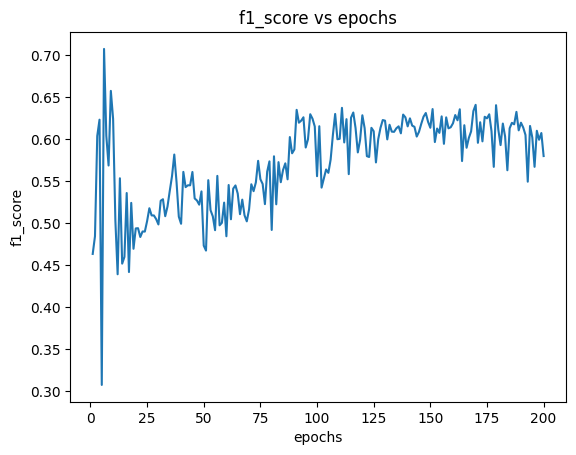

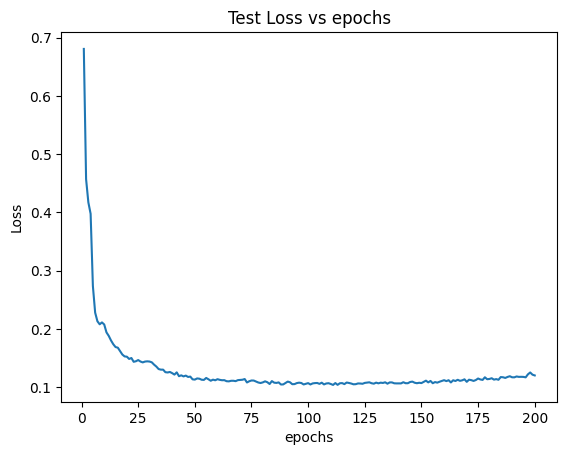

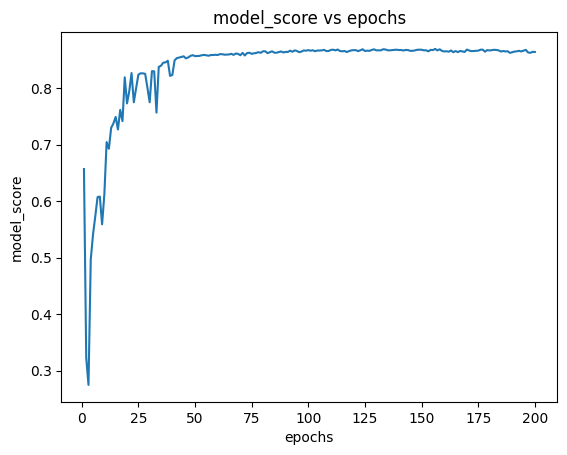

In [9]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

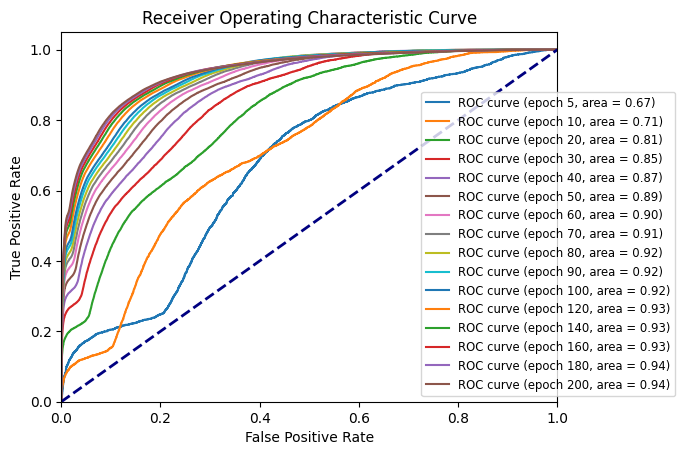

In [10]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [11]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        outputs = a * outputs1 + b * outputs2

        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh3).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.6825    0.6667  1       1
      1       0.3492    0.3333  1       0.95
      2       0.3492    0.3333  1       0.95
      3       0.5159    0.6667  0.6667  1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.5159    0.6667  0.6667  1
      7       0.6825    0.6667  1       0.95
      8       0.6825    0.6667  1       1
      9       0.5159    0.6667  0.6667  1
     10       0.6825    0.6667  1       1
     11       0.6825    0.6667  1       1
     12       0.6825    0.6667  1       1
     13       0.5317    0.5     0.5     0.7368
     14       0.6825    0.6667  1       1
     15       0.6825    0.6667  1       1
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.5159    0.6667  0.6667  1
     20       0.5238    0.5     0       1


In [12]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 